In [1]:
#%% Import

import numpy as np
import pandas as pd
import scanpy as sc # v1.4.3
import sys
import bbknn
from statsmodels import robust
import matplotlib.pyplot as plt
from pygam import LogisticGAM
from scipy import sparse, io
import anndata
import os.path

/home/jovyan/my-conda-envs/py_env/lib/python3.7/site-packages/dask/config.py:161: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}



***Import data***


In [2]:
os.chdir('/home/jovyan/data/bone_marrow/raw_data')
bm = sc.read_h5ad("full_bm.h5ad")

In [11]:
#Restrict to healthy

bm = bm[bm.obs.Status.isin(['Healthy']),:]

In [12]:
bm = bm[bm.obs['cell.labels'].isin(['tDC', 'pDC', 'DC2', 'DC precursor'])]

In [11]:
bm.raw = bm

In [12]:
bm = bm.raw.to_adata()

In [14]:
##drawing paths in final section will not work with sparse data - need to convert!!##

bm.X = bm.X.toarray()

In [15]:
import os
import glob
import pickle
import pandas as pd
import numpy as np

from dask.diagnostics import ProgressBar

from arboreto.utils import load_tf_names
from arboreto.algo import grnboost2

from pyscenic.rnkdb import FeatherRankingDatabase as RankingDatabase
from pyscenic.utils import modules_from_adjacencies, load_motifs
from pyscenic.prune import prune2df, df2regulons
from pyscenic.aucell import aucell

import seaborn as sns


DATA_FOLDER="/home/jovyan/data/pySCENIC"
RESOURCES_FOLDER="/home/jovyan/data/pySCENIC/resources"
DATABASE_FOLDER = "/home/jovyan/data/pySCENIC/databases"
DATABASES_GLOB = os.path.join(DATABASE_FOLDER, "hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr.feather")
DATABASES_GLOB = os.path.join(DATABASE_FOLDER, "*.feather")
MOTIF_ANNOTATIONS_FNAME = os.path.join(RESOURCES_FOLDER, "motifs-v9-nr.hgnc-m0.001-o0.0.tbl")
MM_TFS_FNAME = os.path.join(RESOURCES_FOLDER, 'lambert2018.txt')
SC_EXP_FNAME = os.path.join(RESOURCES_FOLDER, "data.csv")
REGULONS_FNAME = os.path.join(DATA_FOLDER, "regulons.p")
MOTIFS_FNAME = os.path.join(DATA_FOLDER, "motifs.csv")


In [16]:
ex_matrix = bm.to_df()
tf_names = load_tf_names(MM_TFS_FNAME)

db_fnames = glob.glob(DATABASES_GLOB)
def name(fname):
    return os.path.splitext(os.path.basename(fname))[0]
dbs = [RankingDatabase(fname=fname, name=name(fname)) for fname in db_fnames]
dbs


[FeatherRankingDatabase(name="hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr"),
 FeatherRankingDatabase(name="hg38__refseq-r80__10kb_up_and_down_tss.mc9nr")]

In [17]:
adjacencies = grnboost2(ex_matrix, tf_names=tf_names, verbose=True)

preparing dask client
parsing input
creating dask graph


/home/jovyan/my-conda-envs/py_env/lib/python3.7/site-packages/arboreto/algo.py:214: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  expression_matrix = expression_data.as_matrix()


6 partitions
computing dask graph


distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 17% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 17% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 17% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 17% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 17% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

shutting down client and local cluster
finished


In [18]:
modules = list(modules_from_adjacencies(adjacencies, ex_matrix))


2021-02-10 21:37:15,052 - pyscenic.utils - INFO - Calculating Pearson correlations.

2021-02-10 21:37:15,053 - pyscenic.utils - WARNING - Note on correlation calculation: the default behaviour for calculating the correlations has changed after pySCENIC verion 0.9.16. Previously, the default was to calculate the correlation between a TF and target gene using only cells with non-zero expression values (mask_dropouts=True). The current default is now to use all cells to match the behavior of the R verision of SCENIC. The original settings can be retained by setting 'rho_mask_dropouts=True' in the modules_from_adjacencies function, or '--mask_dropouts' from the CLI.
	Dropout masking is currently set to [False].
distributed.core - INFO - Event loop was unresponsive in Nanny for 7.73s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 7.73s.  

In [19]:
with ProgressBar():
    df = prune2df(dbs, modules, MOTIF_ANNOTATIONS_FNAME)

[                                        ] | 0% Completed | 17.3s


2021-02-10 21:40:56,017 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for DLX2 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[                                        ] | 0% Completed | 25.0s


2021-02-10 21:41:03,787 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ARNT2 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[                                        ] | 0% Completed | 26.1s


2021-02-10 21:41:04,705 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NANOGP8 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[                                        ] | 0% Completed | 27.9s


2021-02-10 21:41:06,562 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NEUROG2 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:41:06,676 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NEUROG3 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[                                        ] | 0% Completed | 28.2s


2021-02-10 21:41:06,823 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for PRDM16 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[                                        ] | 0% Completed | 30.9s


2021-02-10 21:41:09,569 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NFATC4 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[                                        ] | 0% Completed | 40.7s


2021-02-10 21:41:19,345 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for GTF2IRD2 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[                                        ] | 0% Completed | 48.7s


2021-02-10 21:41:27,533 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF132 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[                                        ] | 0% Completed | 50.5s


2021-02-10 21:41:29,292 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HES1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[                                        ] | 0% Completed | 50.7s


2021-02-10 21:41:29,387 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HES2 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[                                        ] | 0% Completed | 51.1s


2021-02-10 21:41:29,765 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HES4 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[                                        ] | 0% Completed | 57.6s


2021-02-10 21:41:36,353 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF474 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[                                        ] | 0% Completed |  1min  1.2s


2021-02-10 21:41:39,805 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for L3MBTL4 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[                                        ] | 0% Completed |  1min  2.3s


2021-02-10 21:41:40,994 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF485 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[                                        ] | 0% Completed |  1min  4.0s


2021-02-10 21:41:43,721 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for LHX1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[                                        ] | 0% Completed |  1min  5.2s


2021-02-10 21:41:44,260 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for LHX4 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[                                        ] | 0% Completed |  1min  6.6s


2021-02-10 21:41:45,223 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HIC1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[                                        ] | 0% Completed |  1min  8.6s


2021-02-10 21:41:47,225 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF320 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[                                        ] | 0% Completed |  1min 10.8s


2021-02-10 21:41:49,540 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF507 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:41:49,564 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF324B could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[                                        ] | 0% Completed |  1min 11.9s


2021-02-10 21:41:50,810 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HIVEP1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[                                        ] | 0% Completed |  1min 19.0s


2021-02-10 21:41:57,829 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF514 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[                                        ] | 0% Completed |  1min 19.9s


2021-02-10 21:41:58,451 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF625 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[                                        ] | 0% Completed |  1min 22.3s


2021-02-10 21:42:00,988 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF772 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[                                        ] | 0% Completed |  1min 22.8s


2021-02-10 21:42:01,742 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF630 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:42:02,023 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF775 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[                                        ] | 0% Completed |  1min 23.7s


2021-02-10 21:42:02,344 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF776 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[                                        ] | 0% Completed |  1min 23.8s


2021-02-10 21:42:02,529 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF350 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[                                        ] | 0% Completed |  1min 29.2s


2021-02-10 21:42:07,936 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF528 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[                                        ] | 0% Completed |  1min 31.1s


2021-02-10 21:42:09,724 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF540 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[                                        ] | 0% Completed |  1min 31.7s


2021-02-10 21:42:10,366 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ALX3 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:42:10,377 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF543 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:42:10,460 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for RHOXF2B could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[                                        ] | 0% Completed |  1min 33.5s


2021-02-10 21:42:12,186 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF548 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[                                        ] | 0% Completed |  1min 33.9s


2021-02-10 21:42:12,535 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF549 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[                                        ] | 0% Completed |  1min 35.7s


2021-02-10 21:42:14,375 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for RORC could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:42:14,467 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF660 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[                                        ] | 0% Completed |  1min 36.2s


2021-02-10 21:42:14,861 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF554 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[                                        ] | 0% Completed |  1min 36.4s


2021-02-10 21:42:15,122 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF790 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[                                        ] | 0% Completed |  1min 37.3s


2021-02-10 21:42:15,962 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF555 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[                                        ] | 0% Completed |  1min 37.9s


2021-02-10 21:42:16,542 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF556 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[                                        ] | 0% Completed |  1min 40.5s


2021-02-10 21:42:19,266 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF559 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[                                        ] | 0% Completed |  1min 43.3s


2021-02-10 21:42:22,596 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF564 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[                                        ] | 0% Completed |  1min 44.5s


2021-02-10 21:42:23,175 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ARNTL could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[                                        ] | 0% Completed |  1min 45.0s


2021-02-10 21:42:23,564 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ARNTL2 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:42:23,718 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF385C could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[                                        ] | 0% Completed |  1min 47.2s


2021-02-10 21:42:25,934 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF676 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[                                        ] | 0% Completed |  1min 47.5s


2021-02-10 21:42:26,220 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ASCL5 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[                                        ] | 0% Completed |  1min 49.3s


2021-02-10 21:42:27,977 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF395 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[                                        ] | 0% Completed |  1min 49.9s


2021-02-10 21:42:28,600 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF571 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:42:28,622 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF396 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[                                        ] | 0% Completed |  1min 50.5s


2021-02-10 21:42:29,187 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF573 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[                                        ] | 0% Completed |  1min 52.9s


2021-02-10 21:42:31,575 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF829 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[                                        ] | 0% Completed |  1min 54.8s


2021-02-10 21:42:33,492 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF579 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[                                        ] | 0% Completed |  1min 55.9s


2021-02-10 21:42:34,770 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF836 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[                                        ] | 0% Completed |  1min 57.3s


2021-02-10 21:42:35,968 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF221 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[                                        ] | 0% Completed |  1min 57.5s


2021-02-10 21:42:36,155 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for GRHL3 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[                                        ] | 0% Completed |  1min 57.6s


2021-02-10 21:42:36,297 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF222 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[                                        ] | 0% Completed |  1min 57.8s


2021-02-10 21:42:36,649 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for DPF3 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:42:36,764 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF223 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[                                        ] | 0% Completed |  1min 58.3s


2021-02-10 21:42:37,331 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF224 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[                                        ] | 0% Completed |  1min 58.8s


2021-02-10 21:42:37,740 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF582 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[                                        ] | 0% Completed |  2min  0.1s


2021-02-10 21:42:38,557 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF419 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[                                        ] | 0% Completed |  2min  0.3s


2021-02-10 21:42:38,741 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HMX2 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[                                        ] | 0% Completed |  2min  0.7s


2021-02-10 21:42:39,418 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF584 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:42:39,426 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SALL2 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[                                        ] | 0% Completed |  2min  0.8s


2021-02-10 21:42:39,645 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for KLF16 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:42:39,638 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF425 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[                                        ] | 0% Completed |  2min  3.4s


2021-02-10 21:42:42,219 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for GTF2IRD2 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[                                        ] | 0% Completed |  2min  7.3s


2021-02-10 21:42:45,963 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF596 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[                                        ] | 0% Completed |  2min  7.5s


2021-02-10 21:42:46,272 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF597 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[                                        ] | 0% Completed |  2min  7.9s


2021-02-10 21:42:46,538 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF844 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[                                        ] | 0% Completed |  2min  8.4s


2021-02-10 21:42:47,078 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for KLF5 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[                                        ] | 0% Completed |  2min 12.0s


2021-02-10 21:42:50,678 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SETBP1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[                                        ] | 0% Completed |  2min 15.1s


2021-02-10 21:42:52,870 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF432 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:42:53,380 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for KLF7 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:42:53,759 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for STAT4 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:42:53,771 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF436 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[                                        ] | 0% Completed |  2min 15.6s


2021-02-10 21:42:54,178 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HES1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[                                        ] | 0% Completed |  2min 15.8s


2021-02-10 21:42:54,564 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HOXB2 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[                                        ] | 0% Completed |  2min 16.3s


2021-02-10 21:42:54,926 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HOXB3 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:42:54,939 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HES4 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[                                        ] | 0% Completed |  2min 17.1s


2021-02-10 21:42:55,659 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF891 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[                                        ] | 0% Completed |  2min 17.4s


2021-02-10 21:42:56,022 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HEY2 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[                                        ] | 0% Completed |  2min 18.2s


2021-02-10 21:42:57,137 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZBTB37 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[                                        ] | 0% Completed |  2min 19.5s


2021-02-10 21:42:58,171 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NFATC4 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[                                        ] | 0% Completed |  2min 19.8s


2021-02-10 21:42:58,863 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF442 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:42:58,945 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HOXD1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[                                        ] | 0% Completed |  2min 22.2s


2021-02-10 21:42:58,981 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HIC1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:42:59,084 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF443 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:42:59,851 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for MEF2B could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:43:00,434 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF713 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[                                        ] | 0% Completed |  2min 22.3s


2021-02-10 21:43:00,889 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NPAS4 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:43:01,061 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SHOX2 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[                                        ] | 0% Completed |  2min 23.1s


2021-02-10 21:43:01,872 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NR1D1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[                                        ] | 0% Completed |  2min 23.5s


2021-02-10 21:43:02,165 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NR1D2 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[                                        ] | 0% Completed |  2min 23.6s


2021-02-10 21:43:02,277 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for L3MBTL3 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[                                        ] | 0% Completed |  2min 24.2s


2021-02-10 21:43:02,797 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for L3MBTL4 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[                                        ] | 0% Completed |  2min 24.7s


2021-02-10 21:43:03,566 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for EGR4 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[                                        ] | 0% Completed |  2min 26.3s


2021-02-10 21:43:04,992 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for LHX1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[                                        ] | 0% Completed |  2min 26.5s


2021-02-10 21:43:05,131 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for CASZ1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:43:05,228 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF461 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[                                        ] | 0% Completed |  2min 27.4s


2021-02-10 21:43:06,035 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TBR1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[                                        ] | 0% Completed |  2min 29.1s


2021-02-10 21:43:07,747 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for RAX could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[                                        ] | 0% Completed |  2min 30.2s


2021-02-10 21:43:08,982 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF275 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:43:09,072 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for MEIS1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[                                        ] | 0% Completed |  2min 37.2s


2021-02-10 21:43:15,823 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF74 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[                                        ] | 0% Completed |  2min 37.3s


2021-02-10 21:43:15,959 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NFIL3 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[                                        ] | 0% Completed |  2min 39.5s


2021-02-10 21:43:18,362 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF283 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[                                        ] | 0% Completed |  2min 41.3s


2021-02-10 21:43:19,877 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF75D could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[                                        ] | 0% Completed |  2min 44.5s


2021-02-10 21:43:23,320 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for MLXIPL could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[                                        ] | 0% Completed |  2min 45.6s


2021-02-10 21:43:23,687 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZBTB8B could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[                                        ] | 0% Completed |  2min 48.9s


2021-02-10 21:43:27,567 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TBR1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[                                        ] | 0% Completed |  2min 53.4s


2021-02-10 21:43:32,239 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZXDA could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[                                        ] | 1% Completed |  2min 57.3s


2021-02-10 21:43:36,046 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF623 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[                                        ] | 1% Completed |  2min 58.2s


2021-02-10 21:43:36,944 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ELF3 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[                                        ] | 1% Completed |  2min 58.9s


2021-02-10 21:43:37,484 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF625 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[                                        ] | 1% Completed |  3min  1.1s


2021-02-10 21:43:39,667 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF630 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[                                        ] | 1% Completed |  3min  2.2s


2021-02-10 21:43:40,859 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF641 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[                                        ] | 1% Completed |  3min  3.4s


2021-02-10 21:43:42,118 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF781 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[                                        ] | 1% Completed |  3min  3.6s


2021-02-10 21:43:42,166 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for MSX1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[                                        ] | 1% Completed |  3min  3.7s


2021-02-10 21:43:42,266 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TBX19 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[                                        ] | 1% Completed |  3min  3.8s


2021-02-10 21:43:42,359 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZBTB2 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[                                        ] | 1% Completed |  3min  3.9s


2021-02-10 21:43:42,536 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF320 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:43:42,638 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TCF7 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[                                        ] | 1% Completed |  3min  4.0s


2021-02-10 21:43:42,727 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF502 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[                                        ] | 1% Completed |  3min  4.8s


2021-02-10 21:43:43,543 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF785 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[                                        ] | 1% Completed |  3min  5.3s


2021-02-10 21:43:44,075 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF649 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[                                        ] | 1% Completed |  3min  5.9s


2021-02-10 21:43:45,331 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF787 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:43:45,272 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF324B could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[                                        ] | 2% Completed |  3min  6.9s


2021-02-10 21:43:45,533 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF788 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:43:45,543 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF653 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[                                        ] | 2% Completed |  3min  7.0s


2021-02-10 21:43:45,642 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF507 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[                                        ] | 2% Completed |  3min  7.3s


2021-02-10 21:43:45,877 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TEAD1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[                                        ] | 2% Completed |  3min  7.9s


2021-02-10 21:43:46,562 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TEAD3 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[                                        ] | 2% Completed |  3min  9.4s


2021-02-10 21:43:47,987 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF660 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[#                                       ] | 2% Completed |  3min  9.5s


2021-02-10 21:43:48,122 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZBTB37 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[#                                       ] | 2% Completed |  3min 10.7s


2021-02-10 21:43:49,370 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF667 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[#                                       ] | 2% Completed |  3min 11.4s


2021-02-10 21:43:50,079 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ARNTL2 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:43:50,181 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for BORCS8-MEF2B could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[#                                       ] | 2% Completed |  3min 12.2s


2021-02-10 21:43:50,864 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ASCL5 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[#                                       ] | 2% Completed |  3min 12.4s


2021-02-10 21:43:51,069 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF334 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[#                                       ] | 2% Completed |  3min 12.8s


2021-02-10 21:43:51,488 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF154 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[#                                       ] | 2% Completed |  3min 13.6s


2021-02-10 21:43:52,229 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF514 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[#                                       ] | 2% Completed |  3min 15.5s


2021-02-10 21:43:54,245 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF676 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[#                                       ] | 2% Completed |  3min 16.7s


2021-02-10 21:43:55,357 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF175 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[#                                       ] | 2% Completed |  3min 18.1s


2021-02-10 21:43:56,667 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF18 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[#                                       ] | 2% Completed |  3min 19.6s


2021-02-10 21:43:58,335 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF35 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[#                                       ] | 2% Completed |  3min 19.8s


2021-02-10 21:43:58,454 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF350 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[#                                       ] | 2% Completed |  3min 20.1s


2021-02-10 21:43:58,652 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF829 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:43:58,655 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF684 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[#                                       ] | 2% Completed |  3min 20.5s


2021-02-10 21:43:59,150 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF182 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[#                                       ] | 2% Completed |  3min 20.6s


2021-02-10 21:43:59,267 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF354B could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[#                                       ] | 2% Completed |  3min 21.2s


2021-02-10 21:43:59,835 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF358 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[#                                       ] | 2% Completed |  3min 22.1s


2021-02-10 21:44:00,763 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF835 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[#                                       ] | 2% Completed |  3min 22.9s


2021-02-10 21:44:01,579 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF836 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[#                                       ] | 2% Completed |  3min 23.5s


2021-02-10 21:44:02,172 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF528 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[#                                       ] | 3% Completed |  3min 23.9s


2021-02-10 21:44:02,628 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZBTB49 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[#                                       ] | 3% Completed |  3min 24.3s


2021-02-10 21:44:02,933 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF197 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[#                                       ] | 3% Completed |  3min 24.4s


2021-02-10 21:44:03,065 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for RHOXF2B could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:44:03,061 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZBTB5 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:44:03,228 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HMX2 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:44:03,268 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZBTB6 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[#                                       ] | 3% Completed |  3min 24.9s


2021-02-10 21:44:03,561 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF382 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[#                                       ] | 3% Completed |  3min 25.9s


2021-02-10 21:44:04,552 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZFP28 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[#                                       ] | 3% Completed |  3min 26.1s


2021-02-10 21:44:04,675 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for RORC could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[#                                       ] | 3% Completed |  3min 26.3s


2021-02-10 21:44:04,929 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SOX13 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:44:04,863 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF543 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[#                                       ] | 3% Completed |  3min 26.7s


2021-02-10 21:44:05,219 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF544 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[#                                       ] | 3% Completed |  3min 27.7s


2021-02-10 21:44:06,375 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SOX17 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[#                                       ] | 3% Completed |  3min 28.6s


2021-02-10 21:44:07,265 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF547 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[#                                       ] | 3% Completed |  3min 29.1s


2021-02-10 21:44:07,780 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF548 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[#                                       ] | 3% Completed |  3min 29.4s


2021-02-10 21:44:08,136 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF549 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:44:08,250 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TFCP2L1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:44:08,250 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF841 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[#                                       ] | 3% Completed |  3min 30.2s


2021-02-10 21:44:08,652 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TEAD3 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[#                                       ] | 3% Completed |  3min 30.3s


2021-02-10 21:44:08,937 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF844 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[#                                       ] | 3% Completed |  3min 30.5s


2021-02-10 21:44:09,077 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ATOH7 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[#                                       ] | 3% Completed |  3min 31.1s


2021-02-10 21:44:09,780 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF554 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[#                                       ] | 3% Completed |  3min 31.5s


2021-02-10 21:44:10,130 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF555 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:44:10,175 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF852 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[#                                       ] | 3% Completed |  3min 31.7s


2021-02-10 21:44:10,379 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for BATF2 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[#                                       ] | 3% Completed |  3min 31.8s


2021-02-10 21:44:10,382 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF556 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[#                                       ] | 3% Completed |  3min 32.0s


2021-02-10 21:44:10,678 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for CASZ1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[#                                       ] | 3% Completed |  3min 32.4s


2021-02-10 21:44:11,036 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF559 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:44:11,045 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF879 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:44:11,093 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZBTB8B could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[#                                       ] | 3% Completed |  3min 32.6s


2021-02-10 21:44:11,239 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF561 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[#                                       ] | 3% Completed |  3min 33.2s


2021-02-10 21:44:11,776 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF888 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[#                                       ] | 3% Completed |  3min 33.4s


2021-02-10 21:44:12,087 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF891 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[#                                       ] | 3% Completed |  3min 33.6s


2021-02-10 21:44:12,167 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF564 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[#                                       ] | 3% Completed |  3min 34.1s


2021-02-10 21:44:12,763 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for MXD4 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[#                                       ] | 3% Completed |  3min 34.7s


2021-02-10 21:44:13,285 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF567 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[#                                       ] | 3% Completed |  3min 35.8s


2021-02-10 21:44:14,347 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HES1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[#                                       ] | 3% Completed |  3min 36.6s


2021-02-10 21:44:15,243 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF208 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[#                                       ] | 3% Completed |  3min 36.8s


2021-02-10 21:44:15,356 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HES2 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[#                                       ] | 3% Completed |  3min 38.0s


2021-02-10 21:44:16,639 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HOXB2 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[#                                       ] | 3% Completed |  3min 38.2s


2021-02-10 21:44:16,890 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HOXB3 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[#                                       ] | 3% Completed |  3min 38.5s


2021-02-10 21:44:17,119 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF213 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[#                                       ] | 3% Completed |  3min 38.9s


2021-02-10 21:44:17,545 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SALL2 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:44:17,540 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HEY2 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[#                                       ] | 3% Completed |  3min 39.4s


2021-02-10 21:44:18,045 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HIC1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:44:18,051 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HOXC10 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[#                                       ] | 3% Completed |  3min 39.5s


2021-02-10 21:44:18,229 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SOX8 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[#                                       ] | 3% Completed |  3min 39.6s


2021-02-10 21:44:18,182 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF385C could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:44:18,328 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HOXC6 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[#                                       ] | 3% Completed |  3min 40.3s


2021-02-10 21:44:18,942 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HOXC8 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[#                                       ] | 3% Completed |  3min 40.5s


2021-02-10 21:44:19,078 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZFPM1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[#                                       ] | 3% Completed |  3min 41.5s


2021-02-10 21:44:20,173 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HOXD1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[#                                       ] | 3% Completed |  3min 41.9s


2021-02-10 21:44:20,538 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SETBP1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[#                                       ] | 3% Completed |  3min 42.4s


2021-02-10 21:44:20,983 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF571 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[#                                       ] | 3% Completed |  3min 42.6s


2021-02-10 21:44:21,231 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TFCP2L1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:44:21,265 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF572 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[#                                       ] | 3% Completed |  3min 42.8s


2021-02-10 21:44:21,465 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF573 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[#                                       ] | 3% Completed |  3min 43.1s


2021-02-10 21:44:21,824 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF707 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[#                                       ] | 3% Completed |  3min 43.6s


2021-02-10 21:44:22,327 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF708 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[#                                       ] | 3% Completed |  3min 43.7s


2021-02-10 21:44:22,373 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for MEF2B could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[#                                       ] | 3% Completed |  3min 44.0s


2021-02-10 21:44:22,688 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF71 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[#                                       ] | 3% Completed |  3min 44.6s


2021-02-10 21:44:23,185 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF579 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[#                                       ] | 3% Completed |  3min 45.1s


2021-02-10 21:44:23,786 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF713 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[#                                       ] | 3% Completed |  3min 45.2s


2021-02-10 21:44:23,857 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZFHX2 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[#                                       ] | 3% Completed |  3min 45.5s


2021-02-10 21:44:24,067 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF219 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[#                                       ] | 3% Completed |  3min 47.4s


2021-02-10 21:44:25,938 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HIVEP2 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:44:26,066 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF395 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[#                                       ] | 3% Completed |  3min 47.5s


2021-02-10 21:44:26,143 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF584 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[#                                       ] | 3% Completed |  3min 47.6s


2021-02-10 21:44:26,223 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF396 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[#                                       ] | 3% Completed |  3min 48.0s


2021-02-10 21:44:26,630 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF585B could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[#                                       ] | 3% Completed |  3min 48.1s


2021-02-10 21:44:26,682 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SHOX2 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[#                                       ] | 3% Completed |  3min 48.3s


2021-02-10 21:44:26,885 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF407 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[#                                       ] | 3% Completed |  3min 49.3s


2021-02-10 21:44:27,948 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HMX2 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[#                                       ] | 3% Completed |  3min 49.8s


2021-02-10 21:44:28,419 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for BORCS8-MEF2B could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:44:28,490 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZHX3 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[#                                       ] | 3% Completed |  3min 50.3s


2021-02-10 21:44:28,850 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF732 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[#                                       ] | 3% Completed |  3min 50.4s


2021-02-10 21:44:29,039 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for MEIS1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[#                                       ] | 3% Completed |  3min 50.5s


2021-02-10 21:44:29,127 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HSFX1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[#                                       ] | 3% Completed |  3min 50.7s


2021-02-10 21:44:29,330 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF74 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[#                                       ] | 3% Completed |  3min 51.5s


2021-02-10 21:44:30,125 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZSCAN31 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:44:30,123 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for EGR4 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[#                                       ] | 3% Completed |  3min 52.2s


2021-02-10 21:44:30,882 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZSCAN5A could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[#                                       ] | 3% Completed |  3min 52.4s


2021-02-10 21:44:31,022 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZSCAN5B could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[#                                       ] | 3% Completed |  3min 52.7s


2021-02-10 21:44:31,353 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZFPM1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[#                                       ] | 3% Completed |  3min 52.8s


2021-02-10 21:44:31,478 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZXDA could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[#                                       ] | 3% Completed |  3min 53.5s


2021-02-10 21:44:32,041 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for IKZF2 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[#                                       ] | 3% Completed |  3min 54.0s


2021-02-10 21:44:32,629 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for IKZF4 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:44:32,660 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZKSCAN2 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[#                                       ] | 3% Completed |  3min 54.1s


2021-02-10 21:44:32,685 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for JRKL could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:44:32,745 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF415 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:44:32,759 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for IKZF5 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[#                                       ] | 3% Completed |  3min 54.2s


2021-02-10 21:44:32,822 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ADNP2 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:44:32,834 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF221 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[#                                       ] | 3% Completed |  3min 54.4s


2021-02-10 21:44:33,031 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF222 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:44:33,032 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZKSCAN3 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[#                                       ] | 3% Completed |  3min 54.5s


2021-02-10 21:44:33,148 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF596 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[#                                       ] | 3% Completed |  3min 54.6s


2021-02-10 21:44:33,240 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF223 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[#                                       ] | 3% Completed |  3min 54.8s


2021-02-10 21:44:33,347 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for CASZ1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[#                                       ] | 3% Completed |  3min 54.9s


2021-02-10 21:44:33,522 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF224 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[#                                       ] | 3% Completed |  3min 55.0s


2021-02-10 21:44:33,579 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF416 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:44:33,424 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF597 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[#                                       ] | 3% Completed |  3min 55.6s


2021-02-10 21:44:34,255 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF226 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[#                                       ] | 3% Completed |  3min 56.0s


2021-02-10 21:44:34,592 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF600 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[#                                       ] | 3% Completed |  3min 56.1s


2021-02-10 21:44:34,776 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for MLXIPL could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:44:34,766 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NHLH2 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[#                                       ] | 3% Completed |  3min 56.2s


2021-02-10 21:44:34,831 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ESR2 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:44:34,855 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF419 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[#                                       ] | 3% Completed |  3min 56.5s


2021-02-10 21:44:35,186 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZHX3 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[#                                       ] | 3% Completed |  3min 57.2s


2021-02-10 21:44:35,785 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF607 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:44:35,847 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for EGR4 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[#                                       ] | 3% Completed |  3min 57.3s


2021-02-10 21:44:35,945 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ALX3 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[#                                       ] | 3% Completed |  3min 57.5s


2021-02-10 21:44:36,160 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF425 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[#                                       ] | 3% Completed |  3min 58.7s


2021-02-10 21:44:37,425 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF611 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[#                                       ] | 3% Completed |  3min 58.8s


2021-02-10 21:44:37,450 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZKSCAN7 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[#                                       ] | 3% Completed |  3min 59.2s


2021-02-10 21:44:37,783 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF77 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:44:37,861 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF429 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[#                                       ] | 3% Completed |  4min  0.5s


2021-02-10 21:44:39,121 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for PAX2 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:44:39,430 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF772 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[#                                       ] | 3% Completed |  4min  1.0s


2021-02-10 21:44:39,675 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF620 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:44:39,721 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for MSX1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:44:39,691 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF114 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[#                                       ] | 3% Completed |  4min  1.2s


2021-02-10 21:44:39,747 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF432 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:44:39,934 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF117 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[#                                       ] | 3% Completed |  4min  1.4s


2021-02-10 21:44:39,934 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF621 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:44:40,165 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF436 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:44:40,187 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF774 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[#                                       ] | 3% Completed |  4min  1.7s


2021-02-10 21:44:40,443 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF775 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[#                                       ] | 3% Completed |  4min  1.9s


2021-02-10 21:44:40,582 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NKX3-1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:44:40,682 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HOXB2 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:44:40,655 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF776 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[#                                       ] | 3% Completed |  4min  2.3s


2021-02-10 21:44:40,925 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF44 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[#                                       ] | 3% Completed |  4min  2.9s


2021-02-10 21:44:42,230 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF442 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[#                                       ] | 4% Completed |  4min  3.7s


2021-02-10 21:44:42,358 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF132 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:44:42,378 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HOXB3 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[#                                       ] | 4% Completed |  4min  3.9s


2021-02-10 21:44:42,550 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ESRRB could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:44:42,739 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF134 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[#                                       ] | 4% Completed |  4min  5.1s


2021-02-10 21:44:43,757 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ETS1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[#                                       ] | 4% Completed |  4min  5.3s


2021-02-10 21:44:43,873 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF446 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[#                                       ] | 4% Completed |  4min  5.5s


2021-02-10 21:44:44,225 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF449 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[#                                       ] | 4% Completed |  4min  5.6s


2021-02-10 21:44:44,425 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for L3MBTL3 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[#                                       ] | 4% Completed |  4min  7.2s


2021-02-10 21:44:45,826 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF461 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[#                                       ] | 4% Completed |  4min  7.8s


2021-02-10 21:44:46,269 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HOXC6 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[##                                      ] | 5% Completed |  4min  8.4s


2021-02-10 21:44:46,980 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ELF3 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[##                                      ] | 5% Completed |  4min  8.5s


2021-02-10 21:44:47,223 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HOXD1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[##                                      ] | 5% Completed |  4min  8.6s


2021-02-10 21:44:47,386 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF264 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[##                                      ] | 5% Completed |  4min  9.5s


2021-02-10 21:44:48,090 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ELF3 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[##                                      ] | 5% Completed |  4min 10.0s


2021-02-10 21:44:48,579 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SNAI2 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[##                                      ] | 5% Completed |  4min 10.7s


2021-02-10 21:44:49,356 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for LCOR could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[##                                      ] | 5% Completed |  4min 11.3s


2021-02-10 21:44:50,178 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for MXD4 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:44:50,230 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF485 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[##                                      ] | 5% Completed |  4min 11.6s


2021-02-10 21:44:50,564 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for MYCN could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[##                                      ] | 5% Completed |  4min 12.0s


2021-02-10 21:44:50,670 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SOHLH2 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[##                                      ] | 5% Completed |  4min 13.9s


2021-02-10 21:44:52,632 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for MYRFL could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[##                                      ] | 5% Completed |  4min 14.1s


2021-02-10 21:44:52,848 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for CPEB1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[##                                      ] | 5% Completed |  4min 14.7s


2021-02-10 21:44:53,454 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for IKZF5 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:44:54,852 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for MYT1L could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[##                                      ] | 5% Completed |  4min 16.5s


2021-02-10 21:44:55,235 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for LHX1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[##                                      ] | 6% Completed |  4min 16.8s


2021-02-10 21:44:55,391 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for THAP2 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[##                                      ] | 6% Completed |  4min 17.3s


2021-02-10 21:44:56,055 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TBR1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[##                                      ] | 6% Completed |  4min 17.9s


2021-02-10 21:44:56,780 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for THAP6 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[##                                      ] | 6% Completed |  4min 18.4s


2021-02-10 21:44:57,059 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF283 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[##                                      ] | 6% Completed |  4min 18.5s


2021-02-10 21:44:57,186 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF284 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[##                                      ] | 7% Completed |  4min 19.4s


2021-02-10 21:44:58,173 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF286B could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[##                                      ] | 7% Completed |  4min 19.6s


2021-02-10 21:44:58,368 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF287 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[##                                      ] | 7% Completed |  4min 19.7s


2021-02-10 21:44:58,429 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for CPEB1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[##                                      ] | 7% Completed |  4min 21.9s


2021-02-10 21:45:00,588 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NPAS3 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[##                                      ] | 7% Completed |  4min 22.1s


2021-02-10 21:45:00,848 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NPAS4 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[##                                      ] | 7% Completed |  4min 22.8s


2021-02-10 21:45:01,167 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NR1D2 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:45:01,591 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TCF15 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[###                                     ] | 7% Completed |  4min 23.6s


2021-02-10 21:45:02,181 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZBTB20 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[###                                     ] | 7% Completed |  4min 24.7s


2021-02-10 21:45:03,352 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SOX11 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[###                                     ] | 7% Completed |  4min 25.0s


2021-02-10 21:45:03,648 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SOX13 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[###                                     ] | 7% Completed |  4min 25.4s


2021-02-10 21:45:04,065 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZBTB37 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:45:04,219 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SOX17 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:45:04,250 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TIGD3 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[###                                     ] | 7% Completed |  4min 25.9s


2021-02-10 21:45:04,480 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TIGD5 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[###                                     ] | 7% Completed |  4min 26.9s


2021-02-10 21:45:05,790 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for MYCN could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[###                                     ] | 7% Completed |  4min 27.3s


2021-02-10 21:45:05,893 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for MYF6 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[###                                     ] | 8% Completed |  4min 27.8s


2021-02-10 21:45:06,470 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZBTB49 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[###                                     ] | 8% Completed |  4min 28.0s


2021-02-10 21:45:06,626 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZBTB5 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[###                                     ] | 8% Completed |  4min 29.1s


2021-02-10 21:45:07,773 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF174 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[###                                     ] | 8% Completed |  4min 29.8s


2021-02-10 21:45:08,537 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF182 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[###                                     ] | 8% Completed |  4min 30.3s


2021-02-10 21:45:09,031 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for MEF2B could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[###                                     ] | 8% Completed |  4min 30.4s


2021-02-10 21:45:09,120 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NHLH2 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[###                                     ] | 8% Completed |  4min 30.7s


2021-02-10 21:45:09,362 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for MEIS1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:45:09,381 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for IRX1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[###                                     ] | 8% Completed |  4min 30.8s


2021-02-10 21:45:09,525 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF334 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[###                                     ] | 8% Completed |  4min 31.0s


2021-02-10 21:45:09,628 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for IRX3 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[###                                     ] | 8% Completed |  4min 31.1s


2021-02-10 21:45:09,792 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NKX6-3 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[###                                     ] | 8% Completed |  4min 31.7s


2021-02-10 21:45:10,381 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ETV2 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:45:10,393 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for MYRFL could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:45:10,461 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NPAS3 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[###                                     ] | 8% Completed |  4min 32.0s


2021-02-10 21:45:10,662 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NPAS4 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[###                                     ] | 8% Completed |  4min 32.2s


2021-02-10 21:45:10,868 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZBTB8B could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:45:10,889 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for JRKL could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[###                                     ] | 8% Completed |  4min 32.3s


2021-02-10 21:45:11,035 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for CPEB1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[###                                     ] | 8% Completed |  4min 32.7s


2021-02-10 21:45:11,171 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for MYT1L could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:45:11,240 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NR1D2 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:45:11,345 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TEAD3 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:45:11,425 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF35 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[###                                     ] | 9% Completed |  4min 32.8s


2021-02-10 21:45:11,551 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF350 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[###                                     ] | 9% Completed |  4min 33.1s


2021-02-10 21:45:11,753 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NR1I2 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[###                                     ] | 9% Completed |  4min 33.3s


2021-02-10 21:45:11,948 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF354B could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:45:11,965 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ETV3 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[###                                     ] | 9% Completed |  4min 34.7s


2021-02-10 21:45:13,465 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SOX5 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[###                                     ] | 9% Completed |  4min 34.9s


2021-02-10 21:45:13,486 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for RHOXF2B could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[###                                     ] | 9% Completed |  4min 35.1s


2021-02-10 21:45:14,040 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF385C could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[###                                     ] | 9% Completed |  4min 35.4s


2021-02-10 21:45:14,147 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for CRX could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:45:14,173 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for MLXIPL could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[###                                     ] | 9% Completed |  4min 35.8s


2021-02-10 21:45:14,457 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZFHX2 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[###                                     ] | 9% Completed |  4min 36.1s


2021-02-10 21:45:14,736 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for CSRNP2 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[###                                     ] | 9% Completed |  4min 36.3s


2021-02-10 21:45:14,948 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF528 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[###                                     ] | 9% Completed |  4min 36.4s


2021-02-10 21:45:15,043 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TSHZ2 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[###                                     ] | 9% Completed |  4min 36.8s


2021-02-10 21:45:15,437 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for RORC could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[###                                     ] | 9% Completed |  4min 37.0s


2021-02-10 21:45:15,634 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF653 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:45:15,780 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF543 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[###                                     ] | 9% Completed |  4min 37.4s


2021-02-10 21:45:16,055 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF544 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:45:16,018 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NANOGP8 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[###                                     ] | 9% Completed |  4min 38.5s


2021-02-10 21:45:17,145 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF550 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[###                                     ] | 9% Completed |  4min 38.6s


2021-02-10 21:45:17,277 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZFPM1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:45:17,684 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NEUROG3 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:45:17,379 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF395 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[###                                     ] | 9% Completed |  4min 39.2s


2021-02-10 21:45:17,525 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NEUROG2 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:45:17,560 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF396 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:45:17,661 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF554 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[###                                     ] | 9% Completed |  4min 39.3s


2021-02-10 21:45:17,925 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF555 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[###                                     ] | 9% Completed |  4min 39.4s


2021-02-10 21:45:18,050 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF407 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[###                                     ] | 9% Completed |  4min 39.5s


2021-02-10 21:45:18,150 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF556 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:45:18,221 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZHX3 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[###                                     ] | 9% Completed |  4min 39.6s


2021-02-10 21:45:18,262 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF208 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[###                                     ] | 9% Completed |  4min 39.9s


2021-02-10 21:45:18,542 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF676 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[###                                     ] | 9% Completed |  4min 40.0s


2021-02-10 21:45:18,673 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF415 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:45:18,689 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF559 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[###                                     ] | 9% Completed |  4min 40.1s


2021-02-10 21:45:18,769 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NR4A3 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[###                                     ] | 9% Completed |  4min 40.2s


2021-02-10 21:45:18,844 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF416 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:45:18,830 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SOX8 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[###                                     ] | 9% Completed |  4min 40.6s


2021-02-10 21:45:19,081 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF213 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[###                                     ] | 9% Completed |  4min 40.7s


2021-02-10 21:45:19,340 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for MSX1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[###                                     ] | 9% Completed |  4min 40.8s


2021-02-10 21:45:19,375 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF418 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[###                                     ] | 9% Completed |  4min 41.0s


2021-02-10 21:45:19,555 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NR5A1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[###                                     ] | 9% Completed |  4min 41.1s


2021-02-10 21:45:19,843 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF419 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[###                                     ] | 9% Completed |  4min 41.5s


2021-02-10 21:45:20,087 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SALL2 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[###                                     ] | 9% Completed |  4min 41.6s


2021-02-10 21:45:20,385 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF684 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[###                                     ] | 9% Completed |  4min 41.8s


2021-02-10 21:45:20,495 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZKSCAN7 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[####                                    ] | 10% Completed |  4min 42.1s


2021-02-10 21:45:20,728 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF425 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[####                                    ] | 10% Completed |  4min 42.5s


2021-02-10 21:45:21,155 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF10 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[####                                    ] | 10% Completed |  4min 42.6s


2021-02-10 21:45:21,258 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SCX could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:45:21,283 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF214 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[####                                    ] | 10% Completed |  4min 43.0s


2021-02-10 21:45:21,627 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NR5A1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[####                                    ] | 10% Completed |  4min 43.2s


2021-02-10 21:45:21,868 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF219 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:45:21,942 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF114 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[####                                    ] | 10% Completed |  4min 43.3s


2021-02-10 21:45:21,963 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF436 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[####                                    ] | 10% Completed |  4min 43.5s


2021-02-10 21:45:22,154 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF221 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[####                                    ] | 10% Completed |  4min 43.6s


2021-02-10 21:45:22,388 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF223 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[####                                    ] | 10% Completed |  4min 43.8s


2021-02-10 21:45:22,440 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF44 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[####                                    ] | 10% Completed |  4min 44.0s


2021-02-10 21:45:22,625 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF224 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[####                                    ] | 10% Completed |  4min 44.2s


2021-02-10 21:45:22,842 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for IRX1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[####                                    ] | 10% Completed |  4min 44.3s


2021-02-10 21:45:22,968 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for IRX3 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:45:23,031 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF442 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[####                                    ] | 10% Completed |  4min 44.5s


2021-02-10 21:45:23,057 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF792 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[####                                    ] | 10% Completed |  4min 44.7s


2021-02-10 21:45:23,175 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF134 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[####                                    ] | 10% Completed |  4min 45.1s


2021-02-10 21:45:23,752 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF449 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:45:24,653 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ESRRB could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[####                                    ] | 10% Completed |  4min 46.2s


2021-02-10 21:45:24,922 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for OLIG1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[####                                    ] | 10% Completed |  4min 46.5s


2021-02-10 21:45:25,159 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for OLIG2 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[####                                    ] | 10% Completed |  4min 46.6s


2021-02-10 21:45:25,266 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for OLIG2 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:45:25,342 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF461 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[####                                    ] | 10% Completed |  4min 46.7s


2021-02-10 21:45:25,363 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TIGD5 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:45:25,388 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for MYCN could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[####                                    ] | 10% Completed |  4min 47.2s


2021-02-10 21:45:25,779 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF154 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[####                                    ] | 10% Completed |  4min 47.6s


2021-02-10 21:45:26,264 - pyscenic.transform - WARNING - Less than 80% of the genes in ATF5 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[####                                    ] | 10% Completed |  4min 47.7s


2021-02-10 21:45:26,373 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for MYRFL could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[####                                    ] | 10% Completed |  4min 48.0s


2021-02-10 21:45:26,647 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SHOX2 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[####                                    ] | 11% Completed |  4min 48.3s


2021-02-10 21:45:26,961 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for MYT1L could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[####                                    ] | 11% Completed |  4min 48.6s


2021-02-10 21:45:27,271 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF836 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[####                                    ] | 11% Completed |  4min 48.7s


2021-02-10 21:45:27,431 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF701 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:45:27,462 - pyscenic.transform - WARNING - Less than 80% of the genes in ATF6 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[####                                    ] | 11% Completed |  4min 49.8s


2021-02-10 21:45:28,757 - pyscenic.transform - WARNING - Less than 80% of the genes in ATF7 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[####                                    ] | 11% Completed |  4min 50.6s


2021-02-10 21:45:29,263 - pyscenic.transform - WARNING - Less than 80% of the genes in ATMIN could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[####                                    ] | 11% Completed |  4min 50.9s


2021-02-10 21:45:29,526 - pyscenic.transform - WARNING - Less than 80% of the genes in ATOH7 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[####                                    ] | 11% Completed |  4min 51.0s


2021-02-10 21:45:29,780 - pyscenic.transform - WARNING - Less than 80% of the genes in ATOH8 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[####                                    ] | 11% Completed |  4min 51.4s


2021-02-10 21:45:30,032 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF572 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:45:30,086 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for DLX2 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[####                                    ] | 11% Completed |  4min 51.5s


2021-02-10 21:45:30,220 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF573 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[####                                    ] | 11% Completed |  4min 51.7s


2021-02-10 21:45:30,289 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for FOXA1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[####                                    ] | 11% Completed |  4min 51.8s


2021-02-10 21:45:30,554 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for FOXB1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:45:30,568 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF713 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[####                                    ] | 11% Completed |  4min 52.0s


2021-02-10 21:45:30,758 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for FOXC1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[####                                    ] | 11% Completed |  4min 52.2s


2021-02-10 21:45:31,819 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for CSRNP2 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:45:31,372 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for THAP2 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:45:31,556 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF716 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[####                                    ] | 11% Completed |  4min 53.4s


2021-02-10 21:45:32,082 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ETV2 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[####                                    ] | 11% Completed |  4min 53.5s


2021-02-10 21:45:32,132 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for FOXD4L5 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:45:32,135 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for DPF3 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[####                                    ] | 11% Completed |  4min 53.6s


2021-02-10 21:45:32,238 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for THAP6 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:45:32,272 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for FOXI1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:45:32,275 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF483 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[####                                    ] | 11% Completed |  4min 53.7s


2021-02-10 21:45:32,423 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for FOXJ1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[####                                    ] | 11% Completed |  4min 53.8s


2021-02-10 21:45:32,442 - pyscenic.transform - WARNING - Less than 80% of the genes in ELF3 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:45:32,534 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF485 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[####                                    ] | 11% Completed |  4min 53.9s


2021-02-10 21:45:32,551 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for FOXJ2 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[####                                    ] | 11% Completed |  4min 54.0s


2021-02-10 21:45:32,718 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF486 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[####                                    ] | 11% Completed |  4min 54.3s


2021-02-10 21:45:32,792 - pyscenic.transform - WARNING - Less than 80% of the genes in ELF4 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:45:32,943 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NANOGP8 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[####                                    ] | 11% Completed |  4min 54.4s


2021-02-10 21:45:33,120 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF490 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[####                                    ] | 11% Completed |  4min 54.5s


2021-02-10 21:45:33,086 - pyscenic.transform - WARNING - Less than 80% of the genes in ELK1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:45:33,162 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF585B could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[####                                    ] | 11% Completed |  4min 54.7s


2021-02-10 21:45:33,366 - pyscenic.transform - WARNING - Less than 80% of the genes in ELK3 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[####                                    ] | 11% Completed |  4min 54.8s


2021-02-10 21:45:33,471 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for CSRNP2 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[####                                    ] | 11% Completed |  4min 54.9s


2021-02-10 21:45:33,538 - pyscenic.transform - WARNING - Less than 80% of the genes in ELK4 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[####                                    ] | 11% Completed |  4min 55.0s


2021-02-10 21:45:33,673 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NEUROG2 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[####                                    ] | 11% Completed |  4min 55.2s


2021-02-10 21:45:33,861 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TIGD3 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:45:33,864 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NEUROG3 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[####                                    ] | 11% Completed |  4min 55.3s


2021-02-10 21:45:33,949 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF74 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[####                                    ] | 11% Completed |  4min 55.5s


2021-02-10 21:45:34,079 - pyscenic.transform - WARNING - Less than 80% of the genes in BACH2 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[####                                    ] | 11% Completed |  4min 55.7s


2021-02-10 21:45:34,369 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TIGD5 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[####                                    ] | 11% Completed |  4min 56.0s


2021-02-10 21:45:34,661 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF502 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[####                                    ] | 11% Completed |  4min 56.2s


2021-02-10 21:45:34,834 - pyscenic.transform - WARNING - Less than 80% of the genes in EOMES could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[####                                    ] | 11% Completed |  4min 56.3s


2021-02-10 21:45:34,939 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF596 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[####                                    ] | 11% Completed |  4min 56.4s


2021-02-10 21:45:34,974 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF264 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:45:34,975 - pyscenic.transform - WARNING - Less than 80% of the genes in EPAS1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[####                                    ] | 11% Completed |  4min 56.5s


2021-02-10 21:45:35,077 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF597 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[####                                    ] | 11% Completed |  4min 56.6s


2021-02-10 21:45:35,247 - pyscenic.transform - WARNING - Less than 80% of the genes in ERF could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[####                                    ] | 11% Completed |  4min 56.9s


2021-02-10 21:45:35,471 - pyscenic.transform - WARNING - Less than 80% of the genes in BATF could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[####                                    ] | 11% Completed |  4min 57.0s


2021-02-10 21:45:35,671 - pyscenic.transform - WARNING - Less than 80% of the genes in BATF2 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[####                                    ] | 11% Completed |  4min 57.2s


2021-02-10 21:45:35,842 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF600 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:45:35,860 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NFATC4 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:45:35,860 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for PATZ1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[####                                    ] | 11% Completed |  4min 57.4s


2021-02-10 21:45:35,971 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for PAX2 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:45:36,070 - pyscenic.transform - WARNING - Less than 80% of the genes in BAZ2A could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[####                                    ] | 11% Completed |  4min 57.5s


2021-02-10 21:45:36,239 - pyscenic.transform - WARNING - Less than 80% of the genes in BAZ2B could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[####                                    ] | 11% Completed |  4min 57.6s


2021-02-10 21:45:36,383 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF607 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[####                                    ] | 11% Completed |  4min 58.1s


2021-02-10 21:45:36,683 - pyscenic.transform - WARNING - Less than 80% of the genes in ERG could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[####                                    ] | 11% Completed |  4min 58.2s


2021-02-10 21:45:36,880 - pyscenic.transform - WARNING - Less than 80% of the genes in ESR1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[####                                    ] | 11% Completed |  4min 58.3s


2021-02-10 21:45:37,020 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF611 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[####                                    ] | 11% Completed |  4min 58.6s


2021-02-10 21:45:37,320 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SNAI2 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[####                                    ] | 11% Completed |  4min 59.3s


2021-02-10 21:45:37,958 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SOHLH2 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:45:38,036 - pyscenic.transform - WARNING - Less than 80% of the genes in BCL11A could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[####                                    ] | 11% Completed |  4min 59.4s


2021-02-10 21:45:38,295 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SOX11 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:45:38,389 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF623 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:45:38,487 - pyscenic.transform - WARNING - Less than 80% of the genes in ESRRA could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[####                                    ] | 12% Completed |  5min  0.0s


2021-02-10 21:45:38,650 - pyscenic.transform - WARNING - Less than 80% of the genes in ESRRB could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:45:38,724 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SOX13 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[####                                    ] | 12% Completed |  5min  0.1s


2021-02-10 21:45:38,736 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF625 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[####                                    ] | 12% Completed |  5min  0.3s


2021-02-10 21:45:38,947 - pyscenic.transform - WARNING - Less than 80% of the genes in ETS1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[####                                    ] | 12% Completed |  5min  0.4s


2021-02-10 21:45:39,035 - pyscenic.transform - WARNING - Less than 80% of the genes in HMG20A could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[#####                                   ] | 12% Completed |  5min  0.8s


2021-02-10 21:45:39,459 - pyscenic.transform - WARNING - Less than 80% of the genes in ETV1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[#####                                   ] | 12% Completed |  5min  1.1s


2021-02-10 21:45:39,828 - pyscenic.transform - WARNING - Less than 80% of the genes in BCL6 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:45:39,788 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for POU3F1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[#####                                   ] | 12% Completed |  5min  1.3s


2021-02-10 21:45:39,885 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for PBX3 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:45:39,925 - pyscenic.transform - WARNING - Less than 80% of the genes in BCL6B could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[#####                                   ] | 12% Completed |  5min  1.5s


2021-02-10 21:45:40,121 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF77 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:45:40,120 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF284 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[#####                                   ] | 12% Completed |  5min  2.4s


2021-02-10 21:45:41,070 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF286B could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[#####                                   ] | 12% Completed |  5min  2.8s


2021-02-10 21:45:41,541 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for FOXO4 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[#####                                   ] | 12% Completed |  5min  3.1s


2021-02-10 21:45:41,680 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for PEG3 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[#####                                   ] | 12% Completed |  5min  3.2s


2021-02-10 21:45:41,928 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF287 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[#####                                   ] | 12% Completed |  5min  3.6s


2021-02-10 21:45:42,179 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF891 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[#####                                   ] | 12% Completed |  5min  3.8s


2021-02-10 21:45:42,451 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for PAX2 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[#####                                   ] | 12% Completed |  5min  4.0s


2021-02-10 21:45:42,474 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SOX17 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[#####                                   ] | 12% Completed |  5min  4.4s


2021-02-10 21:45:42,641 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF774 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:45:42,732 - pyscenic.transform - WARNING - Less than 80% of the genes in BHLHE40 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:45:43,147 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF775 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[#####                                   ] | 12% Completed |  5min  4.7s


2021-02-10 21:45:43,378 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF776 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[#####                                   ] | 12% Completed |  5min  5.1s


2021-02-10 21:45:43,663 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for PAX9 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[#####                                   ] | 12% Completed |  5min  5.2s


2021-02-10 21:45:43,786 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF99 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:45:43,859 - pyscenic.transform - WARNING - Less than 80% of the genes in BNC2 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[#####                                   ] | 12% Completed |  5min  5.5s


2021-02-10 21:45:44,128 - pyscenic.transform - WARNING - Less than 80% of the genes in ETV2 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[#####                                   ] | 12% Completed |  5min  5.7s


2021-02-10 21:45:44,352 - pyscenic.transform - WARNING - Less than 80% of the genes in BRF2 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:45:44,378 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for PBX4 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[#####                                   ] | 12% Completed |  5min  5.8s


2021-02-10 21:45:44,494 - pyscenic.transform - WARNING - Less than 80% of the genes in C11orf95 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:45:44,645 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF785 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:45:44,864 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF787 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[#####                                   ] | 13% Completed |  5min  6.3s


2021-02-10 21:45:44,934 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for PEG3 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[#####                                   ] | 13% Completed |  5min  6.5s


2021-02-10 21:45:45,125 - pyscenic.transform - WARNING - Less than 80% of the genes in CAMTA2 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[#####                                   ] | 13% Completed |  5min  6.8s


2021-02-10 21:45:45,472 - pyscenic.transform - WARNING - Less than 80% of the genes in CARF could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:45:45,487 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF320 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[#####                                   ] | 13% Completed |  5min  7.0s


2021-02-10 21:45:45,663 - pyscenic.transform - WARNING - Less than 80% of the genes in CBX2 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[#####                                   ] | 13% Completed |  5min  7.2s


2021-02-10 21:45:45,847 - pyscenic.transform - WARNING - Less than 80% of the genes in CC2D1A could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:45:45,961 - pyscenic.transform - WARNING - Less than 80% of the genes in ETV3 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[#####                                   ] | 13% Completed |  5min  7.3s


2021-02-10 21:45:46,072 - pyscenic.transform - WARNING - Less than 80% of the genes in MEF2B could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:45:46,864 - pyscenic.transform - WARNING - Less than 80% of the genes in MEF2D could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[#####                                   ] | 13% Completed |  5min  9.4s


2021-02-10 21:45:47,186 - pyscenic.transform - WARNING - Less than 80% of the genes in MEIS1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[#####                                   ] | 13% Completed |  5min  9.6s


2021-02-10 21:45:47,661 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for FOXP2 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:45:47,750 - pyscenic.transform - WARNING - Less than 80% of the genes in CEBPA could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[#####                                   ] | 13% Completed |  5min  9.9s


2021-02-10 21:45:47,784 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for POU5F2 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[#####                                   ] | 13% Completed |  5min 10.1s


2021-02-10 21:45:48,759 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for CUX2 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:45:48,791 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZSCAN31 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[#####                                   ] | 13% Completed |  5min 10.2s


2021-02-10 21:45:48,918 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZSCAN32 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:45:48,926 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ETV2 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[#####                                   ] | 13% Completed |  5min 10.3s


2021-02-10 21:45:49,030 - pyscenic.transform - WARNING - Less than 80% of the genes in CEBPB could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:45:49,031 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZSCAN5A could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[#####                                   ] | 13% Completed |  5min 10.5s


2021-02-10 21:45:49,165 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZSCAN5B could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[#####                                   ] | 13% Completed |  5min 10.8s


2021-02-10 21:45:49,460 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SOX8 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:45:49,547 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for PPARA could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:45:49,539 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZXDA could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[#####                                   ] | 13% Completed |  5min 10.9s


2021-02-10 21:45:49,632 - pyscenic.transform - WARNING - Less than 80% of the genes in ETV6 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:45:49,970 - pyscenic.transform - WARNING - Less than 80% of the genes in FAM200B could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[#####                                   ] | 14% Completed |  5min 11.7s


2021-02-10 21:45:50,449 - pyscenic.transform - WARNING - Less than 80% of the genes in ADNP could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[#####                                   ] | 14% Completed |  5min 11.9s


2021-02-10 21:45:50,657 - pyscenic.transform - WARNING - Less than 80% of the genes in FIZ1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[#####                                   ] | 14% Completed |  5min 12.1s


2021-02-10 21:45:51,031 - pyscenic.transform - WARNING - Less than 80% of the genes in ADNP2 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[#####                                   ] | 14% Completed |  5min 12.5s


2021-02-10 21:45:51,161 - pyscenic.transform - WARNING - Less than 80% of the genes in AEBP1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[#####                                   ] | 14% Completed |  5min 12.7s


2021-02-10 21:45:51,369 - pyscenic.transform - WARNING - Less than 80% of the genes in AEBP2 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[#####                                   ] | 14% Completed |  5min 12.8s


2021-02-10 21:45:51,525 - pyscenic.transform - WARNING - Less than 80% of the genes in AHCTF1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[#####                                   ] | 14% Completed |  5min 13.0s


2021-02-10 21:45:51,635 - pyscenic.transform - WARNING - Less than 80% of the genes in AHDC1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[#####                                   ] | 14% Completed |  5min 13.1s


2021-02-10 21:45:51,770 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for DLX1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[#####                                   ] | 14% Completed |  5min 13.2s


2021-02-10 21:45:51,923 - pyscenic.transform - WARNING - Less than 80% of the genes in AHRR could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:45:51,933 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for DLX2 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[#####                                   ] | 14% Completed |  5min 13.4s


2021-02-10 21:45:52,037 - pyscenic.transform - WARNING - Less than 80% of the genes in MESP1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:45:52,044 - pyscenic.transform - WARNING - Less than 80% of the genes in AIRE could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[#####                                   ] | 14% Completed |  5min 13.5s


2021-02-10 21:45:52,185 - pyscenic.transform - WARNING - Less than 80% of the genes in AKAP8L could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[#####                                   ] | 14% Completed |  5min 13.7s


2021-02-10 21:45:52,331 - pyscenic.transform - WARNING - Less than 80% of the genes in AKNA could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:45:52,419 - pyscenic.transform - WARNING - Less than 80% of the genes in PAX8 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:45:52,347 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for POU4F1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[#####                                   ] | 14% Completed |  5min 13.8s


2021-02-10 21:45:52,352 - pyscenic.transform - WARNING - Less than 80% of the genes in MITF could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:45:52,554 - pyscenic.transform - WARNING - Less than 80% of the genes in ALX3 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:45:52,555 - pyscenic.transform - WARNING - Less than 80% of the genes in PAX9 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:45:52,592 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for POU5F2 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:45:52,654 - pyscenic.transform - WARNING - Less than 80% of the genes in PBX1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[#####                                   ] | 14% Completed |  5min 14.1s


2021-02-10 21:45:52,681 - pyscenic.transform - WARNING - Less than 80% of the genes in CEBPE could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:45:52,723 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for PPARA could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:45:52,737 - pyscenic.transform - WARNING - Less than 80% of the genes in ANKZF1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[#####                                   ] | 14% Completed |  5min 14.4s


2021-02-10 21:45:52,838 - pyscenic.transform - WARNING - Less than 80% of the genes in PBX2 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:45:52,851 - pyscenic.transform - WARNING - Less than 80% of the genes in AR could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:45:52,943 - pyscenic.transform - WARNING - Less than 80% of the genes in PBX3 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:45:52,966 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for CUX2 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:45:52,970 - pyscenic.transform - WARNING - Less than 80% of the genes in ARID2 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:45:53,027 - pyscenic.transform - WARNIN

[#####                                   ] | 14% Completed |  5min 14.9s


2021-02-10 21:45:53,644 - pyscenic.transform - WARNING - Less than 80% of the genes in ARID5A could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[#####                                   ] | 14% Completed |  5min 15.1s


2021-02-10 21:45:53,766 - pyscenic.transform - WARNING - Less than 80% of the genes in ARID5B could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:45:53,774 - pyscenic.transform - WARNING - Less than 80% of the genes in CENPB could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[#####                                   ] | 14% Completed |  5min 15.2s


2021-02-10 21:45:53,875 - pyscenic.transform - WARNING - Less than 80% of the genes in ARNT could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:45:54,023 - pyscenic.transform - WARNING - Less than 80% of the genes in ARNTL could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[#####                                   ] | 14% Completed |  5min 15.4s


2021-02-10 21:45:53,987 - pyscenic.transform - WARNING - Less than 80% of the genes in HMX2 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:45:54,124 - pyscenic.transform - WARNING - Less than 80% of the genes in ARNTL2 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[#####                                   ] | 14% Completed |  5min 15.7s


2021-02-10 21:45:54,134 - pyscenic.transform - WARNING - Less than 80% of the genes in PHF20 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:45:54,230 - pyscenic.transform - WARNING - Less than 80% of the genes in ASCL2 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[#####                                   ] | 14% Completed |  5min 16.0s


2021-02-10 21:45:54,254 - pyscenic.transform - WARNING - Less than 80% of the genes in CHAMP1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:45:54,265 - pyscenic.transform - WARNING - Less than 80% of the genes in HOMEZ could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:45:54,326 - pyscenic.transform - WARNING - Less than 80% of the genes in ASCL4 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:45:54,459 - pyscenic.transform - WARNING - Less than 80% of the genes in ASCL5 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:45:54,475 - pyscenic.transform - WARNING - Less than 80% of the genes in HOXA1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:45:54,682 - pyscenic.transform - WARNING - L

[#####                                   ] | 14% Completed |  5min 16.1s


2021-02-10 21:45:54,865 - pyscenic.transform - WARNING - Less than 80% of the genes in HOXA3 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[#####                                   ] | 14% Completed |  5min 16.3s


2021-02-10 21:45:54,919 - pyscenic.transform - WARNING - Less than 80% of the genes in SOX11 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:45:54,925 - pyscenic.transform - WARNING - Less than 80% of the genes in FLYWCH1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[#####                                   ] | 14% Completed |  5min 16.4s


2021-02-10 21:45:54,925 - pyscenic.transform - WARNING - Less than 80% of the genes in MLXIP could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:45:54,992 - pyscenic.transform - WARNING - Less than 80% of the genes in SOX12 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:45:55,191 - pyscenic.transform - WARNING - Less than 80% of the genes in SOX13 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:45:55,390 - pyscenic.transform - WARNING - Less than 80% of the genes in SOX15 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[#####                                   ] | 14% Completed |  5min 17.1s


2021-02-10 21:45:55,550 - pyscenic.transform - WARNING - Less than 80% of the genes in SOX17 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:45:55,634 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for YY2 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:45:55,824 - pyscenic.transform - WARNING - Less than 80% of the genes in PHF21A could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:45:55,953 - pyscenic.transform - WARNING - Less than 80% of the genes in ATF1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[######                                  ] | 15% Completed |  5min 17.3s


2021-02-10 21:45:56,045 - pyscenic.transform - WARNING - Less than 80% of the genes in CLOCK could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:45:56,128 - pyscenic.transform - WARNING - Less than 80% of the genes in CPEB1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[######                                  ] | 15% Completed |  5min 17.5s


2021-02-10 21:45:56,146 - pyscenic.transform - WARNING - Less than 80% of the genes in ATF2 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[######                                  ] | 15% Completed |  5min 17.7s


2021-02-10 21:45:56,339 - pyscenic.transform - WARNING - Less than 80% of the genes in TSHZ2 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[######                                  ] | 15% Completed |  5min 17.8s


2021-02-10 21:45:56,437 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for PRDM16 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:45:56,458 - pyscenic.transform - WARNING - Less than 80% of the genes in MNT could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:45:56,475 - pyscenic.transform - WARNING - Less than 80% of the genes in TSHZ3 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[######                                  ] | 15% Completed |  5min 18.0s


2021-02-10 21:45:56,655 - pyscenic.transform - WARNING - Less than 80% of the genes in PITX2 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:45:56,642 - pyscenic.transform - WARNING - Less than 80% of the genes in MSANTD1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[######                                  ] | 15% Completed |  5min 18.2s


2021-02-10 21:45:56,671 - pyscenic.transform - WARNING - Less than 80% of the genes in TTF1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[######                                  ] | 15% Completed |  5min 18.4s


2021-02-10 21:45:57,030 - pyscenic.transform - WARNING - Less than 80% of the genes in TWIST2 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:45:57,036 - pyscenic.transform - WARNING - Less than 80% of the genes in PKNOX1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[######                                  ] | 15% Completed |  5min 18.5s


2021-02-10 21:45:56,982 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZBTB10 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[######                                  ] | 15% Completed |  5min 18.9s


2021-02-10 21:45:57,557 - pyscenic.transform - WARNING - Less than 80% of the genes in PLAG1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[######                                  ] | 15% Completed |  5min 19.2s


2021-02-10 21:45:57,850 - pyscenic.transform - WARNING - Less than 80% of the genes in PLAGL1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:45:57,860 - pyscenic.transform - WARNING - Less than 80% of the genes in MSANTD4 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[######                                  ] | 15% Completed |  5min 19.5s


2021-02-10 21:45:58,178 - pyscenic.transform - WARNING - Less than 80% of the genes in POGK could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[######                                  ] | 15% Completed |  5min 19.8s


2021-02-10 21:45:58,765 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for PROX1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:45:58,799 - pyscenic.transform - WARNING - Less than 80% of the genes in HOXA7 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[######                                  ] | 15% Completed |  5min 20.3s


2021-02-10 21:45:58,918 - pyscenic.transform - WARNING - Less than 80% of the genes in HOXA9 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[######                                  ] | 16% Completed |  5min 20.4s


2021-02-10 21:45:59,120 - pyscenic.transform - WARNING - Less than 80% of the genes in HOXB2 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[######                                  ] | 16% Completed |  5min 20.6s


2021-02-10 21:45:59,327 - pyscenic.transform - WARNING - Less than 80% of the genes in HOXB3 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[######                                  ] | 16% Completed |  5min 21.5s


2021-02-10 21:46:00,118 - pyscenic.transform - WARNING - Less than 80% of the genes in SOX2 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[######                                  ] | 16% Completed |  5min 22.0s


2021-02-10 21:46:00,655 - pyscenic.transform - WARNING - Less than 80% of the genes in ATF3 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[######                                  ] | 16% Completed |  5min 24.6s


2021-02-10 21:46:03,270 - pyscenic.transform - WARNING - Less than 80% of the genes in UBP1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[######                                  ] | 16% Completed |  5min 24.8s


2021-02-10 21:46:03,421 - pyscenic.transform - WARNING - Less than 80% of the genes in USF1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[######                                  ] | 16% Completed |  5min 26.1s


2021-02-10 21:46:04,760 - pyscenic.transform - WARNING - Less than 80% of the genes in POU2AF1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[######                                  ] | 16% Completed |  5min 26.7s


2021-02-10 21:46:05,170 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for GATA5 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:04,936 - pyscenic.transform - WARNING - Less than 80% of the genes in MSC could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:05,138 - pyscenic.transform - WARNING - Less than 80% of the genes in SOX30 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:05,162 - pyscenic.transform - WARNING - Less than 80% of the genes in MSX1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:05,368 - pyscenic.transform - WARNING - Less than 80% of the genes in MSX2 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[######                                  ] | 16% Completed |  5min 27.0s


2021-02-10 21:46:05,651 - pyscenic.transform - WARNING - Less than 80% of the genes in MTERF1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[######                                  ] | 16% Completed |  5min 27.1s


2021-02-10 21:46:05,739 - pyscenic.transform - WARNING - Less than 80% of the genes in MTERF2 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:05,783 - pyscenic.transform - WARNING - Less than 80% of the genes in SOX7 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[######                                  ] | 16% Completed |  5min 27.3s


2021-02-10 21:46:05,957 - pyscenic.transform - WARNING - Less than 80% of the genes in MTERF3 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:05,962 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF132 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[######                                  ] | 16% Completed |  5min 27.4s


2021-02-10 21:46:06,034 - pyscenic.transform - WARNING - Less than 80% of the genes in USF2 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:06,073 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF134 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:06,074 - pyscenic.transform - WARNING - Less than 80% of the genes in MTERF4 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[######                                  ] | 16% Completed |  5min 27.5s


2021-02-10 21:46:06,140 - pyscenic.transform - WARNING - Less than 80% of the genes in USF3 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:06,143 - pyscenic.transform - WARNING - Less than 80% of the genes in SOX8 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:06,330 - pyscenic.transform - WARNING - Less than 80% of the genes in MTF1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:06,382 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF135 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:06,420 - pyscenic.transform - WARNING - Less than 80% of the genes in POU2F1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:06,431 - pyscenic.transform - WARNING - Les

[######                                  ] | 16% Completed |  5min 27.9s


2021-02-10 21:46:06,490 - pyscenic.transform - WARNING - Less than 80% of the genes in FOSL2 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:06,564 - pyscenic.transform - WARNING - Less than 80% of the genes in VEZF1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:06,600 - pyscenic.transform - WARNING - Less than 80% of the genes in FOXA1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:06,600 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF136 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[######                                  ] | 16% Completed |  5min 28.0s


2021-02-10 21:46:06,682 - pyscenic.transform - WARNING - Less than 80% of the genes in WIZ could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:06,692 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF138 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[######                                  ] | 16% Completed |  5min 28.2s


2021-02-10 21:46:06,704 - pyscenic.transform - WARNING - Less than 80% of the genes in FOXB1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:06,704 - pyscenic.transform - WARNING - Less than 80% of the genes in MXD1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:06,800 - pyscenic.transform - WARNING - Less than 80% of the genes in WT1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:06,902 - pyscenic.transform - WARNING - Less than 80% of the genes in HOXB6 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[######                                  ] | 16% Completed |  5min 28.3s


2021-02-10 21:46:07,004 - pyscenic.transform - WARNING - Less than 80% of the genes in HOXC10 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:07,093 - pyscenic.transform - WARNING - Less than 80% of the genes in HOXC6 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:07,103 - pyscenic.transform - WARNING - Less than 80% of the genes in MXD4 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[######                                  ] | 16% Completed |  5min 28.5s


2021-02-10 21:46:07,255 - pyscenic.transform - WARNING - Less than 80% of the genes in HOXC8 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:07,641 - pyscenic.transform - WARNING - Less than 80% of the genes in SP1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[######                                  ] | 16% Completed |  5min 29.3s


2021-02-10 21:46:07,854 - pyscenic.transform - WARNING - Less than 80% of the genes in POU3F1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:07,857 - pyscenic.transform - WARNING - Less than 80% of the genes in SP100 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:07,859 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for PITX2 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:07,884 - pyscenic.transform - WARNING - Less than 80% of the genes in HOXD1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:07,900 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF14 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[######                                  ] | 17% Completed |  5min 29.5s


2021-02-10 21:46:07,986 - pyscenic.transform - WARNING - Less than 80% of the genes in SP110 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:08,059 - pyscenic.transform - WARNING - Less than 80% of the genes in FOXC1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:08,064 - pyscenic.transform - WARNING - Less than 80% of the genes in POU4F1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:08,073 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF140 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[######                                  ] | 17% Completed |  5min 29.7s


2021-02-10 21:46:08,091 - pyscenic.transform - WARNING - Less than 80% of the genes in SP140 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:08,152 - pyscenic.transform - WARNING - Less than 80% of the genes in XBP1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:08,166 - pyscenic.transform - WARNING - Less than 80% of the genes in POU5F2 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:08,223 - pyscenic.transform - WARNING - Less than 80% of the genes in HSF2 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:08,251 - pyscenic.transform - WARNING - Less than 80% of the genes in PPARA could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:08,282 - pyscenic.transform - WARNING - Les

[######                                  ] | 17% Completed |  5min 29.9s


2021-02-10 21:46:08,288 - pyscenic.transform - WARNING - Less than 80% of the genes in HSF4 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:08,325 - pyscenic.transform - WARNING - Less than 80% of the genes in FOXD4 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:08,400 - pyscenic.transform - WARNING - Less than 80% of the genes in FOXD4L5 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:08,520 - pyscenic.transform - WARNING - Less than 80% of the genes in FOXI1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[######                                  ] | 17% Completed |  5min 30.0s


2021-02-10 21:46:08,601 - pyscenic.transform - WARNING - Less than 80% of the genes in FOXJ1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:08,729 - pyscenic.transform - WARNING - Less than 80% of the genes in FOXJ2 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:08,757 - pyscenic.transform - WARNING - Less than 80% of the genes in CREB3L2 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:08,769 - pyscenic.transform - WARNING - Less than 80% of the genes in MXI1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[######                                  ] | 17% Completed |  5min 30.3s


2021-02-10 21:46:08,970 - pyscenic.transform - WARNING - Less than 80% of the genes in MYB could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:09,038 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF141 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:09,079 - pyscenic.transform - WARNING - Less than 80% of the genes in MYBL2 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:09,134 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF142 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[######                                  ] | 17% Completed |  5min 30.6s


2021-02-10 21:46:09,226 - pyscenic.transform - WARNING - Less than 80% of the genes in MYC could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:09,248 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF143 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:09,253 - pyscenic.transform - WARNING - Less than 80% of the genes in SP2 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:09,334 - pyscenic.transform - WARNING - Less than 80% of the genes in PPARD could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:09,355 - pyscenic.transform - WARNING - Less than 80% of the genes in MYCL could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:09,360 - pyscenic.transform - WARNING - Less t

[######                                  ] | 17% Completed |  5min 30.8s


2021-02-10 21:46:09,543 - pyscenic.transform - WARNING - Less than 80% of the genes in PPARG could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:09,562 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF333 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:09,592 - pyscenic.transform - WARNING - Less than 80% of the genes in MYF6 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:09,646 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF154 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:09,694 - pyscenic.transform - WARNING - Less than 80% of the genes in MYNN could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:09,695 - pyscenic.transform - WARNING - Le

[######                                  ] | 17% Completed |  5min 31.4s


2021-02-10 21:46:09,744 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF155 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:09,747 - pyscenic.transform - WARNING - Less than 80% of the genes in FOXJ3 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:09,793 - pyscenic.transform - WARNING - Less than 80% of the genes in CREB3L4 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:09,794 - pyscenic.transform - WARNING - Less than 80% of the genes in MYPOP could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:09,854 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF335 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:09,888 - pyscenic.transform - WARNING 

[######                                  ] | 17% Completed |  5min 31.6s


2021-02-10 21:46:10,240 - pyscenic.transform - WARNING - Less than 80% of the genes in CREBZF could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:10,244 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF337 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[######                                  ] | 17% Completed |  5min 31.8s


2021-02-10 21:46:10,569 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF165 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[######                                  ] | 17% Completed |  5min 32.0s


2021-02-10 21:46:10,680 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF33A could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:10,765 - pyscenic.transform - WARNING - Less than 80% of the genes in MYT1L could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:10,857 - pyscenic.transform - WARNING - Less than 80% of the genes in SP3 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[######                                  ] | 17% Completed |  5min 32.2s


2021-02-10 21:46:10,968 - pyscenic.transform - WARNING - Less than 80% of the genes in MZF1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:11,028 - pyscenic.transform - WARNING - Less than 80% of the genes in SP4 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[######                                  ] | 17% Completed |  5min 32.4s


2021-02-10 21:46:11,121 - pyscenic.transform - WARNING - Less than 80% of the genes in NACC2 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:11,137 - pyscenic.transform - WARNING - Less than 80% of the genes in SP7 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:11,161 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF548 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[######                                  ] | 17% Completed |  5min 32.6s


2021-02-10 21:46:11,257 - pyscenic.transform - WARNING - Less than 80% of the genes in NAIF1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:11,281 - pyscenic.transform - WARNING - Less than 80% of the genes in PRDM1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:11,327 - pyscenic.transform - WARNING - Less than 80% of the genes in SPEN could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:11,418 - pyscenic.transform - WARNING - Less than 80% of the genes in NANOGP8 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[######                                  ] | 17% Completed |  5min 32.8s


2021-02-10 21:46:11,441 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF550 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:11,475 - pyscenic.transform - WARNING - Less than 80% of the genes in PRDM10 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:11,553 - pyscenic.transform - WARNING - Less than 80% of the genes in IKZF2 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:11,586 - pyscenic.transform - WARNING - Less than 80% of the genes in NCOA1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:11,579 - pyscenic.transform - WARNING - Less than 80% of the genes in FOXK1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[######                                  ] | 17% Completed |  5min 33.0s


2021-02-10 21:46:11,632 - pyscenic.transform - WARNING - Less than 80% of the genes in PRDM15 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:11,827 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF169 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[######                                  ] | 17% Completed |  5min 33.2s


2021-02-10 21:46:11,657 - pyscenic.transform - WARNING - Less than 80% of the genes in IKZF3 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:11,662 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF552 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:11,755 - pyscenic.transform - WARNING - Less than 80% of the genes in NCOA2 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:11,787 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF555 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:11,823 - pyscenic.transform - WARNING - Less than 80% of the genes in IKZF4 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:11,920 - pyscenic.transform - WARNING - 

[######                                  ] | 17% Completed |  5min 33.4s


2021-02-10 21:46:12,023 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF33B could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:12,028 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF175 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:12,044 - pyscenic.transform - WARNING - Less than 80% of the genes in NEUROG3 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:12,122 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF34 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[######                                  ] | 17% Completed |  5min 33.6s


2021-02-10 21:46:12,138 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF18 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:12,154 - pyscenic.transform - WARNING - Less than 80% of the genes in NFAT5 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:12,156 - pyscenic.transform - WARNING - Less than 80% of the genes in IRF1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:12,179 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF558 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:12,243 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF180 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:12,256 - pyscenic.transform - WARNING - L

[#######                                 ] | 17% Completed |  5min 33.9s


2021-02-10 21:46:12,340 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF182 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:12,366 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF343 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:12,421 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF561 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:12,420 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for RAX could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:12,455 - pyscenic.transform - WARNING - Less than 80% of the genes in NFATC2 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:12,484 - pyscenic.transform 

[#######                                 ] | 18% Completed |  5min 34.1s


2021-02-10 21:46:12,775 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF346 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:12,857 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF189 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:12,971 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF564 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:13,048 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF19 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[#######                                 ] | 18% Completed |  5min 34.5s


2021-02-10 21:46:13,196 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF35 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:13,230 - pyscenic.transform - WARNING - Less than 80% of the genes in NFATC4 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:13,244 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF565 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[#######                                 ] | 18% Completed |  5min 34.8s


2021-02-10 21:46:13,279 - pyscenic.transform - WARNING - Less than 80% of the genes in FOXK2 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:13,285 - pyscenic.transform - WARNING - Less than 80% of the genes in PRDM16 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:13,322 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF195 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:13,330 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF350 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:13,344 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF566 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:13,453 - pyscenic.transform - WARNING 

[#######                                 ] | 18% Completed |  5min 34.9s


2021-02-10 21:46:13,528 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF354A could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:13,529 - pyscenic.transform - WARNING - Less than 80% of the genes in PRDM2 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:13,595 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF2 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:13,654 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF354B could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:13,663 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF57 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[#######                                 ] | 18% Completed |  5min 35.0s


2021-02-10 21:46:13,690 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for POU3F1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:13,692 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF7 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:13,692 - pyscenic.transform - WARNING - Less than 80% of the genes in PRDM4 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:13,696 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF20 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:13,746 - pyscenic.transform - WARNING - Less than 80% of the genes in NFE2L1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:13,764 - pyscenic.transform -

[#######                                 ] | 18% Completed |  5min 35.2s


2021-02-10 21:46:13,874 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF571 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:13,879 - pyscenic.transform - WARNING - Less than 80% of the genes in PRDM6 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:13,896 - pyscenic.transform - WARNING - Less than 80% of the genes in FOXN2 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:13,940 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for POU4F1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:13,954 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF358 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[#######                                 ] | 18% Completed |  5min 35.4s


2021-02-10 21:46:13,957 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF202 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:14,032 - pyscenic.transform - WARNING - Less than 80% of the genes in PREB could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:14,026 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF573 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[#######                                 ] | 18% Completed |  5min 35.5s


2021-02-10 21:46:14,045 - pyscenic.transform - WARNING - Less than 80% of the genes in NFE2L3 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:14,046 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF701 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:14,123 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF366 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:14,134 - pyscenic.transform - WARNING - Less than 80% of the genes in PRMT3 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[#######                                 ] | 18% Completed |  5min 35.7s


2021-02-10 21:46:14,171 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF703 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:14,184 - pyscenic.transform - WARNING - Less than 80% of the genes in NFIA could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:14,187 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF574 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:14,187 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for POU5F2 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:14,234 - pyscenic.transform - WARNING - Less than 80% of the genes in PROX1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:14,235 - pyscenic.transform 

[#######                                 ] | 18% Completed |  5min 35.9s


2021-02-10 21:46:14,458 - pyscenic.transform - WARNING - Less than 80% of the genes in PRR12 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:14,478 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF577 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:14,487 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF382 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:14,521 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF211 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:14,562 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF705A could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:14,559 - pyscenic.transform - WARNING

[#######                                 ] | 18% Completed |  5min 36.0s


2021-02-10 21:46:14,673 - pyscenic.transform - WARNING - Less than 80% of the genes in CRX could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:14,775 - pyscenic.transform - WARNING - Less than 80% of the genes in CSRNP1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:14,779 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF579 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[#######                                 ] | 18% Completed |  5min 36.3s


2021-02-10 21:46:14,829 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF384 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:14,797 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF213 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:14,845 - pyscenic.transform - WARNING - Less than 80% of the genes in RAG1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:14,920 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF707 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:14,901 - pyscenic.transform - WARNING - Less than 80% of the genes in CSRNP2 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:14,925 - pyscenic.transform - WARNING -

[#######                                 ] | 18% Completed |  5min 37.1s


2021-02-10 21:46:15,723 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF711 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:15,774 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF585A could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:15,833 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF219 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[#######                                 ] | 19% Completed |  5min 37.2s


2021-02-10 21:46:15,920 - pyscenic.transform - WARNING - Less than 80% of the genes in RARA could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[#######                                 ] | 19% Completed |  5min 37.4s


2021-02-10 21:46:15,925 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF713 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:15,960 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF586 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[#######                                 ] | 19% Completed |  5min 37.5s


2021-02-10 21:46:15,996 - pyscenic.transform - WARNING - Less than 80% of the genes in RARB could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:16,028 - pyscenic.transform - WARNING - Less than 80% of the genes in ZSCAN21 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[#######                                 ] | 19% Completed |  5min 37.7s


2021-02-10 21:46:16,047 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF714 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:16,133 - pyscenic.transform - WARNING - Less than 80% of the genes in RARG could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[#######                                 ] | 19% Completed |  5min 37.9s


2021-02-10 21:46:16,140 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF716 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:16,223 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF587B could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:16,272 - pyscenic.transform - WARNING - Less than 80% of the genes in ZSCAN25 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:16,282 - pyscenic.transform - WARNING - Less than 80% of the genes in FOXO1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:16,340 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF717 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:16,340 - pyscenic.transform - WARNIN

[#######                                 ] | 19% Completed |  5min 38.0s


2021-02-10 21:46:16,624 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF395 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[#######                                 ] | 19% Completed |  5min 38.2s


2021-02-10 21:46:16,663 - pyscenic.transform - WARNING - Less than 80% of the genes in CUX2 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:16,791 - pyscenic.transform - WARNING - Less than 80% of the genes in CXXC1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[#######                                 ] | 19% Completed |  5min 38.3s


2021-02-10 21:46:16,795 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF595 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:16,832 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF223 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:16,928 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF721 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:16,953 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF596 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[#######                                 ] | 19% Completed |  5min 38.5s


2021-02-10 21:46:16,972 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF396 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:16,980 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF224 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[#######                                 ] | 19% Completed |  5min 38.7s


2021-02-10 21:46:17,068 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF597 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:17,127 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF225 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:17,127 - pyscenic.transform - WARNING - Less than 80% of the genes in ZSCAN30 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:17,129 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF397 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:17,220 - pyscenic.transform - WARNING - Less than 80% of the genes in NFIL3 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:17,226 - pyscenic.transform - WARNING

[#######                                 ] | 19% Completed |  5min 38.9s


2021-02-10 21:46:17,479 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF408 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:17,495 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF730 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:17,544 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF600 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:17,562 - pyscenic.transform - WARNING - Less than 80% of the genes in ZSCAN5A could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:17,619 - pyscenic.transform - WARNING - Less than 80% of the genes in RBAK could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:17,620 - pyscenic.transform - WARNING 

[#######                                 ] | 19% Completed |  5min 39.0s


2021-02-10 21:46:17,630 - pyscenic.transform - WARNING - Less than 80% of the genes in DDIT3 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:17,636 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF41 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:17,674 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF605 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:17,680 - pyscenic.transform - WARNING - Less than 80% of the genes in ZUFSP could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:17,698 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF736 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:17,763 - pyscenic.transform - WARNING - 

[#######                                 ] | 19% Completed |  5min 39.2s


2021-02-10 21:46:17,773 - pyscenic.transform - WARNING - Less than 80% of the genes in RBCK1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:17,787 - pyscenic.transform - WARNING - Less than 80% of the genes in DEAF1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[#######                                 ] | 19% Completed |  5min 39.3s


2021-02-10 21:46:17,788 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF606 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:17,793 - pyscenic.transform - WARNING - Less than 80% of the genes in FOXO3 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:17,850 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF74 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:17,872 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF414 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:17,889 - pyscenic.transform - WARNING - Less than 80% of the genes in DLX1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[#######                                 ] | 19% Completed |  5min 39.5s


2021-02-10 21:46:17,896 - pyscenic.transform - WARNING - Less than 80% of the genes in ZXDB could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:17,937 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF608 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:17,976 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF740 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:17,978 - pyscenic.transform - WARNING - Less than 80% of the genes in FOXO4 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:17,981 - pyscenic.transform - WARNING - Less than 80% of the genes in ZXDC could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:18,038 - pyscenic.transform - WARNING - Le

[#######                                 ] | 19% Completed |  5min 39.9s


2021-02-10 21:46:18,186 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF416 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:18,205 - pyscenic.transform - WARNING - Less than 80% of the genes in RBSN could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:18,221 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF226 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:18,224 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF611 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:18,203 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF747 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:18,267 - pyscenic.transform - WARNING -

[#######                                 ] | 19% Completed |  5min 40.1s


2021-02-10 21:46:18,857 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF616 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:18,873 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF75D could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:18,883 - pyscenic.transform - WARNING - Less than 80% of the genes in AEBP1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[#######                                 ] | 19% Completed |  5min 40.3s


2021-02-10 21:46:18,983 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF618 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:19,027 - pyscenic.transform - WARNING - Less than 80% of the genes in AEBP2 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[#######                                 ] | 19% Completed |  5min 40.5s


2021-02-10 21:46:19,121 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for YY2 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:19,172 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF619 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[#######                                 ] | 19% Completed |  5min 40.7s


2021-02-10 21:46:19,174 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF761 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:19,193 - pyscenic.transform - WARNING - Less than 80% of the genes in AHCTF1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[#######                                 ] | 19% Completed |  5min 41.0s


2021-02-10 21:46:19,643 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF621 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:19,699 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF23 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[#######                                 ] | 19% Completed |  5min 41.1s


2021-02-10 21:46:19,752 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF623 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:19,784 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF763 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:19,862 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF625 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:19,888 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF230 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[#######                                 ] | 19% Completed |  5min 41.3s


2021-02-10 21:46:19,890 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF417 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:19,891 - pyscenic.transform - WARNING - Less than 80% of the genes in FOXP2 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:19,936 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF764 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:19,944 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF626 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[#######                                 ] | 19% Completed |  5min 41.6s


2021-02-10 21:46:19,997 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF232 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:20,004 - pyscenic.transform - WARNING - Less than 80% of the genes in FOXP3 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:20,005 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF419 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:20,025 - pyscenic.transform - WARNING - Less than 80% of the genes in AHRR could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[#######                                 ] | 19% Completed |  5min 41.7s


2021-02-10 21:46:20,081 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF627 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:20,082 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF765 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:20,105 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF235 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:20,140 - pyscenic.transform - WARNING - Less than 80% of the genes in FOXP4 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[########                                ] | 20% Completed |  5min 42.4s


2021-02-10 21:46:20,151 - pyscenic.transform - WARNING - Less than 80% of the genes in AIRE could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:20,154 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF420 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[########                                ] | 20% Completed |  5min 42.5s


2021-02-10 21:46:20,163 - pyscenic.transform - WARNING - Less than 80% of the genes in NFKB2 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:20,191 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF236 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:20,253 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF766 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:20,255 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF423 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:20,268 - pyscenic.transform - WARNING - Less than 80% of the genes in DOT1L could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:20,271 - pyscenic.transform - WARNING -

[########                                ] | 20% Completed |  5min 42.7s


2021-02-10 21:46:20,289 - pyscenic.transform - WARNING - Less than 80% of the genes in NFXL1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:20,291 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF239 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:20,347 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF426 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:20,347 - pyscenic.transform - WARNING - Less than 80% of the genes in DPF1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:20,368 - pyscenic.transform - WARNING - Less than 80% of the genes in AKAP8 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:20,376 - pyscenic.transform - WARNING - L

[########                                ] | 20% Completed |  5min 42.8s


2021-02-10 21:46:20,482 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF25 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:20,487 - pyscenic.transform - WARNING - Less than 80% of the genes in YY2 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:20,504 - pyscenic.transform - WARNING - Less than 80% of the genes in AKAP8L could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:20,501 - pyscenic.transform - WARNING - Less than 80% of the genes in CREB5 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:20,553 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF639 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:20,586 - pyscenic.transform - WARNING - Le

[########                                ] | 20% Completed |  5min 43.0s


2021-02-10 21:46:20,956 - pyscenic.transform - WARNING - Less than 80% of the genes in CREM could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:20,975 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF646 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:20,982 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBED5 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:21,020 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF256 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:21,043 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF773 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:21,049 - pyscenic.transform - WARNING - 

[########                                ] | 20% Completed |  5min 43.1s


2021-02-10 21:46:21,169 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF652 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:21,229 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:21,234 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF26 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[########                                ] | 20% Completed |  5min 43.2s


2021-02-10 21:46:21,252 - pyscenic.transform - WARNING - Less than 80% of the genes in AR could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:21,265 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF776 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:21,341 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF433 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[########                                ] | 20% Completed |  5min 43.3s


2021-02-10 21:46:21,349 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF654 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:21,386 - pyscenic.transform - WARNING - Less than 80% of the genes in ARHGAP35 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:21,386 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF260 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:21,387 - pyscenic.transform - WARNING - Less than 80% of the genes in NFYA could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:21,397 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB10 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:21,451 - pyscenic.transform - WARNING

[########                                ] | 20% Completed |  5min 43.4s


2021-02-10 21:46:21,465 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF778 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:21,483 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF655 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:21,492 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB11 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[########                                ] | 20% Completed |  5min 43.6s


2021-02-10 21:46:21,497 - pyscenic.transform - WARNING - Less than 80% of the genes in NFYB could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:21,548 - pyscenic.transform - WARNING - Less than 80% of the genes in ARID2 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:21,551 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF439 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:21,569 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF780A could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:21,618 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB14 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:21,595 - pyscenic.transform - WARNING -

[########                                ] | 20% Completed |  5min 43.7s


2021-02-10 21:46:21,727 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF780B could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:21,777 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF440 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:21,780 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF66 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:21,824 - pyscenic.transform - WARNING - Less than 80% of the genes in ARID3B could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:21,843 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF781 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:21,873 - pyscenic.transform - WARNING

[########                                ] | 20% Completed |  5min 43.8s


2021-02-10 21:46:22,246 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF786 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:22,258 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB21 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:22,265 - pyscenic.transform - WARNING - Less than 80% of the genes in CSRNP1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:22,336 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF667 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:22,355 - pyscenic.transform - WARNING - Less than 80% of the genes in ARNTL could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:22,356 - pyscenic.transform - WARNING 

[########                                ] | 20% Completed |  5min 44.0s


2021-02-10 21:46:22,576 - pyscenic.transform - WARNING - Less than 80% of the genes in FOXO6 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:22,596 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF789 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:22,636 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF669 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:22,643 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF449 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:22,679 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB25 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[########                                ] | 20% Completed |  5min 44.1s


2021-02-10 21:46:22,687 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF267 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:22,723 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF79 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:22,758 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF45 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:22,750 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF670 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:22,775 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF268 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:23,122 - pyscenic.transform - WARNING -

[########                                ] | 20% Completed |  5min 44.5s


2021-02-10 21:46:22,859 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF671 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:22,885 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF273 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:22,893 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB3 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:22,941 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF791 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:22,954 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF460 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:22,979 - pyscenic.transform - WARNING 

[########                                ] | 20% Completed |  5min 44.6s


2021-02-10 21:46:23,267 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF793 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:23,289 - pyscenic.transform - WARNING - Less than 80% of the genes in FOXP4 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:23,291 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF675 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:23,335 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB37 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:23,327 - pyscenic.transform - WARNING - Less than 80% of the genes in GATA1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[########                                ] | 20% Completed |  5min 44.8s


2021-02-10 21:46:23,422 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF799 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:23,434 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF676 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:23,425 - pyscenic.transform - WARNING - Less than 80% of the genes in FOXS1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:23,435 - pyscenic.transform - WARNING - Less than 80% of the genes in RELA could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[########                                ] | 20% Completed |  5min 44.9s


2021-02-10 21:46:23,527 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF8 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:23,531 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB38 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[########                                ] | 20% Completed |  5min 45.0s


2021-02-10 21:46:23,538 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF677 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:23,619 - pyscenic.transform - WARNING - Less than 80% of the genes in IRF6 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[########                                ] | 20% Completed |  5min 45.2s


2021-02-10 21:46:23,651 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF800 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:23,741 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB39 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:23,758 - pyscenic.transform - WARNING - Less than 80% of the genes in ASCL2 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:23,788 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF804A could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[########                                ] | 20% Completed |  5min 45.3s


2021-02-10 21:46:23,794 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF680 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:23,874 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB4 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:23,889 - pyscenic.transform - WARNING - Less than 80% of the genes in ASCL4 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:23,933 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF681 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:23,934 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF805 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:24,038 - pyscenic.transform - WARNING -

[########                                ] | 20% Completed |  5min 45.4s


2021-02-10 21:46:24,058 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB40 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:24,059 - pyscenic.transform - WARNING - Less than 80% of the genes in ASCL5 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:24,118 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF467 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:24,139 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF684 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:24,158 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF276 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[########                                ] | 20% Completed |  5min 45.6s


2021-02-10 21:46:24,240 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF687 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:24,258 - pyscenic.transform - WARNING - Less than 80% of the genes in ASH1L could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:24,276 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF469 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[########                                ] | 20% Completed |  5min 45.7s


2021-02-10 21:46:24,320 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF277 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:24,340 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF688 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:24,344 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF814 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:24,385 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF470 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:24,395 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF28 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[########                                ] | 20% Completed |  5min 45.8s


2021-02-10 21:46:24,436 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF689 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:24,477 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF280B could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:24,521 - pyscenic.transform - WARNING - Less than 80% of the genes in ATF1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[########                                ] | 20% Completed |  5min 45.9s


2021-02-10 21:46:24,539 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF69 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:24,529 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF473 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:24,566 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF280C could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:24,586 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF816 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:24,636 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF474 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:24,661 - pyscenic.transform - WARNING

[########                                ] | 20% Completed |  5min 46.0s


2021-02-10 21:46:24,697 - pyscenic.transform - WARNING - Less than 80% of the genes in GABPA could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:24,723 - pyscenic.transform - WARNING - Less than 80% of the genes in ATF2 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:24,738 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF48 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:24,749 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF692 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:24,752 - pyscenic.transform - WARNING - Less than 80% of the genes in IRX1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:24,771 - pyscenic.transform - WARNING - Les

[########                                ] | 20% Completed |  5min 46.2s


2021-02-10 21:46:24,792 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF821 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:24,888 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF282 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[########                                ] | 20% Completed |  5min 46.3s


2021-02-10 21:46:24,940 - pyscenic.transform - WARNING - Less than 80% of the genes in REPIN1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:24,950 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF695 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:25,042 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF823 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[########                                ] | 20% Completed |  5min 46.5s


2021-02-10 21:46:25,149 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF480 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:25,231 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF283 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:25,318 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB41 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:25,325 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF827 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[########                                ] | 20% Completed |  5min 46.7s


2021-02-10 21:46:25,327 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF696 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[########                                ] | 20% Completed |  5min 46.9s


2021-02-10 21:46:25,623 - pyscenic.transform - WARNING - Less than 80% of the genes in E2F2 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:25,730 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF697 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:25,732 - pyscenic.transform - WARNING - Less than 80% of the genes in NHLH1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:25,765 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF829 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:25,781 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB43 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[########                                ] | 20% Completed |  5min 47.3s


2021-02-10 21:46:25,932 - pyscenic.transform - WARNING - Less than 80% of the genes in E2F3 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:25,985 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF83 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:26,026 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF286B could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[########                                ] | 20% Completed |  5min 47.8s


2021-02-10 21:46:26,038 - pyscenic.transform - WARNING - Less than 80% of the genes in NHLH2 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:26,063 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB44 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:26,118 - pyscenic.transform - WARNING - Less than 80% of the genes in E2F4 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:26,126 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF830 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:26,147 - pyscenic.transform - WARNING - Less than 80% of the genes in NKRF could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:26,244 - pyscenic.transform - WARNING - Le

[########                                ] | 21% Completed |  5min 47.9s


2021-02-10 21:46:26,525 - pyscenic.transform - WARNING - Less than 80% of the genes in JAZF1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:26,528 - pyscenic.transform - WARNING - Less than 80% of the genes in SPIB could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:26,571 - pyscenic.transform - WARNING - Less than 80% of the genes in REST could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:26,620 - pyscenic.transform - WARNING - Less than 80% of the genes in JDP2 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:26,754 - pyscenic.transform - WARNING - Less than 80% of the genes in JRKL could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[########                                ] | 21% Completed |  5min 48.0s


2021-02-10 21:46:26,654 - pyscenic.transform - WARNING - Less than 80% of the genes in SRCAP could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:26,696 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB48 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:26,743 - pyscenic.transform - WARNING - Less than 80% of the genes in REXO4 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:26,790 - pyscenic.transform - WARNING - Less than 80% of the genes in SREBF1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:26,874 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB49 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[########                                ] | 21% Completed |  5min 48.3s


2021-02-10 21:46:26,879 - pyscenic.transform - WARNING - Less than 80% of the genes in GATA1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:26,881 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF483 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:26,929 - pyscenic.transform - WARNING - Less than 80% of the genes in RFX1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:26,961 - pyscenic.transform - WARNING - Less than 80% of the genes in SREBF2 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:26,973 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB5 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:27,091 - pyscenic.transform - WARNING - L

[########                                ] | 21% Completed |  5min 48.5s


2021-02-10 21:46:27,129 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF485 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:27,138 - pyscenic.transform - WARNING - Less than 80% of the genes in ATF3 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:27,152 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF699 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:27,267 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF486 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:27,458 - pyscenic.transform - WARNING - Less than 80% of the genes in CTCFL could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:27,948 - pyscenic.transform - WARNING - 

[########                                ] | 21% Completed |  5min 48.9s


2021-02-10 21:46:27,919 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF3 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:28,042 - pyscenic.transform - WARNING - Less than 80% of the genes in ATF5 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:28,055 - pyscenic.transform - WARNING - Less than 80% of the genes in CUX1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[########                                ] | 21% Completed |  5min 49.5s


2021-02-10 21:46:28,102 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF490 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:28,101 - pyscenic.transform - WARNING - Less than 80% of the genes in E2F7 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[########                                ] | 21% Completed |  5min 49.6s


2021-02-10 21:46:28,180 - pyscenic.transform - WARNING - Less than 80% of the genes in ATF6 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:28,218 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF300 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[########                                ] | 21% Completed |  5min 49.7s


2021-02-10 21:46:28,249 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF492 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:28,263 - pyscenic.transform - WARNING - Less than 80% of the genes in CUX2 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[########                                ] | 21% Completed |  5min 50.0s


2021-02-10 21:46:28,330 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF302 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:28,359 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF493 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:28,420 - pyscenic.transform - WARNING - Less than 80% of the genes in RFX2 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:28,430 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF304 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:28,438 - pyscenic.transform - WARNING - Less than 80% of the genes in JUN could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[########                                ] | 21% Completed |  5min 50.1s


2021-02-10 21:46:28,465 - pyscenic.transform - WARNING - Less than 80% of the genes in CXXC1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:28,472 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF502 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:28,533 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF311 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[########                                ] | 21% Completed |  5min 50.3s


2021-02-10 21:46:28,625 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF316 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:28,596 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF503 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:28,635 - pyscenic.transform - WARNING - Less than 80% of the genes in CXXC5 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[########                                ] | 21% Completed |  5min 50.5s


2021-02-10 21:46:28,652 - pyscenic.transform - WARNING - Less than 80% of the genes in ATF7 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:28,672 - pyscenic.transform - WARNING - Less than 80% of the genes in GATA2 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:28,719 - pyscenic.transform - WARNING - Less than 80% of the genes in SRF could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:28,738 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF506 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[########                                ] | 21% Completed |  5min 50.6s


2021-02-10 21:46:28,774 - pyscenic.transform - WARNING - Less than 80% of the genes in ATMIN could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:28,819 - pyscenic.transform - WARNING - Less than 80% of the genes in DACH1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:28,850 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF507 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:28,857 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB7A could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[########                                ] | 21% Completed |  5min 50.7s


2021-02-10 21:46:28,881 - pyscenic.transform - WARNING - Less than 80% of the genes in ATOH7 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:28,886 - pyscenic.transform - WARNING - Less than 80% of the genes in ST18 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:28,956 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF510 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:28,973 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB7B could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:28,991 - pyscenic.transform - WARNING - Less than 80% of the genes in DBP could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:29,034 - pyscenic.transform - WARNING - Les

[########                                ] | 21% Completed |  5min 50.9s


2021-02-10 21:46:29,549 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF85 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:29,622 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF516 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:29,639 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF850 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[########                                ] | 21% Completed |  5min 51.1s


2021-02-10 21:46:29,697 - pyscenic.transform - WARNING - Less than 80% of the genes in ZEB1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:29,733 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF518A could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:29,749 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF852 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:29,752 - pyscenic.transform - WARNING - Less than 80% of the genes in RFX3 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:29,775 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF331 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[########                                ] | 21% Completed |  5min 51.2s


2021-02-10 21:46:29,839 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF518B could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:29,840 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF878 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[########                                ] | 21% Completed |  5min 51.3s


2021-02-10 21:46:29,952 - pyscenic.transform - WARNING - Less than 80% of the genes in GATA3 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:29,966 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF519 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:29,970 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF879 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[########                                ] | 21% Completed |  5min 51.4s


2021-02-10 21:46:30,007 - pyscenic.transform - WARNING - Less than 80% of the genes in ATOH8 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:30,065 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF880 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:30,064 - pyscenic.transform - WARNING - Less than 80% of the genes in ZFAT could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:30,078 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF521 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:30,083 - pyscenic.transform - WARNING - Less than 80% of the genes in STAT1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[########                                ] | 21% Completed |  5min 51.5s


2021-02-10 21:46:30,146 - pyscenic.transform - WARNING - Less than 80% of the genes in NPAS2 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:30,166 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF883 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:30,203 - pyscenic.transform - WARNING - Less than 80% of the genes in ZFHX3 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:30,230 - pyscenic.transform - WARNING - Less than 80% of the genes in NPAS3 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[########                                ] | 21% Completed |  5min 51.7s


2021-02-10 21:46:30,260 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF891 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:30,253 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF525 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:30,323 - pyscenic.transform - WARNING - Less than 80% of the genes in BACH2 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:30,353 - pyscenic.transform - WARNING - Less than 80% of the genes in ZFP1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:30,469 - pyscenic.transform - WARNING - Less than 80% of the genes in ZFP14 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:30,435 - pyscenic.transform - WARNING - L

[########                                ] | 21% Completed |  5min 51.8s


2021-02-10 21:46:30,441 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF526 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:30,544 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF527 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:30,558 - pyscenic.transform - WARNING - Less than 80% of the genes in DLX3 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:30,561 - pyscenic.transform - WARNING - Less than 80% of the genes in ZFP2 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:30,645 - pyscenic.transform - WARNING - Less than 80% of the genes in DLX4 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[########                                ] | 21% Completed |  5min 52.0s


2021-02-10 21:46:30,649 - pyscenic.transform - WARNING - Less than 80% of the genes in ZFP28 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:30,663 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF528 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:30,779 - pyscenic.transform - WARNING - Less than 80% of the genes in RFX5 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:30,831 - pyscenic.transform - WARNING - Less than 80% of the genes in ZFP3 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:30,800 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF530 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:30,836 - pyscenic.transform - WARNING - Le

[########                                ] | 22% Completed |  5min 52.6s


2021-02-10 21:46:30,928 - pyscenic.transform - WARNING - Less than 80% of the genes in RHOXF1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:30,945 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF532 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:30,955 - pyscenic.transform - WARNING - Less than 80% of the genes in MYCN could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:30,957 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF93 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[########                                ] | 22% Completed |  5min 52.8s


2021-02-10 21:46:30,946 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for FOXA1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:30,989 - pyscenic.transform - WARNING - Less than 80% of the genes in ZFP41 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:31,041 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF543 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:31,061 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF98 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[########                                ] | 22% Completed |  5min 53.1s


2021-02-10 21:46:31,061 - pyscenic.transform - WARNING - Less than 80% of the genes in RHOXF2B could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:31,070 - pyscenic.transform - WARNING - Less than 80% of the genes in GATA5 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:31,075 - pyscenic.transform - WARNING - Less than 80% of the genes in MYF6 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:31,130 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for FOXB1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[########                                ] | 22% Completed |  5min 53.4s


2021-02-10 21:46:31,153 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF99 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:31,161 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF544 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:31,223 - pyscenic.transform - WARNING - Less than 80% of the genes in GATAD2A could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:31,233 - pyscenic.transform - WARNING - Less than 80% of the genes in RLF could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[########                                ] | 22% Completed |  5min 53.6s


2021-02-10 21:46:31,242 - pyscenic.transform - WARNING - Less than 80% of the genes in STAT2 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:31,257 - pyscenic.transform - WARNING - Less than 80% of the genes in NR1D1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:31,256 - pyscenic.transform - WARNING - Less than 80% of the genes in MYNN could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:31,263 - pyscenic.transform - WARNING - Less than 80% of the genes in ZSCAN1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[########                                ] | 22% Completed |  5min 53.8s


2021-02-10 21:46:31,322 - pyscenic.transform - WARNING - Less than 80% of the genes in E4F1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:31,333 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF546 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:31,376 - pyscenic.transform - WARNING - Less than 80% of the genes in STAT3 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:31,379 - pyscenic.transform - WARNING - Less than 80% of the genes in ZSCAN18 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:31,385 - pyscenic.transform - WARNING - Less than 80% of the genes in NR1D2 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:31,394 - pyscenic.transform - WARNING - 

[#########                               ] | 22% Completed |  5min 53.9s


2021-02-10 21:46:31,485 - pyscenic.transform - WARNING - Less than 80% of the genes in MYRFL could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:31,486 - pyscenic.transform - WARNING - Less than 80% of the genes in POU2AF1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:31,497 - pyscenic.transform - WARNING - Less than 80% of the genes in RORC could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:31,522 - pyscenic.transform - WARNING - Less than 80% of the genes in NR1H2 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:31,544 - pyscenic.transform - WARNING - Less than 80% of the genes in STAT4 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:31,504 - pyscenic.transform - WARNING - L

[#########                               ] | 22% Completed |  5min 54.1s


2021-02-10 21:46:32,788 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for FOXD4L5 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:32,837 - pyscenic.transform - WARNING - Less than 80% of the genes in GFI1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:32,858 - pyscenic.transform - WARNING - Less than 80% of the genes in EEA1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[#########                               ] | 22% Completed |  5min 54.3s


2021-02-10 21:46:32,892 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for FOXI1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[#########                               ] | 22% Completed |  5min 54.4s


2021-02-10 21:46:33,026 - pyscenic.transform - WARNING - Less than 80% of the genes in NR1I3 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:33,028 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for FOXJ1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:33,050 - pyscenic.transform - WARNING - Less than 80% of the genes in GFI1B could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[#########                               ] | 22% Completed |  5min 54.5s


2021-02-10 21:46:33,085 - pyscenic.transform - WARNING - Less than 80% of the genes in EGR1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:33,149 - pyscenic.transform - WARNING - Less than 80% of the genes in GLI1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:33,155 - pyscenic.transform - WARNING - Less than 80% of the genes in POU3F1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:33,164 - pyscenic.transform - WARNING - Less than 80% of the genes in NR2C1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:33,173 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for FOXJ2 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[#########                               ] | 22% Completed |  5min 54.7s


2021-02-10 21:46:33,180 - pyscenic.transform - WARNING - Less than 80% of the genes in EGR2 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:33,229 - pyscenic.transform - WARNING - Less than 80% of the genes in TBP could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:33,232 - pyscenic.transform - WARNING - Less than 80% of the genes in GCM1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:33,278 - pyscenic.transform - WARNING - Less than 80% of the genes in POU3F3 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:33,322 - pyscenic.transform - WARNING - Less than 80% of the genes in TBPL1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[#########                               ] | 22% Completed |  5min 54.9s


2021-02-10 21:46:33,329 - pyscenic.transform - WARNING - Less than 80% of the genes in GFI1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:33,355 - pyscenic.transform - WARNING - Less than 80% of the genes in GLI4 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:33,357 - pyscenic.transform - WARNING - Less than 80% of the genes in EGR3 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[#########                               ] | 22% Completed |  5min 55.0s


2021-02-10 21:46:33,369 - pyscenic.transform - WARNING - Less than 80% of the genes in POU4F1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:33,387 - pyscenic.transform - WARNING - Less than 80% of the genes in TBR1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:33,437 - pyscenic.transform - WARNING - Less than 80% of the genes in GFI1B could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[#########                               ] | 22% Completed |  5min 55.1s


2021-02-10 21:46:33,465 - pyscenic.transform - WARNING - Less than 80% of the genes in POU5F1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:33,484 - pyscenic.transform - WARNING - Less than 80% of the genes in GLMP could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[#########                               ] | 22% Completed |  5min 55.2s


2021-02-10 21:46:33,487 - pyscenic.transform - WARNING - Less than 80% of the genes in ZFP64 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:33,493 - pyscenic.transform - WARNING - Less than 80% of the genes in NANOG could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:33,538 - pyscenic.transform - WARNING - Less than 80% of the genes in TBX19 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:33,546 - pyscenic.transform - WARNING - Less than 80% of the genes in GLI1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:33,576 - pyscenic.transform - WARNING - Less than 80% of the genes in ZFP69B could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:33,577 - pyscenic.transform - WARNING - Le

[#########                               ] | 22% Completed |  5min 55.4s


2021-02-10 21:46:34,051 - pyscenic.transform - WARNING - Less than 80% of the genes in JUN could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:34,032 - pyscenic.transform - WARNING - Less than 80% of the genes in NCOA3 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:34,167 - pyscenic.transform - WARNING - Less than 80% of the genes in ZFP92 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:34,160 - pyscenic.transform - WARNING - Less than 80% of the genes in GMEB1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[#########                               ] | 22% Completed |  5min 55.6s


2021-02-10 21:46:34,262 - pyscenic.transform - WARNING - Less than 80% of the genes in NR2C2 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:34,336 - pyscenic.transform - WARNING - Less than 80% of the genes in NEUROG2 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:34,336 - pyscenic.transform - WARNING - Less than 80% of the genes in GPBP1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[#########                               ] | 22% Completed |  5min 55.8s


2021-02-10 21:46:34,384 - pyscenic.transform - WARNING - Less than 80% of the genes in ZFPM1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:34,538 - pyscenic.transform - WARNING - Less than 80% of the genes in GPBP1L1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:34,563 - pyscenic.transform - WARNING - Less than 80% of the genes in GPBP1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[#########                               ] | 22% Completed |  5min 55.9s


2021-02-10 21:46:34,580 - pyscenic.transform - WARNING - Less than 80% of the genes in NEUROG3 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:34,598 - pyscenic.transform - WARNING - Less than 80% of the genes in ZFX could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:34,659 - pyscenic.transform - WARNING - Less than 80% of the genes in GPBP1L1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:34,907 - pyscenic.transform - WARNING - Less than 80% of the genes in GRHL3 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:34,695 - pyscenic.transform - WARNING - Less than 80% of the genes in GRHL1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[#########                               ] | 22% Completed |  5min 56.3s


2021-02-10 21:46:34,752 - pyscenic.transform - WARNING - Less than 80% of the genes in ZFY could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:34,756 - pyscenic.transform - WARNING - Less than 80% of the genes in RUNX3 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[#########                               ] | 23% Completed |  5min 56.5s


2021-02-10 21:46:34,784 - pyscenic.transform - WARNING - Less than 80% of the genes in NFAT5 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:34,795 - pyscenic.transform - WARNING - Less than 80% of the genes in GRHL1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:34,829 - pyscenic.transform - WARNING - Less than 80% of the genes in ELF2 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:34,841 - pyscenic.transform - WARNING - Less than 80% of the genes in NR3C2 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:34,844 - pyscenic.transform - WARNING - Less than 80% of the genes in GRHL3 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:34,900 - pyscenic.transform - WARNING - Les

[#########                               ] | 23% Completed |  5min 56.6s


2021-02-10 21:46:35,240 - pyscenic.transform - WARNING - Less than 80% of the genes in KAT7 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:35,264 - pyscenic.transform - WARNING - Less than 80% of the genes in NR4A3 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:35,258 - pyscenic.transform - WARNING - Less than 80% of the genes in DOT1L could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:35,343 - pyscenic.transform - WARNING - Less than 80% of the genes in DPF1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:35,322 - pyscenic.transform - WARNING - Less than 80% of the genes in KCMF1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[#########                               ] | 23% Completed |  5min 56.8s


2021-02-10 21:46:35,328 - pyscenic.transform - WARNING - Less than 80% of the genes in ZHX2 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:35,344 - pyscenic.transform - WARNING - Less than 80% of the genes in NRF1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:35,378 - pyscenic.transform - WARNING - Less than 80% of the genes in GTF2IRD1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:35,400 - pyscenic.transform - WARNING - Less than 80% of the genes in NFATC3 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[#########                               ] | 23% Completed |  5min 56.9s


2021-02-10 21:46:35,421 - pyscenic.transform - WARNING - Less than 80% of the genes in KDM2A could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:35,426 - pyscenic.transform - WARNING - Less than 80% of the genes in NRL could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:35,432 - pyscenic.transform - WARNING - Less than 80% of the genes in DPF3 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:35,440 - pyscenic.transform - WARNING - Less than 80% of the genes in ZKSCAN1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:35,448 - pyscenic.transform - WARNING - Less than 80% of the genes in BCL6 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:35,500 - pyscenic.transform - WARNING - Less

[#########                               ] | 23% Completed |  5min 57.1s


2021-02-10 21:46:35,724 - pyscenic.transform - WARNING - Less than 80% of the genes in GTF2IRD2B could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:35,751 - pyscenic.transform - WARNING - Less than 80% of the genes in ONECUT2 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:35,821 - pyscenic.transform - WARNING - Less than 80% of the genes in KIN could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:35,830 - pyscenic.transform - WARNING - Less than 80% of the genes in GTF2IRD1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[#########                               ] | 23% Completed |  5min 57.2s


2021-02-10 21:46:35,802 - pyscenic.transform - WARNING - Less than 80% of the genes in ZKSCAN7 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:35,890 - pyscenic.transform - WARNING - Less than 80% of the genes in RXRA could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[#########                               ] | 23% Completed |  5min 57.5s


2021-02-10 21:46:35,893 - pyscenic.transform - WARNING - Less than 80% of the genes in KLF1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:35,929 - pyscenic.transform - WARNING - Less than 80% of the genes in GTF2IRD2 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:35,947 - pyscenic.transform - WARNING - Less than 80% of the genes in ZKSCAN8 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:36,046 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF10 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[#########                               ] | 23% Completed |  5min 57.6s


2021-02-10 21:46:36,065 - pyscenic.transform - WARNING - Less than 80% of the genes in KLF10 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:36,107 - pyscenic.transform - WARNING - Less than 80% of the genes in GTF2IRD2B could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:36,128 - pyscenic.transform - WARNING - Less than 80% of the genes in GZF1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:36,247 - pyscenic.transform - WARNING - Less than 80% of the genes in PRDM1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[#########                               ] | 23% Completed |  5min 57.8s


2021-02-10 21:46:36,481 - pyscenic.transform - WARNING - Less than 80% of the genes in PRDM10 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[#########                               ] | 23% Completed |  5min 58.0s


2021-02-10 21:46:36,675 - pyscenic.transform - WARNING - Less than 80% of the genes in NFE2L1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:36,691 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF101 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[#########                               ] | 23% Completed |  5min 58.1s


2021-02-10 21:46:36,742 - pyscenic.transform - WARNING - Less than 80% of the genes in PRDM15 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:36,762 - pyscenic.transform - WARNING - Less than 80% of the genes in TBX6 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:36,771 - pyscenic.transform - WARNING - Less than 80% of the genes in SOX4 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:36,822 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF107 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:36,834 - pyscenic.transform - WARNING - Less than 80% of the genes in PRDM16 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:36,867 - pyscenic.transform - WARNING - L

[#########                               ] | 23% Completed |  5min 58.4s


2021-02-10 21:46:36,972 - pyscenic.transform - WARNING - Less than 80% of the genes in PRDM2 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[#########                               ] | 23% Completed |  5min 58.5s


2021-02-10 21:46:37,069 - pyscenic.transform - WARNING - Less than 80% of the genes in TCF15 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:37,194 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF117 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:37,199 - pyscenic.transform - WARNING - Less than 80% of the genes in BHLHE40 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:37,226 - pyscenic.transform - WARNING - Less than 80% of the genes in RXRB could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[#########                               ] | 23% Completed |  5min 58.6s


2021-02-10 21:46:37,276 - pyscenic.transform - WARNING - Less than 80% of the genes in PRDM4 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:37,269 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF12 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:37,295 - pyscenic.transform - WARNING - Less than 80% of the genes in TCF20 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[#########                               ] | 23% Completed |  5min 58.8s


2021-02-10 21:46:37,368 - pyscenic.transform - WARNING - Less than 80% of the genes in GZF1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:37,382 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF121 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:37,394 - pyscenic.transform - WARNING - Less than 80% of the genes in TCF23 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:37,397 - pyscenic.transform - WARNING - Less than 80% of the genes in BNC2 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:37,522 - pyscenic.transform - WARNING - Less than 80% of the genes in BORCS8-MEF2B could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:37,544 - pyscenic.transform - WARNIN

[#########                               ] | 24% Completed |  5min 59.3s


2021-02-10 21:46:37,593 - pyscenic.transform - WARNING - Less than 80% of the genes in SATB1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:37,598 - pyscenic.transform - WARNING - Less than 80% of the genes in TCF3 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:37,608 - pyscenic.transform - WARNING - Less than 80% of the genes in PRDM6 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:37,771 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF131 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[#########                               ] | 24% Completed |  5min 59.5s


2021-02-10 21:46:37,785 - pyscenic.transform - WARNING - Less than 80% of the genes in HBP1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:37,789 - pyscenic.transform - WARNING - Less than 80% of the genes in SCMH1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:37,855 - pyscenic.transform - WARNING - Less than 80% of the genes in HDX could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:37,931 - pyscenic.transform - WARNING - Less than 80% of the genes in SCML4 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:37,934 - pyscenic.transform - WARNING - Less than 80% of the genes in KLF12 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:37,935 - pyscenic.transform - WARNING - Less 

[#########                               ] | 24% Completed |  5min 59.7s


2021-02-10 21:46:37,976 - pyscenic.transform - WARNING - Less than 80% of the genes in HDX could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:38,032 - pyscenic.transform - WARNING - Less than 80% of the genes in SCX could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:38,033 - pyscenic.transform - WARNING - Less than 80% of the genes in HES1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:38,047 - pyscenic.transform - WARNING - Less than 80% of the genes in PRMT3 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[#########                               ] | 24% Completed |  5min 59.8s


2021-02-10 21:46:38,089 - pyscenic.transform - WARNING - Less than 80% of the genes in SOX6 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:38,150 - pyscenic.transform - WARNING - Less than 80% of the genes in SETBP1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:38,161 - pyscenic.transform - WARNING - Less than 80% of the genes in PROX1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:38,162 - pyscenic.transform - WARNING - Less than 80% of the genes in HES2 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:38,192 - pyscenic.transform - WARNING - Less than 80% of the genes in SOX7 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:38,226 - pyscenic.transform - WARNING - Less

[#########                               ] | 24% Completed |  5min 60.0s


2021-02-10 21:46:38,240 - pyscenic.transform - WARNING - Less than 80% of the genes in PROX2 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:38,256 - pyscenic.transform - WARNING - Less than 80% of the genes in BRF2 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[#########                               ] | 24% Completed |  6min  0.2s


2021-02-10 21:46:38,265 - pyscenic.transform - WARNING - Less than 80% of the genes in HES4 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:38,281 - pyscenic.transform - WARNING - Less than 80% of the genes in SOX8 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:38,308 - pyscenic.transform - WARNING - Less than 80% of the genes in TSHZ2 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:38,319 - pyscenic.transform - WARNING - Less than 80% of the genes in PRR12 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:38,335 - pyscenic.transform - WARNING - Less than 80% of the genes in C11orf95 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:38,358 - pyscenic.transform - WARNING - L

[#########                               ] | 24% Completed |  6min  0.4s


2021-02-10 21:46:39,125 - pyscenic.transform - WARNING - Less than 80% of the genes in KLF16 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:39,165 - pyscenic.transform - WARNING - Less than 80% of the genes in SGSM2 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:39,171 - pyscenic.transform - WARNING - Less than 80% of the genes in HES6 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:39,196 - pyscenic.transform - WARNING - Less than 80% of the genes in NFE2L3 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[#########                               ] | 24% Completed |  6min  1.1s


2021-02-10 21:46:39,199 - pyscenic.transform - WARNING - Less than 80% of the genes in SP1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:39,225 - pyscenic.transform - WARNING - Less than 80% of the genes in PURA could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:39,247 - pyscenic.transform - WARNING - Less than 80% of the genes in CC2D1A could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:39,253 - pyscenic.transform - WARNING - Less than 80% of the genes in SHOX2 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:39,264 - pyscenic.transform - WARNING - Less than 80% of the genes in HES7 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:39,331 - pyscenic.transform - WARNING - Less 

[#########                               ] | 24% Completed |  6min  1.3s


2021-02-10 21:46:39,336 - pyscenic.transform - WARNING - Less than 80% of the genes in NFIA could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:39,350 - pyscenic.transform - WARNING - Less than 80% of the genes in PURB could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:39,384 - pyscenic.transform - WARNING - Less than 80% of the genes in HESX1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:39,563 - pyscenic.transform - WARNING - Less than 80% of the genes in HESX1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:39,744 - pyscenic.transform - WARNING - Less than 80% of the genes in NFIB could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:39,759 - pyscenic.transform - WARNING - Less 

[#########                               ] | 24% Completed |  6min  1.7s


2021-02-10 21:46:40,084 - pyscenic.transform - WARNING - Less than 80% of the genes in SP140 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:40,124 - pyscenic.transform - WARNING - Less than 80% of the genes in HHEX could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:40,166 - pyscenic.transform - WARNING - Less than 80% of the genes in HEY2 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[#########                               ] | 24% Completed |  6min  2.2s


2021-02-10 21:46:40,182 - pyscenic.transform - WARNING - Less than 80% of the genes in USF3 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:40,238 - pyscenic.transform - WARNING - Less than 80% of the genes in SP140L could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:40,256 - pyscenic.transform - WARNING - Less than 80% of the genes in HEYL could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[#########                               ] | 24% Completed |  6min  2.3s


2021-02-10 21:46:40,260 - pyscenic.transform - WARNING - Less than 80% of the genes in HIC1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:40,347 - pyscenic.transform - WARNING - Less than 80% of the genes in HIC2 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:40,360 - pyscenic.transform - WARNING - Less than 80% of the genes in ZKSCAN8 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:40,388 - pyscenic.transform - WARNING - Less than 80% of the genes in HHEX could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:40,472 - pyscenic.transform - WARNING - Less than 80% of the genes in ZMAT1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:40,481 - pyscenic.transform - WARNING - Les

[#########                               ] | 24% Completed |  6min  2.5s


2021-02-10 21:46:40,499 - pyscenic.transform - WARNING - Less than 80% of the genes in HIC1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:40,576 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF10 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:40,585 - pyscenic.transform - WARNING - Less than 80% of the genes in SKI could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:40,671 - pyscenic.transform - WARNING - Less than 80% of the genes in HIC2 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:40,677 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF100 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:40,693 - pyscenic.transform - WARNING - Less 

[#########                               ] | 24% Completed |  6min  2.7s


2021-02-10 21:46:41,339 - pyscenic.transform - WARNING - Less than 80% of the genes in SP2 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:41,348 - pyscenic.transform - WARNING - Less than 80% of the genes in VDR could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[#########                               ] | 24% Completed |  6min  2.9s


2021-02-10 21:46:41,433 - pyscenic.transform - WARNING - Less than 80% of the genes in KLF5 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:41,436 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF117 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:41,459 - pyscenic.transform - WARNING - Less than 80% of the genes in VEZF1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:41,494 - pyscenic.transform - WARNING - Less than 80% of the genes in HIF1A could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:41,518 - pyscenic.transform - WARNING - Less than 80% of the genes in TCF7 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:41,532 - pyscenic.transform - WARNING - Les

[##########                              ] | 25% Completed |  6min  3.1s


2021-02-10 21:46:41,655 - pyscenic.transform - WARNING - Less than 80% of the genes in WIZ could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:41,720 - pyscenic.transform - WARNING - Less than 80% of the genes in KLF7 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:41,724 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF121 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:41,751 - pyscenic.transform - WARNING - Less than 80% of the genes in HINFP could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:41,833 - pyscenic.transform - WARNING - Less than 80% of the genes in KLF8 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[##########                              ] | 25% Completed |  6min  3.2s


2021-02-10 21:46:41,864 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF280D could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:41,864 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF124 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:41,879 - pyscenic.transform - WARNING - Less than 80% of the genes in WT1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[##########                              ] | 25% Completed |  6min  3.4s


2021-02-10 21:46:41,921 - pyscenic.transform - WARNING - Less than 80% of the genes in KLF9 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[##########                              ] | 25% Completed |  6min  3.5s


2021-02-10 21:46:41,926 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for FOXA1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:41,934 - pyscenic.transform - WARNING - Less than 80% of the genes in HIF1A could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[##########                              ] | 25% Completed |  6min  3.7s


2021-02-10 21:46:41,936 - pyscenic.transform - WARNING - Less than 80% of the genes in KAT7 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:41,997 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF281 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:42,136 - pyscenic.transform - WARNING - Less than 80% of the genes in KMT2A could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[##########                              ] | 25% Completed |  6min  3.9s


2021-02-10 21:46:42,149 - pyscenic.transform - WARNING - Less than 80% of the genes in KCMF1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:42,199 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF131 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:42,223 - pyscenic.transform - WARNING - Less than 80% of the genes in KMT2B could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:42,229 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF282 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:42,250 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for FOXB1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:42,256 - pyscenic.transform 

[##########                              ] | 25% Completed |  6min  4.0s


2021-02-10 21:46:42,583 - pyscenic.transform - WARNING - Less than 80% of the genes in SP4 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:42,601 - pyscenic.transform - WARNING - Less than 80% of the genes in L3MBTL4 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:42,638 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF284 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:42,673 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF135 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:42,690 - pyscenic.transform - WARNING - Less than 80% of the genes in SP7 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[##########                              ] | 25% Completed |  6min  4.3s


2021-02-10 21:46:42,697 - pyscenic.transform - WARNING - Less than 80% of the genes in LCOR could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:42,737 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF285 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:42,767 - pyscenic.transform - WARNING - Less than 80% of the genes in KIN could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:42,775 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF136 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:42,835 - pyscenic.transform - WARNING - Less than 80% of the genes in SPEN could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:42,838 - pyscenic.transform - WARNING - Less

[##########                              ] | 25% Completed |  6min  4.5s


2021-02-10 21:46:42,997 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for FOXO4 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:43,387 - pyscenic.transform - WARNING - Less than 80% of the genes in E2F2 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[##########                              ] | 25% Completed |  6min  4.9s


2021-02-10 21:46:43,139 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF14 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:43,167 - pyscenic.transform - WARNING - Less than 80% of the genes in HIVEP2 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:43,186 - pyscenic.transform - WARNING - Less than 80% of the genes in XBP1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:43,223 - pyscenic.transform - WARNING - Less than 80% of the genes in LHX1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:43,297 - pyscenic.transform - WARNING - Less than 80% of the genes in HIVEP3 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:43,320 - pyscenic.transform - WARNING - Le

[##########                              ] | 25% Completed |  6min  5.2s


2021-02-10 21:46:43,334 - pyscenic.transform - WARNING - Less than 80% of the genes in SMAD3 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:43,339 - pyscenic.transform - WARNING - Less than 80% of the genes in XPA could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:43,362 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF140 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:43,688 - pyscenic.transform - WARNING - Less than 80% of the genes in SMAD4 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:43,740 - pyscenic.transform - WARNING - Less than 80% of the genes in HKR1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:43,754 - pyscenic.transform - WARNING - Less

[##########                              ] | 25% Completed |  6min  5.4s


2021-02-10 21:46:43,943 - pyscenic.transform - WARNING - Less than 80% of the genes in HLX could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:43,963 - pyscenic.transform - WARNING - Less than 80% of the genes in LIN28B could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:43,978 - pyscenic.transform - WARNING - Less than 80% of the genes in HIVEP1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:43,996 - pyscenic.transform - WARNING - Less than 80% of the genes in SMYD3 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:44,040 - pyscenic.transform - WARNING - Less than 80% of the genes in RBAK could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[##########                              ] | 25% Completed |  6min  5.6s


2021-02-10 21:46:44,047 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF3 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:44,061 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF143 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:44,095 - pyscenic.transform - WARNING - Less than 80% of the genes in HMBOX1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:44,100 - pyscenic.transform - WARNING - Less than 80% of the genes in KLF1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:44,103 - pyscenic.transform - WARNING - Less than 80% of the genes in PATZ1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:44,123 - pyscenic.transform - WARNING - Le

[##########                              ] | 25% Completed |  6min  5.7s


2021-02-10 21:46:44,142 - pyscenic.transform - WARNING - Less than 80% of the genes in LIN54 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:44,149 - pyscenic.transform - WARNING - Less than 80% of the genes in HIVEP2 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:44,193 - pyscenic.transform - WARNING - Less than 80% of the genes in RBCK1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[##########                              ] | 25% Completed |  6min  6.0s


2021-02-10 21:46:44,194 - pyscenic.transform - WARNING - Less than 80% of the genes in PAX2 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:44,226 - pyscenic.transform - WARNING - Less than 80% of the genes in TEAD3 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:44,226 - pyscenic.transform - WARNING - Less than 80% of the genes in SNAI1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[##########                              ] | 25% Completed |  6min  6.3s


2021-02-10 21:46:44,232 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF461 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:44,249 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF146 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:44,267 - pyscenic.transform - WARNING - Less than 80% of the genes in HIVEP3 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:44,287 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF300 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:44,300 - pyscenic.transform - WARNING - Less than 80% of the genes in SNAI2 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:44,298 - pyscenic.transform - WARNING 

[##########                              ] | 25% Completed |  6min  6.6s


2021-02-10 21:46:45,272 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF157 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:45,376 - pyscenic.transform - WARNING - Less than 80% of the genes in HMG20A could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[##########                              ] | 25% Completed |  6min  6.8s


2021-02-10 21:46:45,519 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF317 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[##########                              ] | 25% Completed |  6min  7.0s


2021-02-10 21:46:45,649 - pyscenic.transform - WARNING - Less than 80% of the genes in TET2 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:45,723 - pyscenic.transform - WARNING - Less than 80% of the genes in TET3 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:45,723 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF318 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[##########                              ] | 25% Completed |  6min  7.2s


2021-02-10 21:46:45,763 - pyscenic.transform - WARNING - Less than 80% of the genes in NFKB2 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:45,808 - pyscenic.transform - WARNING - Less than 80% of the genes in TFAP2E could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:45,847 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF319 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[##########                              ] | 25% Completed |  6min  7.3s


2021-02-10 21:46:45,847 - pyscenic.transform - WARNING - Less than 80% of the genes in NFX1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[##########                              ] | 25% Completed |  6min  7.4s


2021-02-10 21:46:45,875 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF467 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:45,952 - pyscenic.transform - WARNING - Less than 80% of the genes in NFXL1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:45,977 - pyscenic.transform - WARNING - Less than 80% of the genes in RBSN could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:45,987 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF32 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:45,989 - pyscenic.transform - WARNING - Less than 80% of the genes in KLF12 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:46,019 - pyscenic.transform - WARNING - Le

[##########                              ] | 26% Completed |  6min  8.7s


2021-02-10 21:46:47,350 - pyscenic.transform - WARNING - Less than 80% of the genes in KLF13 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:47,362 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF471 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[##########                              ] | 26% Completed |  6min  8.9s


2021-02-10 21:46:47,541 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF160 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:47,555 - pyscenic.transform - WARNING - Less than 80% of the genes in E2F5 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:47,561 - pyscenic.transform - WARNING - Less than 80% of the genes in NFYA could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[##########                              ] | 26% Completed |  6min  9.0s


2021-02-10 21:46:47,574 - pyscenic.transform - WARNING - Less than 80% of the genes in MAFG could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:47,664 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF324B could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:47,683 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF473 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[##########                              ] | 26% Completed |  6min  9.1s


2021-02-10 21:46:47,728 - pyscenic.transform - WARNING - Less than 80% of the genes in KLF16 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:47,742 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for FOXD4L5 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:47,791 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF165 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:47,791 - pyscenic.transform - WARNING - Less than 80% of the genes in NFYB could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:47,819 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF474 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:47,862 - pyscenic.transform

[##########                              ] | 26% Completed |  6min 10.5s


2021-02-10 21:46:49,228 - pyscenic.transform - WARNING - Less than 80% of the genes in TFE3 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:49,239 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF184 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[##########                              ] | 26% Completed |  6min 10.7s


2021-02-10 21:46:49,385 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for FOXJ1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:49,524 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF189 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[##########                              ] | 26% Completed |  6min 10.9s


2021-02-10 21:46:49,575 - pyscenic.transform - WARNING - Less than 80% of the genes in TFEB could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[##########                              ] | 26% Completed |  6min 11.1s


2021-02-10 21:46:49,731 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF606 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:49,778 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF19 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:49,782 - pyscenic.transform - WARNING - Less than 80% of the genes in KLF3 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[##########                              ] | 26% Completed |  6min 11.2s


2021-02-10 21:46:49,845 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF490 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:49,864 - pyscenic.transform - WARNING - Less than 80% of the genes in TFEC could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:49,884 - pyscenic.transform - WARNING - Less than 80% of the genes in CEBPE could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:49,889 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF607 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:49,927 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF491 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:49,939 - pyscenic.transform - WARNING - 

[##########                              ] | 26% Completed |  6min 11.3s


2021-02-10 21:46:49,997 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF608 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:50,101 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF609 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:50,043 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF492 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[##########                              ] | 26% Completed |  6min 11.5s


2021-02-10 21:46:50,057 - pyscenic.transform - WARNING - Less than 80% of the genes in TGIF1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:50,075 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF197 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:50,167 - pyscenic.transform - WARNING - Less than 80% of the genes in MAX could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:50,230 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF2 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:50,245 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF493 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:50,234 - pyscenic.transform - WARNING - Les

[##########                              ] | 26% Completed |  6min 11.7s


2021-02-10 21:46:50,281 - pyscenic.transform - WARNING - Less than 80% of the genes in KLF5 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:50,328 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF611 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:50,345 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF496 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:50,354 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF20 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:50,423 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF497 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[##########                              ] | 26% Completed |  6min 11.9s


2021-02-10 21:46:50,449 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF200 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:50,460 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF613 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[##########                              ] | 26% Completed |  6min 12.0s


2021-02-10 21:46:50,655 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF500 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:50,696 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF202 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[##########                              ] | 26% Completed |  6min 12.1s


2021-02-10 21:46:50,716 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF614 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:50,763 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF501 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:50,836 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF205 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:50,880 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF33B could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:50,876 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF615 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[##########                              ] | 26% Completed |  6min 12.3s


2021-02-10 21:46:50,903 - pyscenic.transform - WARNING - Less than 80% of the genes in E2F7 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:50,999 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF34 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[##########                              ] | 26% Completed |  6min 12.4s


2021-02-10 21:46:50,911 - pyscenic.transform - WARNING - Less than 80% of the genes in RELA could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:50,919 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF502 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:50,977 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF616 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[##########                              ] | 26% Completed |  6min 12.7s


2021-02-10 21:46:51,086 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF503 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:51,123 - pyscenic.transform - WARNING - Less than 80% of the genes in CENPB could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:51,120 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF618 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:51,134 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF341 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:51,188 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF506 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:51,197 - pyscenic.transform - WARNING 

[##########                              ] | 26% Completed |  6min 12.8s


2021-02-10 21:46:51,344 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF345 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:51,404 - pyscenic.transform - WARNING - Less than 80% of the genes in THAP11 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:51,440 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF510 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:51,447 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF211 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[##########                              ] | 26% Completed |  6min 13.0s


2021-02-10 21:46:51,457 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF621 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:51,464 - pyscenic.transform - WARNING - Less than 80% of the genes in MAZ could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:51,502 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF346 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:51,551 - pyscenic.transform - WARNING - Less than 80% of the genes in THAP2 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:51,553 - pyscenic.transform - WARNING - Less than 80% of the genes in MBD1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:51,572 - pyscenic.transform - WARNING - Les

[##########                              ] | 26% Completed |  6min 13.2s


2021-02-10 21:46:51,677 - pyscenic.transform - WARNING - Less than 80% of the genes in KLF7 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:51,692 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF624 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:51,708 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF35 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:51,735 - pyscenic.transform - WARNING - Less than 80% of the genes in MBD3 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:51,739 - pyscenic.transform - WARNING - Less than 80% of the genes in THAP4 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:51,779 - pyscenic.transform - WARNING - Les

[##########                              ] | 26% Completed |  6min 13.3s


2021-02-10 21:46:51,927 - pyscenic.transform - WARNING - Less than 80% of the genes in THAP5 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:51,931 - pyscenic.transform - WARNING - Less than 80% of the genes in RELB could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:51,883 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF625 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:52,019 - pyscenic.transform - WARNING - Less than 80% of the genes in KLF8 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[##########                              ] | 26% Completed |  6min 13.4s


2021-02-10 21:46:52,080 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF514 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[##########                              ] | 26% Completed |  6min 13.6s


2021-02-10 21:46:52,139 - pyscenic.transform - WARNING - Less than 80% of the genes in CIC could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:52,141 - pyscenic.transform - WARNING - Less than 80% of the genes in REPIN1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:52,145 - pyscenic.transform - WARNING - Less than 80% of the genes in MBD6 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:52,148 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF354A could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:52,152 - pyscenic.transform - WARNING - Less than 80% of the genes in THAP6 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:52,183 - pyscenic.transform - WARNING - Le

[##########                              ] | 26% Completed |  6min 13.8s


2021-02-10 21:46:52,444 - pyscenic.transform - WARNING - Less than 80% of the genes in THRA could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:52,457 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF219 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:52,469 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF518A could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:52,469 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF768 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[##########                              ] | 26% Completed |  6min 13.9s


2021-02-10 21:46:52,470 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF358 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:52,493 - pyscenic.transform - WARNING - Less than 80% of the genes in KMT2B could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:52,509 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF628 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:52,523 - pyscenic.transform - WARNING - Less than 80% of the genes in RFX1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:52,566 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF518B could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:52,620 - pyscenic.transform - WARNING -

[##########                              ] | 26% Completed |  6min 14.1s


2021-02-10 21:46:52,705 - pyscenic.transform - WARNING - Less than 80% of the genes in TIGD1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:52,729 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF630 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:52,745 - pyscenic.transform - WARNING - Less than 80% of the genes in L3MBTL3 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:52,777 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF521 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:52,793 - pyscenic.transform - WARNING - Less than 80% of the genes in TIGD2 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:52,822 - pyscenic.transform - WARNING 

[##########                              ] | 26% Completed |  6min 14.2s


2021-02-10 21:46:52,837 - pyscenic.transform - WARNING - Less than 80% of the genes in L3MBTL4 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:52,884 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF221 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:52,887 - pyscenic.transform - WARNING - Less than 80% of the genes in TIGD3 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:52,947 - pyscenic.transform - WARNING - Less than 80% of the genes in LBX2 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:52,955 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF641 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[##########                              ] | 26% Completed |  6min 14.3s


2021-02-10 21:46:52,985 - pyscenic.transform - WARNING - Less than 80% of the genes in TIGD5 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:53,021 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF222 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:53,029 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF525 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:53,072 - pyscenic.transform - WARNING - Less than 80% of the genes in TIGD6 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:53,076 - pyscenic.transform - WARNING - Less than 80% of the genes in LCOR could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[##########                              ] | 26% Completed |  6min 14.5s


2021-02-10 21:46:53,132 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF223 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:53,164 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF526 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:53,174 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF646 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:53,191 - pyscenic.transform - WARNING - Less than 80% of the genes in TIGD7 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:53,219 - pyscenic.transform - WARNING - Less than 80% of the genes in CLOCK could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:53,230 - pyscenic.transform - WARNING -

[##########                              ] | 26% Completed |  6min 14.7s


2021-02-10 21:46:53,304 - pyscenic.transform - WARNING - Less than 80% of the genes in CPEB1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:53,352 - pyscenic.transform - WARNING - Less than 80% of the genes in MECOM could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:53,359 - pyscenic.transform - WARNING - Less than 80% of the genes in TMF1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:53,388 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF528 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:53,409 - pyscenic.transform - WARNING - Less than 80% of the genes in NHLH1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:53,429 - pyscenic.transform - WARNING - Le

[##########                              ] | 26% Completed |  6min 14.8s


2021-02-10 21:46:53,456 - pyscenic.transform - WARNING - Less than 80% of the genes in MECP2 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:53,458 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF77 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:53,471 - pyscenic.transform - WARNING - Less than 80% of the genes in LEF1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:53,473 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF529 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:53,475 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF362 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[##########                              ] | 26% Completed |  6min 15.0s


2021-02-10 21:46:53,483 - pyscenic.transform - WARNING - Less than 80% of the genes in TOPORS could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:53,504 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF653 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:53,542 - pyscenic.transform - WARNING - Less than 80% of the genes in NHLH2 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:53,547 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF226 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:53,549 - pyscenic.transform - WARNING - Less than 80% of the genes in RFX2 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:53,574 - pyscenic.transform - WARNING - 

[##########                              ] | 26% Completed |  6min 15.1s


2021-02-10 21:46:53,579 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF770 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:53,585 - pyscenic.transform - WARNING - Less than 80% of the genes in TP53 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:53,622 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF654 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[##########                              ] | 26% Completed |  6min 15.4s


2021-02-10 21:46:53,631 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF227 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:53,635 - pyscenic.transform - WARNING - Less than 80% of the genes in CREB3 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:53,657 - pyscenic.transform - WARNING - Less than 80% of the genes in RFX3 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[##########                              ] | 26% Completed |  6min 15.7s


2021-02-10 21:46:53,663 - pyscenic.transform - WARNING - Less than 80% of the genes in NKRF could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:53,667 - pyscenic.transform - WARNING - Less than 80% of the genes in LHX1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:53,668 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF532 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:53,673 - pyscenic.transform - WARNING - Less than 80% of the genes in TP63 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:53,675 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF771 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:53,726 - pyscenic.transform - WARNING - Les

[##########                              ] | 26% Completed |  6min 15.9s


2021-02-10 21:46:53,726 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF229 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:53,731 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF655 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:53,744 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF540 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:53,751 - pyscenic.transform - WARNING - Less than 80% of the genes in RFX5 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:53,753 - pyscenic.transform - WARNING - Less than 80% of the genes in LHX2 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:53,802 - pyscenic.transform - WARNING - L

[##########                              ] | 26% Completed |  6min 16.2s


2021-02-10 21:46:53,822 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF23 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:53,825 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF658 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:53,832 - pyscenic.transform - WARNING - Less than 80% of the genes in TRAFD1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:53,841 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF543 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:53,845 - pyscenic.transform - WARNING - Less than 80% of the genes in RFX7 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:53,847 - pyscenic.transform - WARNING - 

[##########                              ] | 26% Completed |  6min 16.5s


2021-02-10 21:46:55,238 - pyscenic.transform - WARNING - Less than 80% of the genes in EBF3 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:55,247 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF250 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:55,250 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF555 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:55,333 - pyscenic.transform - WARNING - Less than 80% of the genes in RHOXF2B could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[##########                              ] | 26% Completed |  6min 16.7s


2021-02-10 21:46:55,353 - pyscenic.transform - WARNING - Less than 80% of the genes in EEA1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:55,353 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF251 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:55,348 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF556 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:55,448 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF667 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[##########                              ] | 26% Completed |  6min 16.9s


2021-02-10 21:46:55,470 - pyscenic.transform - WARNING - Less than 80% of the genes in MAFF could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:55,564 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF557 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[##########                              ] | 26% Completed |  6min 17.0s


2021-02-10 21:46:55,678 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF253 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:55,743 - pyscenic.transform - WARNING - Less than 80% of the genes in EGR1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:55,729 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF668 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[##########                              ] | 26% Completed |  6min 17.2s


2021-02-10 21:46:55,771 - pyscenic.transform - WARNING - Less than 80% of the genes in MAFG could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:55,846 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF558 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:55,890 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF669 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[##########                              ] | 26% Completed |  6min 17.3s


2021-02-10 21:46:55,937 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF559 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:55,960 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF254 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[##########                              ] | 26% Completed |  6min 17.5s


2021-02-10 21:46:56,136 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF670 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[##########                              ] | 26% Completed |  6min 17.6s


2021-02-10 21:46:56,254 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF778 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:56,254 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF256 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:56,337 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF561 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[##########                              ] | 26% Completed |  6min 17.9s


2021-02-10 21:46:56,656 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF562 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:56,676 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF780A could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[##########                              ] | 26% Completed |  6min 18.1s


2021-02-10 21:46:56,685 - pyscenic.transform - WARNING - Less than 80% of the genes in RORC could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:56,780 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF257 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[##########                              ] | 26% Completed |  6min 18.3s


2021-02-10 21:46:57,028 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF671 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:57,052 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF780B could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:57,059 - pyscenic.transform - WARNING - Less than 80% of the genes in RREB1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[##########                              ] | 26% Completed |  6min 18.4s


2021-02-10 21:46:57,119 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF26 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:57,128 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF672 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[##########                              ] | 26% Completed |  6min 18.6s


2021-02-10 21:46:57,141 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF781 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:57,199 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF260 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:57,200 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF674 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:57,240 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF782 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:57,296 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF675 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[##########                              ] | 26% Completed |  6min 18.7s


2021-02-10 21:46:57,321 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF783 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:57,385 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF676 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:57,419 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF784 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:57,484 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF677 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:57,495 - pyscenic.transform - WARNING - Less than 80% of the genes in RUNX3 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[##########                              ] | 26% Completed |  6min 18.9s


2021-02-10 21:46:57,505 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF785 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:57,509 - pyscenic.transform - WARNING - Less than 80% of the genes in EGR2 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[##########                              ] | 27% Completed |  6min 19.2s


2021-02-10 21:46:57,608 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF786 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:57,673 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF680 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:57,712 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF787 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[##########                              ] | 27% Completed |  6min 19.5s


2021-02-10 21:46:57,739 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF563 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:57,760 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF385C could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[##########                              ] | 27% Completed |  6min 19.7s


2021-02-10 21:46:57,774 - pyscenic.transform - WARNING - Less than 80% of the genes in MAFK could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:57,779 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF681 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:57,821 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF564 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[##########                              ] | 27% Completed |  6min 19.9s


2021-02-10 21:46:57,823 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF788 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:58,060 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF385D could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:58,079 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF682 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:58,102 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF565 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:58,127 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF391 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:58,132 - pyscenic.transform - WARNIN

[##########                              ] | 27% Completed |  6min 20.0s


2021-02-10 21:46:58,648 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF791 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:58,661 - pyscenic.transform - WARNING - Less than 80% of the genes in EGR3 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:58,693 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF69 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:58,695 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF398 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:58,736 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF273 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[##########                              ] | 27% Completed |  6min 20.2s


2021-02-10 21:46:58,750 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF792 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:58,787 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF570 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:58,793 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF691 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[##########                              ] | 27% Completed |  6min 20.7s


2021-02-10 21:46:58,806 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF407 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:58,840 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF793 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:58,872 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF571 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:58,898 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF408 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[##########                              ] | 27% Completed |  6min 21.1s


2021-02-10 21:46:58,898 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF692 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:59,122 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF799 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:59,138 - pyscenic.transform - WARNING - Less than 80% of the genes in AHDC1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:59,144 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF572 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:59,184 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF695 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[##########                              ] | 27% Completed |  6min 21.6s


2021-02-10 21:46:59,187 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF41 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:59,196 - pyscenic.transform - WARNING - Less than 80% of the genes in YY2 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:59,206 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF8 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:59,239 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF573 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:59,270 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF696 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:59,311 - pyscenic.transform - WARNING - Les

[##########                              ] | 27% Completed |  6min 21.8s


2021-02-10 21:46:59,340 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF410 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:59,320 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBED1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:59,379 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF574 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:59,381 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF697 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:59,431 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF804A could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:59,451 - pyscenic.transform - WARNING

[##########                              ] | 27% Completed |  6min 22.0s


2021-02-10 21:46:59,554 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF7 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:59,579 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBED4 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:59,595 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF576 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:59,638 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF70 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:59,644 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF416 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:46:59,646 - pyscenic.transform - WARNING - L

[##########                              ] | 27% Completed |  6min 22.1s


2021-02-10 21:47:00,761 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF829 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[##########                              ] | 27% Completed |  6min 22.4s


2021-02-10 21:47:00,818 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF585A could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:47:00,828 - pyscenic.transform - WARNING - Less than 80% of the genes in SCML4 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:47:00,853 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF83 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:47:00,866 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF429 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:47:00,868 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF707 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:47:00,894 - pyscenic.transform - WARNING 

[###########                             ] | 27% Completed |  6min 22.6s


2021-02-10 21:47:00,910 - pyscenic.transform - WARNING - Less than 80% of the genes in SCX could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:47:00,953 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF830 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:47:00,965 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF43 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:47:00,965 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF708 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:47:00,974 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF586 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:47:01,025 - pyscenic.transform - WARNING - L

[###########                             ] | 28% Completed |  6min 22.7s


2021-02-10 21:47:01,038 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF709 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:47:01,047 - pyscenic.transform - WARNING - Less than 80% of the genes in AKAP8L could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:47:01,073 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF430 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:47:01,121 - pyscenic.transform - WARNING - Less than 80% of the genes in SETDB1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[###########                             ] | 28% Completed |  6min 22.9s


2021-02-10 21:47:01,132 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF835 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:47:01,136 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF71 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:47:01,166 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF431 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:47:01,192 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF587B could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[###########                             ] | 28% Completed |  6min 23.1s


2021-02-10 21:47:01,214 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF836 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:47:01,243 - pyscenic.transform - WARNING - Less than 80% of the genes in SETDB2 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[###########                             ] | 28% Completed |  6min 23.4s


2021-02-10 21:47:01,255 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF710 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:47:01,260 - pyscenic.transform - WARNING - Less than 80% of the genes in NR1D1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:47:01,267 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF432 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:47:01,284 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF589 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:47:01,309 - pyscenic.transform - WARNING - Less than 80% of the genes in ELF3 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:47:01,320 - pyscenic.transform - WARNING - 

[###########                             ] | 28% Completed |  6min 23.7s


2021-02-10 21:47:01,328 - pyscenic.transform - WARNING - Less than 80% of the genes in SGSM2 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:47:01,360 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF433 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:47:01,367 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF711 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:47:01,400 - pyscenic.transform - WARNING - Less than 80% of the genes in ELF4 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[###########                             ] | 28% Completed |  6min 23.8s


2021-02-10 21:47:01,407 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF592 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:47:01,419 - pyscenic.transform - WARNING - Less than 80% of the genes in SHOX2 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[###########                             ] | 28% Completed |  6min 23.9s


2021-02-10 21:47:01,447 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF84 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:47:01,453 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF713 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:47:01,458 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF436 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:47:01,491 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF594 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[###########                             ] | 28% Completed |  6min 24.2s


2021-02-10 21:47:01,507 - pyscenic.transform - WARNING - Less than 80% of the genes in ELK1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:47:01,534 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF438 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:47:01,542 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF841 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:47:01,546 - pyscenic.transform - WARNING - Less than 80% of the genes in HOXA3 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[###########                             ] | 28% Completed |  6min 24.4s


2021-02-10 21:47:01,564 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB18 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:47:01,568 - pyscenic.transform - WARNING - Less than 80% of the genes in DBP could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[###########                             ] | 28% Completed |  6min 24.6s


2021-02-10 21:47:01,600 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF595 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:47:01,608 - pyscenic.transform - WARNING - Less than 80% of the genes in ELK3 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:47:01,631 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF439 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:47:01,647 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF716 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[###########                             ] | 28% Completed |  6min 24.8s


2021-02-10 21:47:01,649 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB2 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:47:01,669 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF844 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:47:01,696 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF596 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:47:01,830 - pyscenic.transform - WARNING - Less than 80% of the genes in ELK4 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:47:01,837 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF44 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:47:01,852 - pyscenic.transform - WARNING - L

[###########                             ] | 28% Completed |  6min 24.9s


2021-02-10 21:47:03,490 - pyscenic.transform - WARNING - Less than 80% of the genes in ARID2 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:47:03,498 - pyscenic.transform - WARNING - Less than 80% of the genes in SRCAP could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:47:03,518 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF75D could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[###########                             ] | 28% Completed |  6min 25.1s


2021-02-10 21:47:03,526 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB37 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:47:03,540 - pyscenic.transform - WARNING - Less than 80% of the genes in SKIL could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[###########                             ] | 28% Completed |  6min 25.2s


2021-02-10 21:47:03,543 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF91 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:47:03,607 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF76 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:47:03,628 - pyscenic.transform - WARNING - Less than 80% of the genes in SKOR1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:47:03,632 - pyscenic.transform - WARNING - Less than 80% of the genes in HOXA5 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[###########                             ] | 28% Completed |  6min 25.3s


2021-02-10 21:47:03,636 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB38 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:47:03,685 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF92 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[###########                             ] | 28% Completed |  6min 25.5s


2021-02-10 21:47:03,726 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB39 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:47:03,786 - pyscenic.transform - WARNING - Less than 80% of the genes in SLC2A4RG could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:47:03,807 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB4 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:47:03,810 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF93 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:47:03,866 - pyscenic.transform - WARNING - Less than 80% of the genes in SMAD1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:47:03,898 - pyscenic.transform - WARNING 

[###########                             ] | 28% Completed |  6min 25.6s


2021-02-10 21:47:03,969 - pyscenic.transform - WARNING - Less than 80% of the genes in ARID3A could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:47:03,975 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB41 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[###########                             ] | 28% Completed |  6min 25.8s


2021-02-10 21:47:04,028 - pyscenic.transform - WARNING - Less than 80% of the genes in NR1I2 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:47:04,034 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF99 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:47:04,064 - pyscenic.transform - WARNING - Less than 80% of the genes in SMAD4 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[###########                             ] | 28% Completed |  6min 25.9s


2021-02-10 21:47:04,068 - pyscenic.transform - WARNING - Less than 80% of the genes in ESRRA could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:47:04,106 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB43 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:47:04,116 - pyscenic.transform - WARNING - Less than 80% of the genes in ZSCAN1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[###########                             ] | 29% Completed |  6min 26.1s


2021-02-10 21:47:04,165 - pyscenic.transform - WARNING - Less than 80% of the genes in SMAD5 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:47:04,166 - pyscenic.transform - WARNING - Less than 80% of the genes in ESRRB could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:47:04,168 - pyscenic.transform - WARNING - Less than 80% of the genes in ARID3B could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:47:04,204 - pyscenic.transform - WARNING - Less than 80% of the genes in ZSCAN12 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[###########                             ] | 29% Completed |  6min 26.2s


2021-02-10 21:47:04,226 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB44 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:47:04,264 - pyscenic.transform - WARNING - Less than 80% of the genes in ESRRG could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:47:04,295 - pyscenic.transform - WARNING - Less than 80% of the genes in SMYD3 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[###########                             ] | 29% Completed |  6min 26.3s


2021-02-10 21:47:04,317 - pyscenic.transform - WARNING - Less than 80% of the genes in ZSCAN16 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:47:04,325 - pyscenic.transform - WARNING - Less than 80% of the genes in MEF2A could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[###########                             ] | 29% Completed |  6min 26.4s


2021-02-10 21:47:04,349 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB45 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:47:04,402 - pyscenic.transform - WARNING - Less than 80% of the genes in ETS1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:47:04,403 - pyscenic.transform - WARNING - Less than 80% of the genes in SREBF1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[###########                             ] | 29% Completed |  6min 26.6s


2021-02-10 21:47:04,416 - pyscenic.transform - WARNING - Less than 80% of the genes in MEF2B could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:47:04,417 - pyscenic.transform - WARNING - Less than 80% of the genes in ZSCAN18 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[############                            ] | 30% Completed |  6min 26.7s


2021-02-10 21:47:04,446 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB46 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:47:04,476 - pyscenic.transform - WARNING - Less than 80% of the genes in ARID5A could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[############                            ] | 30% Completed |  6min 26.9s


2021-02-10 21:47:04,483 - pyscenic.transform - WARNING - Less than 80% of the genes in HOXA6 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:47:04,509 - pyscenic.transform - WARNING - Less than 80% of the genes in SNAI1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:47:04,534 - pyscenic.transform - WARNING - Less than 80% of the genes in ZSCAN2 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:47:04,590 - pyscenic.transform - WARNING - Less than 80% of the genes in SNAI2 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[############                            ] | 30% Completed |  6min 27.1s


2021-02-10 21:47:04,591 - pyscenic.transform - WARNING - Less than 80% of the genes in HOXA7 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:47:04,615 - pyscenic.transform - WARNING - Less than 80% of the genes in ZSCAN20 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:47:04,666 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB48 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:47:04,728 - pyscenic.transform - WARNING - Less than 80% of the genes in ZSCAN21 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[############                            ] | 30% Completed |  6min 27.3s


2021-02-10 21:47:04,728 - pyscenic.transform - WARNING - Less than 80% of the genes in ARID5B could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:47:04,745 - pyscenic.transform - WARNING - Less than 80% of the genes in ETV1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[############                            ] | 30% Completed |  6min 27.4s


2021-02-10 21:47:04,749 - pyscenic.transform - WARNING - Less than 80% of the genes in SNAI3 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:47:04,770 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB49 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[############                            ] | 30% Completed |  6min 27.6s


2021-02-10 21:47:04,823 - pyscenic.transform - WARNING - Less than 80% of the genes in ETV2 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:47:04,846 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB5 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[############                            ] | 30% Completed |  6min 27.8s


2021-02-10 21:47:04,854 - pyscenic.transform - WARNING - Less than 80% of the genes in ZSCAN22 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:47:04,861 - pyscenic.transform - WARNING - Less than 80% of the genes in MEF2D could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:47:04,886 - pyscenic.transform - WARNING - Less than 80% of the genes in NR1I3 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:47:04,893 - pyscenic.transform - WARNING - Less than 80% of the genes in SNAPC2 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[############                            ] | 30% Completed |  6min 28.1s


2021-02-10 21:47:04,943 - pyscenic.transform - WARNING - Less than 80% of the genes in ETV3 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:47:04,954 - pyscenic.transform - WARNING - Less than 80% of the genes in ZSCAN23 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[############                            ] | 30% Completed |  6min 28.3s


2021-02-10 21:47:04,958 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB6 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:47:04,997 - pyscenic.transform - WARNING - Less than 80% of the genes in MEIS1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[############                            ] | 30% Completed |  6min 28.4s


2021-02-10 21:47:05,008 - pyscenic.transform - WARNING - Less than 80% of the genes in NR2C1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:47:05,021 - pyscenic.transform - WARNING - Less than 80% of the genes in SNAPC4 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[############                            ] | 30% Completed |  6min 28.6s


2021-02-10 21:47:05,060 - pyscenic.transform - WARNING - Less than 80% of the genes in ZSCAN25 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[############                            ] | 30% Completed |  6min 28.9s


2021-02-10 21:47:05,107 - pyscenic.transform - WARNING - Less than 80% of the genes in NR2C2 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:47:05,144 - pyscenic.transform - WARNING - Less than 80% of the genes in GFI1B could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[############                            ] | 30% Completed |  6min 29.0s


2021-02-10 21:47:05,154 - pyscenic.transform - WARNING - Less than 80% of the genes in ZSCAN26 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:47:05,197 - pyscenic.transform - WARNING - Less than 80% of the genes in NR2F6 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:47:05,245 - pyscenic.transform - WARNING - Less than 80% of the genes in GLI1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:47:05,278 - pyscenic.transform - WARNING - Less than 80% of the genes in ZSCAN29 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:47:05,345 - pyscenic.transform - WARNING - Less than 80% of the genes in SREBF2 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:47:05,421 - pyscenic.transform - WARNING 

[############                            ] | 30% Completed |  6min 29.2s


2021-02-10 21:47:06,126 - pyscenic.transform - WARNING - Less than 80% of the genes in NRF1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:47:06,141 - pyscenic.transform - WARNING - Less than 80% of the genes in FAM200B could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[############                            ] | 30% Completed |  6min 29.3s


2021-02-10 21:47:06,168 - pyscenic.transform - WARNING - Less than 80% of the genes in MESP2 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:47:06,171 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB8B could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:47:06,214 - pyscenic.transform - WARNING - Less than 80% of the genes in NRL could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:47:06,232 - pyscenic.transform - WARNING - Less than 80% of the genes in FBXL19 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:47:06,262 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB9 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:47:06,262 - pyscenic.transform - WARNING - Le

[############                            ] | 30% Completed |  6min 29.5s


2021-02-10 21:47:07,405 - pyscenic.transform - WARNING - Less than 80% of the genes in ZFP28 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:47:07,406 - pyscenic.transform - WARNING - Less than 80% of the genes in ARNT2 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[############                            ] | 30% Completed |  6min 29.7s


2021-02-10 21:47:07,447 - pyscenic.transform - WARNING - Less than 80% of the genes in STAT1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:47:07,496 - pyscenic.transform - WARNING - Less than 80% of the genes in HOXB6 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:47:07,498 - pyscenic.transform - WARNING - Less than 80% of the genes in ZFP3 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:47:07,573 - pyscenic.transform - WARNING - Less than 80% of the genes in ARNTL could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[############                            ] | 30% Completed |  6min 29.8s


2021-02-10 21:47:07,578 - pyscenic.transform - WARNING - Less than 80% of the genes in ADNP2 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:47:07,608 - pyscenic.transform - WARNING - Less than 80% of the genes in ZFP30 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[############                            ] | 30% Completed |  6min 30.1s


2021-02-10 21:47:07,615 - pyscenic.transform - WARNING - Less than 80% of the genes in HOXC10 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:47:07,680 - pyscenic.transform - WARNING - Less than 80% of the genes in ZFP37 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[############                            ] | 30% Completed |  6min 30.2s


2021-02-10 21:47:07,731 - pyscenic.transform - WARNING - Less than 80% of the genes in ARNTL2 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:47:07,787 - pyscenic.transform - WARNING - Less than 80% of the genes in ZFP41 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:47:07,838 - pyscenic.transform - WARNING - Less than 80% of the genes in SOX11 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:47:07,843 - pyscenic.transform - WARNING - Less than 80% of the genes in AEBP1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:47:07,862 - pyscenic.transform - WARNING - Less than 80% of the genes in ZFP57 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:47:07,943 - pyscenic.transform - WARNING - L

[############                            ] | 30% Completed |  6min 30.4s


2021-02-10 21:47:08,447 - pyscenic.transform - WARNING - Less than 80% of the genes in ASCL4 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:47:08,457 - pyscenic.transform - WARNING - Less than 80% of the genes in STAT2 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:47:08,467 - pyscenic.transform - WARNING - Less than 80% of the genes in ZFP82 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:47:08,493 - pyscenic.transform - WARNING - Less than 80% of the genes in MLXIP could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:47:08,496 - pyscenic.transform - WARNING - Less than 80% of the genes in SOX18 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:47:08,543 - pyscenic.transform - WARNING - Le

[############                            ] | 30% Completed |  6min 30.5s


2021-02-10 21:47:09,197 - pyscenic.transform - WARNING - Less than 80% of the genes in HSF4 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:47:09,229 - pyscenic.transform - WARNING - Less than 80% of the genes in TAL1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:47:09,269 - pyscenic.transform - WARNING - Less than 80% of the genes in HSF5 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[############                            ] | 30% Completed |  6min 30.7s


2021-02-10 21:47:09,265 - pyscenic.transform - WARNING - Less than 80% of the genes in OVOL1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:47:09,303 - pyscenic.transform - WARNING - Less than 80% of the genes in TAL2 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:47:09,391 - pyscenic.transform - WARNING - Less than 80% of the genes in TBP could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:47:09,400 - pyscenic.transform - WARNING - Less than 80% of the genes in HSFX1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[############                            ] | 30% Completed |  6min 30.8s


2021-02-10 21:47:09,498 - pyscenic.transform - WARNING - Less than 80% of the genes in TBPL1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:47:09,555 - pyscenic.transform - WARNING - Less than 80% of the genes in MNT could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[############                            ] | 30% Completed |  6min 31.0s


2021-02-10 21:47:09,634 - pyscenic.transform - WARNING - Less than 80% of the genes in MSANTD1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:47:09,703 - pyscenic.transform - WARNING - Less than 80% of the genes in IKZF2 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[############                            ] | 30% Completed |  6min 31.2s


2021-02-10 21:47:09,785 - pyscenic.transform - WARNING - Less than 80% of the genes in IKZF3 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:47:09,854 - pyscenic.transform - WARNING - Less than 80% of the genes in ZFY could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:47:09,856 - pyscenic.transform - WARNING - Less than 80% of the genes in MSANTD4 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:47:09,887 - pyscenic.transform - WARNING - Less than 80% of the genes in IKZF4 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[############                            ] | 30% Completed |  6min 31.3s


2021-02-10 21:47:09,940 - pyscenic.transform - WARNING - Less than 80% of the genes in ZGLP1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:47:09,947 - pyscenic.transform - WARNING - Less than 80% of the genes in MSC could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:47:09,967 - pyscenic.transform - WARNING - Less than 80% of the genes in IKZF5 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:47:10,056 - pyscenic.transform - WARNING - Less than 80% of the genes in ZGPAT could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:47:10,070 - pyscenic.transform - WARNING - Less than 80% of the genes in MSX1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[############                            ] | 30% Completed |  6min 31.5s


2021-02-10 21:47:10,147 - pyscenic.transform - WARNING - Less than 80% of the genes in ZHX1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:47:10,165 - pyscenic.transform - WARNING - Less than 80% of the genes in MSX2 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:47:10,178 - pyscenic.transform - WARNING - Less than 80% of the genes in KLF1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:47:10,237 - pyscenic.transform - WARNING - Less than 80% of the genes in ZHX2 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:47:10,238 - pyscenic.transform - WARNING - Less than 80% of the genes in SOX30 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[############                            ] | 30% Completed |  6min 31.6s


2021-02-10 21:47:10,320 - pyscenic.transform - WARNING - Less than 80% of the genes in TBR1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:47:10,377 - pyscenic.transform - WARNING - Less than 80% of the genes in ZIK1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:47:10,302 - pyscenic.transform - WARNING - Less than 80% of the genes in MTERF1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:47:10,304 - pyscenic.transform - WARNING - Less than 80% of the genes in ZHX3 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:47:10,330 - pyscenic.transform - WARNING - Less than 80% of the genes in GPBP1L1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[############                            ] | 30% Completed |  6min 31.8s


2021-02-10 21:47:10,410 - pyscenic.transform - WARNING - Less than 80% of the genes in MTERF2 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:47:10,422 - pyscenic.transform - WARNING - Less than 80% of the genes in TBX1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:47:10,447 - pyscenic.transform - WARNING - Less than 80% of the genes in ZIM2 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[############                            ] | 31% Completed |  6min 32.0s


2021-02-10 21:47:10,520 - pyscenic.transform - WARNING - Less than 80% of the genes in TBX19 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:47:10,526 - pyscenic.transform - WARNING - Less than 80% of the genes in MTERF3 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[############                            ] | 31% Completed |  6min 32.2s


2021-02-10 21:47:10,531 - pyscenic.transform - WARNING - Less than 80% of the genes in GRHL1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:47:10,542 - pyscenic.transform - WARNING - Less than 80% of the genes in ZKSCAN1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:47:10,576 - pyscenic.transform - WARNING - Less than 80% of the genes in KLF10 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:47:10,600 - pyscenic.transform - WARNING - Less than 80% of the genes in TBX20 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:47:10,620 - pyscenic.transform - WARNING - Less than 80% of the genes in MTERF4 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:47:10,632 - pyscenic.transform - WARNING -

[############                            ] | 31% Completed |  6min 32.7s


2021-02-10 21:47:11,363 - pyscenic.transform - WARNING - Less than 80% of the genes in ZKSCAN7 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:47:11,514 - pyscenic.transform - WARNING - Less than 80% of the genes in MXD1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[############                            ] | 31% Completed |  6min 33.0s


2021-02-10 21:47:11,624 - pyscenic.transform - WARNING - Less than 80% of the genes in KLF12 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[############                            ] | 31% Completed |  6min 33.3s


2021-02-10 21:47:11,997 - pyscenic.transform - WARNING - Less than 80% of the genes in NCOA1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[############                            ] | 31% Completed |  6min 33.5s


2021-02-10 21:47:12,237 - pyscenic.transform - WARNING - Less than 80% of the genes in MXD4 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:47:12,253 - pyscenic.transform - WARNING - Less than 80% of the genes in NCOA2 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[############                            ] | 31% Completed |  6min 33.7s


2021-02-10 21:47:12,239 - pyscenic.transform - WARNING - Less than 80% of the genes in TBX21 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:47:12,354 - pyscenic.transform - WARNING - Less than 80% of the genes in KLF16 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[############                            ] | 31% Completed |  6min 33.9s


2021-02-10 21:47:12,490 - pyscenic.transform - WARNING - Less than 80% of the genes in TBX6 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:47:12,593 - pyscenic.transform - WARNING - Less than 80% of the genes in TCF12 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[############                            ] | 31% Completed |  6min 34.1s


2021-02-10 21:47:12,858 - pyscenic.transform - WARNING - Less than 80% of the genes in TCF15 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:47:12,918 - pyscenic.transform - WARNING - Less than 80% of the genes in NEUROG2 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[############                            ] | 31% Completed |  6min 34.3s


2021-02-10 21:47:12,967 - pyscenic.transform - WARNING - Less than 80% of the genes in TCF20 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:47:13,005 - pyscenic.transform - WARNING - Less than 80% of the genes in NEUROG3 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:47:13,047 - pyscenic.transform - WARNING - Less than 80% of the genes in TCF23 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[############                            ] | 31% Completed |  6min 34.5s


2021-02-10 21:47:13,201 - pyscenic.transform - WARNING - Less than 80% of the genes in TCF3 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:47:13,244 - pyscenic.transform - WARNING - Less than 80% of the genes in NFAT5 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[############                            ] | 31% Completed |  6min 34.7s


2021-02-10 21:47:13,275 - pyscenic.transform - WARNING - Less than 80% of the genes in PATZ1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[############                            ] | 31% Completed |  6min 34.9s


2021-02-10 21:47:13,535 - pyscenic.transform - WARNING - Less than 80% of the genes in PAX2 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:47:13,632 - pyscenic.transform - WARNING - Less than 80% of the genes in MXI1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[############                            ] | 31% Completed |  6min 35.2s


2021-02-10 21:47:13,838 - pyscenic.transform - WARNING - Less than 80% of the genes in MYB could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[############                            ] | 31% Completed |  6min 35.3s


2021-02-10 21:47:13,902 - pyscenic.transform - WARNING - Less than 80% of the genes in KLF2 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[############                            ] | 31% Completed |  6min 35.4s


2021-02-10 21:47:13,912 - pyscenic.transform - WARNING - Less than 80% of the genes in MYBL1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[############                            ] | 31% Completed |  6min 35.8s


2021-02-10 21:47:14,479 - pyscenic.transform - WARNING - Less than 80% of the genes in PAX5 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[############                            ] | 31% Completed |  6min 35.9s


2021-02-10 21:47:14,547 - pyscenic.transform - WARNING - Less than 80% of the genes in IRF3 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:47:14,557 - pyscenic.transform - WARNING - Less than 80% of the genes in PAX8 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[############                            ] | 31% Completed |  6min 36.0s


2021-02-10 21:47:14,667 - pyscenic.transform - WARNING - Less than 80% of the genes in NFATC1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:47:14,679 - pyscenic.transform - WARNING - Less than 80% of the genes in IRF4 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:47:15,061 - pyscenic.transform - WARNING - Less than 80% of the genes in DOT1L could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:47:15,401 - pyscenic.transform - WARNING - Less than 80% of the genes in DPF1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[############                            ] | 31% Completed |  6min 36.9s


2021-02-10 21:47:15,407 - pyscenic.transform - WARNING - Less than 80% of the genes in ATF3 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:47:15,415 - pyscenic.transform - WARNING - Less than 80% of the genes in NFATC2 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:47:15,564 - pyscenic.transform - WARNING - Less than 80% of the genes in PAX9 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[############                            ] | 31% Completed |  6min 37.0s


2021-02-10 21:47:15,632 - pyscenic.transform - WARNING - Less than 80% of the genes in DPF3 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[############                            ] | 31% Completed |  6min 37.2s


2021-02-10 21:47:15,780 - pyscenic.transform - WARNING - Less than 80% of the genes in PBX2 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:47:15,871 - pyscenic.transform - WARNING - Less than 80% of the genes in PBX3 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[############                            ] | 31% Completed |  6min 37.3s


2021-02-10 21:47:15,956 - pyscenic.transform - WARNING - Less than 80% of the genes in PBX4 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[############                            ] | 31% Completed |  6min 37.4s


2021-02-10 21:47:16,036 - pyscenic.transform - WARNING - Less than 80% of the genes in PRDM4 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:47:16,028 - pyscenic.transform - WARNING - Less than 80% of the genes in GTF2IRD1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[############                            ] | 31% Completed |  6min 37.7s


2021-02-10 21:47:16,370 - pyscenic.transform - WARNING - Less than 80% of the genes in NFATC4 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:47:16,380 - pyscenic.transform - WARNING - Less than 80% of the genes in PCGF6 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:47:16,438 - pyscenic.transform - WARNING - Less than 80% of the genes in GTF2IRD2 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[############                            ] | 31% Completed |  6min 37.9s


2021-02-10 21:47:16,571 - pyscenic.transform - WARNING - Less than 80% of the genes in FOSL1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:47:16,584 - pyscenic.transform - WARNING - Less than 80% of the genes in PEG3 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:47:16,631 - pyscenic.transform - WARNING - Less than 80% of the genes in PRDM6 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:47:16,674 - pyscenic.transform - WARNING - Less than 80% of the genes in FOSL2 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:47:16,668 - pyscenic.transform - WARNING - Less than 80% of the genes in PHF1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[############                            ] | 31% Completed |  6min 38.0s


2021-02-10 21:47:16,744 - pyscenic.transform - WARNING - Less than 80% of the genes in PRDM8 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:47:16,758 - pyscenic.transform - WARNING - Less than 80% of the genes in GTF2IRD2B could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[############                            ] | 31% Completed |  6min 38.6s


2021-02-10 21:47:17,347 - pyscenic.transform - WARNING - Less than 80% of the genes in TCF7 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[############                            ] | 31% Completed |  6min 38.9s


2021-02-10 21:47:17,499 - pyscenic.transform - WARNING - Less than 80% of the genes in TCF7L1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:47:17,595 - pyscenic.transform - WARNING - Less than 80% of the genes in TCF7L2 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[############                            ] | 31% Completed |  6min 39.1s


2021-02-10 21:47:17,764 - pyscenic.transform - WARNING - Less than 80% of the genes in TCFL5 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[############                            ] | 31% Completed |  6min 39.3s


2021-02-10 21:47:18,148 - pyscenic.transform - WARNING - Less than 80% of the genes in TEAD1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:47:18,188 - pyscenic.transform - WARNING - Less than 80% of the genes in FOXA1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:47:18,173 - pyscenic.transform - WARNING - Less than 80% of the genes in KLF5 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[############                            ] | 31% Completed |  6min 39.6s


2021-02-10 21:47:18,242 - pyscenic.transform - WARNING - Less than 80% of the genes in TEAD3 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[############                            ] | 31% Completed |  6min 39.9s


2021-02-10 21:47:18,670 - pyscenic.transform - WARNING - Less than 80% of the genes in FOXB1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[############                            ] | 31% Completed |  6min 40.2s


2021-02-10 21:47:18,876 - pyscenic.transform - WARNING - Less than 80% of the genes in PROX2 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[############                            ] | 31% Completed |  6min 40.4s


2021-02-10 21:47:19,046 - pyscenic.transform - WARNING - Less than 80% of the genes in PRR12 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[############                            ] | 31% Completed |  6min 40.7s


2021-02-10 21:47:19,374 - pyscenic.transform - WARNING - Less than 80% of the genes in PURA could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[############                            ] | 31% Completed |  6min 41.0s


2021-02-10 21:47:19,643 - pyscenic.transform - WARNING - Less than 80% of the genes in TEAD4 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[############                            ] | 31% Completed |  6min 41.1s


2021-02-10 21:47:19,858 - pyscenic.transform - WARNING - Less than 80% of the genes in FOXC1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:47:20,198 - pyscenic.transform - WARNING - Less than 80% of the genes in TEF could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[############                            ] | 31% Completed |  6min 41.8s


2021-02-10 21:47:20,368 - pyscenic.transform - WARNING - Less than 80% of the genes in PHF20 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:47:20,369 - pyscenic.transform - WARNING - Less than 80% of the genes in PURB could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[############                            ] | 31% Completed |  6min 41.9s


2021-02-10 21:47:20,526 - pyscenic.transform - WARNING - Less than 80% of the genes in TERF2 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:47:21,127 - pyscenic.transform - WARNING - Less than 80% of the genes in TET2 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:47:20,586 - pyscenic.transform - WARNING - Less than 80% of the genes in RAG1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[############                            ] | 31% Completed |  6min 42.5s


2021-02-10 21:47:20,845 - pyscenic.transform - WARNING - Less than 80% of the genes in TET1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:47:21,207 - pyscenic.transform - WARNING - Less than 80% of the genes in TET3 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[#############                           ] | 32% Completed |  6min 42.7s


2021-02-10 21:47:21,284 - pyscenic.transform - WARNING - Less than 80% of the genes in PHF21A could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:47:21,288 - pyscenic.transform - WARNING - Less than 80% of the genes in TFAP2A could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[#############                           ] | 32% Completed |  6min 42.8s


2021-02-10 21:47:21,361 - pyscenic.transform - WARNING - Less than 80% of the genes in TFAP2E could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:47:21,421 - pyscenic.transform - WARNING - Less than 80% of the genes in FOXD4 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:47:21,465 - pyscenic.transform - WARNING - Less than 80% of the genes in TFAP4 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:47:21,509 - pyscenic.transform - WARNING - Less than 80% of the genes in KLF7 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[#############                           ] | 32% Completed |  6min 43.0s


2021-02-10 21:47:21,553 - pyscenic.transform - WARNING - Less than 80% of the genes in FOXD4L1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[#############                           ] | 32% Completed |  6min 43.1s


2021-02-10 21:47:21,793 - pyscenic.transform - WARNING - Less than 80% of the genes in FOXD4L5 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[#############                           ] | 32% Completed |  6min 43.2s


2021-02-10 21:47:21,898 - pyscenic.transform - WARNING - Less than 80% of the genes in FOXI1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:47:21,909 - pyscenic.transform - WARNING - Less than 80% of the genes in KLF8 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[#############                           ] | 32% Completed |  6min 43.4s


2021-02-10 21:47:21,990 - pyscenic.transform - WARNING - Less than 80% of the genes in FOXJ1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:47:22,130 - pyscenic.transform - WARNING - Less than 80% of the genes in KLF9 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:47:22,082 - pyscenic.transform - WARNING - Less than 80% of the genes in GZF1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:47:22,143 - pyscenic.transform - WARNING - Less than 80% of the genes in FOXJ2 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[#############                           ] | 32% Completed |  6min 43.6s


2021-02-10 21:47:22,225 - pyscenic.transform - WARNING - Less than 80% of the genes in FOXJ3 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:47:22,340 - pyscenic.transform - WARNING - Less than 80% of the genes in FOXK1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[#############                           ] | 32% Completed |  6min 43.9s


2021-02-10 21:47:22,495 - pyscenic.transform - WARNING - Less than 80% of the genes in TFCP2 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:47:22,595 - pyscenic.transform - WARNING - Less than 80% of the genes in HDX could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:47:22,588 - pyscenic.transform - WARNING - Less than 80% of the genes in TFCP2L1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[#############                           ] | 32% Completed |  6min 44.0s


2021-02-10 21:47:22,612 - pyscenic.transform - WARNING - Less than 80% of the genes in ATF7 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:47:22,674 - pyscenic.transform - WARNING - Less than 80% of the genes in RARG could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:47:22,788 - pyscenic.transform - WARNING - Less than 80% of the genes in ATMIN could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:47:22,793 - pyscenic.transform - WARNING - Less than 80% of the genes in PITX2 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[#############                           ] | 32% Completed |  6min 44.2s


2021-02-10 21:47:22,821 - pyscenic.transform - WARNING - Less than 80% of the genes in HES1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:47:22,891 - pyscenic.transform - WARNING - Less than 80% of the genes in PKNOX1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[#############                           ] | 32% Completed |  6min 44.5s


2021-02-10 21:47:22,905 - pyscenic.transform - WARNING - Less than 80% of the genes in HES2 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:47:22,920 - pyscenic.transform - WARNING - Less than 80% of the genes in KMT2B could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:47:22,934 - pyscenic.transform - WARNING - Less than 80% of the genes in RBAK could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:47:22,993 - pyscenic.transform - WARNING - Less than 80% of the genes in PLAG1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:47:23,065 - pyscenic.transform - WARNING - Less than 80% of the genes in HES4 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:47:23,204 - pyscenic.transform - WARNING - Less 

[#############                           ] | 32% Completed |  6min 44.8s


2021-02-10 21:47:23,431 - pyscenic.transform - WARNING - Less than 80% of the genes in PLAGL2 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[#############                           ] | 32% Completed |  6min 45.1s


2021-02-10 21:47:23,624 - pyscenic.transform - WARNING - Less than 80% of the genes in FOXK2 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[#############                           ] | 32% Completed |  6min 45.3s


2021-02-10 21:47:23,918 - pyscenic.transform - WARNING - Less than 80% of the genes in L3MBTL3 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[#############                           ] | 32% Completed |  6min 45.6s


2021-02-10 21:47:24,286 - pyscenic.transform - WARNING - Less than 80% of the genes in L3MBTL4 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[#############                           ] | 32% Completed |  6min 45.7s


2021-02-10 21:47:24,427 - pyscenic.transform - WARNING - Less than 80% of the genes in HES6 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:47:24,589 - pyscenic.transform - WARNING - Less than 80% of the genes in POGK could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:47:24,592 - pyscenic.transform - WARNING - Less than 80% of the genes in LBX2 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[#############                           ] | 32% Completed |  6min 46.3s


2021-02-10 21:47:24,977 - pyscenic.transform - WARNING - Less than 80% of the genes in HES7 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[#############                           ] | 32% Completed |  6min 46.5s


2021-02-10 21:47:25,224 - pyscenic.transform - WARNING - Less than 80% of the genes in LCOR could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:47:25,250 - pyscenic.transform - WARNING - Less than 80% of the genes in HESX1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:47:25,441 - pyscenic.transform - WARNING - Less than 80% of the genes in BACH2 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:47:25,515 - pyscenic.transform - WARNING - Less than 80% of the genes in HEY2 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:47:25,539 - pyscenic.transform - WARNING - Less than 80% of the genes in LCORL could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[#############                           ] | 33% Completed |  6min 46.9s


2021-02-10 21:47:25,632 - pyscenic.transform - WARNING - Less than 80% of the genes in HEYL could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[#############                           ] | 33% Completed |  6min 47.3s


2021-02-10 21:47:25,985 - pyscenic.transform - WARNING - Less than 80% of the genes in LEF1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:47:26,061 - pyscenic.transform - WARNING - Less than 80% of the genes in FOXN3 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:47:26,069 - pyscenic.transform - WARNING - Less than 80% of the genes in BATF2 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:47:26,098 - pyscenic.transform - WARNING - Less than 80% of the genes in LHX1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[#############                           ] | 33% Completed |  6min 47.5s


2021-02-10 21:47:26,160 - pyscenic.transform - WARNING - Less than 80% of the genes in FOXO1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[#############                           ] | 33% Completed |  6min 47.8s


2021-02-10 21:47:26,559 - pyscenic.transform - WARNING - Less than 80% of the genes in LHX4 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[#############                           ] | 33% Completed |  6min 48.0s


2021-02-10 21:47:26,848 - pyscenic.transform - WARNING - Less than 80% of the genes in HIC1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[#############                           ] | 33% Completed |  6min 48.2s


2021-02-10 21:47:27,135 - pyscenic.transform - WARNING - Less than 80% of the genes in LHX6 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[#############                           ] | 33% Completed |  6min 48.5s


2021-02-10 21:47:27,199 - pyscenic.transform - WARNING - Less than 80% of the genes in HIC2 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[#############                           ] | 33% Completed |  6min 49.0s


2021-02-10 21:47:27,682 - pyscenic.transform - WARNING - Less than 80% of the genes in LIN28B could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:47:27,839 - pyscenic.transform - WARNING - Less than 80% of the genes in TFDP2 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[#############                           ] | 33% Completed |  6min 49.2s


2021-02-10 21:47:27,921 - pyscenic.transform - WARNING - Less than 80% of the genes in TFE3 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:47:27,997 - pyscenic.transform - WARNING - Less than 80% of the genes in BAZ2B could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:47:28,035 - pyscenic.transform - WARNING - Less than 80% of the genes in TFEB could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:47:28,231 - pyscenic.transform - WARNING - Less than 80% of the genes in TGIF1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[#############                           ] | 33% Completed |  6min 50.0s


2021-02-10 21:47:28,551 - pyscenic.transform - WARNING - Less than 80% of the genes in NFE2L3 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[#############                           ] | 33% Completed |  6min 50.7s


2021-02-10 21:47:29,334 - pyscenic.transform - WARNING - Less than 80% of the genes in NFIA could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[#############                           ] | 33% Completed |  6min 51.2s


2021-02-10 21:47:29,758 - pyscenic.transform - WARNING - Less than 80% of the genes in NFIB could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[#############                           ] | 33% Completed |  6min 51.6s


2021-02-10 21:47:30,535 - pyscenic.transform - WARNING - Less than 80% of the genes in TGIF2 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:47:30,867 - pyscenic.transform - WARNING - Less than 80% of the genes in THAP1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:47:30,969 - pyscenic.transform - WARNING - Less than 80% of the genes in THAP10 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:47:31,117 - pyscenic.transform - WARNING - Less than 80% of the genes in THAP11 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[#############                           ] | 33% Completed |  6min 52.5s


2021-02-10 21:47:31,203 - pyscenic.transform - WARNING - Less than 80% of the genes in THAP2 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[#############                           ] | 33% Completed |  6min 52.7s


2021-02-10 21:47:31,545 - pyscenic.transform - WARNING - Less than 80% of the genes in THAP3 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[#############                           ] | 33% Completed |  6min 53.0s


2021-02-10 21:47:31,652 - pyscenic.transform - WARNING - Less than 80% of the genes in RBSN could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:47:31,692 - pyscenic.transform - WARNING - Less than 80% of the genes in NFIL3 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:47:31,723 - pyscenic.transform - WARNING - Less than 80% of the genes in THAP5 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:47:31,738 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF131 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[#############                           ] | 33% Completed |  6min 53.1s


2021-02-10 21:47:31,814 - pyscenic.transform - WARNING - Less than 80% of the genes in THAP6 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:47:31,846 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF132 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:47:31,838 - pyscenic.transform - WARNING - Less than 80% of the genes in NFIX could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[#############                           ] | 33% Completed |  6min 53.5s


2021-02-10 21:47:32,083 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF133 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:47:32,197 - pyscenic.transform - WARNING - Less than 80% of the genes in THAP8 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:47:32,278 - pyscenic.transform - WARNING - Less than 80% of the genes in THAP9 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[#############                           ] | 33% Completed |  6min 53.7s


2021-02-10 21:47:32,305 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF134 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:47:32,376 - pyscenic.transform - WARNING - Less than 80% of the genes in THRA could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[#############                           ] | 33% Completed |  6min 53.9s


2021-02-10 21:47:32,604 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF135 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[#############                           ] | 33% Completed |  6min 54.1s


2021-02-10 21:47:32,842 - pyscenic.transform - WARNING - Less than 80% of the genes in HINFP could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:47:32,924 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF138 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:47:32,887 - pyscenic.transform - WARNING - Less than 80% of the genes in BCL11A could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[#############                           ] | 33% Completed |  6min 54.2s


2021-02-10 21:47:33,130 - pyscenic.transform - WARNING - Less than 80% of the genes in HIVEP1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[#############                           ] | 33% Completed |  6min 54.5s


2021-02-10 21:47:33,135 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF14 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:47:33,339 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF140 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[#############                           ] | 33% Completed |  6min 55.0s


2021-02-10 21:47:33,359 - pyscenic.transform - WARNING - Less than 80% of the genes in HIVEP2 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:47:33,649 - pyscenic.transform - WARNING - Less than 80% of the genes in HIVEP3 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:47:33,695 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF141 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[#############                           ] | 33% Completed |  6min 55.2s


2021-02-10 21:47:33,841 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF142 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:47:33,892 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF30 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:47:33,880 - pyscenic.transform - WARNING - Less than 80% of the genes in HKR1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[#############                           ] | 33% Completed |  6min 55.3s


2021-02-10 21:47:34,057 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF300 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:47:34,073 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF143 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[#############                           ] | 33% Completed |  6min 55.5s


2021-02-10 21:47:34,310 - pyscenic.transform - WARNING - Less than 80% of the genes in BCL6 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[#############                           ] | 33% Completed |  6min 55.7s


2021-02-10 21:47:34,471 - pyscenic.transform - WARNING - Less than 80% of the genes in BCL6B could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[#############                           ] | 33% Completed |  6min 55.9s


2021-02-10 21:47:34,578 - pyscenic.transform - WARNING - Less than 80% of the genes in TIGD1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:47:34,667 - pyscenic.transform - WARNING - Less than 80% of the genes in TIGD2 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[#############                           ] | 33% Completed |  6min 56.0s


2021-02-10 21:47:34,778 - pyscenic.transform - WARNING - Less than 80% of the genes in TIGD3 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:47:34,812 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF304 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:47:34,790 - pyscenic.transform - WARNING - Less than 80% of the genes in NFKB2 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[#############                           ] | 33% Completed |  6min 56.2s


2021-02-10 21:47:34,881 - pyscenic.transform - WARNING - Less than 80% of the genes in HMBOX1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:47:34,916 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF311 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:47:34,878 - pyscenic.transform - WARNING - Less than 80% of the genes in TIGD5 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:47:34,993 - pyscenic.transform - WARNING - Less than 80% of the genes in TIGD6 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:47:34,998 - pyscenic.transform - WARNING - Less than 80% of the genes in NFX1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[#############                           ] | 33% Completed |  6min 56.4s


2021-02-10 21:47:35,177 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF316 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:47:35,254 - pyscenic.transform - WARNING - Less than 80% of the genes in TIGD7 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:47:35,320 - pyscenic.transform - WARNING - Less than 80% of the genes in TLX2 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:47:35,301 - pyscenic.transform - WARNING - Less than 80% of the genes in NFXL1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[#############                           ] | 33% Completed |  6min 56.7s


2021-02-10 21:47:35,327 - pyscenic.transform - WARNING - Less than 80% of the genes in MAFA could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:47:35,374 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF154 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[#############                           ] | 33% Completed |  6min 57.1s


2021-02-10 21:47:35,770 - pyscenic.transform - WARNING - Less than 80% of the genes in TMF1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:47:35,872 - pyscenic.transform - WARNING - Less than 80% of the genes in TOPORS could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:47:35,886 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF155 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[#############                           ] | 33% Completed |  6min 57.3s


2021-02-10 21:47:36,072 - pyscenic.transform - WARNING - Less than 80% of the genes in MAFB could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:47:36,084 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF157 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:47:36,216 - pyscenic.transform - WARNING - Less than 80% of the genes in TP63 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[#############                           ] | 33% Completed |  6min 57.6s


2021-02-10 21:47:36,132 - pyscenic.transform - WARNING - Less than 80% of the genes in BHLHE40 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:47:36,210 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF16 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:47:36,372 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF319 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:47:36,435 - pyscenic.transform - WARNING - Less than 80% of the genes in E2F3 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[#############                           ] | 34% Completed |  6min 57.8s


2021-02-10 21:47:36,435 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF160 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:47:36,430 - pyscenic.transform - WARNING - Less than 80% of the genes in TRAFD1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[#############                           ] | 34% Completed |  6min 58.0s


2021-02-10 21:47:36,520 - pyscenic.transform - WARNING - Less than 80% of the genes in TRERF1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:47:36,769 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF483 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:47:36,775 - pyscenic.transform - WARNING - Less than 80% of the genes in BORCS8-MEF2B could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[#############                           ] | 34% Completed |  6min 58.2s


2021-02-10 21:47:36,847 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF165 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[#############                           ] | 34% Completed |  6min 58.5s


2021-02-10 21:47:37,140 - pyscenic.transform - WARNING - Less than 80% of the genes in TRPS1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[#############                           ] | 34% Completed |  6min 58.9s


2021-02-10 21:47:37,486 - pyscenic.transform - WARNING - Less than 80% of the genes in TSC22D1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:47:37,538 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF169 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[#############                           ] | 34% Completed |  6min 59.0s


2021-02-10 21:47:37,604 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF484 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:47:37,643 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF320 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[#############                           ] | 34% Completed |  6min 59.1s


2021-02-10 21:47:37,794 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF485 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:47:37,814 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF17 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[#############                           ] | 34% Completed |  6min 59.3s


2021-02-10 21:47:37,909 - pyscenic.transform - WARNING - Less than 80% of the genes in NFYA could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:47:37,953 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF174 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[#############                           ] | 34% Completed |  6min 59.4s


2021-02-10 21:47:37,957 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF322 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:47:38,000 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF486 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:47:38,167 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF175 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:47:38,227 - pyscenic.transform - WARNING - Less than 80% of the genes in MAFF could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[#############                           ] | 34% Completed |  6min 59.8s


2021-02-10 21:47:38,474 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF18 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:47:38,579 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF487 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:47:38,650 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF324 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[#############                           ] | 34% Completed |  7min  0.1s


2021-02-10 21:47:38,755 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF180 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:47:38,782 - pyscenic.transform - WARNING - Less than 80% of the genes in MAFG could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:47:38,799 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF324B could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[#############                           ] | 34% Completed |  7min  0.2s


2021-02-10 21:47:38,894 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF181 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:47:38,897 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF490 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:47:38,931 - pyscenic.transform - WARNING - Less than 80% of the genes in RELB could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:47:38,964 - pyscenic.transform - WARNING - Less than 80% of the genes in MAFK could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[#############                           ] | 34% Completed |  7min  0.4s


2021-02-10 21:47:39,006 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF491 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:47:39,040 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF182 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[#############                           ] | 34% Completed |  7min  0.6s


2021-02-10 21:47:39,266 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF492 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:47:39,377 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF184 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[#############                           ] | 34% Completed |  7min  0.9s


2021-02-10 21:47:39,552 - pyscenic.transform - WARNING - Less than 80% of the genes in REPIN1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[#############                           ] | 34% Completed |  7min  1.2s


2021-02-10 21:47:39,856 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF493 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[#############                           ] | 34% Completed |  7min  1.5s


2021-02-10 21:47:40,239 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF496 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[#############                           ] | 34% Completed |  7min  1.6s


2021-02-10 21:47:40,364 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF497 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[#############                           ] | 34% Completed |  7min  1.8s


2021-02-10 21:47:40,472 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF500 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[#############                           ] | 34% Completed |  7min  2.0s


2021-02-10 21:47:40,637 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF501 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:47:40,719 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF329 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[#############                           ] | 34% Completed |  7min  2.1s


2021-02-10 21:47:40,809 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF502 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:47:40,852 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF189 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:47:40,903 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF331 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[#############                           ] | 34% Completed |  7min  2.3s


2021-02-10 21:47:40,994 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF19 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[#############                           ] | 34% Completed |  7min  2.5s


2021-02-10 21:47:41,114 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF333 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:47:41,233 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF334 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[#############                           ] | 34% Completed |  7min  2.8s


2021-02-10 21:47:41,465 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF335 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:47:41,561 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF197 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:47:41,500 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF506 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[#############                           ] | 34% Completed |  7min  3.2s


2021-02-10 21:47:41,911 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF2 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:47:41,937 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF337 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[#############                           ] | 34% Completed |  7min  3.3s


2021-02-10 21:47:41,972 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF507 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[#############                           ] | 34% Completed |  7min  3.5s


2021-02-10 21:47:42,195 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF20 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:47:42,252 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF510 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[#############                           ] | 34% Completed |  7min  3.7s


2021-02-10 21:47:42,347 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF200 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:47:42,364 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF33A could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[#############                           ] | 34% Completed |  7min  3.8s


2021-02-10 21:47:42,463 - pyscenic.transform - WARNING - Less than 80% of the genes in BRF2 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:47:42,574 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF202 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[#############                           ] | 34% Completed |  7min  4.0s


2021-02-10 21:47:42,616 - pyscenic.transform - WARNING - Less than 80% of the genes in C11orf95 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[#############                           ] | 34% Completed |  7min  4.1s


2021-02-10 21:47:42,731 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF205 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[#############                           ] | 34% Completed |  7min  4.5s


2021-02-10 21:47:43,173 - pyscenic.transform - WARNING - Less than 80% of the genes in E2F5 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[#############                           ] | 34% Completed |  7min  5.1s


2021-02-10 21:47:43,770 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF33B could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[#############                           ] | 34% Completed |  7min  5.3s


2021-02-10 21:47:43,909 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF34 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[#############                           ] | 34% Completed |  7min  5.5s


2021-02-10 21:47:44,161 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF341 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[#############                           ] | 34% Completed |  7min  6.8s


2021-02-10 21:47:45,394 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF343 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:47:45,448 - pyscenic.transform - WARNING - Less than 80% of the genes in E2F6 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[#############                           ] | 34% Completed |  7min  7.0s


2021-02-10 21:47:45,623 - pyscenic.transform - WARNING - Less than 80% of the genes in REXO4 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[#############                           ] | 34% Completed |  7min  7.1s


2021-02-10 21:47:45,808 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF345 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[#############                           ] | 34% Completed |  7min  7.3s


2021-02-10 21:47:45,964 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF512 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[#############                           ] | 34% Completed |  7min  7.6s


2021-02-10 21:47:46,339 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF512B could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:47:46,350 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF347 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[#############                           ] | 34% Completed |  7min  7.8s


2021-02-10 21:47:46,456 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF513 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:47:46,466 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF35 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[##############                          ] | 35% Completed |  7min  8.0s


2021-02-10 21:47:46,598 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF350 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:47:46,627 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF514 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[##############                          ] | 35% Completed |  7min  8.1s


2021-02-10 21:47:46,819 - pyscenic.transform - WARNING - Less than 80% of the genes in RFX1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:47:46,847 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF354A could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[##############                          ] | 36% Completed |  7min  8.3s


2021-02-10 21:47:46,876 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF516 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:47:46,990 - pyscenic.transform - WARNING - Less than 80% of the genes in RFX2 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:47:46,990 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF517 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[##############                          ] | 36% Completed |  7min  8.4s


2021-02-10 21:47:47,027 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF354B could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[##############                          ] | 36% Completed |  7min  8.5s


2021-02-10 21:47:47,215 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF354C could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:47:47,249 - pyscenic.transform - WARNING - Less than 80% of the genes in RFX3 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[##############                          ] | 36% Completed |  7min  8.6s


2021-02-10 21:47:47,349 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF358 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[##############                          ] | 36% Completed |  7min  8.8s


2021-02-10 21:47:47,369 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF518A could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:47:47,491 - pyscenic.transform - WARNING - Less than 80% of the genes in RFX5 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:47:47,526 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF518B could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[##############                          ] | 36% Completed |  7min  8.9s


2021-02-10 21:47:47,518 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF362 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[##############                          ] | 36% Completed |  7min  9.1s


2021-02-10 21:47:47,784 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF519 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[##############                          ] | 36% Completed |  7min  9.3s


2021-02-10 21:47:47,931 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF521 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[##############                          ] | 36% Completed |  7min  9.5s


2021-02-10 21:47:48,194 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF367 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[##############                          ] | 36% Completed |  7min  9.8s


2021-02-10 21:47:48,439 - pyscenic.transform - WARNING - Less than 80% of the genes in CAMTA2 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:47:48,487 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF37A could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[##############                          ] | 36% Completed |  7min  9.9s


2021-02-10 21:47:48,468 - pyscenic.transform - WARNING - Less than 80% of the genes in RFX7 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:47:48,593 - pyscenic.transform - WARNING - Less than 80% of the genes in RFX8 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:47:48,616 - pyscenic.transform - WARNING - Less than 80% of the genes in CARF could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:47:48,638 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF382 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:47:48,653 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF525 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[##############                          ] | 36% Completed |  7min 10.2s


2021-02-10 21:47:48,767 - pyscenic.transform - WARNING - Less than 80% of the genes in CASZ1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:47:48,811 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF383 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:47:48,853 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF208 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:47:48,860 - pyscenic.transform - WARNING - Less than 80% of the genes in RHOXF2B could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:47:48,903 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF526 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[##############                          ] | 36% Completed |  7min 10.5s


2021-02-10 21:47:49,190 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF211 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:47:49,200 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF613 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[##############                          ] | 36% Completed |  7min 10.7s


2021-02-10 21:47:49,320 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF527 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:47:49,381 - pyscenic.transform - WARNING - Less than 80% of the genes in CC2D1A could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:47:49,391 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF614 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[##############                          ] | 36% Completed |  7min 10.8s


2021-02-10 21:47:49,476 - pyscenic.transform - WARNING - Less than 80% of the genes in CCDC17 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:47:49,481 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF528 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:47:49,483 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF212 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[##############                          ] | 36% Completed |  7min 11.0s


2021-02-10 21:47:49,532 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF615 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:47:49,652 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF213 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:47:49,656 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF529 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:47:49,719 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF616 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:47:49,735 - pyscenic.transform - WARNING - Less than 80% of the genes in RORA could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[##############                          ] | 36% Completed |  7min 11.2s


2021-02-10 21:47:49,822 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF530 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:47:49,959 - pyscenic.transform - WARNING - Less than 80% of the genes in RORC could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:47:49,948 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF532 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:47:50,077 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF534 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:47:49,922 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF618 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[##############                          ] | 36% Completed |  7min 11.4s


2021-02-10 21:47:50,198 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF619 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:47:50,252 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF540 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[##############                          ] | 36% Completed |  7min 11.7s


2021-02-10 21:47:50,312 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF620 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:47:50,387 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF543 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[##############                          ] | 36% Completed |  7min 11.8s


2021-02-10 21:47:50,420 - pyscenic.transform - WARNING - Less than 80% of the genes in RREB1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:47:50,479 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF621 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[##############                          ] | 36% Completed |  7min 11.9s


2021-02-10 21:47:50,583 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF544 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[##############                          ] | 36% Completed |  7min 12.3s


2021-02-10 21:47:50,950 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF623 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[##############                          ] | 36% Completed |  7min 12.5s


2021-02-10 21:47:51,546 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF624 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:47:51,585 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF214 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:47:51,972 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF546 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[##############                          ] | 36% Completed |  7min 14.1s


2021-02-10 21:47:52,249 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF625 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:47:52,371 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF215 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[##############                          ] | 36% Completed |  7min 14.2s


2021-02-10 21:47:52,472 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF547 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:47:52,652 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF626 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:47:52,684 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF548 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:47:52,763 - pyscenic.transform - WARNING - Less than 80% of the genes in YY2 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[##############                          ] | 36% Completed |  7min 14.4s


2021-02-10 21:47:52,831 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF627 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:47:52,843 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF549 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:47:52,934 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF773 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:47:53,025 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF628 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:47:53,037 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF774 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:47:53,046 - pyscenic.transform - WARNING

[##############                          ] | 36% Completed |  7min 14.5s


2021-02-10 21:47:53,245 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF551 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:47:53,248 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF775 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:47:53,262 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF629 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[##############                          ] | 36% Completed |  7min 14.7s


2021-02-10 21:47:53,402 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF630 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:47:53,434 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF776 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:47:53,460 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF552 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[##############                          ] | 36% Completed |  7min 14.8s


2021-02-10 21:47:53,567 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF554 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:47:53,614 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF777 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:47:53,617 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF639 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[##############                          ] | 36% Completed |  7min 15.0s


2021-02-10 21:47:53,679 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF555 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:47:53,754 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF778 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:47:53,835 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF556 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[##############                          ] | 36% Completed |  7min 15.2s


2021-02-10 21:47:53,846 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF641 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[##############                          ] | 36% Completed |  7min 15.4s


2021-02-10 21:47:54,064 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF780A could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[##############                          ] | 36% Completed |  7min 15.9s


2021-02-10 21:47:54,563 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF557 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[##############                          ] | 36% Completed |  7min 16.0s


2021-02-10 21:47:54,737 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF780B could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[##############                          ] | 36% Completed |  7min 16.7s


2021-02-10 21:47:55,381 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF558 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:47:55,425 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF781 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[##############                          ] | 36% Completed |  7min 17.1s


2021-02-10 21:47:55,776 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF559 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[##############                          ] | 36% Completed |  7min 17.2s


2021-02-10 21:47:55,961 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF782 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[##############                          ] | 36% Completed |  7min 17.5s


2021-02-10 21:47:56,189 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF646 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:47:56,233 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF561 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[##############                          ] | 36% Completed |  7min 17.9s


2021-02-10 21:47:56,649 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF649 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:47:56,661 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF783 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[##############                          ] | 36% Completed |  7min 18.4s


2021-02-10 21:47:57,006 - pyscenic.transform - WARNING - Less than 80% of the genes in RUNX3 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:47:57,032 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF562 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[##############                          ] | 36% Completed |  7min 18.5s


2021-02-10 21:47:57,127 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF784 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[##############                          ] | 36% Completed |  7min 18.6s


2021-02-10 21:47:57,302 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF563 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:47:57,332 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF785 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[##############                          ] | 36% Completed |  7min 18.7s


2021-02-10 21:47:57,387 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBED3 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:47:57,468 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF564 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:47:57,499 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF653 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:47:57,551 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF786 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[##############                          ] | 36% Completed |  7min 18.9s


2021-02-10 21:47:57,603 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBED4 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:47:57,727 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF565 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:47:57,762 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF787 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:47:57,748 - pyscenic.transform - WARNING - Less than 80% of the genes in RXRB could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[##############                          ] | 36% Completed |  7min 19.2s


2021-02-10 21:47:57,757 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF385C could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:47:57,758 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF654 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:47:57,807 - pyscenic.transform - WARNING - Less than 80% of the genes in EBF1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:47:57,866 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF566 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:47:57,879 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBED5 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[##############                          ] | 36% Completed |  7min 19.3s


2021-02-10 21:47:57,935 - pyscenic.transform - WARNING - Less than 80% of the genes in EBF3 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:47:57,938 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF655 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:47:57,995 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF788 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:47:58,026 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF567 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:47:58,034 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF391 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:47:58,109 - pyscenic.transform - WARNING -

[##############                          ] | 36% Completed |  7min 19.7s


2021-02-10 21:47:58,328 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBED6 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:47:58,488 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF394 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[##############                          ] | 36% Completed |  7min 20.0s


2021-02-10 21:47:58,628 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF569 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:47:58,630 - pyscenic.transform - WARNING - Less than 80% of the genes in SRCAP could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:47:58,726 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF395 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:47:58,777 - pyscenic.transform - WARNING - Less than 80% of the genes in MBD1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:47:58,820 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:47:59,296 - pyscenic.transform - WARNING - L

[###############                         ] | 37% Completed |  7min 20.9s


2021-02-10 21:47:59,449 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF221 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:47:59,452 - pyscenic.transform - WARNING - Less than 80% of the genes in MBD2 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:47:59,487 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF397 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:47:59,520 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF79 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:47:59,531 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF570 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:47:59,563 - pyscenic.transform - WARNING - 

[###############                         ] | 37% Completed |  7min 21.0s


2021-02-10 21:47:59,644 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF398 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:47:59,670 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF571 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:47:59,688 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF223 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:47:59,693 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF790 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[###############                         ] | 37% Completed |  7min 21.2s


2021-02-10 21:47:59,754 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF404 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:47:59,768 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF572 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:47:59,799 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB11 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:47:59,820 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF664 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[###############                         ] | 37% Completed |  7min 21.4s


2021-02-10 21:48:00,061 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF224 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:48:00,175 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF573 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[###############                         ] | 37% Completed |  7min 21.7s


2021-02-10 21:48:00,141 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF791 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:48:00,151 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF407 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:48:00,162 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF665 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:48:00,163 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB12 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:48:00,280 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF225 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:48:00,306 - pyscenic.transform - WARNING

[###############                         ] | 37% Completed |  7min 22.0s


2021-02-10 21:48:00,648 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF226 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:48:00,468 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF408 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:48:00,750 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB14 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:48:00,773 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF793 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[###############                         ] | 37% Completed |  7min 22.2s


2021-02-10 21:48:00,896 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF574 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:48:00,899 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF227 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:48:00,906 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF668 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[###############                         ] | 37% Completed |  7min 22.4s


2021-02-10 21:48:00,995 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF41 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:48:01,022 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF799 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:48:01,058 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB16 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:48:01,136 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF575 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:48:01,067 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF229 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[###############                         ] | 37% Completed |  7min 22.5s


2021-02-10 21:48:01,268 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF8 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:48:01,350 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB17 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[###############                         ] | 37% Completed |  7min 22.8s


2021-02-10 21:48:01,297 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF23 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:48:01,338 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF669 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:48:01,406 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF410 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[###############                         ] | 37% Completed |  7min 23.2s


2021-02-10 21:48:01,524 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB18 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:48:01,637 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF577 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[###############                         ] | 37% Completed |  7min 23.5s


2021-02-10 21:48:01,652 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF670 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:48:01,657 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF230 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:48:01,663 - pyscenic.transform - WARNING - Less than 80% of the genes in NHLH1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:48:01,783 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB2 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[###############                         ] | 37% Completed |  7min 23.7s


2021-02-10 21:48:01,796 - pyscenic.transform - WARNING - Less than 80% of the genes in NHLH2 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:48:01,824 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF578 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:48:01,832 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF671 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:48:01,894 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF232 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[###############                         ] | 37% Completed |  7min 23.8s


2021-02-10 21:48:02,151 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF414 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:48:02,159 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF579 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:48:02,198 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF233 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:48:02,289 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF804A could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[###############                         ] | 37% Completed |  7min 24.0s


2021-02-10 21:48:02,291 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB20 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:48:02,297 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF415 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[###############                         ] | 37% Completed |  7min 24.1s


2021-02-10 21:48:02,359 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF234 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:48:02,378 - pyscenic.transform - WARNING - Less than 80% of the genes in NKRF could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:48:02,395 - pyscenic.transform - WARNING - Less than 80% of the genes in EGR1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:48:02,435 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF416 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[###############                         ] | 37% Completed |  7min 24.3s


2021-02-10 21:48:02,454 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF805 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:48:02,461 - pyscenic.transform - WARNING - Less than 80% of the genes in MBD6 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:48:02,486 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB21 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:48:02,487 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF580 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:48:02,534 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF235 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:48:02,573 - pyscenic.transform - WARNING -

[###############                         ] | 37% Completed |  7min 24.7s


2021-02-10 21:48:03,274 - pyscenic.transform - WARNING - Less than 80% of the genes in EGR4 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:48:03,307 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF813 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:48:03,294 - pyscenic.transform - WARNING - Less than 80% of the genes in SALL4 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:48:03,329 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF676 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:48:03,450 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB25 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[###############                         ] | 37% Completed |  7min 24.8s


2021-02-10 21:48:03,416 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF420 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:48:03,533 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF677 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:48:03,556 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF582 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:48:03,551 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF423 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[###############                         ] | 37% Completed |  7min 25.0s


2021-02-10 21:48:03,601 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB26 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:48:03,653 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF425 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:48:03,678 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF814 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:48:03,727 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF583 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[###############                         ] | 37% Completed |  7min 25.2s


2021-02-10 21:48:03,821 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB3 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:48:03,879 - pyscenic.transform - WARNING - Less than 80% of the genes in MECOM could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[###############                         ] | 37% Completed |  7min 25.4s


2021-02-10 21:48:04,076 - pyscenic.transform - WARNING - Less than 80% of the genes in HMX2 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:48:04,078 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF816 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:48:04,125 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF584 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:48:04,127 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF426 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:48:04,166 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF248 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[###############                         ] | 37% Completed |  7min 25.6s


2021-02-10 21:48:04,212 - pyscenic.transform - WARNING - Less than 80% of the genes in HNF1A could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:48:04,249 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF680 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:48:04,303 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF585A could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[###############                         ] | 37% Completed |  7min 25.7s


2021-02-10 21:48:04,303 - pyscenic.transform - WARNING - Less than 80% of the genes in SATB2 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:48:04,350 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF25 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:48:04,538 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF821 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[###############                         ] | 37% Completed |  7min 26.1s


2021-02-10 21:48:04,695 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF250 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:48:04,628 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF585B could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:48:04,773 - pyscenic.transform - WARNING - Less than 80% of the genes in HOMEZ could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[###############                         ] | 37% Completed |  7min 26.7s


2021-02-10 21:48:05,352 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF823 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:48:05,349 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF682 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:48:05,381 - pyscenic.transform - WARNING - Less than 80% of the genes in HOXA1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[###############                         ] | 37% Completed |  7min 26.8s


2021-02-10 21:48:05,430 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF251 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:48:05,439 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF586 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:48:05,454 - pyscenic.transform - WARNING - Less than 80% of the genes in SCML4 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[###############                         ] | 37% Completed |  7min 27.2s


2021-02-10 21:48:05,839 - pyscenic.transform - WARNING - Less than 80% of the genes in SRF could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[###############                         ] | 37% Completed |  7min 27.3s


2021-02-10 21:48:06,042 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF684 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:48:06,232 - pyscenic.transform - WARNING - Less than 80% of the genes in SCX could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[###############                         ] | 37% Completed |  7min 28.8s


2021-02-10 21:48:06,244 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF587 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:48:06,370 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF253 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:48:06,776 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF687 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:48:06,870 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF254 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:48:06,899 - pyscenic.transform - WARNING - Less than 80% of the genes in ST18 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:48:06,907 - pyscenic.transform - WARNING -

[###############                         ] | 38% Completed |  7min 29.1s


2021-02-10 21:48:07,768 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF257 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:48:07,802 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF592 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:48:07,875 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB37 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[###############                         ] | 38% Completed |  7min 30.5s


2021-02-10 21:48:07,935 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF594 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:48:07,972 - pyscenic.transform - WARNING - Less than 80% of the genes in SETDB2 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:48:08,029 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF43 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:48:08,056 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF26 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[###############                         ] | 38% Completed |  7min 30.8s


2021-02-10 21:48:08,129 - pyscenic.transform - WARNING - Less than 80% of the genes in HOXA10 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:48:08,197 - pyscenic.transform - WARNING - Less than 80% of the genes in SGSM2 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:48:08,289 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF260 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:48:08,342 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF595 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[###############                         ] | 38% Completed |  7min 31.0s


2021-02-10 21:48:08,376 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF69 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:48:08,445 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB38 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:48:08,576 - pyscenic.transform - WARNING - Less than 80% of the genes in SHOX2 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:48:08,682 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF596 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:48:08,757 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF263 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:48:08,925 - pyscenic.transform - WARNING -

[###############                         ] | 38% Completed |  7min 31.2s


2021-02-10 21:48:09,858 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF695 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[###############                         ] | 38% Completed |  7min 31.3s


2021-02-10 21:48:09,870 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF432 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:48:09,893 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF599 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:48:09,947 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB41 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[###############                         ] | 38% Completed |  7min 31.4s


2021-02-10 21:48:09,971 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF267 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:48:09,987 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF84 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:48:10,047 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF433 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:48:10,058 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF696 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:48:10,073 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF600 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:48:10,103 - pyscenic.transform - WARNING 

[###############                         ] | 38% Completed |  7min 31.5s


2021-02-10 21:48:10,158 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF841 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:48:10,222 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF697 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:48:10,221 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF436 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[###############                         ] | 38% Completed |  7min 31.6s


2021-02-10 21:48:10,280 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF843 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:48:10,283 - pyscenic.transform - WARNING - Less than 80% of the genes in HOXA9 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:48:10,478 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF605 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:48:10,653 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF438 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[###############                         ] | 38% Completed |  7min 32.0s


2021-02-10 21:48:10,653 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB43 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:48:10,654 - pyscenic.transform - WARNING - Less than 80% of the genes in HOXB2 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:48:10,876 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF273 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[###############                         ] | 38% Completed |  7min 32.3s


2021-02-10 21:48:10,922 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF699 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:48:11,004 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF606 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:48:11,032 - pyscenic.transform - WARNING - Less than 80% of the genes in HOXB3 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[###############                         ] | 38% Completed |  7min 32.4s


2021-02-10 21:48:11,034 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF439 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:48:11,071 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF844 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:48:11,072 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF274 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:48:11,166 - pyscenic.transform - WARNING - Less than 80% of the genes in HOXB4 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[###############                         ] | 38% Completed |  7min 33.0s


2021-02-10 21:48:11,434 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF7 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:48:11,504 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF44 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:48:11,508 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF845 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:48:11,564 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF70 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:48:11,572 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF275 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:48:11,672 - pyscenic.transform - WARNING - L

[###############                         ] | 38% Completed |  7min 33.1s


2021-02-10 21:48:11,732 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF700 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:48:11,761 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB45 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:48:11,778 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF276 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[###############                         ] | 38% Completed |  7min 33.2s


2021-02-10 21:48:11,918 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF441 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:48:11,935 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF701 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[###############                         ] | 38% Completed |  7min 33.4s


2021-02-10 21:48:11,967 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB46 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:48:12,058 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF442 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:48:12,039 - pyscenic.transform - WARNING - Less than 80% of the genes in MEIS1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[###############                         ] | 38% Completed |  7min 33.5s


2021-02-10 21:48:12,113 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB47 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:48:12,197 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF703 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[###############                         ] | 38% Completed |  7min 33.7s


2021-02-10 21:48:12,366 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF850 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:48:12,373 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF607 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[###############                         ] | 38% Completed |  7min 33.9s


2021-02-10 21:48:12,387 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF28 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:48:12,395 - pyscenic.transform - WARNING - Less than 80% of the genes in MESP1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:48:12,420 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF443 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[###############                         ] | 38% Completed |  7min 34.0s


2021-02-10 21:48:12,443 - pyscenic.transform - WARNING - Less than 80% of the genes in HOXB5 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:48:12,566 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF608 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:48:12,582 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF280B could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:48:12,583 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF704 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:48:12,593 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF852 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:48:12,656 - pyscenic.transform - WARNING

[###############                         ] | 38% Completed |  7min 34.3s


2021-02-10 21:48:12,941 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF609 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:48:12,995 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF280C could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:48:12,988 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB49 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[###############                         ] | 38% Completed |  7min 34.5s


2021-02-10 21:48:13,078 - pyscenic.transform - WARNING - Less than 80% of the genes in HOXC6 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:48:13,110 - pyscenic.transform - WARNING - Less than 80% of the genes in MITF could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:48:13,253 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF610 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:48:13,259 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF865 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[###############                         ] | 38% Completed |  7min 34.8s


2021-02-10 21:48:13,306 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF445 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:48:13,318 - pyscenic.transform - WARNING - Less than 80% of the genes in HOXC8 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:48:13,323 - pyscenic.transform - WARNING - Less than 80% of the genes in CEBPE could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:48:13,326 - pyscenic.transform - WARNING - Less than 80% of the genes in MIXL1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[###############                         ] | 38% Completed |  7min 35.0s


2021-02-10 21:48:13,329 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB5 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:48:13,453 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF611 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:48:13,469 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB6 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:48:13,481 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF446 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[###############                         ] | 38% Completed |  7min 35.1s


2021-02-10 21:48:13,534 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF879 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:48:13,564 - pyscenic.transform - WARNING - Less than 80% of the genes in SKIL could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:48:13,582 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF280D could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:48:13,659 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF449 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:48:13,693 - pyscenic.transform - WARNING - Less than 80% of the genes in SKOR1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:48:13,715 - pyscenic.transform - WARNING -

[###############                         ] | 38% Completed |  7min 35.2s


2021-02-10 21:48:13,842 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF281 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[###############                         ] | 38% Completed |  7min 35.4s


2021-02-10 21:48:14,062 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF45 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[###############                         ] | 38% Completed |  7min 35.6s


2021-02-10 21:48:14,231 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF282 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[###############                         ] | 38% Completed |  7min 35.7s


2021-02-10 21:48:14,348 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF883 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[###############                         ] | 38% Completed |  7min 36.1s


2021-02-10 21:48:14,668 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF283 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:48:14,731 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF888 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[###############                         ] | 38% Completed |  7min 36.2s


2021-02-10 21:48:14,801 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF284 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:48:14,900 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF891 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[###############                         ] | 38% Completed |  7min 36.3s


2021-02-10 21:48:14,907 - pyscenic.transform - WARNING - Less than 80% of the genes in HOXD1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:48:14,917 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF285 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:48:14,967 - pyscenic.transform - WARNING - Less than 80% of the genes in SMAD1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[###############                         ] | 38% Completed |  7min 36.5s


2021-02-10 21:48:15,087 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF286A could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:48:15,128 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for DLX2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:48:15,133 - pyscenic.transform - WARNING - Less than 80% of the genes in SMAD3 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[###############                         ] | 38% Completed |  7min 36.6s


2021-02-10 21:48:15,130 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF454 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:48:15,222 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF286B could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[###############                         ] | 38% Completed |  7min 36.8s


2021-02-10 21:48:15,228 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB7A could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:48:15,575 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF460 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[###############                         ] | 38% Completed |  7min 37.2s


2021-02-10 21:48:15,781 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF287 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:48:15,858 - pyscenic.transform - WARNING - Less than 80% of the genes in SMAD4 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:48:15,936 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF461 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[###############                         ] | 38% Completed |  7min 37.3s


2021-02-10 21:48:16,007 - pyscenic.transform - WARNING - Less than 80% of the genes in NPAS3 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:48:16,061 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF462 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:48:16,126 - pyscenic.transform - WARNING - Less than 80% of the genes in NPAS4 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:48:16,134 - pyscenic.transform - WARNING - Less than 80% of the genes in SMAD5 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[###############                         ] | 38% Completed |  7min 37.5s


2021-02-10 21:48:16,448 - pyscenic.transform - WARNING - Less than 80% of the genes in NR1D1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:48:16,463 - pyscenic.transform - WARNING - Less than 80% of the genes in STAT4 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[###############                         ] | 38% Completed |  7min 38.1s


2021-02-10 21:48:16,693 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB8A could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:48:16,872 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB8B could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[###############                         ] | 38% Completed |  7min 38.5s


2021-02-10 21:48:17,143 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB9 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:48:17,206 - pyscenic.transform - WARNING - Less than 80% of the genes in ELF3 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[###############                         ] | 38% Completed |  7min 38.6s


2021-02-10 21:48:17,352 - pyscenic.transform - WARNING - Less than 80% of the genes in HSF2 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[###############                         ] | 38% Completed |  7min 38.8s


2021-02-10 21:48:17,398 - pyscenic.transform - WARNING - Less than 80% of the genes in ZC3H8 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:48:17,443 - pyscenic.transform - WARNING - Less than 80% of the genes in STAT5B could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:48:17,454 - pyscenic.transform - WARNING - Less than 80% of the genes in SNAI1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:48:17,485 - pyscenic.transform - WARNING - Less than 80% of the genes in HSF4 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:48:17,568 - pyscenic.transform - WARNING - Less than 80% of the genes in SNAI2 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[###############                         ] | 38% Completed |  7min 38.9s


2021-02-10 21:48:17,701 - pyscenic.transform - WARNING - Less than 80% of the genes in HSF5 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:48:17,855 - pyscenic.transform - WARNING - Less than 80% of the genes in SNAI3 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:48:17,780 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF91 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[###############                         ] | 38% Completed |  7min 39.2s


2021-02-10 21:48:17,795 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF707 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:48:17,929 - pyscenic.transform - WARNING - Less than 80% of the genes in NR1D2 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:48:17,932 - pyscenic.transform - WARNING - Less than 80% of the genes in ZEB1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[###############                         ] | 38% Completed |  7min 39.6s


2021-02-10 21:48:18,173 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF708 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:48:18,335 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF296 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[###############                         ] | 38% Completed |  7min 39.7s


2021-02-10 21:48:18,469 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF709 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[###############                         ] | 38% Completed |  7min 39.9s


2021-02-10 21:48:18,643 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF92 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:48:18,660 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF71 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[###############                         ] | 38% Completed |  7min 40.3s


2021-02-10 21:48:18,765 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF3 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:48:19,023 - pyscenic.transform - WARNING - Less than 80% of the genes in ELF4 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:48:19,071 - pyscenic.transform - WARNING - Less than 80% of the genes in SNAPC4 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:48:19,075 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF710 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[###############                         ] | 38% Completed |  7min 40.8s


2021-02-10 21:48:19,526 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF711 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[###############                         ] | 38% Completed |  7min 41.0s


2021-02-10 21:48:19,738 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF98 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[###############                         ] | 38% Completed |  7min 41.2s


2021-02-10 21:48:19,918 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF713 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:48:19,927 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF468 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[###############                         ] | 38% Completed |  7min 41.6s


2021-02-10 21:48:20,157 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF99 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[###############                         ] | 38% Completed |  7min 41.7s


2021-02-10 21:48:20,454 - pyscenic.transform - WARNING - Less than 80% of the genes in SOHLH2 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[###############                         ] | 38% Completed |  7min 41.9s


2021-02-10 21:48:20,657 - pyscenic.transform - WARNING - Less than 80% of the genes in ZSCAN1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[###############                         ] | 38% Completed |  7min 42.2s


2021-02-10 21:48:20,720 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF469 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:48:20,741 - pyscenic.transform - WARNING - Less than 80% of the genes in NR1H3 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[###############                         ] | 38% Completed |  7min 42.9s


2021-02-10 21:48:20,880 - pyscenic.transform - WARNING - Less than 80% of the genes in ZSCAN12 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:48:20,908 - pyscenic.transform - WARNING - Less than 80% of the genes in NR1I2 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:48:20,931 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF470 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[###############                         ] | 38% Completed |  7min 43.0s


2021-02-10 21:48:20,993 - pyscenic.transform - WARNING - Less than 80% of the genes in TAL1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:48:21,021 - pyscenic.transform - WARNING - Less than 80% of the genes in IKZF2 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:48:21,038 - pyscenic.transform - WARNING - Less than 80% of the genes in NR1I3 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:48:21,099 - pyscenic.transform - WARNING - Less than 80% of the genes in ZSCAN16 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:48:21,108 - pyscenic.transform - WARNING - Less than 80% of the genes in TAL2 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:48:21,175 - pyscenic.transform - WARNING - Le

[###############                         ] | 38% Completed |  7min 43.2s


2021-02-10 21:48:21,852 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF717 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:48:21,953 - pyscenic.transform - WARNING - Less than 80% of the genes in ZFHX2 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[###############                         ] | 38% Completed |  7min 43.4s


2021-02-10 21:48:21,971 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF471 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:48:21,978 - pyscenic.transform - WARNING - Less than 80% of the genes in ZSCAN21 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[###############                         ] | 38% Completed |  7min 43.5s


2021-02-10 21:48:22,294 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF473 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[###############                         ] | 38% Completed |  7min 43.7s


2021-02-10 21:48:22,361 - pyscenic.transform - WARNING - Less than 80% of the genes in ZSCAN22 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:48:22,437 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF718 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[###############                         ] | 38% Completed |  7min 44.3s


2021-02-10 21:48:23,038 - pyscenic.transform - WARNING - Less than 80% of the genes in ZSCAN23 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[###############                         ] | 38% Completed |  7min 44.6s


2021-02-10 21:48:23,180 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF474 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[###############                         ] | 38% Completed |  7min 45.2s


2021-02-10 21:48:23,872 - pyscenic.transform - WARNING - Less than 80% of the genes in ZFP1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[###############                         ] | 38% Completed |  7min 45.4s


2021-02-10 21:48:24,032 - pyscenic.transform - WARNING - Less than 80% of the genes in ZSCAN25 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[###############                         ] | 38% Completed |  7min 45.6s


2021-02-10 21:48:24,180 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF48 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[###############                         ] | 38% Completed |  7min 45.7s


2021-02-10 21:48:24,357 - pyscenic.transform - WARNING - Less than 80% of the genes in MLXIP could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:48:24,440 - pyscenic.transform - WARNING - Less than 80% of the genes in ZFP14 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:48:24,472 - pyscenic.transform - WARNING - Less than 80% of the genes in MLXIPL could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[###############                         ] | 38% Completed |  7min 45.9s


2021-02-10 21:48:24,450 - pyscenic.transform - WARNING - Less than 80% of the genes in ZSCAN26 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:48:24,514 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF480 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[###############                         ] | 38% Completed |  7min 46.0s


2021-02-10 21:48:24,634 - pyscenic.transform - WARNING - Less than 80% of the genes in ZSCAN29 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:48:24,680 - pyscenic.transform - WARNING - Less than 80% of the genes in ZFP28 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[###############                         ] | 38% Completed |  7min 46.2s


2021-02-10 21:48:24,686 - pyscenic.transform - WARNING - Less than 80% of the genes in MNT could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:48:24,817 - pyscenic.transform - WARNING - Less than 80% of the genes in MSANTD1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:48:24,838 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF730 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[###############                         ] | 38% Completed |  7min 46.3s


2021-02-10 21:48:24,838 - pyscenic.transform - WARNING - Less than 80% of the genes in ZSCAN30 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:48:24,878 - pyscenic.transform - WARNING - Less than 80% of the genes in ZFP3 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[###############                         ] | 38% Completed |  7min 46.5s


2021-02-10 21:48:24,957 - pyscenic.transform - WARNING - Less than 80% of the genes in ZSCAN31 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:48:24,974 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF732 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:48:25,088 - pyscenic.transform - WARNING - Less than 80% of the genes in ZSCAN32 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:48:25,149 - pyscenic.transform - WARNING - Less than 80% of the genes in ZFP30 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:48:25,346 - pyscenic.transform - WARNING - Less than 80% of the genes in ELK3 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:48:25,349 - pyscenic.transform - WARNING 

[###############                         ] | 38% Completed |  7min 46.8s


2021-02-10 21:48:25,388 - pyscenic.transform - WARNING - Less than 80% of the genes in ZSCAN5A could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:48:25,395 - pyscenic.transform - WARNING - Less than 80% of the genes in ZFP37 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:48:25,435 - pyscenic.transform - WARNING - Less than 80% of the genes in MSANTD4 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[###############                         ] | 38% Completed |  7min 46.9s


2021-02-10 21:48:25,533 - pyscenic.transform - WARNING - Less than 80% of the genes in IRF1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:48:25,528 - pyscenic.transform - WARNING - Less than 80% of the genes in ZFP41 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:48:25,517 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF737 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:48:25,621 - pyscenic.transform - WARNING - Less than 80% of the genes in MSC could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[###############                         ] | 38% Completed |  7min 47.1s


2021-02-10 21:48:25,630 - pyscenic.transform - WARNING - Less than 80% of the genes in ZSCAN9 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:48:25,637 - pyscenic.transform - WARNING - Less than 80% of the genes in ZFP57 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:48:25,638 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF74 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:48:25,845 - pyscenic.transform - WARNING - Less than 80% of the genes in ZUFSP could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[###############                         ] | 38% Completed |  7min 47.2s


2021-02-10 21:48:25,848 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF740 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:48:25,878 - pyscenic.transform - WARNING - Less than 80% of the genes in ZFP62 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:48:26,015 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF746 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:48:26,052 - pyscenic.transform - WARNING - Less than 80% of the genes in TBPL1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:48:26,148 - pyscenic.transform - WARNING - Less than 80% of the genes in ZFP64 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[###############                         ] | 38% Completed |  7min 47.5s


2021-02-10 21:48:26,244 - pyscenic.transform - WARNING - Less than 80% of the genes in TBR1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:48:26,251 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF747 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:48:26,308 - pyscenic.transform - WARNING - Less than 80% of the genes in ZFP69 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[###############                         ] | 38% Completed |  7min 47.7s


2021-02-10 21:48:26,489 - pyscenic.transform - WARNING - Less than 80% of the genes in ZFP69B could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[###############                         ] | 38% Completed |  7min 47.9s


2021-02-10 21:48:26,638 - pyscenic.transform - WARNING - Less than 80% of the genes in ELK4 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[###############                         ] | 38% Completed |  7min 48.0s


2021-02-10 21:48:26,696 - pyscenic.transform - WARNING - Less than 80% of the genes in ZFP82 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[###############                         ] | 38% Completed |  7min 48.2s


2021-02-10 21:48:26,876 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF75A could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:48:26,929 - pyscenic.transform - WARNING - Less than 80% of the genes in ZXDA could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[###############                         ] | 38% Completed |  7min 48.4s


2021-02-10 21:48:27,053 - pyscenic.transform - WARNING - Less than 80% of the genes in MSX1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:48:27,057 - pyscenic.transform - WARNING - Less than 80% of the genes in ZFP90 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:48:27,128 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF75D could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[###############                         ] | 38% Completed |  7min 48.5s


2021-02-10 21:48:27,154 - pyscenic.transform - WARNING - Less than 80% of the genes in EPAS1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[###############                         ] | 38% Completed |  7min 48.7s


2021-02-10 21:48:27,394 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF76 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:48:27,396 - pyscenic.transform - WARNING - Less than 80% of the genes in ZFP91 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:48:27,460 - pyscenic.transform - WARNING - Less than 80% of the genes in MTERF1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:48:27,505 - pyscenic.transform - WARNING - Less than 80% of the genes in ZFP92 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:48:27,567 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF761 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[###############                         ] | 38% Completed |  7min 48.9s


2021-02-10 21:48:27,605 - pyscenic.transform - WARNING - Less than 80% of the genes in TBX19 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:48:27,664 - pyscenic.transform - WARNING - Less than 80% of the genes in ZFPM1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:48:27,667 - pyscenic.transform - WARNING - Less than 80% of the genes in MTERF2 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[###############                         ] | 38% Completed |  7min 49.1s


2021-02-10 21:48:27,701 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF763 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:48:27,883 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF764 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[###############                         ] | 38% Completed |  7min 49.3s


2021-02-10 21:48:27,989 - pyscenic.transform - WARNING - Less than 80% of the genes in ZXDB could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:48:28,016 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF765 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[###############                         ] | 38% Completed |  7min 49.4s


2021-02-10 21:48:28,158 - pyscenic.transform - WARNING - Less than 80% of the genes in ZXDC could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:48:28,182 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF766 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[###############                         ] | 38% Completed |  7min 49.6s


2021-02-10 21:48:28,322 - pyscenic.transform - WARNING - Less than 80% of the genes in MTERF4 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[###############                         ] | 38% Completed |  7min 49.7s


2021-02-10 21:48:28,389 - pyscenic.transform - WARNING - Less than 80% of the genes in ZFY could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[###############                         ] | 38% Completed |  7min 49.8s


2021-02-10 21:48:28,488 - pyscenic.transform - WARNING - Less than 80% of the genes in ZZZ3 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:48:28,526 - pyscenic.transform - WARNING - Less than 80% of the genes in ERF could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:48:28,583 - pyscenic.transform - WARNING - Less than 80% of the genes in MTF1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:48:28,757 - pyscenic.transform - WARNING - Less than 80% of the genes in ERG could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[###############                         ] | 38% Completed |  7min 50.2s


2021-02-10 21:48:28,854 - pyscenic.transform - WARNING - Less than 80% of the genes in ZGLP1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:48:28,985 - pyscenic.transform - WARNING - Less than 80% of the genes in ESR1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[###############                         ] | 38% Completed |  7min 50.7s


2021-02-10 21:48:29,338 - pyscenic.transform - WARNING - Less than 80% of the genes in ESR2 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:48:29,403 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ARNT2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[###############                         ] | 38% Completed |  7min 50.9s


2021-02-10 21:48:29,571 - pyscenic.transform - WARNING - Less than 80% of the genes in ESRRA could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[###############                         ] | 38% Completed |  7min 51.3s


2021-02-10 21:48:29,824 - pyscenic.transform - WARNING - Less than 80% of the genes in ESRRB could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:48:29,880 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF768 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[###############                         ] | 38% Completed |  7min 51.4s


2021-02-10 21:48:30,007 - pyscenic.transform - WARNING - Less than 80% of the genes in ESRRG could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[###############                         ] | 38% Completed |  7min 51.5s


2021-02-10 21:48:30,181 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF77 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[###############                         ] | 38% Completed |  7min 51.6s


2021-02-10 21:48:30,276 - pyscenic.transform - WARNING - Less than 80% of the genes in ETS1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[###############                         ] | 38% Completed |  7min 51.8s


2021-02-10 21:48:30,426 - pyscenic.transform - WARNING - Less than 80% of the genes in ZHX2 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:48:30,489 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF770 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[###############                         ] | 38% Completed |  7min 51.9s


2021-02-10 21:48:30,558 - pyscenic.transform - WARNING - Less than 80% of the genes in ZHX3 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[###############                         ] | 38% Completed |  7min 53.7s


2021-02-10 21:48:30,702 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF771 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:48:30,704 - pyscenic.transform - WARNING - Less than 80% of the genes in ZIK1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:48:30,796 - pyscenic.transform - WARNING - Less than 80% of the genes in IRF4 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[###############                         ] | 38% Completed |  7min 53.8s


2021-02-10 21:48:30,845 - pyscenic.transform - WARNING - Less than 80% of the genes in ZIM2 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:48:31,073 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF772 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:48:31,578 - pyscenic.transform - WARNING - Less than 80% of the genes in SOX11 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[###############                         ] | 38% Completed |  7min 53.9s


2021-02-10 21:48:32,277 - pyscenic.transform - WARNING - Less than 80% of the genes in SOX12 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:48:32,296 - pyscenic.transform - WARNING - Less than 80% of the genes in TBX6 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:48:32,446 - pyscenic.transform - WARNING - Less than 80% of the genes in ZKSCAN2 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[###############                         ] | 38% Completed |  7min 54.0s


2021-02-10 21:48:32,684 - pyscenic.transform - WARNING - Less than 80% of the genes in ZKSCAN3 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[###############                         ] | 38% Completed |  7min 54.5s


2021-02-10 21:48:33,224 - pyscenic.transform - WARNING - Less than 80% of the genes in ZKSCAN4 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[###############                         ] | 38% Completed |  7min 54.7s


2021-02-10 21:48:33,508 - pyscenic.transform - WARNING - Less than 80% of the genes in ZKSCAN5 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[###############                         ] | 38% Completed |  7min 54.9s


2021-02-10 21:48:33,610 - pyscenic.transform - WARNING - Less than 80% of the genes in ZKSCAN7 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:48:33,620 - pyscenic.transform - WARNING - Less than 80% of the genes in TCF15 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[###############                         ] | 38% Completed |  7min 55.0s


2021-02-10 21:48:33,750 - pyscenic.transform - WARNING - Less than 80% of the genes in SOX13 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:48:33,797 - pyscenic.transform - WARNING - Less than 80% of the genes in ZKSCAN8 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[###############                         ] | 38% Completed |  7min 55.2s


2021-02-10 21:48:33,948 - pyscenic.transform - WARNING - Less than 80% of the genes in TCF20 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:48:33,970 - pyscenic.transform - WARNING - Less than 80% of the genes in ZMAT1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[###############                         ] | 38% Completed |  7min 55.3s


2021-02-10 21:48:34,061 - pyscenic.transform - WARNING - Less than 80% of the genes in SOX17 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[###############                         ] | 38% Completed |  7min 55.5s


2021-02-10 21:48:34,164 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF10 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:48:34,186 - pyscenic.transform - WARNING - Less than 80% of the genes in SOX18 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[###############                         ] | 38% Completed |  7min 55.8s


2021-02-10 21:48:34,544 - pyscenic.transform - WARNING - Less than 80% of the genes in SOX30 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[###############                         ] | 38% Completed |  7min 56.0s


2021-02-10 21:48:34,674 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF101 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[###############                         ] | 38% Completed |  7min 56.1s


2021-02-10 21:48:34,780 - pyscenic.transform - WARNING - Less than 80% of the genes in NR4A1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:48:34,789 - pyscenic.transform - WARNING - Less than 80% of the genes in CIC could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[###############                         ] | 38% Completed |  7min 56.2s


2021-02-10 21:48:34,888 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF107 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[###############                         ] | 38% Completed |  7min 56.4s


2021-02-10 21:48:35,136 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF112 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[###############                         ] | 38% Completed |  7min 56.6s


2021-02-10 21:48:35,223 - pyscenic.transform - WARNING - Less than 80% of the genes in NR4A2 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[###############                         ] | 38% Completed |  7min 56.8s


2021-02-10 21:48:35,347 - pyscenic.transform - WARNING - Less than 80% of the genes in CLOCK could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[###############                         ] | 38% Completed |  7min 57.2s


2021-02-10 21:48:35,729 - pyscenic.transform - WARNING - Less than 80% of the genes in CPEB1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:48:35,731 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF114 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[###############                         ] | 38% Completed |  7min 57.3s


2021-02-10 21:48:35,780 - pyscenic.transform - WARNING - Less than 80% of the genes in MXD4 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:48:35,841 - pyscenic.transform - WARNING - Less than 80% of the genes in NR4A3 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:48:35,903 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF117 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:48:35,929 - pyscenic.transform - WARNING - Less than 80% of the genes in MXI1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:48:35,947 - pyscenic.transform - WARNING - Less than 80% of the genes in NR5A1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:48:36,123 - pyscenic.transform - WARNING - Les

[###############                         ] | 38% Completed |  7min 57.5s


2021-02-10 21:48:36,171 - pyscenic.transform - WARNING - Less than 80% of the genes in NR6A1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[###############                         ] | 38% Completed |  7min 57.7s


2021-02-10 21:48:36,401 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF121 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[###############                         ] | 38% Completed |  7min 58.0s


2021-02-10 21:48:36,668 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF124 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:48:36,739 - pyscenic.transform - WARNING - Less than 80% of the genes in TCF3 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[###############                         ] | 38% Completed |  7min 58.4s


2021-02-10 21:48:37,099 - pyscenic.transform - WARNING - Less than 80% of the genes in SOX5 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[###############                         ] | 38% Completed |  7min 58.6s


2021-02-10 21:48:37,228 - pyscenic.transform - WARNING - Less than 80% of the genes in SOX6 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:48:37,279 - pyscenic.transform - WARNING - Less than 80% of the genes in NRF1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:48:37,353 - pyscenic.transform - WARNING - Less than 80% of the genes in MYBL1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[###############                         ] | 38% Completed |  7min 59.5s


2021-02-10 21:48:38,202 - pyscenic.transform - WARNING - Less than 80% of the genes in SOX8 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:48:38,202 - pyscenic.transform - WARNING - Less than 80% of the genes in NRL could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[###############                         ] | 38% Completed |  7min 59.8s


2021-02-10 21:48:38,390 - pyscenic.transform - WARNING - Less than 80% of the genes in OLIG1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:48:38,501 - pyscenic.transform - WARNING - Less than 80% of the genes in OLIG2 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:48:38,559 - pyscenic.transform - WARNING - Less than 80% of the genes in IRF7 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[###############                         ] | 39% Completed |  8min  2.9s


2021-02-10 21:48:41,632 - pyscenic.transform - WARNING - Less than 80% of the genes in IRF9 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[###############                         ] | 39% Completed |  8min  3.6s


2021-02-10 21:48:42,226 - pyscenic.transform - WARNING - Less than 80% of the genes in IRX3 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[###############                         ] | 39% Completed |  8min  3.8s


2021-02-10 21:48:42,552 - pyscenic.transform - WARNING - Less than 80% of the genes in JAZF1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[###############                         ] | 39% Completed |  8min  4.4s


2021-02-10 21:48:43,021 - pyscenic.transform - WARNING - Less than 80% of the genes in JDP2 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[###############                         ] | 39% Completed |  8min  4.5s


2021-02-10 21:48:43,138 - pyscenic.transform - WARNING - Less than 80% of the genes in TCF7 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:48:43,186 - pyscenic.transform - WARNING - Less than 80% of the genes in JRK could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[###############                         ] | 39% Completed |  8min  4.6s


2021-02-10 21:48:43,276 - pyscenic.transform - WARNING - Less than 80% of the genes in TCF7L1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:48:43,356 - pyscenic.transform - WARNING - Less than 80% of the genes in JRKL could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[###############                         ] | 39% Completed |  8min  5.1s


2021-02-10 21:48:43,762 - pyscenic.transform - WARNING - Less than 80% of the genes in TCFL5 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[###############                         ] | 39% Completed |  8min  6.2s


2021-02-10 21:48:44,831 - pyscenic.transform - WARNING - Less than 80% of the genes in TEAD1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[###############                         ] | 39% Completed |  8min  6.3s


2021-02-10 21:48:44,961 - pyscenic.transform - WARNING - Less than 80% of the genes in SP110 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:48:45,046 - pyscenic.transform - WARNING - Less than 80% of the genes in TEAD3 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[###############                         ] | 39% Completed |  8min  6.5s


2021-02-10 21:48:45,180 - pyscenic.transform - WARNING - Less than 80% of the genes in CREB3L2 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[###############                         ] | 39% Completed |  8min  6.6s


2021-02-10 21:48:45,287 - pyscenic.transform - WARNING - Less than 80% of the genes in SP140 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[###############                         ] | 39% Completed |  8min  6.9s


2021-02-10 21:48:45,351 - pyscenic.transform - WARNING - Less than 80% of the genes in CREB3L4 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:48:45,533 - pyscenic.transform - WARNING - Less than 80% of the genes in SP140L could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[###############                         ] | 39% Completed |  8min  7.2s


2021-02-10 21:48:45,828 - pyscenic.transform - WARNING - Less than 80% of the genes in CREBL2 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[###############                         ] | 39% Completed |  8min  7.3s


2021-02-10 21:48:45,955 - pyscenic.transform - WARNING - Less than 80% of the genes in TEAD4 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[###############                         ] | 39% Completed |  8min  7.5s


2021-02-10 21:48:46,164 - pyscenic.transform - WARNING - Less than 80% of the genes in CREBZF could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[###############                         ] | 39% Completed |  8min  8.3s


2021-02-10 21:48:47,034 - pyscenic.transform - WARNING - Less than 80% of the genes in MYCL could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[###############                         ] | 39% Completed |  8min  8.5s


2021-02-10 21:48:47,147 - pyscenic.transform - WARNING - Less than 80% of the genes in TEF could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:48:47,162 - pyscenic.transform - WARNING - Less than 80% of the genes in CRX could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[###############                         ] | 39% Completed |  8min  8.6s


2021-02-10 21:48:47,353 - pyscenic.transform - WARNING - Less than 80% of the genes in MYCN could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[###############                         ] | 39% Completed |  8min  8.8s


2021-02-10 21:48:47,493 - pyscenic.transform - WARNING - Less than 80% of the genes in MYF6 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[###############                         ] | 39% Completed |  8min  8.9s


2021-02-10 21:48:47,608 - pyscenic.transform - WARNING - Less than 80% of the genes in CSRNP1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[###############                         ] | 39% Completed |  8min  9.1s


2021-02-10 21:48:47,748 - pyscenic.transform - WARNING - Less than 80% of the genes in MYNN could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[###############                         ] | 39% Completed |  8min  9.5s


2021-02-10 21:48:48,226 - pyscenic.transform - WARNING - Less than 80% of the genes in CSRNP2 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:48:48,330 - pyscenic.transform - WARNING - Less than 80% of the genes in MYPOP could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[###############                         ] | 39% Completed |  8min  9.9s


2021-02-10 21:48:48,583 - pyscenic.transform - WARNING - Less than 80% of the genes in MYRFL could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[###############                         ] | 39% Completed |  8min 10.0s


2021-02-10 21:48:48,665 - pyscenic.transform - WARNING - Less than 80% of the genes in CSRNP3 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[###############                         ] | 39% Completed |  8min 10.3s


2021-02-10 21:48:48,943 - pyscenic.transform - WARNING - Less than 80% of the genes in MYSM1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[###############                         ] | 39% Completed |  8min 10.5s


2021-02-10 21:48:49,169 - pyscenic.transform - WARNING - Less than 80% of the genes in MYT1L could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[###############                         ] | 39% Completed |  8min 10.7s


2021-02-10 21:48:49,351 - pyscenic.transform - WARNING - Less than 80% of the genes in MZF1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[###############                         ] | 39% Completed |  8min 11.0s


2021-02-10 21:48:49,657 - pyscenic.transform - WARNING - Less than 80% of the genes in NACC2 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[###############                         ] | 39% Completed |  8min 11.1s


2021-02-10 21:48:49,857 - pyscenic.transform - WARNING - Less than 80% of the genes in TERF2 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:48:49,929 - pyscenic.transform - WARNING - Less than 80% of the genes in PATZ1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:48:49,924 - pyscenic.transform - WARNING - Less than 80% of the genes in NAIF1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[###############                         ] | 39% Completed |  8min 11.3s


2021-02-10 21:48:50,054 - pyscenic.transform - WARNING - Less than 80% of the genes in NANOG could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:48:50,130 - pyscenic.transform - WARNING - Less than 80% of the genes in TET1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:48:50,076 - pyscenic.transform - WARNING - Less than 80% of the genes in PAX2 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[###############                         ] | 39% Completed |  8min 11.5s


2021-02-10 21:48:50,212 - pyscenic.transform - WARNING - Less than 80% of the genes in NANOGP8 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[###############                         ] | 39% Completed |  8min 11.7s


2021-02-10 21:48:50,283 - pyscenic.transform - WARNING - Less than 80% of the genes in ETV2 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[###############                         ] | 39% Completed |  8min 12.1s


2021-02-10 21:48:50,707 - pyscenic.transform - WARNING - Less than 80% of the genes in ETV3 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[###############                         ] | 39% Completed |  8min 12.6s


2021-02-10 21:48:51,136 - pyscenic.transform - WARNING - Less than 80% of the genes in TET3 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[###############                         ] | 39% Completed |  8min 12.9s


2021-02-10 21:48:51,600 - pyscenic.transform - WARNING - Less than 80% of the genes in PAX5 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[###############                         ] | 39% Completed |  8min 13.0s


2021-02-10 21:48:51,749 - pyscenic.transform - WARNING - Less than 80% of the genes in ETV5 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[###############                         ] | 39% Completed |  8min 13.2s


2021-02-10 21:48:51,956 - pyscenic.transform - WARNING - Less than 80% of the genes in PAX8 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[###############                         ] | 39% Completed |  8min 13.7s


2021-02-10 21:48:52,346 - pyscenic.transform - WARNING - Less than 80% of the genes in PAX9 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:48:52,363 - pyscenic.transform - WARNING - Less than 80% of the genes in ETV6 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[###############                         ] | 39% Completed |  8min 13.9s


2021-02-10 21:48:52,497 - pyscenic.transform - WARNING - Less than 80% of the genes in PBX1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[###############                         ] | 39% Completed |  8min 14.4s


2021-02-10 21:48:53,236 - pyscenic.transform - WARNING - Less than 80% of the genes in PBX2 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[###############                         ] | 39% Completed |  8min 14.9s


2021-02-10 21:48:53,696 - pyscenic.transform - WARNING - Less than 80% of the genes in PBX3 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[###############                         ] | 39% Completed |  8min 15.1s


2021-02-10 21:48:53,784 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NANOGP8 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:48:53,804 - pyscenic.transform - WARNING - Less than 80% of the genes in PBX4 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[###############                         ] | 39% Completed |  8min 15.4s


2021-02-10 21:48:54,040 - pyscenic.transform - WARNING - Less than 80% of the genes in TFAP2E could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[###############                         ] | 39% Completed |  8min 15.5s


2021-02-10 21:48:54,164 - pyscenic.transform - WARNING - Less than 80% of the genes in FBXL19 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[###############                         ] | 39% Completed |  8min 15.6s


2021-02-10 21:48:54,228 - pyscenic.transform - WARNING - Less than 80% of the genes in PCGF6 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:48:54,336 - pyscenic.transform - WARNING - Less than 80% of the genes in FIZ1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[###############                         ] | 39% Completed |  8min 15.7s


2021-02-10 21:48:54,399 - pyscenic.transform - WARNING - Less than 80% of the genes in PEG3 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[###############                         ] | 39% Completed |  8min 15.9s


2021-02-10 21:48:54,567 - pyscenic.transform - WARNING - Less than 80% of the genes in PHF1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[###############                         ] | 39% Completed |  8min 16.2s


2021-02-10 21:48:54,880 - pyscenic.transform - WARNING - Less than 80% of the genes in CTCFL could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[###############                         ] | 39% Completed |  8min 16.3s


2021-02-10 21:48:54,980 - pyscenic.transform - WARNING - Less than 80% of the genes in TFCP2L1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[###############                         ] | 39% Completed |  8min 16.6s


2021-02-10 21:48:55,381 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NEUROG2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[###############                         ] | 39% Completed |  8min 16.8s


2021-02-10 21:48:55,497 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NEUROG3 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[################                        ] | 40% Completed |  8min 19.1s


2021-02-10 21:48:57,750 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for PRDM16 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:48:57,770 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NFATC4 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[################                        ] | 40% Completed |  8min 21.1s


2021-02-10 21:48:59,759 - pyscenic.transform - WARNING - Less than 80% of the genes in CUX2 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[################                        ] | 40% Completed |  8min 22.5s


2021-02-10 21:49:01,328 - pyscenic.transform - WARNING - Less than 80% of the genes in DACH1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[################                        ] | 40% Completed |  8min 23.9s


2021-02-10 21:49:02,588 - pyscenic.transform - WARNING - Less than 80% of the genes in PHF21A could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[################                        ] | 40% Completed |  8min 26.6s


2021-02-10 21:49:05,323 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for GTF2IRD2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[################                        ] | 40% Completed |  8min 29.2s


2021-02-10 21:49:07,869 - pyscenic.transform - WARNING - Less than 80% of the genes in PITX2 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[################                        ] | 40% Completed |  8min 29.4s


2021-02-10 21:49:08,070 - pyscenic.transform - WARNING - Less than 80% of the genes in PKNOX1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:49:08,074 - pyscenic.transform - WARNING - Less than 80% of the genes in JUND could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[################                        ] | 40% Completed |  8min 30.2s


2021-02-10 21:49:08,862 - pyscenic.transform - WARNING - Less than 80% of the genes in PLAG1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:49:08,943 - pyscenic.transform - WARNING - Less than 80% of the genes in FLYWCH1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:49:08,983 - pyscenic.transform - WARNING - Less than 80% of the genes in KAT7 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[################                        ] | 40% Completed |  8min 30.6s


2021-02-10 21:49:09,241 - pyscenic.transform - WARNING - Less than 80% of the genes in KCMF1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[################                        ] | 40% Completed |  8min 31.1s


2021-02-10 21:49:09,685 - pyscenic.transform - WARNING - Less than 80% of the genes in TFE3 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[################                        ] | 40% Completed |  8min 32.5s


2021-02-10 21:49:11,171 - pyscenic.transform - WARNING - Less than 80% of the genes in TFEB could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[################                        ] | 41% Completed |  8min 34.4s


2021-02-10 21:49:13,103 - pyscenic.transform - WARNING - Less than 80% of the genes in TGIF1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:49:13,148 - pyscenic.transform - WARNING - Less than 80% of the genes in PLAGL2 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[################                        ] | 41% Completed |  8min 34.6s


2021-02-10 21:49:13,331 - pyscenic.transform - WARNING - Less than 80% of the genes in TGIF2 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:49:14,695 - pyscenic.transform - WARNING - Less than 80% of the genes in POGK could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[################                        ] | 41% Completed |  8min 36.4s


2021-02-10 21:49:15,187 - pyscenic.transform - WARNING - Less than 80% of the genes in POU2AF1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[################                        ] | 41% Completed |  8min 36.7s


2021-02-10 21:49:15,290 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HES1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:49:15,404 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HES2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:49:15,424 - pyscenic.transform - WARNING - Less than 80% of the genes in POU2F1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[################                        ] | 41% Completed |  8min 36.8s


2021-02-10 21:49:15,515 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HES4 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[################                        ] | 41% Completed |  8min 38.2s


2021-02-10 21:49:16,845 - pyscenic.transform - WARNING - Less than 80% of the genes in THAP10 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[################                        ] | 41% Completed |  8min 38.4s


2021-02-10 21:49:17,154 - pyscenic.transform - WARNING - Less than 80% of the genes in THAP11 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[################                        ] | 41% Completed |  8min 38.7s


2021-02-10 21:49:17,316 - pyscenic.transform - WARNING - Less than 80% of the genes in THAP2 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[################                        ] | 42% Completed |  8min 39.0s


2021-02-10 21:49:17,521 - pyscenic.transform - WARNING - Less than 80% of the genes in FOSB could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[#################                       ] | 42% Completed |  8min 39.3s


2021-02-10 21:49:17,961 - pyscenic.transform - WARNING - Less than 80% of the genes in FOSL1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[#################                       ] | 43% Completed |  8min 39.7s


2021-02-10 21:49:18,358 - pyscenic.transform - WARNING - Less than 80% of the genes in POU3F1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[#################                       ] | 43% Completed |  8min 39.9s


2021-02-10 21:49:18,566 - pyscenic.transform - WARNING - Less than 80% of the genes in THAP5 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:49:18,609 - pyscenic.transform - WARNING - Less than 80% of the genes in POU3F3 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[#################                       ] | 43% Completed |  8min 40.3s


2021-02-10 21:49:18,923 - pyscenic.transform - WARNING - Less than 80% of the genes in POU4F1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[#################                       ] | 43% Completed |  8min 40.6s


2021-02-10 21:49:19,256 - pyscenic.transform - WARNING - Less than 80% of the genes in THAP6 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[#################                       ] | 43% Completed |  8min 40.7s


2021-02-10 21:49:19,445 - pyscenic.transform - WARNING - Less than 80% of the genes in POU5F1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[#################                       ] | 43% Completed |  8min 41.0s


2021-02-10 21:49:19,630 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HIC1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:49:19,634 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF132 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#################                       ] | 43% Completed |  8min 41.1s


2021-02-10 21:49:19,648 - pyscenic.transform - WARNING - Less than 80% of the genes in POU5F2 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[#################                       ] | 43% Completed |  8min 41.2s


2021-02-10 21:49:19,881 - pyscenic.transform - WARNING - Less than 80% of the genes in PPARA could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:49:20,090 - pyscenic.transform - WARNING - Less than 80% of the genes in PPARD could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[#################                       ] | 43% Completed |  8min 41.9s


2021-02-10 21:49:20,660 - pyscenic.transform - WARNING - Less than 80% of the genes in THAP8 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[#################                       ] | 43% Completed |  8min 42.6s


2021-02-10 21:49:21,226 - pyscenic.transform - WARNING - Less than 80% of the genes in PRDM1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[#################                       ] | 43% Completed |  8min 42.8s


2021-02-10 21:49:21,630 - pyscenic.transform - WARNING - Less than 80% of the genes in THAP9 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:49:21,632 - pyscenic.transform - WARNING - Less than 80% of the genes in PRDM10 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[#################                       ] | 43% Completed |  8min 43.2s


2021-02-10 21:49:21,860 - pyscenic.transform - WARNING - Less than 80% of the genes in THRA could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:49:21,923 - pyscenic.transform - WARNING - Less than 80% of the genes in PRDM15 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[#################                       ] | 43% Completed |  8min 43.4s


2021-02-10 21:49:22,167 - pyscenic.transform - WARNING - Less than 80% of the genes in PRDM16 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[#################                       ] | 43% Completed |  8min 43.9s


2021-02-10 21:49:22,534 - pyscenic.transform - WARNING - Less than 80% of the genes in PRDM2 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[#################                       ] | 43% Completed |  8min 44.8s


2021-02-10 21:49:23,496 - pyscenic.transform - WARNING - Less than 80% of the genes in FOXA1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[#################                       ] | 43% Completed |  8min 45.0s


2021-02-10 21:49:23,615 - pyscenic.transform - WARNING - Less than 80% of the genes in FOXB1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[#################                       ] | 43% Completed |  8min 45.7s


2021-02-10 21:49:24,406 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for L3MBTL4 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#################                       ] | 43% Completed |  8min 45.9s


2021-02-10 21:49:24,654 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HIVEP1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#################                       ] | 43% Completed |  8min 46.1s


2021-02-10 21:49:24,770 - pyscenic.transform - WARNING - Less than 80% of the genes in FOXC1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[#################                       ] | 44% Completed |  8min 46.3s


2021-02-10 21:49:25,082 - pyscenic.transform - WARNING - Less than 80% of the genes in TIGD1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[#################                       ] | 44% Completed |  8min 46.6s


2021-02-10 21:49:25,274 - pyscenic.transform - WARNING - Less than 80% of the genes in TIGD2 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[#################                       ] | 44% Completed |  8min 46.8s


2021-02-10 21:49:25,464 - pyscenic.transform - WARNING - Less than 80% of the genes in TIGD3 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[#################                       ] | 44% Completed |  8min 46.9s


2021-02-10 21:49:25,729 - pyscenic.transform - WARNING - Less than 80% of the genes in TIGD4 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[##################                      ] | 45% Completed |  8min 47.4s


2021-02-10 21:49:26,070 - pyscenic.transform - WARNING - Less than 80% of the genes in TIGD5 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[##################                      ] | 45% Completed |  8min 47.5s


2021-02-10 21:49:26,180 - pyscenic.transform - WARNING - Less than 80% of the genes in FOXD4 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[##################                      ] | 45% Completed |  8min 47.8s


2021-02-10 21:49:26,481 - pyscenic.transform - WARNING - Less than 80% of the genes in TIGD6 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:49:26,527 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for LHX1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[##################                      ] | 45% Completed |  8min 47.9s


2021-02-10 21:49:26,608 - pyscenic.transform - WARNING - Less than 80% of the genes in FOXD4L5 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[##################                      ] | 45% Completed |  8min 48.1s


2021-02-10 21:49:26,703 - pyscenic.transform - WARNING - Less than 80% of the genes in FOXI1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:49:26,748 - pyscenic.transform - WARNING - Less than 80% of the genes in TIGD7 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[##################                      ] | 45% Completed |  8min 48.2s


2021-02-10 21:49:26,894 - pyscenic.transform - WARNING - Less than 80% of the genes in TLX2 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:49:26,955 - pyscenic.transform - WARNING - Less than 80% of the genes in FOXJ1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[##################                      ] | 45% Completed |  8min 48.5s


2021-02-10 21:49:27,147 - pyscenic.transform - WARNING - Less than 80% of the genes in FOXJ2 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[##################                      ] | 45% Completed |  8min 48.7s


2021-02-10 21:49:27,358 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF485 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:49:27,361 - pyscenic.transform - WARNING - Less than 80% of the genes in FOXJ3 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[##################                      ] | 45% Completed |  8min 48.8s


2021-02-10 21:49:27,572 - pyscenic.transform - WARNING - Less than 80% of the genes in TOPORS could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[##################                      ] | 45% Completed |  8min 49.0s


2021-02-10 21:49:27,621 - pyscenic.transform - WARNING - Less than 80% of the genes in FOXK1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[##################                      ] | 45% Completed |  8min 49.2s


2021-02-10 21:49:27,925 - pyscenic.transform - WARNING - Less than 80% of the genes in FOXK2 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[##################                      ] | 45% Completed |  8min 51.5s


2021-02-10 21:49:30,179 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for LHX4 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[##################                      ] | 45% Completed |  8min 51.7s


2021-02-10 21:49:30,425 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF320 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[##################                      ] | 45% Completed |  8min 52.8s


2021-02-10 21:49:31,501 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF324B could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[##################                      ] | 45% Completed |  8min 55.7s


2021-02-10 21:49:34,382 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF507 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[##################                      ] | 45% Completed |  8min 57.0s


2021-02-10 21:49:35,740 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF625 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[##################                      ] | 45% Completed |  8min 57.7s


2021-02-10 21:49:36,397 - pyscenic.transform - WARNING - Less than 80% of the genes in FOXO1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[##################                      ] | 45% Completed |  8min 58.0s


2021-02-10 21:49:36,694 - pyscenic.transform - WARNING - Less than 80% of the genes in FOXO3 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:49:36,695 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF772 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[##################                      ] | 45% Completed |  8min 58.1s


2021-02-10 21:49:36,887 - pyscenic.transform - WARNING - Less than 80% of the genes in FOXO4 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[##################                      ] | 45% Completed |  8min 58.5s


2021-02-10 21:49:37,219 - pyscenic.transform - WARNING - Less than 80% of the genes in FOXO6 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[##################                      ] | 45% Completed |  8min 59.2s


2021-02-10 21:49:37,934 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF775 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[##################                      ] | 45% Completed |  8min 59.6s


2021-02-10 21:49:38,376 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF630 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[##################                      ] | 45% Completed |  9min  0.8s


2021-02-10 21:49:39,384 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF776 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[##################                      ] | 45% Completed |  9min  0.9s


2021-02-10 21:49:39,559 - pyscenic.transform - WARNING - Less than 80% of the genes in TP63 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[##################                      ] | 46% Completed |  9min  2.7s


2021-02-10 21:49:41,404 - pyscenic.transform - WARNING - Less than 80% of the genes in FOXP2 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:49:41,440 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF350 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[##################                      ] | 46% Completed |  9min  2.9s


2021-02-10 21:49:41,593 - pyscenic.transform - WARNING - Less than 80% of the genes in FOXP3 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[##################                      ] | 46% Completed |  9min  3.4s


2021-02-10 21:49:42,049 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ALX3 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[##################                      ] | 46% Completed |  9min  5.0s


2021-02-10 21:49:43,774 - pyscenic.transform - WARNING - Less than 80% of the genes in TRAFD1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[##################                      ] | 46% Completed |  9min  5.5s


2021-02-10 21:49:44,148 - pyscenic.transform - WARNING - Less than 80% of the genes in TRERF1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[##################                      ] | 46% Completed |  9min  5.8s


2021-02-10 21:49:44,455 - pyscenic.transform - WARNING - Less than 80% of the genes in TRPS1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[##################                      ] | 46% Completed |  9min  7.6s


2021-02-10 21:49:46,087 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF790 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[##################                      ] | 46% Completed |  9min  8.1s


2021-02-10 21:49:46,796 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ARNTL could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[##################                      ] | 46% Completed |  9min  8.2s


2021-02-10 21:49:46,919 - pyscenic.transform - WARNING - Less than 80% of the genes in TSHZ1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[##################                      ] | 46% Completed |  9min  8.3s


2021-02-10 21:49:46,983 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ARNTL2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[##################                      ] | 46% Completed |  9min  8.6s


2021-02-10 21:49:47,365 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF528 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[##################                      ] | 46% Completed |  9min  8.8s


2021-02-10 21:49:47,476 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF660 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[##################                      ] | 46% Completed |  9min  8.9s


2021-02-10 21:49:47,638 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ASCL5 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[##################                      ] | 46% Completed |  9min  9.2s


2021-02-10 21:49:47,862 - pyscenic.transform - WARNING - Less than 80% of the genes in TTF1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[##################                      ] | 46% Completed |  9min 10.0s


2021-02-10 21:49:48,587 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for EGR4 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:49:48,630 - pyscenic.transform - WARNING - Less than 80% of the genes in UBP1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[##################                      ] | 46% Completed |  9min 10.1s


2021-02-10 21:49:48,752 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF540 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[##################                      ] | 46% Completed |  9min 10.4s


2021-02-10 21:49:49,039 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF543 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[##################                      ] | 46% Completed |  9min 12.5s


2021-02-10 21:49:51,166 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF548 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[##################                      ] | 46% Completed |  9min 12.9s


2021-02-10 21:49:51,522 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF549 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[##################                      ] | 46% Completed |  9min 13.8s


2021-02-10 21:49:52,452 - pyscenic.transform - WARNING - Less than 80% of the genes in GATA1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[##################                      ] | 46% Completed |  9min 14.0s


2021-02-10 21:49:52,733 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for CASZ1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[##################                      ] | 46% Completed |  9min 14.3s


2021-02-10 21:49:52,946 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF554 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[##################                      ] | 46% Completed |  9min 14.5s


2021-02-10 21:49:53,138 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF555 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[##################                      ] | 46% Completed |  9min 14.7s


2021-02-10 21:49:53,285 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF556 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[##################                      ] | 46% Completed |  9min 15.8s


2021-02-10 21:49:54,363 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF676 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[##################                      ] | 46% Completed |  9min 16.5s


2021-02-10 21:49:55,018 - pyscenic.transform - WARNING - Less than 80% of the genes in GATA2 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[##################                      ] | 46% Completed |  9min 16.9s


2021-02-10 21:49:55,546 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for GRHL3 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[##################                      ] | 46% Completed |  9min 17.6s


2021-02-10 21:49:56,259 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF829 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[##################                      ] | 46% Completed |  9min 17.8s


2021-02-10 21:49:56,541 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF559 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[##################                      ] | 46% Completed |  9min 18.7s


2021-02-10 21:49:57,361 - pyscenic.transform - WARNING - Less than 80% of the genes in GATA5 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:49:57,353 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for RHOXF2B could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[##################                      ] | 46% Completed |  9min 20.3s


2021-02-10 21:49:58,946 - pyscenic.transform - WARNING - Less than 80% of the genes in USF3 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[##################                      ] | 46% Completed |  9min 20.7s


2021-02-10 21:49:59,436 - pyscenic.transform - WARNING - Less than 80% of the genes in GATAD2B could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[##################                      ] | 46% Completed |  9min 21.1s


2021-02-10 21:49:59,619 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF836 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:49:59,662 - pyscenic.transform - WARNING - Less than 80% of the genes in GCM1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:49:59,669 - pyscenic.transform - WARNING - Less than 80% of the genes in VDR could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:49:59,822 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF564 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[##################                      ] | 47% Completed |  9min 21.4s


2021-02-10 21:50:00,074 - pyscenic.transform - WARNING - Less than 80% of the genes in GFI1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[##################                      ] | 47% Completed |  9min 21.6s


2021-02-10 21:50:00,219 - pyscenic.transform - WARNING - Less than 80% of the genes in VEZF1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:50:00,335 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for GTF2IRD2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[##################                      ] | 47% Completed |  9min 21.7s


2021-02-10 21:50:00,479 - pyscenic.transform - WARNING - Less than 80% of the genes in WIZ could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.


[##################                      ] | 47% Completed |  9min 22.5s


2021-02-10 21:50:01,193 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF844 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[##################                      ] | 47% Completed |  9min 22.6s


2021-02-10 21:50:01,373 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for RORC could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[##################                      ] | 47% Completed |  9min 23.0s


2021-02-10 21:50:01,755 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for KLF16 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[##################                      ] | 47% Completed |  9min 23.4s


2021-02-10 21:50:02,060 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF571 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:50:02,103 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF385C could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[##################                      ] | 47% Completed |  9min 23.5s


2021-02-10 21:50:02,240 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF221 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[##################                      ] | 47% Completed |  9min 23.8s


2021-02-10 21:50:02,496 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF222 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[##################                      ] | 47% Completed |  9min 23.9s


2021-02-10 21:50:02,621 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF573 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:50:02,665 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF223 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[##################                      ] | 47% Completed |  9min 24.1s


2021-02-10 21:50:03,219 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for DPF3 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[##################                      ] | 47% Completed |  9min 25.5s


2021-02-10 21:50:04,282 - pyscenic.transform - WARNING - Less than 80% of the genes in XBP1 could be mapped to hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr. Skipping this module.

2021-02-10 21:50:04,367 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF395 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[##################                      ] | 47% Completed |  9min 26.2s


2021-02-10 21:50:04,860 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF224 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:50:04,887 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF396 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:50:04,866 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HMX2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[##################                      ] | 47% Completed |  9min 26.5s


2021-02-10 21:50:05,171 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF579 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:50:05,240 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HES1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[##################                      ] | 47% Completed |  9min 27.1s


2021-02-10 21:50:05,754 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NFATC4 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:50:05,765 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HES4 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[###################                     ] | 47% Completed |  9min 29.5s


2021-02-10 21:50:07,944 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HEY2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[###################                     ] | 47% Completed |  9min 30.1s


2021-02-10 21:50:08,866 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF891 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[###################                     ] | 47% Completed |  9min 30.6s


2021-02-10 21:50:09,265 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HIC1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[###################                     ] | 47% Completed |  9min 31.2s


2021-02-10 21:50:09,975 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF582 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[###################                     ] | 47% Completed |  9min 32.1s


2021-02-10 21:50:10,840 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF419 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[###################                     ] | 47% Completed |  9min 32.7s


2021-02-10 21:50:11,451 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF584 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:50:11,453 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HOXB2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[###################                     ] | 47% Completed |  9min 33.1s


2021-02-10 21:50:11,756 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HOXB3 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[###################                     ] | 47% Completed |  9min 33.5s


2021-02-10 21:50:12,080 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF425 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[###################                     ] | 47% Completed |  9min 33.6s


2021-02-10 21:50:12,262 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for KLF7 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[###################                     ] | 47% Completed |  9min 35.5s


2021-02-10 21:50:14,192 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HOXD1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[###################                     ] | 48% Completed |  9min 37.2s


2021-02-10 21:50:15,867 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF596 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[###################                     ] | 48% Completed |  9min 37.3s


2021-02-10 21:50:16,026 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF597 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[###################                     ] | 48% Completed |  9min 39.8s


2021-02-10 21:50:18,545 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for RAX could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[###################                     ] | 48% Completed |  9min 40.0s


2021-02-10 21:50:18,674 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF713 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:50:18,721 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for STAT4 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[###################                     ] | 48% Completed |  9min 41.9s


2021-02-10 21:50:20,585 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for L3MBTL3 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[###################                     ] | 48% Completed |  9min 42.1s


2021-02-10 21:50:20,793 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for L3MBTL4 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[###################                     ] | 48% Completed |  9min 43.5s


2021-02-10 21:50:22,218 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF436 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[###################                     ] | 48% Completed |  9min 44.3s


2021-02-10 21:50:22,923 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SALL2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[###################                     ] | 48% Completed |  9min 47.4s


2021-02-10 21:50:26,071 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF443 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[###################                     ] | 48% Completed |  9min 50.2s


2021-02-10 21:50:29,186 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for LHX1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[###################                     ] | 48% Completed |  9min 51.4s


2021-02-10 21:50:29,985 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF74 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[###################                     ] | 48% Completed |  9min 51.5s


2021-02-10 21:50:30,228 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SETBP1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:50:30,240 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ELF3 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[###################                     ] | 49% Completed |  9min 52.9s


2021-02-10 21:50:31,485 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF275 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[###################                     ] | 49% Completed |  9min 53.4s


2021-02-10 21:50:33,219 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF75D could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:50:33,357 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZXDA could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[###################                     ] | 49% Completed |  9min 58.5s


2021-02-10 21:50:33,456 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF461 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:50:35,166 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for BORCS8-MEF2B could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[###################                     ] | 49% Completed |  9min 58.6s


2021-02-10 21:50:37,053 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TBR1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.
distributed.core - INFO - Event loop was unresponsive in Nanny for 5.30s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 5.33s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 5.33s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 5.32s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeou

[###################                     ] | 49% Completed |  9min 59.4s


2021-02-10 21:50:38,151 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZBTB2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[###################                     ] | 49% Completed |  9min 59.6s


2021-02-10 21:50:38,226 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NFIL3 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[###################                     ] | 49% Completed | 10min  0.1s


2021-02-10 21:50:38,825 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SHOX2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[###################                     ] | 49% Completed | 10min  0.3s


2021-02-10 21:50:39,038 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF283 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[###################                     ] | 49% Completed | 10min  1.7s


2021-02-10 21:50:40,539 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZBTB37 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[###################                     ] | 49% Completed | 10min  2.2s


2021-02-10 21:50:40,871 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TBR1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:50:40,945 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NPAS4 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[###################                     ] | 49% Completed | 10min  2.6s


2021-02-10 21:50:41,285 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TBX19 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[###################                     ] | 49% Completed | 10min  4.2s


2021-02-10 21:50:42,857 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NR1D1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:50:42,865 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for MEF2B could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[###################                     ] | 49% Completed | 10min  5.1s


2021-02-10 21:50:43,745 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NR1D2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[###################                     ] | 49% Completed | 10min  6.0s


2021-02-10 21:50:44,684 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZBTB49 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[###################                     ] | 49% Completed | 10min  6.1s


2021-02-10 21:50:44,781 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZBTB5 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[###################                     ] | 49% Completed | 10min  6.3s


2021-02-10 21:50:44,925 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZBTB6 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[###################                     ] | 49% Completed | 10min 11.6s


2021-02-10 21:50:50,330 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for CASZ1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[###################                     ] | 49% Completed | 10min 12.4s


2021-02-10 21:50:50,979 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TCF7 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[###################                     ] | 49% Completed | 10min 12.8s


2021-02-10 21:50:51,543 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZBTB8B could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:50:51,549 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for MEIS1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[###################                     ] | 49% Completed | 10min 14.9s


2021-02-10 21:50:53,643 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF154 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[###################                     ] | 49% Completed | 10min 15.3s


2021-02-10 21:50:53,993 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for RHOXF2B could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[###################                     ] | 49% Completed | 10min 16.0s


2021-02-10 21:50:54,707 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HMX2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[###################                     ] | 49% Completed | 10min 17.9s


2021-02-10 21:50:56,782 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF175 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[###################                     ] | 49% Completed | 10min 18.2s


2021-02-10 21:50:56,929 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF18 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[###################                     ] | 49% Completed | 10min 18.5s


2021-02-10 21:50:57,364 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF182 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[####################                    ] | 50% Completed | 10min 19.1s


2021-02-10 21:50:57,760 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for RORC could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[####################                    ] | 50% Completed | 10min 20.1s


2021-02-10 21:50:58,678 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TEAD1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[####################                    ] | 50% Completed | 10min 20.3s


2021-02-10 21:50:58,970 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TEAD3 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[####################                    ] | 51% Completed | 10min 23.5s


2021-02-10 21:51:02,130 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF197 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[####################                    ] | 51% Completed | 10min 23.9s


2021-02-10 21:51:02,559 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF320 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[####################                    ] | 51% Completed | 10min 24.4s


2021-02-10 21:51:03,057 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF324B could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[####################                    ] | 51% Completed | 10min 24.5s


2021-02-10 21:51:03,229 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZFPM1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[####################                    ] | 51% Completed | 10min 25.0s


2021-02-10 21:51:03,719 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TEAD3 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[####################                    ] | 51% Completed | 10min 26.7s


2021-02-10 21:51:05,341 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF334 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[####################                    ] | 51% Completed | 10min 28.0s


2021-02-10 21:51:06,757 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZBTB37 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[####################                    ] | 51% Completed | 10min 28.3s


2021-02-10 21:51:07,028 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZHX3 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[####################                    ] | 51% Completed | 10min 29.1s


2021-02-10 21:51:07,716 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF502 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:51:07,747 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HOXB2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[####################                    ] | 51% Completed | 10min 29.3s


2021-02-10 21:51:07,951 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HOXB3 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[####################                    ] | 52% Completed | 10min 29.6s


2021-02-10 21:51:08,231 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF35 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[####################                    ] | 52% Completed | 10min 29.7s


2021-02-10 21:51:08,371 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF350 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:51:08,418 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF507 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:51:08,439 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZKSCAN7 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[####################                    ] | 52% Completed | 10min 30.6s


2021-02-10 21:51:09,178 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HOXC10 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[####################                    ] | 52% Completed | 10min 30.8s


2021-02-10 21:51:09,445 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF354B could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:51:09,528 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for EGR4 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[####################                    ] | 52% Completed | 10min 31.6s


2021-02-10 21:51:10,174 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF623 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[####################                    ] | 52% Completed | 10min 31.7s


2021-02-10 21:51:10,432 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF358 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[####################                    ] | 52% Completed | 10min 32.0s


2021-02-10 21:51:10,789 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF114 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[####################                    ] | 52% Completed | 10min 32.3s


2021-02-10 21:51:10,933 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF625 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:51:11,030 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HOXC6 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[####################                    ] | 52% Completed | 10min 32.4s


2021-02-10 21:51:11,118 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF117 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[####################                    ] | 52% Completed | 10min 32.6s


2021-02-10 21:51:11,370 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HOXC8 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[####################                    ] | 52% Completed | 10min 32.9s


2021-02-10 21:51:11,577 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for MEF2B could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[####################                    ] | 52% Completed | 10min 34.3s


2021-02-10 21:51:13,019 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF208 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[####################                    ] | 52% Completed | 10min 34.4s


2021-02-10 21:51:13,155 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SOX13 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:51:13,164 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF630 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[####################                    ] | 52% Completed | 10min 34.6s


2021-02-10 21:51:13,469 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF514 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:51:13,770 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF213 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#####################                   ] | 52% Completed | 10min 35.3s


2021-02-10 21:51:13,950 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SOX17 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#####################                   ] | 52% Completed | 10min 36.5s


2021-02-10 21:51:15,257 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF649 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#####################                   ] | 52% Completed | 10min 36.7s


2021-02-10 21:51:15,326 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HOXD1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#####################                   ] | 52% Completed | 10min 36.8s


2021-02-10 21:51:15,465 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SALL2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#####################                   ] | 52% Completed | 10min 37.0s


2021-02-10 21:51:15,647 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TFCP2L1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:51:15,690 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF219 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#####################                   ] | 52% Completed | 10min 37.2s


2021-02-10 21:51:15,879 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for MEIS1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#####################                   ] | 52% Completed | 10min 37.4s


2021-02-10 21:51:15,960 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF132 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:51:16,129 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF653 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#####################                   ] | 52% Completed | 10min 37.8s


2021-02-10 21:51:16,524 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF134 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#####################                   ] | 52% Completed | 10min 39.0s


2021-02-10 21:51:17,745 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF382 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#####################                   ] | 52% Completed | 10min 39.4s


2021-02-10 21:51:17,973 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF660 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#####################                   ] | 52% Completed | 10min 40.0s


2021-02-10 21:51:18,893 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF528 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#####################                   ] | 52% Completed | 10min 40.4s


2021-02-10 21:51:19,541 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF667 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:51:19,892 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for MLXIPL could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:51:19,946 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HSFX1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:51:19,960 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SETBP1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#####################                   ] | 52% Completed | 10min 41.6s


2021-02-10 21:51:20,164 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ESRRB could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#####################                   ] | 52% Completed | 10min 41.9s


2021-02-10 21:51:20,482 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF781 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#####################                   ] | 52% Completed | 10min 42.2s


2021-02-10 21:51:20,883 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NHLH2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#####################                   ] | 52% Completed | 10min 42.5s


2021-02-10 21:51:21,337 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF543 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#####################                   ] | 52% Completed | 10min 42.8s


2021-02-10 21:51:21,554 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF544 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#####################                   ] | 52% Completed | 10min 43.2s


2021-02-10 21:51:21,857 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF547 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:51:21,929 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF785 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#####################                   ] | 52% Completed | 10min 43.7s


2021-02-10 21:51:22,353 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF548 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#####################                   ] | 52% Completed | 10min 44.2s


2021-02-10 21:51:22,872 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF549 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:51:22,879 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF221 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#####################                   ] | 52% Completed | 10min 44.5s


2021-02-10 21:51:23,176 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF676 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:51:23,191 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF787 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:51:23,268 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF222 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#####################                   ] | 52% Completed | 10min 44.6s


2021-02-10 21:51:23,434 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for IKZF4 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:51:23,451 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF223 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:51:23,476 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ETS1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:51:23,530 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF788 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#####################                   ] | 52% Completed | 10min 45.0s


2021-02-10 21:51:23,640 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for IKZF5 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:51:23,648 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZBTB8B could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#####################                   ] | 52% Completed | 10min 45.1s


2021-02-10 21:51:23,879 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for MLXIPL could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:51:23,931 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for MSX1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#####################                   ] | 52% Completed | 10min 45.7s


2021-02-10 21:51:24,050 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF554 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:51:24,232 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TFCP2L1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:51:24,320 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF555 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:51:24,377 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SOX8 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:51:24,480 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF556 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:51:24,729 - pysc

[#####################                   ] | 53% Completed | 10min 46.6s


2021-02-10 21:51:25,328 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF559 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#####################                   ] | 53% Completed | 10min 46.7s


2021-02-10 21:51:25,418 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF224 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:51:25,447 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ELF3 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:51:25,481 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF561 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#####################                   ] | 53% Completed | 10min 47.1s


2021-02-10 21:51:25,774 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF226 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#####################                   ] | 53% Completed | 10min 47.2s


2021-02-10 21:51:25,854 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for MSX1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#####################                   ] | 53% Completed | 10min 47.4s


2021-02-10 21:51:26,168 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF564 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#####################                   ] | 53% Completed | 10min 47.8s


2021-02-10 21:51:26,552 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ARNTL2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#####################                   ] | 53% Completed | 10min 49.1s


2021-02-10 21:51:27,843 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF567 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:51:27,823 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF385C could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#####################                   ] | 53% Completed | 10min 49.6s


2021-02-10 21:51:28,222 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NKX3-1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#####################                   ] | 53% Completed | 10min 49.9s


2021-02-10 21:51:28,427 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ASCL5 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:51:28,478 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SHOX2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#####################                   ] | 53% Completed | 10min 50.2s


2021-02-10 21:51:29,332 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF571 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:51:29,318 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF395 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:51:29,753 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF396 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#####################                   ] | 53% Completed | 10min 51.2s


2021-02-10 21:51:29,821 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF572 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#####################                   ] | 53% Completed | 10min 51.5s


2021-02-10 21:51:30,163 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF573 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#####################                   ] | 53% Completed | 10min 52.0s


2021-02-10 21:51:30,668 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF407 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#####################                   ] | 53% Completed | 10min 52.8s


2021-02-10 21:51:31,575 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF579 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#####################                   ] | 53% Completed | 10min 53.1s


2021-02-10 21:51:31,943 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF829 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#####################                   ] | 53% Completed | 10min 54.0s


2021-02-10 21:51:32,640 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF415 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#####################                   ] | 53% Completed | 10min 54.6s


2021-02-10 21:51:33,271 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF416 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:51:33,257 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HES1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#####################                   ] | 53% Completed | 10min 55.0s


2021-02-10 21:51:33,663 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HES2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:51:34,050 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF836 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:51:33,741 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF584 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#####################                   ] | 53% Completed | 10min 55.4s


2021-02-10 21:51:33,750 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF835 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:51:34,155 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF419 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#####################                   ] | 53% Completed | 10min 55.7s


2021-02-10 21:51:34,342 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF585B could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#####################                   ] | 53% Completed | 10min 56.2s


2021-02-10 21:51:34,824 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for JRKL could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#####################                   ] | 53% Completed | 10min 56.5s


2021-02-10 21:51:35,137 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF841 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:51:35,145 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF425 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#####################                   ] | 53% Completed | 10min 56.7s


2021-02-10 21:51:35,423 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF707 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#####################                   ] | 53% Completed | 10min 56.8s


2021-02-10 21:51:35,444 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HEY2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#####################                   ] | 53% Completed | 10min 57.0s


2021-02-10 21:51:35,685 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF708 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:51:35,743 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF844 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#####################                   ] | 53% Completed | 10min 57.2s


2021-02-10 21:51:35,772 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for CPEB1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#####################                   ] | 53% Completed | 10min 57.8s


2021-02-10 21:51:36,443 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF71 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#####################                   ] | 53% Completed | 10min 58.6s


2021-02-10 21:51:37,159 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HIC1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:51:37,236 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF596 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#####################                   ] | 53% Completed | 10min 58.8s


2021-02-10 21:51:37,494 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF597 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#####################                   ] | 53% Completed | 10min 59.1s


2021-02-10 21:51:37,742 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF713 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#####################                   ] | 53% Completed | 10min 59.2s


2021-02-10 21:51:37,854 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF429 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#####################                   ] | 53% Completed | 10min 59.9s


2021-02-10 21:51:38,580 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF600 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#####################                   ] | 53% Completed | 11min  0.8s


2021-02-10 21:51:39,533 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZFP28 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#####################                   ] | 53% Completed | 11min  1.0s


2021-02-10 21:51:39,679 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF432 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#####################                   ] | 53% Completed | 11min  1.2s


2021-02-10 21:51:39,925 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF607 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#####################                   ] | 53% Completed | 11min  1.3s


2021-02-10 21:51:40,026 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF436 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#####################                   ] | 53% Completed | 11min  2.1s


2021-02-10 21:51:40,657 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NPAS3 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:51:40,684 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF611 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:51:40,723 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF44 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#####################                   ] | 53% Completed | 11min  2.2s


2021-02-10 21:51:40,846 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NPAS4 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#####################                   ] | 53% Completed | 11min  2.5s


2021-02-10 21:51:41,128 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for L3MBTL3 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:51:41,137 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for MXD4 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#####################                   ] | 53% Completed | 11min  3.0s


2021-02-10 21:51:41,674 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NR1D2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:51:41,686 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF442 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#####################                   ] | 53% Completed | 11min  4.4s


2021-02-10 21:51:43,038 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF620 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#####################                   ] | 53% Completed | 11min  4.6s


2021-02-10 21:51:43,156 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF852 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#####################                   ] | 53% Completed | 11min  4.8s


2021-02-10 21:51:43,364 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF621 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#####################                   ] | 53% Completed | 11min  4.9s


2021-02-10 21:51:43,435 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SNAI2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#####################                   ] | 53% Completed | 11min  5.0s


2021-02-10 21:51:43,654 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF74 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#####################                   ] | 53% Completed | 11min  5.1s


2021-02-10 21:51:43,681 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for MXD4 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#####################                   ] | 54% Completed | 11min  5.3s


2021-02-10 21:51:43,975 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF446 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:51:44,054 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF879 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#####################                   ] | 54% Completed | 11min  5.4s


2021-02-10 21:51:44,152 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF449 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#####################                   ] | 54% Completed | 11min  6.3s


2021-02-10 21:51:45,022 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF888 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#####################                   ] | 54% Completed | 11min  6.6s


2021-02-10 21:51:45,182 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF891 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#####################                   ] | 54% Completed | 11min  7.4s


2021-02-10 21:51:46,118 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for LCOR could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:51:46,165 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SOHLH2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#####################                   ] | 54% Completed | 11min  7.6s


2021-02-10 21:51:46,323 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF461 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#####################                   ] | 54% Completed | 11min  7.7s


2021-02-10 21:51:46,383 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF264 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#####################                   ] | 54% Completed | 11min  8.0s


2021-02-10 21:51:46,737 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for CPEB1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#####################                   ] | 54% Completed | 11min  8.3s


2021-02-10 21:51:47,127 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZFPM1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#####################                   ] | 54% Completed | 11min  8.8s


2021-02-10 21:51:47,483 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF77 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#####################                   ] | 54% Completed | 11min  8.9s


2021-02-10 21:51:47,570 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for LHX1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#####################                   ] | 54% Completed | 11min  9.9s


2021-02-10 21:51:48,525 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF772 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#####################                   ] | 54% Completed | 11min 10.7s


2021-02-10 21:51:49,234 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF774 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#####################                   ] | 54% Completed | 11min 11.1s


2021-02-10 21:51:49,725 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HIVEP2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:51:49,780 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF775 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#####################                   ] | 54% Completed | 11min 11.6s


2021-02-10 21:51:50,254 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF776 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[######################                  ] | 55% Completed | 11min 13.6s


2021-02-10 21:51:52,325 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for THAP2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[######################                  ] | 55% Completed | 11min 14.2s


2021-02-10 21:51:52,830 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZHX3 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[######################                  ] | 55% Completed | 11min 14.3s


2021-02-10 21:51:52,885 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF485 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[######################                  ] | 55% Completed | 11min 14.7s


2021-02-10 21:51:53,362 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for THAP6 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[######################                  ] | 55% Completed | 11min 14.8s


2021-02-10 21:51:53,420 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF283 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:51:53,522 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF284 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[######################                  ] | 55% Completed | 11min 15.0s


2021-02-10 21:51:53,636 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for PAX2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[######################                  ] | 55% Completed | 11min 15.3s


2021-02-10 21:51:53,987 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF286B could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[######################                  ] | 55% Completed | 11min 15.7s


2021-02-10 21:51:54,355 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF287 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[######################                  ] | 55% Completed | 11min 17.1s


2021-02-10 21:51:55,881 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZKSCAN2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[######################                  ] | 55% Completed | 11min 17.3s


2021-02-10 21:51:55,952 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SOX11 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:51:56,046 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZKSCAN3 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[######################                  ] | 55% Completed | 11min 17.8s


2021-02-10 21:51:56,359 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HMX2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[######################                  ] | 55% Completed | 11min 18.4s


2021-02-10 21:51:57,046 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZSCAN31 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[######################                  ] | 55% Completed | 11min 18.8s


2021-02-10 21:51:57,447 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZSCAN5A could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[######################                  ] | 55% Completed | 11min 18.9s


2021-02-10 21:51:57,532 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SOX13 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:51:57,676 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZSCAN5B could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[######################                  ] | 55% Completed | 11min 19.7s


2021-02-10 21:51:58,287 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZXDA could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[######################                  ] | 55% Completed | 11min 20.5s


2021-02-10 21:51:59,158 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SOX17 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:51:59,243 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for BATF2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[######################                  ] | 55% Completed | 11min 20.7s


2021-02-10 21:51:59,322 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ADNP2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[######################                  ] | 56% Completed | 11min 20.9s


2021-02-10 21:51:59,718 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TBR1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[######################                  ] | 56% Completed | 11min 21.8s


2021-02-10 21:52:00,388 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TIGD3 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:52:00,452 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for MYCN could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[######################                  ] | 56% Completed | 11min 22.0s


2021-02-10 21:52:00,731 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TIGD5 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[######################                  ] | 56% Completed | 11min 22.3s


2021-02-10 21:52:00,933 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SOX5 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[######################                  ] | 56% Completed | 11min 22.4s


2021-02-10 21:52:01,068 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ALX3 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[######################                  ] | 56% Completed | 11min 23.1s


2021-02-10 21:52:01,754 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for EGR4 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:52:01,843 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for MYF6 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[######################                  ] | 56% Completed | 11min 23.9s


2021-02-10 21:52:02,538 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for MYRFL could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[######################                  ] | 56% Completed | 11min 24.1s


2021-02-10 21:52:02,719 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NR4A3 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[######################                  ] | 57% Completed | 11min 24.2s


2021-02-10 21:52:02,845 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NR5A1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[######################                  ] | 57% Completed | 11min 24.4s


2021-02-10 21:52:03,060 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for MYT1L could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[######################                  ] | 57% Completed | 11min 24.5s


2021-02-10 21:52:03,260 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ESRRB could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[######################                  ] | 57% Completed | 11min 25.3s


2021-02-10 21:52:04,144 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SOX8 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[######################                  ] | 57% Completed | 11min 26.1s


2021-02-10 21:52:04,733 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZBTB20 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#######################                 ] | 57% Completed | 11min 26.6s


2021-02-10 21:52:05,260 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for MEF2B could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:52:05,262 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NHLH2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#######################                 ] | 57% Completed | 11min 26.7s


2021-02-10 21:52:05,383 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NANOGP8 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#######################                 ] | 57% Completed | 11min 27.2s


2021-02-10 21:52:05,964 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for MEIS1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#######################                 ] | 57% Completed | 11min 27.4s


2021-02-10 21:52:06,032 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZBTB37 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#######################                 ] | 57% Completed | 11min 27.7s


2021-02-10 21:52:06,455 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NEUROG2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:52:06,488 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TCF15 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#######################                 ] | 57% Completed | 11min 27.9s


2021-02-10 21:52:06,630 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NEUROG3 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#######################                 ] | 57% Completed | 11min 28.0s


2021-02-10 21:52:06,730 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for IRX1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#######################                 ] | 57% Completed | 11min 28.2s


2021-02-10 21:52:06,852 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for OLIG1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:52:06,866 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for MYCN could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:52:06,936 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for IRX3 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#######################                 ] | 58% Completed | 11min 29.4s


2021-02-10 21:52:07,957 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZBTB49 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:52:08,171 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for OLIG2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#######################                 ] | 58% Completed | 11min 29.9s


2021-02-10 21:52:08,519 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ELF3 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#######################                 ] | 58% Completed | 11min 30.1s


2021-02-10 21:52:08,583 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for MYRFL could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:52:08,675 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NKX6-3 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#######################                 ] | 58% Completed | 11min 30.2s


2021-02-10 21:52:08,745 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF174 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#######################                 ] | 58% Completed | 11min 30.6s


2021-02-10 21:52:09,224 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for CSRNP2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#######################                 ] | 58% Completed | 11min 30.8s


2021-02-10 21:52:09,484 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NPAS3 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#######################                 ] | 58% Completed | 11min 31.4s


2021-02-10 21:52:10,032 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NPAS4 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#######################                 ] | 58% Completed | 11min 32.1s


2021-02-10 21:52:10,778 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ETV2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:52:10,837 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NR1D2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#######################                 ] | 58% Completed | 11min 32.4s


2021-02-10 21:52:10,927 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for MYT1L could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:52:10,961 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF182 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:52:11,443 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for MLXIPL could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#######################                 ] | 58% Completed | 11min 33.7s


2021-02-10 21:52:12,423 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF334 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#######################                 ] | 58% Completed | 11min 33.8s


2021-02-10 21:52:12,444 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZBTB8B could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#######################                 ] | 58% Completed | 11min 34.0s


2021-02-10 21:52:12,621 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for MSX1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:52:12,631 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for CASZ1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#######################                 ] | 58% Completed | 11min 35.1s


2021-02-10 21:52:13,941 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF35 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:52:14,283 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF350 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#######################                 ] | 58% Completed | 11min 35.9s


2021-02-10 21:52:14,553 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TEAD3 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:52:14,623 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for JRKL could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#######################                 ] | 58% Completed | 11min 36.2s


2021-02-10 21:52:14,930 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HOXB2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#######################                 ] | 58% Completed | 11min 36.5s


2021-02-10 21:52:15,189 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HOXB3 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#######################                 ] | 58% Completed | 11min 36.7s


2021-02-10 21:52:15,477 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for RHOXF2B could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#######################                 ] | 59% Completed | 11min 40.2s


2021-02-10 21:52:18,831 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TSHZ2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#######################                 ] | 59% Completed | 11min 40.3s


2021-02-10 21:52:18,867 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF528 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#######################                 ] | 59% Completed | 11min 40.9s


2021-02-10 21:52:19,520 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for RORC could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#######################                 ] | 59% Completed | 11min 41.1s


2021-02-10 21:52:19,677 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF208 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#######################                 ] | 59% Completed | 11min 41.3s


2021-02-10 21:52:19,944 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for CSRNP2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:52:20,030 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF543 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#######################                 ] | 59% Completed | 11min 41.5s


2021-02-10 21:52:20,164 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF544 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#######################                 ] | 59% Completed | 11min 41.6s


2021-02-10 21:52:20,322 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF213 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#######################                 ] | 59% Completed | 11min 41.8s


2021-02-10 21:52:20,484 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HOXC6 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:52:20,530 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF214 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#######################                 ] | 59% Completed | 11min 42.0s


2021-02-10 21:52:20,666 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for MYCN could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#######################                 ] | 59% Completed | 11min 42.2s


2021-02-10 21:52:20,857 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF385C could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#######################                 ] | 59% Completed | 11min 42.4s


2021-02-10 21:52:21,161 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF219 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:52:20,954 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for HOXD1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:52:21,144 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF550 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:52:21,389 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF395 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#######################                 ] | 59% Completed | 11min 42.8s


2021-02-10 21:52:21,646 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF396 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#######################                 ] | 59% Completed | 11min 43.0s


2021-02-10 21:52:21,652 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF221 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#######################                 ] | 59% Completed | 11min 43.3s


2021-02-10 21:52:22,028 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF223 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#######################                 ] | 59% Completed | 11min 43.8s


2021-02-10 21:52:22,427 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF407 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#######################                 ] | 59% Completed | 11min 44.4s


2021-02-10 21:52:23,140 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for IKZF5 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#######################                 ] | 59% Completed | 11min 44.8s


2021-02-10 21:52:23,441 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF224 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#######################                 ] | 59% Completed | 11min 45.1s


2021-02-10 21:52:23,778 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF653 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#######################                 ] | 59% Completed | 11min 45.4s


2021-02-10 21:52:24,080 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF415 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:52:24,322 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF416 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#######################                 ] | 59% Completed | 11min 46.0s


2021-02-10 21:52:24,365 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZFPM1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#######################                 ] | 59% Completed | 11min 46.7s


2021-02-10 21:52:25,258 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF418 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#######################                 ] | 59% Completed | 11min 47.0s


2021-02-10 21:52:25,641 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF419 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#######################                 ] | 59% Completed | 11min 47.5s


2021-02-10 21:52:26,078 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for MYRFL could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#######################                 ] | 59% Completed | 11min 47.7s


2021-02-10 21:52:26,370 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF554 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#######################                 ] | 59% Completed | 11min 47.8s


2021-02-10 21:52:26,478 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF555 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#######################                 ] | 59% Completed | 11min 47.9s


2021-02-10 21:52:26,547 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZHX3 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#######################                 ] | 59% Completed | 11min 48.0s


2021-02-10 21:52:26,618 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF425 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:52:26,671 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF556 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#######################                 ] | 59% Completed | 11min 48.1s


2021-02-10 21:52:26,766 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for MYT1L could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#######################                 ] | 59% Completed | 11min 49.3s


2021-02-10 21:52:28,049 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF559 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#######################                 ] | 59% Completed | 11min 49.8s


2021-02-10 21:52:28,436 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SALL2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#######################                 ] | 59% Completed | 11min 49.9s


2021-02-10 21:52:28,544 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for PAX2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#######################                 ] | 59% Completed | 11min 50.2s


2021-02-10 21:52:28,771 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF676 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:52:28,836 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF436 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#######################                 ] | 59% Completed | 11min 50.5s


2021-02-10 21:52:29,154 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZKSCAN7 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#######################                 ] | 59% Completed | 11min 50.8s


2021-02-10 21:52:29,473 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SCX could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#######################                 ] | 59% Completed | 11min 50.9s


2021-02-10 21:52:29,482 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for PAX9 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:52:29,481 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF44 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#######################                 ] | 59% Completed | 11min 51.1s


2021-02-10 21:52:29,761 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF10 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#######################                 ] | 59% Completed | 11min 51.2s


2021-02-10 21:52:29,845 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NANOGP8 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#######################                 ] | 59% Completed | 11min 51.6s


2021-02-10 21:52:30,237 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF442 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#######################                 ] | 59% Completed | 11min 51.7s


2021-02-10 21:52:30,341 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NR5A1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:52:30,342 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF684 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#######################                 ] | 59% Completed | 11min 52.3s


2021-02-10 21:52:30,935 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF114 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:52:30,944 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF792 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#######################                 ] | 59% Completed | 11min 52.4s


2021-02-10 21:52:30,980 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NEUROG2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:52:30,976 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF572 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#######################                 ] | 59% Completed | 11min 52.5s


2021-02-10 21:52:31,135 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for THAP2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:52:31,165 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF573 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[########################                ] | 60% Completed | 11min 52.8s


2021-02-10 21:52:31,465 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF449 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[########################                ] | 60% Completed | 11min 53.0s


2021-02-10 21:52:31,653 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for THAP6 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[########################                ] | 60% Completed | 11min 53.6s


2021-02-10 21:52:32,234 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF461 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:52:32,225 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NEUROG3 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[########################                ] | 60% Completed | 11min 53.9s


2021-02-10 21:52:32,539 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF264 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[########################                ] | 60% Completed | 11min 54.0s


2021-02-10 21:52:32,631 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF134 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[########################                ] | 60% Completed | 11min 54.9s


2021-02-10 21:52:33,536 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for PBX4 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:52:33,557 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF585B could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[########################                ] | 60% Completed | 11min 55.0s


2021-02-10 21:52:33,640 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for CPEB1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[########################                ] | 60% Completed | 11min 55.2s


2021-02-10 21:52:33,847 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for CUX2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[########################                ] | 60% Completed | 11min 55.8s


2021-02-10 21:52:34,440 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for PEG3 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[########################                ] | 60% Completed | 11min 56.1s


2021-02-10 21:52:34,754 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for OLIG2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[########################                ] | 60% Completed | 11min 56.4s


2021-02-10 21:52:35,032 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF596 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[########################                ] | 60% Completed | 11min 56.6s


2021-02-10 21:52:35,178 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TIGD5 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[########################                ] | 60% Completed | 11min 56.7s


2021-02-10 21:52:35,283 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF597 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[########################                ] | 60% Completed | 11min 56.9s


2021-02-10 21:52:35,537 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SHOX2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[########################                ] | 60% Completed | 11min 57.1s


2021-02-10 21:52:35,756 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF836 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[########################                ] | 60% Completed | 11min 57.2s


2021-02-10 21:52:35,858 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TIGD3 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[########################                ] | 60% Completed | 11min 57.3s


2021-02-10 21:52:35,870 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF600 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[########################                ] | 60% Completed | 11min 57.6s


2021-02-10 21:52:36,245 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for TIGD5 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[########################                ] | 60% Completed | 11min 57.7s


2021-02-10 21:52:36,285 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ETV2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:52:36,347 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF607 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[########################                ] | 60% Completed | 11min 58.0s


2021-02-10 21:52:36,661 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF701 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[########################                ] | 60% Completed | 11min 59.4s


2021-02-10 21:52:38,333 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF611 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[########################                ] | 60% Completed | 11min 60.0s


2021-02-10 21:52:38,638 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF154 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:52:38,681 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF483 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[########################                ] | 60% Completed | 12min  0.2s


2021-02-10 21:52:38,884 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF485 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:52:40,383 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF625 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[########################                ] | 60% Completed | 12min  1.8s


2021-02-10 21:52:39,044 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF486 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:52:39,421 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF490 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:52:39,579 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF713 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[########################                ] | 60% Completed | 12min  2.2s


2021-02-10 21:52:39,869 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF284 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:52:40,023 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF623 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:52:40,143 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF716 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:52:40,280 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF891 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:52:40,346 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for NFATC4 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:52:40,664 - pys

[########################                ] | 60% Completed | 12min  2.4s


2021-02-10 21:52:41,120 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for DLX2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[########################                ] | 60% Completed | 12min  2.6s


2021-02-10 21:52:41,271 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF502 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[########################                ] | 60% Completed | 12min  2.8s


2021-02-10 21:52:41,526 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for PATZ1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[########################                ] | 60% Completed | 12min  3.0s


2021-02-10 21:52:41,670 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for PAX2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[########################                ] | 60% Completed | 12min  3.2s


2021-02-10 21:52:41,931 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF74 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[########################                ] | 61% Completed | 12min  4.1s


2021-02-10 21:52:42,826 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF320 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[########################                ] | 61% Completed | 12min  4.8s


2021-02-10 21:52:43,446 - pyscenic.transform - WARNING - Less than 80% of the genes in ATF5 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[########################                ] | 61% Completed | 12min  4.9s


2021-02-10 21:52:43,556 - pyscenic.transform - WARNING - Less than 80% of the genes in ATF6 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[########################                ] | 61% Completed | 12min  5.2s


2021-02-10 21:52:43,644 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ETV2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[########################                ] | 61% Completed | 12min  5.7s


2021-02-10 21:52:44,626 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF99 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[########################                ] | 62% Completed | 12min  6.4s


2021-02-10 21:52:45,180 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ETV3 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[########################                ] | 62% Completed | 12min  6.7s


2021-02-10 21:52:45,374 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SNAI2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[########################                ] | 62% Completed | 12min  8.0s


2021-02-10 21:52:46,681 - pyscenic.transform - WARNING - Less than 80% of the genes in ELF3 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[########################                ] | 62% Completed | 12min  8.6s


2021-02-10 21:52:47,489 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SOHLH2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:52:47,493 - pyscenic.transform - WARNING - Less than 80% of the genes in ATF7 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[########################                ] | 62% Completed | 12min  8.9s


2021-02-10 21:52:47,655 - pyscenic.transform - WARNING - Less than 80% of the genes in ATMIN could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:52:47,686 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for IRX1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[########################                ] | 62% Completed | 12min  9.1s


2021-02-10 21:52:47,831 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for IRX3 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:52:47,846 - pyscenic.transform - WARNING - Less than 80% of the genes in ATOH7 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:52:47,843 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SOX11 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[########################                ] | 62% Completed | 12min  9.4s


2021-02-10 21:52:48,148 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF77 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#########################               ] | 62% Completed | 12min 10.0s


2021-02-10 21:52:48,182 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZSCAN31 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:52:48,364 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZSCAN32 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:52:48,518 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZSCAN5A could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:52:48,497 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for POU3F1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:52:48,530 - pyscenic.transform - WARNING - Less than 80% of the genes in ELF4 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:52:48,574 - pyscenic.trans

[#########################               ] | 62% Completed | 12min 10.1s


2021-02-10 21:52:48,828 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for PEG3 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#########################               ] | 62% Completed | 12min 10.4s


2021-02-10 21:52:49,027 - pyscenic.transform - WARNING - Less than 80% of the genes in HMG20A could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#########################               ] | 62% Completed | 12min 10.5s


2021-02-10 21:52:49,226 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SOX13 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:52:49,268 - pyscenic.transform - WARNING - Less than 80% of the genes in ATOH8 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#########################               ] | 62% Completed | 12min 10.9s


2021-02-10 21:52:49,572 - pyscenic.transform - WARNING - Less than 80% of the genes in BACH2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#########################               ] | 62% Completed | 12min 11.1s


2021-02-10 21:52:49,739 - pyscenic.transform - WARNING - Less than 80% of the genes in BATF could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:52:49,840 - pyscenic.transform - WARNING - Less than 80% of the genes in BATF2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:52:49,850 - pyscenic.transform - WARNING - Less than 80% of the genes in ELK1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#########################               ] | 62% Completed | 12min 11.5s


2021-02-10 21:52:50,221 - pyscenic.transform - WARNING - Less than 80% of the genes in BAZ2A could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:52:50,247 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZXDA could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#########################               ] | 62% Completed | 12min 11.8s


2021-02-10 21:52:50,427 - pyscenic.transform - WARNING - Less than 80% of the genes in BAZ2B could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#########################               ] | 62% Completed | 12min 12.1s


2021-02-10 21:52:50,773 - pyscenic.transform - WARNING - Less than 80% of the genes in ADNP could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:52:50,840 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SOX17 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:52:50,930 - pyscenic.transform - WARNING - Less than 80% of the genes in ADNP2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#########################               ] | 62% Completed | 12min 12.2s


2021-02-10 21:52:50,952 - pyscenic.transform - WARNING - Less than 80% of the genes in MEF2B could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:52:51,072 - pyscenic.transform - WARNING - Less than 80% of the genes in BCL11A could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#########################               ] | 62% Completed | 12min 12.5s


2021-02-10 21:52:51,158 - pyscenic.transform - WARNING - Less than 80% of the genes in AEBP1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:52:51,227 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for CRX could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#########################               ] | 63% Completed | 12min 12.8s


2021-02-10 21:52:51,238 - pyscenic.transform - WARNING - Less than 80% of the genes in ELK3 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:52:51,269 - pyscenic.transform - WARNING - Less than 80% of the genes in AEBP2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:52:51,450 - pyscenic.transform - WARNING - Less than 80% of the genes in ELK4 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:52:51,455 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF774 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:52:51,553 - pyscenic.transform - WARNING - Less than 80% of the genes in AHCTF1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#########################               ] | 63% Completed | 12min 13.0s


2021-02-10 21:52:51,571 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for CSRNP2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#########################               ] | 63% Completed | 12min 13.1s


2021-02-10 21:52:51,618 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF775 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#########################               ] | 63% Completed | 12min 13.3s


2021-02-10 21:52:51,656 - pyscenic.transform - WARNING - Less than 80% of the genes in AHDC1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:52:51,692 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF776 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#########################               ] | 63% Completed | 12min 13.7s


2021-02-10 21:52:52,460 - pyscenic.transform - WARNING - Less than 80% of the genes in MEF2D could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#########################               ] | 63% Completed | 12min 13.9s


2021-02-10 21:52:52,492 - pyscenic.transform - WARNING - Less than 80% of the genes in BCL6 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:52:52,566 - pyscenic.transform - WARNING - Less than 80% of the genes in MEIS1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:52:52,590 - pyscenic.transform - WARNING - Less than 80% of the genes in BCL6B could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#########################               ] | 63% Completed | 12min 14.0s


2021-02-10 21:52:52,774 - pyscenic.transform - WARNING - Less than 80% of the genes in EOMES could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:52:52,866 - pyscenic.transform - WARNING - Less than 80% of the genes in BHLHE40 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#########################               ] | 64% Completed | 12min 14.3s


2021-02-10 21:52:53,074 - pyscenic.transform - WARNING - Less than 80% of the genes in MESP1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:52:53,130 - pyscenic.transform - WARNING - Less than 80% of the genes in EPAS1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#########################               ] | 64% Completed | 12min 14.7s


2021-02-10 21:52:53,348 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF785 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:52:53,355 - pyscenic.transform - WARNING - Less than 80% of the genes in AHRR could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#########################               ] | 64% Completed | 12min 14.9s


2021-02-10 21:52:53,440 - pyscenic.transform - WARNING - Less than 80% of the genes in ERF could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#########################               ] | 64% Completed | 12min 15.0s


2021-02-10 21:52:53,627 - pyscenic.transform - WARNING - Less than 80% of the genes in AIRE could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:52:53,729 - pyscenic.transform - WARNING - Less than 80% of the genes in AKAP8L could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:52:53,684 - pyscenic.transform - WARNING - Less than 80% of the genes in ERG could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#########################               ] | 64% Completed | 12min 15.1s


2021-02-10 21:52:53,784 - pyscenic.transform - WARNING - Less than 80% of the genes in MITF could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:52:53,787 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZNF787 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:52:53,862 - pyscenic.transform - WARNING - Less than 80% of the genes in ESR1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#########################               ] | 64% Completed | 12min 15.3s


2021-02-10 21:52:53,855 - pyscenic.transform - WARNING - Less than 80% of the genes in AKNA could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:52:54,046 - pyscenic.transform - WARNING - Less than 80% of the genes in MLXIP could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:52:54,053 - pyscenic.transform - WARNING - Less than 80% of the genes in ALX3 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:52:54,058 - pyscenic.transform - WARNING - Less than 80% of the genes in ESRRA could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#########################               ] | 64% Completed | 12min 15.4s


2021-02-10 21:52:54,170 - pyscenic.transform - WARNING - Less than 80% of the genes in ANKZF1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:52:54,244 - pyscenic.transform - WARNING - Less than 80% of the genes in ESRRB could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:52:54,235 - pyscenic.transform - WARNING - Less than 80% of the genes in MNT could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#########################               ] | 64% Completed | 12min 15.6s


2021-02-10 21:52:54,299 - pyscenic.transform - WARNING - Less than 80% of the genes in AR could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:52:54,383 - pyscenic.transform - WARNING - Less than 80% of the genes in MSANTD1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#########################               ] | 64% Completed | 12min 15.8s


2021-02-10 21:52:54,434 - pyscenic.transform - WARNING - Less than 80% of the genes in ETS1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:52:54,474 - pyscenic.transform - WARNING - Less than 80% of the genes in ARID2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:52:54,564 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for PPARA could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#########################               ] | 64% Completed | 12min 15.9s


2021-02-10 21:52:54,665 - pyscenic.transform - WARNING - Less than 80% of the genes in ARID3A could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:52:54,682 - pyscenic.transform - WARNING - Less than 80% of the genes in MSANTD4 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:52:54,772 - pyscenic.transform - WARNING - Less than 80% of the genes in ARID3B could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#########################               ] | 64% Completed | 12min 16.1s


2021-02-10 21:52:54,793 - pyscenic.transform - WARNING - Less than 80% of the genes in MSC could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:52:54,930 - pyscenic.transform - WARNING - Less than 80% of the genes in MSX1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#########################               ] | 64% Completed | 12min 16.3s


2021-02-10 21:52:54,868 - pyscenic.transform - WARNING - Less than 80% of the genes in ARID5A could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:52:55,035 - pyscenic.transform - WARNING - Less than 80% of the genes in ARID5B could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:52:55,048 - pyscenic.transform - WARNING - Less than 80% of the genes in MSX2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:52:55,147 - pyscenic.transform - WARNING - Less than 80% of the genes in ARNT could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#########################               ] | 64% Completed | 12min 16.5s


2021-02-10 21:52:55,141 - pyscenic.transform - WARNING - Less than 80% of the genes in MTERF1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:52:55,267 - pyscenic.transform - WARNING - Less than 80% of the genes in ARNTL could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:52:55,278 - pyscenic.transform - WARNING - Less than 80% of the genes in MTERF2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:52:55,372 - pyscenic.transform - WARNING - Less than 80% of the genes in ARNTL2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:52:55,395 - pyscenic.transform - WARNING - Less than 80% of the genes in MTERF3 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:52:55,648 - pyscenic.transform - WARNING - Less than 80% of the genes in ASC

[#########################               ] | 64% Completed | 12min 17.0s


2021-02-10 21:52:55,565 - pyscenic.transform - WARNING - Less than 80% of the genes in MTERF4 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#########################               ] | 64% Completed | 12min 17.2s


2021-02-10 21:52:55,856 - pyscenic.transform - WARNING - Less than 80% of the genes in MTF1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#########################               ] | 64% Completed | 12min 17.3s


2021-02-10 21:52:55,945 - pyscenic.transform - WARNING - Less than 80% of the genes in ASCL4 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:52:56,048 - pyscenic.transform - WARNING - Less than 80% of the genes in BNC2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:52:56,069 - pyscenic.transform - WARNING - Less than 80% of the genes in ASCL5 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#########################               ] | 64% Completed | 12min 17.5s


2021-02-10 21:52:56,238 - pyscenic.transform - WARNING - Less than 80% of the genes in ASH1L could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:52:56,320 - pyscenic.transform - WARNING - Less than 80% of the genes in MXD1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:52:56,253 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for POU3F1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#########################               ] | 64% Completed | 12min 17.7s


2021-02-10 21:52:56,288 - pyscenic.transform - WARNING - Less than 80% of the genes in PAX8 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#########################               ] | 64% Completed | 12min 17.9s


2021-02-10 21:52:56,559 - pyscenic.transform - WARNING - Less than 80% of the genes in BRF2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:52:56,726 - pyscenic.transform - WARNING - Less than 80% of the genes in C11orf95 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#########################               ] | 64% Completed | 12min 18.1s


2021-02-10 21:52:56,888 - pyscenic.transform - WARNING - Less than 80% of the genes in MXD4 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#########################               ] | 64% Completed | 12min 18.3s


2021-02-10 21:52:57,119 - pyscenic.transform - WARNING - Less than 80% of the genes in MXI1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#########################               ] | 64% Completed | 12min 18.5s


2021-02-10 21:52:57,222 - pyscenic.transform - WARNING - Less than 80% of the genes in CAMTA2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:52:57,279 - pyscenic.transform - WARNING - Less than 80% of the genes in MYB could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#########################               ] | 64% Completed | 12min 18.8s


2021-02-10 21:52:57,386 - pyscenic.transform - WARNING - Less than 80% of the genes in PAX9 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#########################               ] | 64% Completed | 12min 19.3s


2021-02-10 21:52:57,418 - pyscenic.transform - WARNING - Less than 80% of the genes in ATF1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#########################               ] | 64% Completed | 12min 19.4s


2021-02-10 21:52:57,456 - pyscenic.transform - WARNING - Less than 80% of the genes in MYBL2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:52:57,531 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for SOX8 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:52:57,549 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for YY2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:52:57,779 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for POU4F1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:52:58,060 - pyscenic.transform - WARNING - Less than 80% of the genes in HMX2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#########################               ] | 64% Completed | 12min 19.8s


2021-02-10 21:52:58,434 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for POU5F2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#########################               ] | 64% Completed | 12min 20.8s


2021-02-10 21:52:59,422 - pyscenic.transform - WARNING - Less than 80% of the genes in CARF could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:52:59,428 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for ZBTB10 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#########################               ] | 64% Completed | 12min 21.0s


2021-02-10 21:52:59,637 - pyscenic.transform - WARNING - Less than 80% of the genes in CBX2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#########################               ] | 64% Completed | 12min 21.5s


2021-02-10 21:53:00,320 - pyscenic.transform - WARNING - Less than 80% of the genes in ETV1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#########################               ] | 64% Completed | 12min 21.7s


2021-02-10 21:53:00,489 - pyscenic.transform - WARNING - Less than 80% of the genes in CC2D1A could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:00,552 - pyscenic.transform - WARNING - Less than 80% of the genes in PBX1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:00,576 - pyscenic.transform - WARNING - Less than 80% of the genes in MYC could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:00,636 - pyscenic.transform - WARNING - Less than 80% of the genes in ATF2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#########################               ] | 64% Completed | 12min 22.0s


2021-02-10 21:53:00,678 - pyscenic.transform - WARNING - Less than 80% of the genes in PBX2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:00,756 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for POU4F1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:00,824 - pyscenic.transform - WARNING - Less than 80% of the genes in MYCL could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#########################               ] | 64% Completed | 12min 22.2s


2021-02-10 21:53:00,920 - pyscenic.transform - WARNING - Less than 80% of the genes in MYCN could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:00,960 - pyscenic.transform - WARNING - Less than 80% of the genes in CEBPA could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#########################               ] | 64% Completed | 12min 22.4s


2021-02-10 21:53:01,034 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for POU5F2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#########################               ] | 64% Completed | 12min 22.7s


2021-02-10 21:53:01,378 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for PPARA could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#########################               ] | 64% Completed | 12min 22.8s


2021-02-10 21:53:01,563 - pyscenic.transform - WARNING - Less than 80% of the genes in ETV2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:01,729 - pyscenic.transform - WARNING - Less than 80% of the genes in ETV3 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#########################               ] | 64% Completed | 12min 23.2s


2021-02-10 21:53:01,866 - pyscenic.transform - WARNING - Less than 80% of the genes in ATF3 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:02,035 - pyscenic.transform - WARNING - Less than 80% of the genes in SOX11 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:02,033 - pyscenic.transform - WARNING - Less than 80% of the genes in MYF6 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[##########################              ] | 65% Completed | 12min 23.3s


2021-02-10 21:53:02,134 - pyscenic.transform - WARNING - Less than 80% of the genes in PBX3 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:02,163 - pyscenic.transform - WARNING - Less than 80% of the genes in CEBPB could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[##########################              ] | 65% Completed | 12min 23.6s


2021-02-10 21:53:02,224 - pyscenic.transform - WARNING - Less than 80% of the genes in ETV6 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:02,194 - pyscenic.transform - WARNING - Less than 80% of the genes in SOX12 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:02,272 - pyscenic.transform - WARNING - Less than 80% of the genes in PCGF6 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:02,278 - pyscenic.transform - WARNING - Less than 80% of the genes in MYNN could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[##########################              ] | 65% Completed | 12min 23.7s


2021-02-10 21:53:02,420 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for PPARA could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[##########################              ] | 65% Completed | 12min 23.8s


2021-02-10 21:53:02,395 - pyscenic.transform - WARNING - Less than 80% of the genes in PEG3 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:02,551 - pyscenic.transform - WARNING - Less than 80% of the genes in FAM200B could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:02,586 - pyscenic.transform - WARNING - Less than 80% of the genes in TSHZ2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[##########################              ] | 65% Completed | 12min 24.0s


2021-02-10 21:53:02,691 - pyscenic.transform - WARNING - Less than 80% of the genes in TSHZ3 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[##########################              ] | 65% Completed | 12min 24.1s


2021-02-10 21:53:02,756 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for PRDM16 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:02,792 - pyscenic.transform - WARNING - Less than 80% of the genes in TTF1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:02,796 - pyscenic.transform - WARNING - Less than 80% of the genes in FIZ1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[##########################              ] | 65% Completed | 12min 24.3s


2021-02-10 21:53:02,935 - pyscenic.transform - WARNING - Less than 80% of the genes in TWIST2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[##########################              ] | 65% Completed | 12min 24.4s


2021-02-10 21:53:03,021 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for FOXA1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:03,041 - pyscenic.transform - WARNING - Less than 80% of the genes in UBP1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[##########################              ] | 65% Completed | 12min 24.5s


2021-02-10 21:53:03,142 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for FOXB1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:03,195 - pyscenic.transform - WARNING - Less than 80% of the genes in USF1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:03,231 - pyscenic.transform - WARNING - Less than 80% of the genes in PHF20 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[##########################              ] | 65% Completed | 12min 24.6s


2021-02-10 21:53:03,258 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for FOXC1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:03,320 - pyscenic.transform - WARNING - Less than 80% of the genes in USF2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[##########################              ] | 65% Completed | 12min 24.7s


2021-02-10 21:53:03,358 - pyscenic.transform - WARNING - Less than 80% of the genes in SOX13 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:03,388 - pyscenic.transform - WARNING - Less than 80% of the genes in PHF21A could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:03,465 - pyscenic.transform - WARNING - Less than 80% of the genes in HOMEZ could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[##########################              ] | 65% Completed | 12min 25.3s


2021-02-10 21:53:03,465 - pyscenic.transform - WARNING - Less than 80% of the genes in USF3 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:03,465 - pyscenic.transform - WARNING - Less than 80% of the genes in MYPOP could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:03,477 - pyscenic.transform - WARNING - Less than 80% of the genes in SOX15 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:03,573 - pyscenic.transform - WARNING - Less than 80% of the genes in HOXA1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:03,573 - pyscenic.transform - WARNING - Less than 80% of the genes in SOX17 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[##########################              ] | 65% Completed | 12min 25.5s


2021-02-10 21:53:03,579 - pyscenic.transform - WARNING - Less than 80% of the genes in VDR could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:03,661 - pyscenic.transform - WARNING - Less than 80% of the genes in MYSM1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:03,695 - pyscenic.transform - WARNING - Less than 80% of the genes in VEZF1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:03,994 - pyscenic.transform - WARNING - Less than 80% of the genes in PITX2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[##########################              ] | 65% Completed | 12min 25.7s


2021-02-10 21:53:03,995 - pyscenic.transform - WARNING - Less than 80% of the genes in WIZ could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:04,130 - pyscenic.transform - WARNING - Less than 80% of the genes in PKNOX1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:04,151 - pyscenic.transform - WARNING - Less than 80% of the genes in MYT1L could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:04,154 - pyscenic.transform - WARNING - Less than 80% of the genes in WT1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:04,239 - pyscenic.transform - WARNING - Less than 80% of the genes in PLAG1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:04,327 - pyscenic.transform - WARNING - Less than 80% of the genes in XBP1 could

[##########################              ] | 65% Completed | 12min 26.0s


2021-02-10 21:53:04,785 - pyscenic.transform - WARNING - Less than 80% of the genes in NACC2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[##########################              ] | 65% Completed | 12min 26.3s


2021-02-10 21:53:04,941 - pyscenic.transform - WARNING - Less than 80% of the genes in POGK could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:04,983 - pyscenic.transform - WARNING - Less than 80% of the genes in HOXA10 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:04,990 - pyscenic.transform - WARNING - Less than 80% of the genes in NAIF1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[##########################              ] | 65% Completed | 12min 26.4s


2021-02-10 21:53:05,129 - pyscenic.transform - WARNING - Less than 80% of the genes in NANOGP8 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:05,150 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF132 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:05,158 - pyscenic.transform - WARNING - Less than 80% of the genes in POU2AF1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[##########################              ] | 65% Completed | 12min 26.6s


2021-02-10 21:53:05,162 - pyscenic.transform - WARNING - Less than 80% of the genes in HOXA3 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:05,265 - pyscenic.transform - WARNING - Less than 80% of the genes in NCOA1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:05,322 - pyscenic.transform - WARNING - Less than 80% of the genes in POU2F1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:05,268 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF134 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[##########################              ] | 65% Completed | 12min 26.7s


2021-02-10 21:53:05,350 - pyscenic.transform - WARNING - Less than 80% of the genes in CEBPE could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:05,373 - pyscenic.transform - WARNING - Less than 80% of the genes in NCOA2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:05,375 - pyscenic.transform - WARNING - Less than 80% of the genes in HOXA7 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:05,436 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF135 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[##########################              ] | 65% Completed | 12min 26.9s


2021-02-10 21:53:05,496 - pyscenic.transform - WARNING - Less than 80% of the genes in NEUROG2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[##########################              ] | 65% Completed | 12min 27.1s


2021-02-10 21:53:05,630 - pyscenic.transform - WARNING - Less than 80% of the genes in NEUROG3 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:05,630 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF136 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:05,722 - pyscenic.transform - WARNING - Less than 80% of the genes in CEBPZ could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[##########################              ] | 66% Completed | 12min 27.3s


2021-02-10 21:53:05,785 - pyscenic.transform - WARNING - Less than 80% of the genes in POU3F1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:05,830 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF138 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:05,833 - pyscenic.transform - WARNING - Less than 80% of the genes in FLYWCH1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[##########################              ] | 66% Completed | 12min 27.4s


2021-02-10 21:53:05,856 - pyscenic.transform - WARNING - Less than 80% of the genes in NFAT5 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:05,886 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for PRDM16 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:05,964 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF14 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[##########################              ] | 66% Completed | 12min 27.6s


2021-02-10 21:53:06,018 - pyscenic.transform - WARNING - Less than 80% of the genes in NFATC1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:06,021 - pyscenic.transform - WARNING - Less than 80% of the genes in POU4F1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:06,125 - pyscenic.transform - WARNING - Less than 80% of the genes in POU5F2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:06,143 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF140 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[##########################              ] | 66% Completed | 12min 27.8s


2021-02-10 21:53:06,419 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF141 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[##########################              ] | 66% Completed | 12min 28.2s


2021-02-10 21:53:07,056 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF142 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[##########################              ] | 66% Completed | 12min 28.5s


2021-02-10 21:53:07,065 - pyscenic.transform - WARNING - Less than 80% of the genes in HOXA9 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:07,090 - pyscenic.transform - WARNING - Less than 80% of the genes in CENPB could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:07,166 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for FOXD4L5 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:07,219 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF143 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[##########################              ] | 66% Completed | 12min 28.6s


2021-02-10 21:53:07,176 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for DLX2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:07,185 - pyscenic.transform - WARNING - Less than 80% of the genes in SOX2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:07,197 - pyscenic.transform - WARNING - Less than 80% of the genes in HOXB2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:07,291 - pyscenic.transform - WARNING - Less than 80% of the genes in SOX30 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:07,368 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for FOXI1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[##########################              ] | 66% Completed | 12min 28.8s


2021-02-10 21:53:07,427 - pyscenic.transform - WARNING - Less than 80% of the genes in HOXB3 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:07,474 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF146 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:07,557 - pyscenic.transform - WARNING - Less than 80% of the genes in CHAMP1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:07,632 - pyscenic.transform - WARNING - Less than 80% of the genes in NFATC2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[##########################              ] | 66% Completed | 12min 29.0s


2021-02-10 21:53:07,620 - pyscenic.transform - WARNING - Less than 80% of the genes in HOXB6 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:07,674 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF154 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[##########################              ] | 66% Completed | 12min 29.1s


2021-02-10 21:53:07,788 - pyscenic.transform - WARNING - Less than 80% of the genes in PPARA could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:07,818 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for PROX1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:07,827 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF155 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:07,794 - pyscenic.transform - WARNING - Less than 80% of the genes in NFATC3 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[##########################              ] | 66% Completed | 12min 29.3s


2021-02-10 21:53:07,982 - pyscenic.transform - WARNING - Less than 80% of the genes in NFATC4 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:08,046 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF160 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[##########################              ] | 66% Completed | 12min 29.6s


2021-02-10 21:53:08,163 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF165 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:08,263 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF169 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:08,382 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF17 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[##########################              ] | 66% Completed | 12min 29.8s


2021-02-10 21:53:08,497 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF175 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[##########################              ] | 66% Completed | 12min 30.0s


2021-02-10 21:53:08,639 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF18 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[##########################              ] | 66% Completed | 12min 30.1s


2021-02-10 21:53:08,663 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for FOXJ1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:08,820 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF180 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:08,847 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for FOXJ2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:08,893 - pyscenic.transform - WARNING - Less than 80% of the genes in PPARD could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[##########################              ] | 66% Completed | 12min 30.5s


2021-02-10 21:53:08,921 - pyscenic.transform - WARNING - Less than 80% of the genes in HOXC10 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:08,938 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for RAX could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:09,020 - pyscenic.transform - WARNING - Less than 80% of the genes in HOXC6 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[##########################              ] | 66% Completed | 12min 30.6s


2021-02-10 21:53:09,146 - pyscenic.transform - WARNING - Less than 80% of the genes in HOXC8 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:09,227 - pyscenic.transform - WARNING - Less than 80% of the genes in CIC could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[##########################              ] | 66% Completed | 12min 31.2s


2021-02-10 21:53:09,966 - pyscenic.transform - WARNING - Less than 80% of the genes in PPARG could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[##########################              ] | 66% Completed | 12min 31.4s


2021-02-10 21:53:10,035 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF182 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[##########################              ] | 66% Completed | 12min 31.5s


2021-02-10 21:53:10,177 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF184 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:10,174 - pyscenic.transform - WARNING - Less than 80% of the genes in PRDM1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[##########################              ] | 66% Completed | 12min 31.6s


2021-02-10 21:53:10,355 - pyscenic.transform - WARNING - Less than 80% of the genes in PRDM10 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[##########################              ] | 66% Completed | 12min 31.8s


2021-02-10 21:53:10,459 - pyscenic.transform - WARNING - Less than 80% of the genes in SOX7 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:10,480 - pyscenic.transform - WARNING - Less than 80% of the genes in PRDM15 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:10,472 - pyscenic.transform - WARNING - Less than 80% of the genes in CLOCK could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[##########################              ] | 66% Completed | 12min 31.9s


2021-02-10 21:53:10,569 - pyscenic.transform - WARNING - Less than 80% of the genes in CPEB1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:10,621 - pyscenic.transform - WARNING - Less than 80% of the genes in PRDM16 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[##########################              ] | 66% Completed | 12min 32.1s


2021-02-10 21:53:10,766 - pyscenic.transform - WARNING - Less than 80% of the genes in PRDM2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[##########################              ] | 66% Completed | 12min 32.2s


2021-02-10 21:53:10,826 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for DPF3 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:11,035 - pyscenic.transform - WARNING - Less than 80% of the genes in PRDM6 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[##########################              ] | 66% Completed | 12min 32.5s


2021-02-10 21:53:10,897 - pyscenic.transform - WARNING - Less than 80% of the genes in PRDM4 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:11,194 - pyscenic.transform - WARNING - Less than 80% of the genes in PREB could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[##########################              ] | 67% Completed | 12min 32.8s


2021-02-10 21:53:11,354 - pyscenic.transform - WARNING - Less than 80% of the genes in PRMT3 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:11,363 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF189 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[##########################              ] | 67% Completed | 12min 32.9s


2021-02-10 21:53:11,458 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF19 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:11,521 - pyscenic.transform - WARNING - Less than 80% of the genes in SOX8 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:11,525 - pyscenic.transform - WARNING - Less than 80% of the genes in PROX1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[##########################              ] | 67% Completed | 12min 33.1s


2021-02-10 21:53:11,540 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF333 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:11,589 - pyscenic.transform - WARNING - Less than 80% of the genes in HOXD1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:11,633 - pyscenic.transform - WARNING - Less than 80% of the genes in PROX2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[##########################              ] | 67% Completed | 12min 33.2s


2021-02-10 21:53:11,640 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF195 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:11,666 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF334 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[##########################              ] | 67% Completed | 12min 33.3s


2021-02-10 21:53:11,760 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF197 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:11,761 - pyscenic.transform - WARNING - Less than 80% of the genes in PRR12 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:11,794 - pyscenic.transform - WARNING - Less than 80% of the genes in HSF2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[##########################              ] | 67% Completed | 12min 33.5s


2021-02-10 21:53:11,796 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF335 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:11,862 - pyscenic.transform - WARNING - Less than 80% of the genes in PURA could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:11,881 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:11,885 - pyscenic.transform - WARNING - Less than 80% of the genes in HSF4 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:11,967 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF337 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:12,038 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF20 co

[##########################              ] | 67% Completed | 12min 33.6s


2021-02-10 21:53:12,179 - pyscenic.transform - WARNING - Less than 80% of the genes in RAG1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:12,261 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF200 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[##########################              ] | 67% Completed | 12min 33.7s


2021-02-10 21:53:12,338 - pyscenic.transform - WARNING - Less than 80% of the genes in IKZF2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:12,349 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF33A could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:12,460 - pyscenic.transform - WARNING - Less than 80% of the genes in RARA could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[##########################              ] | 67% Completed | 12min 34.0s


2021-02-10 21:53:12,742 - pyscenic.transform - WARNING - Less than 80% of the genes in IKZF3 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[##########################              ] | 67% Completed | 12min 34.1s


2021-02-10 21:53:12,789 - pyscenic.transform - WARNING - Less than 80% of the genes in RARB could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:12,775 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF202 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:12,842 - pyscenic.transform - WARNING - Less than 80% of the genes in SP1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:12,843 - pyscenic.transform - WARNING - Less than 80% of the genes in NFE2L1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:12,848 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF33B could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[##########################              ] | 67% Completed | 12min 34.3s


2021-02-10 21:53:12,948 - pyscenic.transform - WARNING - Less than 80% of the genes in IKZF4 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:12,962 - pyscenic.transform - WARNING - Less than 80% of the genes in RARG could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:13,025 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF34 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[##########################              ] | 67% Completed | 12min 34.4s


2021-02-10 21:53:13,059 - pyscenic.transform - WARNING - Less than 80% of the genes in SP100 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:13,087 - pyscenic.transform - WARNING - Less than 80% of the genes in IKZF5 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:13,158 - pyscenic.transform - WARNING - Less than 80% of the genes in SP110 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:13,161 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF341 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[##########################              ] | 67% Completed | 12min 34.6s


2021-02-10 21:53:13,240 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF208 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:13,245 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF343 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[##########################              ] | 67% Completed | 12min 34.8s


2021-02-10 21:53:13,270 - pyscenic.transform - WARNING - Less than 80% of the genes in SP140 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:13,286 - pyscenic.transform - WARNING - Less than 80% of the genes in NFE2L3 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:13,354 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF211 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:13,389 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF345 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:13,525 - pyscenic.transform - WARNING - Less than 80% of the genes in SP140L could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[###########################             ] | 67% Completed | 12min 35.0s


2021-02-10 21:53:13,526 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF346 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:13,634 - pyscenic.transform - WARNING - Less than 80% of the genes in SP2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[###########################             ] | 67% Completed | 12min 35.1s


2021-02-10 21:53:13,634 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF35 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:13,637 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF213 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:13,728 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF214 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:13,795 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF350 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:13,828 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF215 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[###########################             ] | 67% Completed | 12min 35.2s


2021-02-10 21:53:13,871 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF548 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:13,923 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF354A could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:13,950 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF217 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:14,020 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF550 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:14,018 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF354B could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[###########################             ] | 67% Completed | 12min 35.4s


2021-02-10 21:53:14,024 - pyscenic.transform - WARNING - Less than 80% of the genes in RAX could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:14,121 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF219 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:14,124 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF552 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[###########################             ] | 67% Completed | 12min 35.5s


2021-02-10 21:53:14,141 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF354C could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:14,149 - pyscenic.transform - WARNING - Less than 80% of the genes in RBAK could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:14,265 - pyscenic.transform - WARNING - Less than 80% of the genes in RBCK1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[###########################             ] | 67% Completed | 12min 35.7s


2021-02-10 21:53:14,272 - pyscenic.transform - WARNING - Less than 80% of the genes in IRF1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:14,276 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF555 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:14,325 - pyscenic.transform - WARNING - Less than 80% of the genes in NFIA could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:14,332 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF358 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[###########################             ] | 67% Completed | 12min 35.8s


2021-02-10 21:53:14,445 - pyscenic.transform - WARNING - Less than 80% of the genes in NFIB could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:14,468 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF556 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[###########################             ] | 67% Completed | 12min 35.9s


2021-02-10 21:53:14,483 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF221 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:14,534 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF366 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:14,565 - pyscenic.transform - WARNING - Less than 80% of the genes in IRF3 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[###########################             ] | 67% Completed | 12min 36.0s


2021-02-10 21:53:14,661 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF367 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:14,661 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF222 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[###########################             ] | 67% Completed | 12min 36.2s


2021-02-10 21:53:14,668 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF558 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:14,682 - pyscenic.transform - WARNING - Less than 80% of the genes in NFIL3 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:14,722 - pyscenic.transform - WARNING - Less than 80% of the genes in SP3 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[###########################             ] | 68% Completed | 12min 36.3s


2021-02-10 21:53:14,695 - pyscenic.transform - WARNING - Less than 80% of the genes in RBSN could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:14,767 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF559 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:14,788 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF223 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:14,791 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF37A could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:14,836 - pyscenic.transform - WARNING - Less than 80% of the genes in NFIX could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:14,934 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF382

[###########################             ] | 68% Completed | 12min 36.5s


2021-02-10 21:53:15,225 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF384 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:15,288 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBED3 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[###########################             ] | 68% Completed | 12min 36.7s


2021-02-10 21:53:15,448 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBED4 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:15,551 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBED5 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[###########################             ] | 68% Completed | 12min 36.9s


2021-02-10 21:53:15,677 - pyscenic.transform - WARNING - Less than 80% of the genes in IRF4 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:15,697 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBED6 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[###########################             ] | 68% Completed | 12min 37.1s


2021-02-10 21:53:15,825 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[###########################             ] | 68% Completed | 12min 37.3s


2021-02-10 21:53:15,825 - pyscenic.transform - WARNING - Less than 80% of the genes in SP4 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[###########################             ] | 68% Completed | 12min 37.4s


2021-02-10 21:53:15,944 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB10 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:15,966 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF561 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[###########################             ] | 68% Completed | 12min 37.6s


2021-02-10 21:53:15,979 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF224 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:16,042 - pyscenic.transform - WARNING - Less than 80% of the genes in SP7 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[###########################             ] | 68% Completed | 12min 37.7s


2021-02-10 21:53:16,093 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF225 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:16,126 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF562 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[###########################             ] | 68% Completed | 12min 37.9s


2021-02-10 21:53:16,183 - pyscenic.transform - WARNING - Less than 80% of the genes in SPEN could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:16,179 - pyscenic.transform - WARNING - Less than 80% of the genes in FOSL2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:16,201 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF226 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:16,240 - pyscenic.transform - WARNING - Less than 80% of the genes in NFKB2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:16,248 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF563 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:16,282 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF229

[###########################             ] | 68% Completed | 12min 38.0s


2021-02-10 21:53:16,680 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF395 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:16,691 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF232 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:16,740 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF567 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[###########################             ] | 68% Completed | 12min 38.2s


2021-02-10 21:53:16,794 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF396 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:16,795 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF7 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:16,805 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF235 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:16,872 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF57 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[###########################             ] | 68% Completed | 12min 38.3s


2021-02-10 21:53:16,926 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF397 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:16,939 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF70 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:16,995 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF570 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:16,946 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF236 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[###########################             ] | 68% Completed | 12min 38.4s


2021-02-10 21:53:17,072 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF407 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:17,074 - pyscenic.transform - WARNING - Less than 80% of the genes in CREB3L2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:17,152 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB11 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[###########################             ] | 68% Completed | 12min 38.6s


2021-02-10 21:53:17,158 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF239 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:17,182 - pyscenic.transform - WARNING - Less than 80% of the genes in FOXA1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:17,252 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF571 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:17,339 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF24 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:17,341 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF408 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[###########################             ] | 68% Completed | 12min 38.8s


2021-02-10 21:53:17,352 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF701 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:17,372 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB14 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:17,428 - pyscenic.transform - WARNING - Less than 80% of the genes in FOXB1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:17,534 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF25 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:17,566 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF41 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[###########################             ] | 68% Completed | 12min 39.1s


2021-02-10 21:53:17,586 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF573 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:17,620 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB16 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:17,634 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF250 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:17,662 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF410 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:17,700 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF251 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[###########################             ] | 68% Completed | 12min 39.2s


2021-02-10 21:53:17,729 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF703 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:17,733 - pyscenic.transform - WARNING - Less than 80% of the genes in NFYA could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[###########################             ] | 68% Completed | 12min 39.4s


2021-02-10 21:53:17,761 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF414 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:17,787 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF574 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:17,793 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB18 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:17,821 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF253 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:17,831 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF704 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:17,844 - pyscenic.transform - WARNING - Less than 80% of the genes in ZN

[###########################             ] | 68% Completed | 12min 39.6s


2021-02-10 21:53:17,932 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:17,954 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF416 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:18,036 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF257 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:18,054 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF577 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:18,058 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF417 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:18,132 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBT

[###########################             ] | 68% Completed | 12min 39.8s


2021-02-10 21:53:18,455 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF423 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:18,503 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF708 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[###########################             ] | 68% Completed | 12min 40.0s


2021-02-10 21:53:18,526 - pyscenic.transform - WARNING - Less than 80% of the genes in FOXC1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:18,541 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF264 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:18,545 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB24 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[###########################             ] | 68% Completed | 12min 40.3s


2021-02-10 21:53:18,642 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF581 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:18,638 - pyscenic.transform - WARNING - Less than 80% of the genes in CREB3L4 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:18,656 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB25 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:18,693 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF71 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:18,759 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF582 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:18,776 - pyscenic.transform - WARNING - Less than 80% of the genes in ZN

[###########################             ] | 68% Completed | 12min 40.5s


2021-02-10 21:53:19,165 - pyscenic.transform - WARNING - Less than 80% of the genes in CREBZF could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:19,171 - pyscenic.transform - WARNING - Less than 80% of the genes in NHLH1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[###########################             ] | 68% Completed | 12min 40.6s


2021-02-10 21:53:19,184 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF586 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:19,245 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for FOXO4 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:19,249 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF714 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:19,319 - pyscenic.transform - WARNING - Less than 80% of the genes in NHLH2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:19,377 - pyscenic.transform - WARNING - Less than 80% of the genes in RELA could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[###########################             ] | 68% Completed | 12min 40.8s


2021-02-10 21:53:19,443 - pyscenic.transform - WARNING - Less than 80% of the genes in NKRF could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:19,520 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF587B could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:19,543 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF426 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[###########################             ] | 68% Completed | 12min 41.0s


2021-02-10 21:53:19,558 - pyscenic.transform - WARNING - Less than 80% of the genes in NKX2-3 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:19,673 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF589 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:19,671 - pyscenic.transform - WARNING - Less than 80% of the genes in NKX6-3 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:19,858 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF592 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:19,891 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF429 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:19,937 - pyscenic.transform - WARNING - Less than 80% of the genes in ZB

[###########################             ] | 69% Completed | 12min 41.4s


2021-02-10 21:53:20,056 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB34 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:20,123 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF595 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:20,128 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF43 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[###########################             ] | 69% Completed | 12min 41.5s


2021-02-10 21:53:20,146 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF274 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:20,155 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB37 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:20,242 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF276 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:20,244 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF596 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[###########################             ] | 69% Completed | 12min 41.6s


2021-02-10 21:53:20,328 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF430 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:20,356 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB38 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:20,375 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF597 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:20,395 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF277 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[###########################             ] | 69% Completed | 12min 41.8s


2021-02-10 21:53:20,450 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF431 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:20,450 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF716 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:20,469 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB39 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:20,521 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF598 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:20,519 - pyscenic.transform - WARNING - Less than 80% of the genes in RELB could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[###########################             ] | 69% Completed | 12min 42.1s


2021-02-10 21:53:20,556 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF28 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:20,563 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB4 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:20,619 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF717 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:20,620 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF432 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:20,622 - pyscenic.transform - WARNING - Less than 80% of the genes in REPIN1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:20,625 - pyscenic.transform - WARNING - Less than 80% of the genes in ZSCA

[###########################             ] | 69% Completed | 12min 42.3s


2021-02-10 21:53:20,864 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF280D could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:20,938 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF439 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:21,019 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF726 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[###########################             ] | 69% Completed | 12min 42.4s


2021-02-10 21:53:20,975 - pyscenic.transform - WARNING - Less than 80% of the genes in ZSCAN26 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:20,983 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF606 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[###########################             ] | 69% Completed | 12min 42.6s


2021-02-10 21:53:21,020 - pyscenic.transform - WARNING - Less than 80% of the genes in FOXD4 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:21,048 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB44 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:21,058 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF44 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[###########################             ] | 69% Completed | 12min 42.8s


2021-02-10 21:53:21,084 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF608 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:21,136 - pyscenic.transform - WARNING - Less than 80% of the genes in ZSCAN29 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:21,172 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF609 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:21,223 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF440 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:21,228 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB45 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:21,237 - pyscenic.transform - WARNING - Less than 80% of the genes in Z

[###########################             ] | 69% Completed | 12min 43.1s


2021-02-10 21:53:21,323 - pyscenic.transform - WARNING - Less than 80% of the genes in ZSCAN31 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:21,349 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF441 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:21,372 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF732 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:21,436 - pyscenic.transform - WARNING - Less than 80% of the genes in ZSCAN32 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:21,450 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF613 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:21,450 - pyscenic.transform - WARNING - Less than 80% of the genes in 

[###########################             ] | 69% Completed | 12min 43.3s


2021-02-10 21:53:21,943 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB6 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:21,957 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF445 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:21,959 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF281 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:21,960 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF616 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:21,963 - pyscenic.transform - WARNING - Less than 80% of the genes in FOXD4L5 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:22,005 - pyscenic.transform - WARNING - Less than 80% of the genes in ZX

[###########################             ] | 69% Completed | 12min 43.4s


2021-02-10 21:53:22,041 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF446 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:22,042 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF282 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[###########################             ] | 69% Completed | 12min 43.7s


2021-02-10 21:53:22,061 - pyscenic.transform - WARNING - Less than 80% of the genes in RFX1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:22,118 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB7A could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:22,129 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF283 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:22,137 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF449 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:22,135 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF619 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:22,154 - pyscenic.transform - WARNING - Less than 80% of the genes in ZZZ3

[###########################             ] | 69% Completed | 12min 43.8s


2021-02-10 21:53:22,438 - pyscenic.transform - WARNING - Less than 80% of the genes in IRX1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:22,495 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF625 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:22,481 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF460 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:22,547 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF296 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:22,487 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB8B could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[###########################             ] | 69% Completed | 12min 44.1s


2021-02-10 21:53:22,647 - pyscenic.transform - WARNING - Less than 80% of the genes in ADNP2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:22,728 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF626 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:22,769 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF3 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[###########################             ] | 69% Completed | 12min 44.2s


2021-02-10 21:53:22,787 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF467 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:22,797 - pyscenic.transform - WARNING - Less than 80% of the genes in IRX3 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:22,808 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB9 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:22,868 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF627 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:22,919 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF469 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:22,896 - pyscenic.transform - WARNING - Less than 80% of the genes in AEBP1

[###########################             ] | 69% Completed | 12min 44.6s


2021-02-10 21:53:23,173 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF746 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:23,175 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF470 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:23,222 - pyscenic.transform - WARNING - Less than 80% of the genes in ZEB1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:23,222 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF629 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:23,228 - pyscenic.transform - WARNING - Less than 80% of the genes in AEBP2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[###########################             ] | 69% Completed | 12min 44.7s


2021-02-10 21:53:23,253 - pyscenic.transform - WARNING - Less than 80% of the genes in FOXJ1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:23,259 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF747 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:23,295 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF473 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:23,330 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF630 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[###########################             ] | 69% Completed | 12min 44.9s


2021-02-10 21:53:23,342 - pyscenic.transform - WARNING - Less than 80% of the genes in JAZF1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:23,368 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF749 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:23,374 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF474 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:23,379 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF302 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[###########################             ] | 69% Completed | 12min 45.1s


2021-02-10 21:53:23,524 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF639 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:23,563 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF48 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[###########################             ] | 69% Completed | 12min 45.4s


2021-02-10 21:53:23,570 - pyscenic.transform - WARNING - Less than 80% of the genes in AHCTF1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:23,575 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF75A could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:23,578 - pyscenic.transform - WARNING - Less than 80% of the genes in RFX2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:23,577 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF304 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[###########################             ] | 69% Completed | 12min 45.6s


2021-02-10 21:53:23,628 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF641 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:23,664 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF75D could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:23,668 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF311 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:23,670 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF480 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[###########################             ] | 69% Completed | 12min 46.0s


2021-02-10 21:53:23,678 - pyscenic.transform - WARNING - Less than 80% of the genes in ZFAT could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:23,763 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF483 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[###########################             ] | 69% Completed | 12min 46.3s


2021-02-10 21:53:23,783 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF316 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:23,792 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF646 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[###########################             ] | 69% Completed | 12min 46.5s


2021-02-10 21:53:23,796 - pyscenic.transform - WARNING - Less than 80% of the genes in ZFHX3 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:23,850 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF485 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[###########################             ] | 69% Completed | 12min 46.7s


2021-02-10 21:53:23,880 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF649 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:23,925 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF761 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[############################            ] | 70% Completed | 12min 47.1s


2021-02-10 21:53:23,927 - pyscenic.transform - WARNING - Less than 80% of the genes in ZFP1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:23,949 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF486 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:24,020 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF652 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[############################            ] | 70% Completed | 12min 47.4s


2021-02-10 21:53:24,029 - pyscenic.transform - WARNING - Less than 80% of the genes in AHRR could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:24,039 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF763 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:24,071 - pyscenic.transform - WARNING - Less than 80% of the genes in ZFP14 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:24,120 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF654 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:24,125 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF319 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:24,141 - pyscenic.transform - WARNING - Less than 80% of the genes in AIRE 

[############################            ] | 70% Completed | 12min 47.7s


2021-02-10 21:53:24,444 - pyscenic.transform - WARNING - Less than 80% of the genes in FOXJ3 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:24,445 - pyscenic.transform - WARNING - Less than 80% of the genes in JDP2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[############################            ] | 70% Completed | 12min 47.8s


2021-02-10 21:53:24,459 - pyscenic.transform - WARNING - Less than 80% of the genes in AKAP8L could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:24,472 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF324B could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:24,635 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF768 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[############################            ] | 70% Completed | 12min 48.2s


2021-02-10 21:53:24,655 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF660 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:24,659 - pyscenic.transform - WARNING - Less than 80% of the genes in JRKL could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:24,673 - pyscenic.transform - WARNING - Less than 80% of the genes in RFX3 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[############################            ] | 70% Completed | 12min 48.4s


2021-02-10 21:53:24,735 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF77 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[############################            ] | 70% Completed | 12min 48.6s


2021-02-10 21:53:24,756 - pyscenic.transform - WARNING - Less than 80% of the genes in RFX5 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:24,798 - pyscenic.transform - WARNING - Less than 80% of the genes in AKNA could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:24,827 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF662 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[############################            ] | 70% Completed | 12min 49.0s


2021-02-10 21:53:24,923 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF770 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:24,924 - pyscenic.transform - WARNING - Less than 80% of the genes in ALX3 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:24,932 - pyscenic.transform - WARNING - Less than 80% of the genes in RHOXF1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:24,967 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF664 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:25,037 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF771 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:25,047 - pyscenic.transform - WARNING - Less than 80% of the genes in ANKZ

[############################            ] | 70% Completed | 12min 49.2s


2021-02-10 21:53:25,363 - pyscenic.transform - WARNING - Less than 80% of the genes in ARHGAP35 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:25,374 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF669 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:25,392 - pyscenic.transform - WARNING - Less than 80% of the genes in NR1D1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:25,425 - pyscenic.transform - WARNING - Less than 80% of the genes in ZFP3 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:25,479 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF776 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:25,483 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF

[############################            ] | 70% Completed | 12min 49.3s


2021-02-10 21:53:26,869 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF788 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:26,883 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF681 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:26,886 - pyscenic.transform - WARNING - Less than 80% of the genes in ASCL4 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[############################            ] | 70% Completed | 12min 49.5s


2021-02-10 21:53:26,944 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF516 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:26,972 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF682 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:26,983 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF789 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:26,987 - pyscenic.transform - WARNING - Less than 80% of the genes in NR1I2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:26,988 - pyscenic.transform - WARNING - Less than 80% of the genes in ASCL5 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:27,057 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF5

[############################            ] | 70% Completed | 12min 49.7s


2021-02-10 21:53:28,394 - pyscenic.transform - WARNING - Less than 80% of the genes in ZGLP1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:28,446 - pyscenic.transform - WARNING - Less than 80% of the genes in FOXN3 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:28,456 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF530 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:28,462 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF804A could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:28,484 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF696 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:28,551 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF

[############################            ] | 70% Completed | 12min 50.0s


2021-02-10 21:53:28,557 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF805 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:28,625 - pyscenic.transform - WARNING - Less than 80% of the genes in ZGPAT could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:28,634 - pyscenic.transform - WARNING - Less than 80% of the genes in FOXO1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:28,660 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF543 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:28,659 - pyscenic.transform - WARNING - Less than 80% of the genes in ATF1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[############################            ] | 70% Completed | 12min 50.2s


2021-02-10 21:53:28,669 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF81 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:28,689 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF697 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:28,737 - pyscenic.transform - WARNING - Less than 80% of the genes in ZHX1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:28,790 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF544 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[############################            ] | 70% Completed | 12min 50.4s


2021-02-10 21:53:28,847 - pyscenic.transform - WARNING - Less than 80% of the genes in ZHX2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:28,850 - pyscenic.transform - WARNING - Less than 80% of the genes in ATF2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[############################            ] | 70% Completed | 12min 50.5s


2021-02-10 21:53:28,895 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF546 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:28,922 - pyscenic.transform - WARNING - Less than 80% of the genes in DBP could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:28,923 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF814 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:28,957 - pyscenic.transform - WARNING - Less than 80% of the genes in ZKSCAN1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[############################            ] | 71% Completed | 12min 50.7s


2021-02-10 21:53:29,029 - pyscenic.transform - WARNING - Less than 80% of the genes in DDIT3 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:29,037 - pyscenic.transform - WARNING - Less than 80% of the genes in ZKSCAN2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:29,080 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF816 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:29,126 - pyscenic.transform - WARNING - Less than 80% of the genes in ZKSCAN4 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:29,130 - pyscenic.transform - WARNING - Less than 80% of the genes in DEAF1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:29,221 - pyscenic.transform - WARNING - Less than 80% of the genes in ZN

[############################            ] | 71% Completed | 12min 50.8s


2021-02-10 21:53:29,337 - pyscenic.transform - WARNING - Less than 80% of the genes in DLX2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:29,350 - pyscenic.transform - WARNING - Less than 80% of the genes in ZKSCAN8 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:29,395 - pyscenic.transform - WARNING - Less than 80% of the genes in FOXP3 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:29,397 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF827 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:29,458 - pyscenic.transform - WARNING - Less than 80% of the genes in DLX3 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:29,462 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF10 

[############################            ] | 71% Completed | 12min 51.0s


2021-02-10 21:53:29,603 - pyscenic.transform - WARNING - Less than 80% of the genes in DLX4 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:29,659 - pyscenic.transform - WARNING - Less than 80% of the genes in SPIB could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:29,750 - pyscenic.transform - WARNING - Less than 80% of the genes in SRCAP could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:29,671 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF101 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[############################            ] | 71% Completed | 12min 51.1s


2021-02-10 21:53:29,698 - pyscenic.transform - WARNING - Less than 80% of the genes in FOXO3 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:29,724 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF830 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:29,748 - pyscenic.transform - WARNING - Less than 80% of the genes in DMTF1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:29,779 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF107 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:29,792 - pyscenic.transform - WARNING - Less than 80% of the genes in FOXO4 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:29,852 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF69

[############################            ] | 71% Completed | 12min 51.3s


2021-02-10 21:53:29,974 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF117 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:30,006 - pyscenic.transform - WARNING - Less than 80% of the genes in ATF3 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:30,020 - pyscenic.transform - WARNING - Less than 80% of the genes in RORC could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:30,077 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF84 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[############################            ] | 71% Completed | 12min 51.5s


2021-02-10 21:53:30,147 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF12 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:30,228 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF841 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:30,268 - pyscenic.transform - WARNING - Less than 80% of the genes in RREB1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[############################            ] | 71% Completed | 12min 51.7s


2021-02-10 21:53:30,339 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF844 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:30,388 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF121 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[############################            ] | 71% Completed | 12min 51.8s


2021-02-10 21:53:30,519 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF124 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:30,580 - pyscenic.transform - WARNING - Less than 80% of the genes in FOXP4 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:30,623 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF131 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:30,655 - pyscenic.transform - WARNING - Less than 80% of the genes in ATF5 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[############################            ] | 71% Completed | 12min 52.0s


2021-02-10 21:53:30,638 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for FOXB1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:30,674 - pyscenic.transform - WARNING - Less than 80% of the genes in CTCFL could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:30,677 - pyscenic.transform - WARNING - Less than 80% of the genes in SREBF1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:30,698 - pyscenic.transform - WARNING - Less than 80% of the genes in RUNX3 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:30,781 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for FOXC1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[############################            ] | 71% Completed | 12min 52.3s


2021-02-10 21:53:30,931 - pyscenic.transform - WARNING - Less than 80% of the genes in FOXP2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:31,031 - pyscenic.transform - WARNING - Less than 80% of the genes in DOT1L could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:31,052 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for FOXD4L1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:31,093 - pyscenic.transform - WARNING - Less than 80% of the genes in FOXP3 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[############################            ] | 71% Completed | 12min 52.5s


2021-02-10 21:53:31,177 - pyscenic.transform - WARNING - Less than 80% of the genes in NR3C2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:31,205 - pyscenic.transform - WARNING - Less than 80% of the genes in FOXP4 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:31,307 - pyscenic.transform - WARNING - Less than 80% of the genes in NR4A1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[############################            ] | 71% Completed | 12min 53.0s


2021-02-10 21:53:31,386 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF845 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:31,427 - pyscenic.transform - WARNING - Less than 80% of the genes in NR4A2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:31,584 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF85 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:31,693 - pyscenic.transform - WARNING - Less than 80% of the genes in FOXS1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:31,681 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF850 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:31,726 - pyscenic.transform - WARNING - Less than 80% of the genes in SREBF

[############################            ] | 71% Completed | 12min 53.1s


2021-02-10 21:53:31,746 - pyscenic.transform - WARNING - Less than 80% of the genes in CUX1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:31,833 - pyscenic.transform - WARNING - Less than 80% of the genes in SRF could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:31,769 - pyscenic.transform - WARNING - Less than 80% of the genes in ATF6 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[############################            ] | 72% Completed | 12min 53.3s


2021-02-10 21:53:31,828 - pyscenic.transform - WARNING - Less than 80% of the genes in RXRA could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:31,863 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF852 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[############################            ] | 72% Completed | 12min 53.4s


2021-02-10 21:53:31,935 - pyscenic.transform - WARNING - Less than 80% of the genes in ST18 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:31,971 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for FOXD4L5 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:32,021 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF878 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:32,068 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for FOXI1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:32,081 - pyscenic.transform - WARNING - Less than 80% of the genes in ATF7 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:32,149 - pyscenic.transform - WARNING - Less than 80

[############################            ] | 72% Completed | 12min 53.7s


2021-02-10 21:53:32,181 - pyscenic.transform - WARNING - Less than 80% of the genes in DPF1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:32,200 - pyscenic.transform - WARNING - Less than 80% of the genes in ATMIN could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:32,273 - pyscenic.transform - WARNING - Less than 80% of the genes in DPF3 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:32,321 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF880 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:32,335 - pyscenic.transform - WARNING - Less than 80% of the genes in ATOH7 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:32,397 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF883 c

[############################            ] | 72% Completed | 12min 53.9s


2021-02-10 21:53:32,431 - pyscenic.transform - WARNING - Less than 80% of the genes in ATOH8 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:32,487 - pyscenic.transform - WARNING - Less than 80% of the genes in NR4A3 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[############################            ] | 72% Completed | 12min 54.1s


2021-02-10 21:53:32,528 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF891 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:32,567 - pyscenic.transform - WARNING - Less than 80% of the genes in NRF1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:32,666 - pyscenic.transform - WARNING - Less than 80% of the genes in NRL could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:32,668 - pyscenic.transform - WARNING - Less than 80% of the genes in GABPA could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[############################            ] | 72% Completed | 12min 54.2s


2021-02-10 21:53:32,774 - pyscenic.transform - WARNING - Less than 80% of the genes in OLIG1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:32,779 - pyscenic.transform - WARNING - Less than 80% of the genes in CUX2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:32,851 - pyscenic.transform - WARNING - Less than 80% of the genes in OLIG2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:32,878 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for YY2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:32,950 - pyscenic.transform - WARNING - Less than 80% of the genes in RXRB could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:32,967 - pyscenic.transform - WARNING - Less than 80% of the genes in

[############################            ] | 72% Completed | 12min 54.4s


2021-02-10 21:53:32,982 - pyscenic.transform - WARNING - Less than 80% of the genes in STAT1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:32,981 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for FOXJ1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[############################            ] | 72% Completed | 12min 54.5s


2021-02-10 21:53:33,130 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for FOXJ2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:33,137 - pyscenic.transform - WARNING - Less than 80% of the genes in CXXC5 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:33,249 - pyscenic.transform - WARNING - Less than 80% of the genes in STAT3 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[############################            ] | 72% Completed | 12min 54.7s


2021-02-10 21:53:33,279 - pyscenic.transform - WARNING - Less than 80% of the genes in DACH1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:33,395 - pyscenic.transform - WARNING - Less than 80% of the genes in DBP could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:33,499 - pyscenic.transform - WARNING - Less than 80% of the genes in SATB1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:33,537 - pyscenic.transform - WARNING - Less than 80% of the genes in DDIT3 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:33,650 - pyscenic.transform - WARNING - Less than 80% of the genes in SCMH1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:33,664 - pyscenic.transform - WARNING - Less than 80% of the genes in BACH2 cou

[#############################           ] | 72% Completed | 12min 55.2s


2021-02-10 21:53:33,867 - pyscenic.transform - WARNING - Less than 80% of the genes in SCX could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:33,896 - pyscenic.transform - WARNING - Less than 80% of the genes in DLX2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:33,869 - pyscenic.transform - WARNING - Less than 80% of the genes in BATF could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#############################           ] | 72% Completed | 12min 55.4s


2021-02-10 21:53:33,976 - pyscenic.transform - WARNING - Less than 80% of the genes in ONECUT2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:34,018 - pyscenic.transform - WARNING - Less than 80% of the genes in BATF2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:34,033 - pyscenic.transform - WARNING - Less than 80% of the genes in SETBP1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#############################           ] | 72% Completed | 12min 55.5s


2021-02-10 21:53:34,431 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for FOXD4L1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:34,425 - pyscenic.transform - WARNING - Less than 80% of the genes in STAT4 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#############################           ] | 72% Completed | 12min 55.9s


2021-02-10 21:53:34,419 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for GATA5 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:34,519 - pyscenic.transform - WARNING - Less than 80% of the genes in POU2AF1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:34,535 - pyscenic.transform - WARNING - Less than 80% of the genes in BAZ2A could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:34,586 - pyscenic.transform - WARNING - Less than 80% of the genes in STAT5A could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#############################           ] | 72% Completed | 12min 56.0s


2021-02-10 21:53:34,676 - pyscenic.transform - WARNING - Less than 80% of the genes in BAZ2B could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#############################           ] | 72% Completed | 12min 56.1s


2021-02-10 21:53:34,783 - pyscenic.transform - WARNING - Less than 80% of the genes in STAT5B could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#############################           ] | 72% Completed | 12min 56.3s


2021-02-10 21:53:34,937 - pyscenic.transform - WARNING - Less than 80% of the genes in GATA1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:34,940 - pyscenic.transform - WARNING - Less than 80% of the genes in IRF9 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:34,942 - pyscenic.transform - WARNING - Less than 80% of the genes in KAT7 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#############################           ] | 72% Completed | 12min 56.4s


2021-02-10 21:53:35,066 - pyscenic.transform - WARNING - Less than 80% of the genes in GATA2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:35,076 - pyscenic.transform - WARNING - Less than 80% of the genes in IRX1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#############################           ] | 72% Completed | 12min 56.7s


2021-02-10 21:53:35,089 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for GFI1B could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:35,103 - pyscenic.transform - WARNING - Less than 80% of the genes in KCMF1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:35,196 - pyscenic.transform - WARNING - Less than 80% of the genes in IRX3 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:35,245 - pyscenic.transform - WARNING - Less than 80% of the genes in SETDB1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#############################           ] | 72% Completed | 12min 56.9s


2021-02-10 21:53:35,246 - pyscenic.transform - WARNING - Less than 80% of the genes in DLX3 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:35,253 - pyscenic.transform - WARNING - Less than 80% of the genes in KDM2A could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#############################           ] | 72% Completed | 12min 57.2s


2021-02-10 21:53:35,331 - pyscenic.transform - WARNING - Less than 80% of the genes in DLX4 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:35,333 - pyscenic.transform - WARNING - Less than 80% of the genes in ISL2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:35,354 - pyscenic.transform - WARNING - Less than 80% of the genes in SETDB2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:35,355 - pyscenic.transform - WARNING - Less than 80% of the genes in KDM2B could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#############################           ] | 73% Completed | 12min 57.3s


2021-02-10 21:53:35,435 - pyscenic.transform - WARNING - Less than 80% of the genes in SGSM2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:35,470 - pyscenic.transform - WARNING - Less than 80% of the genes in MYCL could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:35,478 - pyscenic.transform - WARNING - Less than 80% of the genes in JAZF1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#############################           ] | 73% Completed | 12min 57.5s


2021-02-10 21:53:35,559 - pyscenic.transform - WARNING - Less than 80% of the genes in DMTF1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:35,565 - pyscenic.transform - WARNING - Less than 80% of the genes in MYCN could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:35,583 - pyscenic.transform - WARNING - Less than 80% of the genes in POU2F1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#############################           ] | 73% Completed | 12min 57.6s


2021-02-10 21:53:35,590 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF92 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:35,623 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for FOXD4L5 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:35,719 - pyscenic.transform - WARNING - Less than 80% of the genes in MYF6 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:35,745 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF93 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:35,766 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for FOXI1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:35,838 - pyscenic.transform - WARNING - Less than 80

[#############################           ] | 73% Completed | 12min 57.9s


2021-02-10 21:53:36,527 - pyscenic.transform - WARNING - Less than 80% of the genes in TBX19 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:36,638 - pyscenic.transform - WARNING - Less than 80% of the genes in GATAD2B could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#############################           ] | 73% Completed | 12min 58.0s


2021-02-10 21:53:36,686 - pyscenic.transform - WARNING - Less than 80% of the genes in SHOX2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:36,731 - pyscenic.transform - WARNING - Less than 80% of the genes in MYT1L could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:36,740 - pyscenic.transform - WARNING - Less than 80% of the genes in KDM5B could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#############################           ] | 73% Completed | 12min 58.2s


2021-02-10 21:53:36,867 - pyscenic.transform - WARNING - Less than 80% of the genes in GCM1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#############################           ] | 73% Completed | 12min 58.3s


2021-02-10 21:53:37,055 - pyscenic.transform - WARNING - Less than 80% of the genes in MZF1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:37,067 - pyscenic.transform - WARNING - Less than 80% of the genes in KIN could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#############################           ] | 73% Completed | 12min 58.5s


2021-02-10 21:53:37,112 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for FOXJ1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:37,087 - pyscenic.transform - WARNING - Less than 80% of the genes in JDP2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:37,132 - pyscenic.transform - WARNING - Less than 80% of the genes in GFI1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#############################           ] | 73% Completed | 12min 58.6s


2021-02-10 21:53:37,152 - pyscenic.transform - WARNING - Less than 80% of the genes in KLF1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:37,160 - pyscenic.transform - WARNING - Less than 80% of the genes in E2F2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:37,185 - pyscenic.transform - WARNING - Less than 80% of the genes in POU3F1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:37,235 - pyscenic.transform - WARNING - Less than 80% of the genes in JRK could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:37,206 - pyscenic.transform - WARNING - Less than 80% of the genes in NACC2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:37,250 - pyscenic.transform - WARNING - Less than 80% of the genes in GFI1B coul

[#############################           ] | 73% Completed | 12min 58.8s


2021-02-10 21:53:37,439 - pyscenic.transform - WARNING - Less than 80% of the genes in GLI1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:37,445 - pyscenic.transform - WARNING - Less than 80% of the genes in POU4F1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#############################           ] | 73% Completed | 12min 59.0s


2021-02-10 21:53:37,454 - pyscenic.transform - WARNING - Less than 80% of the genes in BCL6 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:37,584 - pyscenic.transform - WARNING - Less than 80% of the genes in BCL6B could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:37,721 - pyscenic.transform - WARNING - Less than 80% of the genes in GLI4 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#############################           ] | 73% Completed | 12min 59.2s


2021-02-10 21:53:37,833 - pyscenic.transform - WARNING - Less than 80% of the genes in SOX4 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:37,853 - pyscenic.transform - WARNING - Less than 80% of the genes in GLMP could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:37,860 - pyscenic.transform - WARNING - Less than 80% of the genes in TBX20 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#############################           ] | 73% Completed | 12min 59.5s


2021-02-10 21:53:38,138 - pyscenic.transform - WARNING - Less than 80% of the genes in SOX5 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#############################           ] | 73% Completed | 12min 59.8s


2021-02-10 21:53:38,418 - pyscenic.transform - WARNING - Less than 80% of the genes in NANOG could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:38,433 - pyscenic.transform - WARNING - Less than 80% of the genes in SIX5 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#############################           ] | 73% Completed | 12min 59.9s


2021-02-10 21:53:38,475 - pyscenic.transform - WARNING - Less than 80% of the genes in E2F3 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:38,523 - pyscenic.transform - WARNING - Less than 80% of the genes in SKI could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:38,537 - pyscenic.transform - WARNING - Less than 80% of the genes in GMEB1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#############################           ] | 73% Completed | 12min 60.0s


2021-02-10 21:53:38,592 - pyscenic.transform - WARNING - Less than 80% of the genes in KLF10 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:38,643 - pyscenic.transform - WARNING - Less than 80% of the genes in GMEB2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:38,685 - pyscenic.transform - WARNING - Less than 80% of the genes in BHLHE40 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:38,700 - pyscenic.transform - WARNING - Less than 80% of the genes in KLF12 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#############################           ] | 74% Completed | 13min  0.5s


2021-02-10 21:53:38,734 - pyscenic.transform - WARNING - Less than 80% of the genes in SKIL could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:38,826 - pyscenic.transform - WARNING - Less than 80% of the genes in SKOR1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:38,832 - pyscenic.transform - WARNING - Less than 80% of the genes in KLF13 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:38,853 - pyscenic.transform - WARNING - Less than 80% of the genes in GPBP1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:38,908 - pyscenic.transform - WARNING - Less than 80% of the genes in POU5F1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:38,931 - pyscenic.transform - WARNING - Less than 80% of the genes in BNC2 co

[#############################           ] | 74% Completed | 13min  0.6s


2021-02-10 21:53:38,949 - pyscenic.transform - WARNING - Less than 80% of the genes in SLC2A4RG could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:38,960 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for GRHL3 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:38,973 - pyscenic.transform - WARNING - Less than 80% of the genes in GPBP1L1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:39,076 - pyscenic.transform - WARNING - Less than 80% of the genes in JUN could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#############################           ] | 74% Completed | 13min  0.9s


2021-02-10 21:53:39,143 - pyscenic.transform - WARNING - Less than 80% of the genes in SMAD1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:39,145 - pyscenic.transform - WARNING - Less than 80% of the genes in BORCS8-MEF2B could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#############################           ] | 74% Completed | 13min  2.4s


2021-02-10 21:53:39,145 - pyscenic.transform - WARNING - Less than 80% of the genes in POU5F2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:39,291 - pyscenic.transform - WARNING - Less than 80% of the genes in SMAD3 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#############################           ] | 74% Completed | 13min  2.5s


2021-02-10 21:53:39,370 - pyscenic.transform - WARNING - Less than 80% of the genes in GRHL1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:39,459 - pyscenic.transform - WARNING - Less than 80% of the genes in PPARA could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#############################           ] | 74% Completed | 13min  2.7s


2021-02-10 21:53:39,523 - pyscenic.transform - WARNING - Less than 80% of the genes in GRHL3 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:39,524 - pyscenic.transform - WARNING - Less than 80% of the genes in E2F4 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:39,565 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for GTF2IRD2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:39,584 - pyscenic.transform - WARNING - Less than 80% of the genes in PPARD could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#############################           ] | 74% Completed | 13min  3.0s


2021-02-10 21:53:39,594 - pyscenic.transform - WARNING - Less than 80% of the genes in SOX6 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:39,597 - pyscenic.transform - WARNING - Less than 80% of the genes in TSHZ1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:39,635 - pyscenic.transform - WARNING - Less than 80% of the genes in E2F5 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:39,672 - pyscenic.transform - WARNING - Less than 80% of the genes in NANOGP8 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:39,693 - pyscenic.transform - WARNING - Less than 80% of the genes in SOX7 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:39,701 - pyscenic.transform - WARNING - Less than 80% of the genes in DOT1L co

[#############################           ] | 74% Completed | 13min  3.2s


2021-02-10 21:53:39,723 - pyscenic.transform - WARNING - Less than 80% of the genes in E2F6 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:39,738 - pyscenic.transform - WARNING - Less than 80% of the genes in TSHZ2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:39,836 - pyscenic.transform - WARNING - Less than 80% of the genes in DPF1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#############################           ] | 74% Completed | 13min  3.5s


2021-02-10 21:53:39,847 - pyscenic.transform - WARNING - Less than 80% of the genes in NCOA1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:39,890 - pyscenic.transform - WARNING - Less than 80% of the genes in TSHZ3 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:39,924 - pyscenic.transform - WARNING - Less than 80% of the genes in E2F7 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#############################           ] | 74% Completed | 13min  3.9s


2021-02-10 21:53:39,946 - pyscenic.transform - WARNING - Less than 80% of the genes in KLF16 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:40,003 - pyscenic.transform - WARNING - Less than 80% of the genes in NCOA2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:40,023 - pyscenic.transform - WARNING - Less than 80% of the genes in DPF3 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#############################           ] | 74% Completed | 13min  4.1s


2021-02-10 21:53:40,039 - pyscenic.transform - WARNING - Less than 80% of the genes in TTF1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:40,141 - pyscenic.transform - WARNING - Less than 80% of the genes in TWIST2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:40,152 - pyscenic.transform - WARNING - Less than 80% of the genes in NCOA3 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#############################           ] | 74% Completed | 13min  4.2s


2021-02-10 21:53:40,249 - pyscenic.transform - WARNING - Less than 80% of the genes in UBP1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:40,252 - pyscenic.transform - WARNING - Less than 80% of the genes in KLF3 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:40,304 - pyscenic.transform - WARNING - Less than 80% of the genes in GTF2IRD1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#############################           ] | 74% Completed | 13min  4.4s


2021-02-10 21:53:40,361 - pyscenic.transform - WARNING - Less than 80% of the genes in NEUROG2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:40,423 - pyscenic.transform - WARNING - Less than 80% of the genes in GTF2IRD2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:40,438 - pyscenic.transform - WARNING - Less than 80% of the genes in SMAD4 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:40,460 - pyscenic.transform - WARNING - Less than 80% of the genes in GATA5 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:40,492 - pyscenic.transform - WARNING - Less than 80% of the genes in NEUROG3 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:40,545 - pyscenic.transform - WARNING - Less than 80% of the genes in 

[#############################           ] | 74% Completed | 13min  4.6s


2021-02-10 21:53:40,754 - pyscenic.transform - WARNING - Less than 80% of the genes in TCF12 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:40,827 - pyscenic.transform - WARNING - Less than 80% of the genes in Regulon for FOXO4 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:40,827 - pyscenic.transform - WARNING - Less than 80% of the genes in SOX8 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:40,843 - pyscenic.transform - WARNING - Less than 80% of the genes in NFAT5 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:40,986 - pyscenic.transform - WARNING - Less than 80% of the genes in BRF2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:40,996 - pyscenic.transform - WARNING - Less than 80% of the genes 

[#############################           ] | 74% Completed | 13min  4.7s


2021-02-10 21:53:41,544 - pyscenic.transform - WARNING - Less than 80% of the genes in SNAPC2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:41,555 - pyscenic.transform - WARNING - Less than 80% of the genes in GZF1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:41,568 - pyscenic.transform - WARNING - Less than 80% of the genes in KLF9 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:41,617 - pyscenic.transform - WARNING - Less than 80% of the genes in PRDM10 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:41,654 - pyscenic.transform - WARNING - Less than 80% of the genes in WIZ could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:41,667 - pyscenic.transform - WARNING - Less than 80% of the genes in HBP1 coul

[#############################           ] | 74% Completed | 13min  4.9s


2021-02-10 21:53:43,560 - pyscenic.transform - WARNING - Less than 80% of the genes in HES7 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:43,619 - pyscenic.transform - WARNING - Less than 80% of the genes in PREB could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#############################           ] | 74% Completed | 13min  5.2s


2021-02-10 21:53:43,776 - pyscenic.transform - WARNING - Less than 80% of the genes in NFE2L1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:43,776 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF101 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:43,789 - pyscenic.transform - WARNING - Less than 80% of the genes in HESX1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#############################           ] | 74% Completed | 13min  5.3s


2021-02-10 21:53:43,822 - pyscenic.transform - WARNING - Less than 80% of the genes in GPBP1L1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:43,859 - pyscenic.transform - WARNING - Less than 80% of the genes in EGR1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#############################           ] | 74% Completed | 13min  5.5s


2021-02-10 21:53:43,912 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF107 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:43,945 - pyscenic.transform - WARNING - Less than 80% of the genes in GRHL1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:43,958 - pyscenic.transform - WARNING - Less than 80% of the genes in EGR2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:43,972 - pyscenic.transform - WARNING - Less than 80% of the genes in PRMT3 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:44,002 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF112 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:44,040 - pyscenic.transform - WARNING - Less than 80% of the genes in LHX1 c

[#############################           ] | 74% Completed | 13min  5.6s


2021-02-10 21:53:44,221 - pyscenic.transform - WARNING - Less than 80% of the genes in SOHLH2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:44,224 - pyscenic.transform - WARNING - Less than 80% of the genes in TCF7L1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:44,232 - pyscenic.transform - WARNING - Less than 80% of the genes in HEYL could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#############################           ] | 74% Completed | 13min  5.7s


2021-02-10 21:53:44,382 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF117 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#############################           ] | 74% Completed | 13min  5.8s


2021-02-10 21:53:44,474 - pyscenic.transform - WARNING - Less than 80% of the genes in HHEX could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:44,526 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF12 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#############################           ] | 74% Completed | 13min  6.0s


2021-02-10 21:53:44,557 - pyscenic.transform - WARNING - Less than 80% of the genes in GTF2IRD1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:44,744 - pyscenic.transform - WARNING - Less than 80% of the genes in SP4 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:44,762 - pyscenic.transform - WARNING - Less than 80% of the genes in HIC1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:44,803 - pyscenic.transform - WARNING - Less than 80% of the genes in GTF2IRD2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:44,838 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF121 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:44,874 - pyscenic.transform - WARNING - Less than 80% of the genes in HIC

[#############################           ] | 74% Completed | 13min  6.4s


2021-02-10 21:53:45,310 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF131 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:45,324 - pyscenic.transform - WARNING - Less than 80% of the genes in EGR3 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:45,346 - pyscenic.transform - WARNING - Less than 80% of the genes in PROX1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#############################           ] | 74% Completed | 13min  6.7s


2021-02-10 21:53:45,397 - pyscenic.transform - WARNING - Less than 80% of the genes in TCF7L2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:45,404 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF280D could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:45,421 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF132 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#############################           ] | 74% Completed | 13min  6.9s


2021-02-10 21:53:45,486 - pyscenic.transform - WARNING - Less than 80% of the genes in LHX2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:45,498 - pyscenic.transform - WARNING - Less than 80% of the genes in PROX2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#############################           ] | 74% Completed | 13min  7.1s


2021-02-10 21:53:45,586 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF133 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:45,681 - pyscenic.transform - WARNING - Less than 80% of the genes in PRR12 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:45,724 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF134 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:45,824 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF135 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:45,827 - pyscenic.transform - WARNING - Less than 80% of the genes in PURA could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#############################           ] | 74% Completed | 13min  7.3s


2021-02-10 21:53:45,922 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF136 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:45,968 - pyscenic.transform - WARNING - Less than 80% of the genes in PURB could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:45,937 - pyscenic.transform - WARNING - Less than 80% of the genes in SP7 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[##############################          ] | 75% Completed | 13min  7.4s


2021-02-10 21:53:46,038 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF138 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:46,076 - pyscenic.transform - WARNING - Less than 80% of the genes in SPEN could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[##############################          ] | 75% Completed | 13min  7.5s


2021-02-10 21:53:46,145 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF14 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[##############################          ] | 75% Completed | 13min  7.7s


2021-02-10 21:53:46,168 - pyscenic.transform - WARNING - Less than 80% of the genes in RAG1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:46,290 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF140 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:46,382 - pyscenic.transform - WARNING - Less than 80% of the genes in HIF1A could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[##############################          ] | 75% Completed | 13min  7.8s


2021-02-10 21:53:46,391 - pyscenic.transform - WARNING - Less than 80% of the genes in TEAD1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:46,446 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF281 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:46,402 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF141 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[##############################          ] | 75% Completed | 13min  8.0s


2021-02-10 21:53:46,629 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF142 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:46,511 - pyscenic.transform - WARNING - Less than 80% of the genes in HIF3A could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:46,523 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF282 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:46,728 - pyscenic.transform - WARNING - Less than 80% of the genes in HINFP could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[##############################          ] | 75% Completed | 13min  8.1s


2021-02-10 21:53:46,754 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF283 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:46,785 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF143 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:46,822 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF284 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:46,861 - pyscenic.transform - WARNING - Less than 80% of the genes in NFE2L3 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[##############################          ] | 75% Completed | 13min  8.3s


2021-02-10 21:53:46,898 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF285 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:46,970 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF146 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[##############################          ] | 75% Completed | 13min  8.4s


2021-02-10 21:53:46,955 - pyscenic.transform - WARNING - Less than 80% of the genes in NFIA could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:47,000 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF286A could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:47,048 - pyscenic.transform - WARNING - Less than 80% of the genes in NFIB could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:47,089 - pyscenic.transform - WARNING - Less than 80% of the genes in E2F2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:47,102 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF286B could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:47,488 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF287

[##############################          ] | 75% Completed | 13min  9.0s


2021-02-10 21:53:47,749 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF155 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:47,843 - pyscenic.transform - WARNING - Less than 80% of the genes in E2F3 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:47,856 - pyscenic.transform - WARNING - Less than 80% of the genes in NFIL3 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[##############################          ] | 75% Completed | 13min  9.2s


2021-02-10 21:53:47,868 - pyscenic.transform - WARNING - Less than 80% of the genes in RARB could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:47,868 - pyscenic.transform - WARNING - Less than 80% of the genes in HBP1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:47,894 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF157 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:48,050 - pyscenic.transform - WARNING - Less than 80% of the genes in NFIX could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:48,149 - pyscenic.transform - WARNING - Less than 80% of the genes in TEAD3 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:48,227 - pyscenic.transform - WARNING - Less than 80% of the genes in HIVEP1 co

[##############################          ] | 75% Completed | 13min 10.9s


2021-02-10 21:53:48,849 - pyscenic.transform - WARNING - Less than 80% of the genes in HIVEP3 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:48,852 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF296 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:48,923 - pyscenic.transform - WARNING - Less than 80% of the genes in RBAK could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:48,929 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF165 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:48,963 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF3 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:48,991 - pyscenic.transform - WARNING - Less than 80% of the genes in HKR1 c

[##############################          ] | 75% Completed | 13min 11.0s


2021-02-10 21:53:49,612 - pyscenic.transform - WARNING - Less than 80% of the genes in HLX could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:49,628 - pyscenic.transform - WARNING - Less than 80% of the genes in LIN28B could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:49,664 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF17 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:49,682 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF300 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:49,696 - pyscenic.transform - WARNING - Less than 80% of the genes in TEAD4 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:49,699 - pyscenic.transform - WARNING - Less than 80% of the genes in KAT7 co

[##############################          ] | 75% Completed | 13min 11.1s


2021-02-10 21:53:49,745 - pyscenic.transform - WARNING - Less than 80% of the genes in HDX could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:49,767 - pyscenic.transform - WARNING - Less than 80% of the genes in HMBOX1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:49,760 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF174 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:49,803 - pyscenic.transform - WARNING - Less than 80% of the genes in KCMF1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:49,825 - pyscenic.transform - WARNING - Less than 80% of the genes in LIN54 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[##############################          ] | 75% Completed | 13min 11.2s


2021-02-10 21:53:49,861 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF302 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:49,875 - pyscenic.transform - WARNING - Less than 80% of the genes in HMG20A could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:49,929 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF175 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[##############################          ] | 75% Completed | 13min 11.3s


2021-02-10 21:53:49,926 - pyscenic.transform - WARNING - Less than 80% of the genes in KDM2A could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:49,969 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF461 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:50,055 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF304 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:50,079 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF18 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[##############################          ] | 75% Completed | 13min 11.6s


2021-02-10 21:53:50,180 - pyscenic.transform - WARNING - Less than 80% of the genes in NFKB2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:50,246 - pyscenic.transform - WARNING - Less than 80% of the genes in ELF2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:50,259 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF311 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:50,328 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF180 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[##############################          ] | 75% Completed | 13min 11.7s


2021-02-10 21:53:50,330 - pyscenic.transform - WARNING - Less than 80% of the genes in NFX1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:50,334 - pyscenic.transform - WARNING - Less than 80% of the genes in KDM5B could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:50,341 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF467 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:50,392 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF316 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:50,422 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF181 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:50,446 - pyscenic.transform - WARNING - Less than 80% of the genes in KIN c

[##############################          ] | 75% Completed | 13min 11.9s


2021-02-10 21:53:50,581 - pyscenic.transform - WARNING - Less than 80% of the genes in E2F7 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:50,646 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF469 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:50,684 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF184 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:50,755 - pyscenic.transform - WARNING - Less than 80% of the genes in HES1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:50,785 - pyscenic.transform - WARNING - Less than 80% of the genes in NFYA could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:50,788 - pyscenic.transform - WARNING - Less than 80% of the genes in CEBPE co

[##############################          ] | 75% Completed | 13min 12.2s


2021-02-10 21:53:50,839 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF470 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:50,851 - pyscenic.transform - WARNING - Less than 80% of the genes in TEF could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:50,866 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF319 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:50,891 - pyscenic.transform - WARNING - Less than 80% of the genes in HES4 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:50,954 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF471 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[##############################          ] | 75% Completed | 13min 12.4s


2021-02-10 21:53:51,054 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF32 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:51,022 - pyscenic.transform - WARNING - Less than 80% of the genes in HES6 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:51,248 - pyscenic.transform - WARNING - Less than 80% of the genes in TERF2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:51,320 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF473 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[##############################          ] | 75% Completed | 13min 12.6s


2021-02-10 21:53:51,242 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF320 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:51,442 - pyscenic.transform - WARNING - Less than 80% of the genes in TET1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:51,471 - pyscenic.transform - WARNING - Less than 80% of the genes in MAF could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[##############################          ] | 75% Completed | 13min 12.9s


2021-02-10 21:53:51,505 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF322 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:51,576 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF474 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:51,576 - pyscenic.transform - WARNING - Less than 80% of the genes in KLF1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:51,582 - pyscenic.transform - WARNING - Less than 80% of the genes in MAFA could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:51,594 - pyscenic.transform - WARNING - Less than 80% of the genes in TET2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:51,621 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF324 c

[##############################          ] | 75% Completed | 13min 13.1s


2021-02-10 21:53:51,743 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF48 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:51,747 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF324B could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:51,747 - pyscenic.transform - WARNING - Less than 80% of the genes in MAFB could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:51,771 - pyscenic.transform - WARNING - Less than 80% of the genes in TET3 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[##############################          ] | 75% Completed | 13min 13.5s


2021-02-10 21:53:51,852 - pyscenic.transform - WARNING - Less than 80% of the genes in TFAP2E could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:51,863 - pyscenic.transform - WARNING - Less than 80% of the genes in MAFF could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[##############################          ] | 75% Completed | 13min 13.6s


2021-02-10 21:53:51,884 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF189 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:51,980 - pyscenic.transform - WARNING - Less than 80% of the genes in TFAP4 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:51,978 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF480 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:52,067 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF19 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:52,074 - pyscenic.transform - WARNING - Less than 80% of the genes in NFYB could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:52,082 - pyscenic.transform - WARNING - Less than 80% of the genes in MAFG c

[##############################          ] | 75% Completed | 13min 13.7s


2021-02-10 21:53:52,374 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF484 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:52,378 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF197 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:52,399 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF333 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[##############################          ] | 76% Completed | 13min 13.9s


2021-02-10 21:53:52,386 - pyscenic.transform - WARNING - Less than 80% of the genes in TFCP2L1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:52,480 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:52,503 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF485 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:52,583 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF334 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[##############################          ] | 76% Completed | 13min 14.0s


2021-02-10 21:53:52,602 - pyscenic.transform - WARNING - Less than 80% of the genes in CENPB could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:52,653 - pyscenic.transform - WARNING - Less than 80% of the genes in TFDP2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:52,747 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF20 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:52,769 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF598 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[##############################          ] | 76% Completed | 13min 14.2s


2021-02-10 21:53:52,835 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF486 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:52,858 - pyscenic.transform - WARNING - Less than 80% of the genes in KLF10 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:53,159 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF200 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:53,145 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF335 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:53,152 - pyscenic.transform - WARNING - Less than 80% of the genes in TFE3 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:53,181 - pyscenic.transform - WARNING - Less than 80% of the genes in CENPB

[##############################          ] | 76% Completed | 13min 14.9s


2021-02-10 21:53:53,520 - pyscenic.transform - WARNING - Less than 80% of the genes in KLF11 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:53,521 - pyscenic.transform - WARNING - Less than 80% of the genes in TFEB could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:53,524 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF599 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:53,546 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF337 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:53,571 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF490 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[##############################          ] | 76% Completed | 13min 15.0s


2021-02-10 21:53:53,596 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF202 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:53,609 - pyscenic.transform - WARNING - Less than 80% of the genes in TFEC could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:53,637 - pyscenic.transform - WARNING - Less than 80% of the genes in HESX1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:53,665 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF491 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:53,675 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF600 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:53,677 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF33

[##############################          ] | 77% Completed | 13min 15.1s


2021-02-10 21:53:53,860 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF605 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:53,963 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF493 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:53,922 - pyscenic.transform - WARNING - Less than 80% of the genes in TGIF2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:53,822 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF492 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[##############################          ] | 77% Completed | 13min 15.4s


2021-02-10 21:53:53,828 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF33B could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:53,877 - pyscenic.transform - WARNING - Less than 80% of the genes in MAX could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:53,918 - pyscenic.transform - WARNING - Less than 80% of the genes in HEY2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:53,985 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF34 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[##############################          ] | 77% Completed | 13min 15.6s


2021-02-10 21:53:54,061 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF606 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:54,072 - pyscenic.transform - WARNING - Less than 80% of the genes in THAP1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:54,075 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF496 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:54,094 - pyscenic.transform - WARNING - Less than 80% of the genes in HHEX could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[##############################          ] | 77% Completed | 13min 15.9s


2021-02-10 21:53:54,104 - pyscenic.transform - WARNING - Less than 80% of the genes in CHAMP1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:54,128 - pyscenic.transform - WARNING - Less than 80% of the genes in MBD1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:54,170 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF497 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:54,182 - pyscenic.transform - WARNING - Less than 80% of the genes in THAP11 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:54,185 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF607 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:54,208 - pyscenic.transform - WARNING - Less than 80% of the genes in MBD2

[##############################          ] | 77% Completed | 13min 16.0s


2021-02-10 21:53:54,682 - pyscenic.transform - WARNING - Less than 80% of the genes in MBNL2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:54,732 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF205 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:54,734 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF503 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:54,740 - pyscenic.transform - WARNING - Less than 80% of the genes in KLF13 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:54,758 - pyscenic.transform - WARNING - Less than 80% of the genes in E4F1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:54,774 - pyscenic.transform - WARNING - Less than 80% of the genes in CPEB1 

[##############################          ] | 77% Completed | 13min 16.2s


2021-02-10 21:53:54,871 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF506 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:54,922 - pyscenic.transform - WARNING - Less than 80% of the genes in THAP8 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[##############################          ] | 77% Completed | 13min 16.3s


2021-02-10 21:53:54,923 - pyscenic.transform - WARNING - Less than 80% of the genes in EBF1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:54,934 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF613 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:54,936 - pyscenic.transform - WARNING - Less than 80% of the genes in MECP2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:55,053 - pyscenic.transform - WARNING - Less than 80% of the genes in EBF3 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:55,058 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF614 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[##############################          ] | 77% Completed | 13min 16.5s


2021-02-10 21:53:55,129 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF507 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:55,183 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF615 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:55,196 - pyscenic.transform - WARNING - Less than 80% of the genes in EEA1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[##############################          ] | 77% Completed | 13min 16.6s


2021-02-10 21:53:55,222 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF341 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:55,290 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF616 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:55,293 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF510 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[##############################          ] | 77% Completed | 13min 16.7s


2021-02-10 21:53:55,355 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF343 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:55,382 - pyscenic.transform - WARNING - Less than 80% of the genes in HIF1A could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:55,400 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF618 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:55,443 - pyscenic.transform - WARNING - Less than 80% of the genes in EGR1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:55,463 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF345 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[##############################          ] | 77% Completed | 13min 16.9s


2021-02-10 21:53:55,534 - pyscenic.transform - WARNING - Less than 80% of the genes in HIF3A could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:55,542 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF619 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:55,547 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF208 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:55,599 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF346 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:55,642 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF620 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:55,660 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF

[###############################         ] | 77% Completed | 13min 17.2s


2021-02-10 21:53:55,661 - pyscenic.transform - WARNING - Less than 80% of the genes in HINFP could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:55,689 - pyscenic.transform - WARNING - Less than 80% of the genes in KLF16 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:55,698 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF347 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:55,756 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF512B could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[###############################         ] | 77% Completed | 13min 17.4s


2021-02-10 21:53:55,754 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF621 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:55,796 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF212 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:55,848 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF35 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:55,885 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF213 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:55,893 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF513 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:55,935 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF

[###############################         ] | 77% Completed | 13min 17.5s


2021-02-10 21:53:56,090 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF624 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:56,101 - pyscenic.transform - WARNING - Less than 80% of the genes in RELA could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:56,140 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF215 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:56,172 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF516 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:56,241 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF763 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:56,246 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF6

[###############################         ] | 77% Completed | 13min 17.7s


2021-02-10 21:53:56,274 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF517 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:56,360 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF764 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:56,358 - pyscenic.transform - WARNING - Less than 80% of the genes in TIGD1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:56,424 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF518A could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:56,437 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF626 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[###############################         ] | 77% Completed | 13min 17.8s


2021-02-10 21:53:56,477 - pyscenic.transform - WARNING - Less than 80% of the genes in TIGD2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:56,484 - pyscenic.transform - WARNING - Less than 80% of the genes in EGR2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:56,503 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF219 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:56,522 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF518B could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:56,547 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF627 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[###############################         ] | 77% Completed | 13min 18.1s


2021-02-10 21:53:56,579 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF765 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:56,593 - pyscenic.transform - WARNING - Less than 80% of the genes in TIGD3 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:56,646 - pyscenic.transform - WARNING - Less than 80% of the genes in YY2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:56,647 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF519 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:56,671 - pyscenic.transform - WARNING - Less than 80% of the genes in HIVEP1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:56,684 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF766

[###############################         ] | 77% Completed | 13min 18.2s


2021-02-10 21:53:56,694 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF628 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:56,724 - pyscenic.transform - WARNING - Less than 80% of the genes in TIGD5 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:56,745 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF521 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[###############################         ] | 77% Completed | 13min 18.5s


2021-02-10 21:53:56,753 - pyscenic.transform - WARNING - Less than 80% of the genes in HIVEP2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:56,762 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBED1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:56,784 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF768 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:56,826 - pyscenic.transform - WARNING - Less than 80% of the genes in TIGD6 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:56,832 - pyscenic.transform - WARNING - Less than 80% of the genes in NHLH1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:56,838 - pyscenic.transform - WARNING - Less than 80% of the genes in HIVEP

[###############################         ] | 77% Completed | 13min 18.6s


2021-02-10 21:53:57,224 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF771 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:57,226 - pyscenic.transform - WARNING - Less than 80% of the genes in HMBOX1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[###############################         ] | 77% Completed | 13min 18.9s


2021-02-10 21:53:57,248 - pyscenic.transform - WARNING - Less than 80% of the genes in TOPORS could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:57,245 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF223 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:57,255 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF354B could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:57,286 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF528 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:57,321 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:57,323 - pyscenic.transform - WARNING - Less than 80% of the genes in ZN

[###############################         ] | 77% Completed | 13min 19.2s


2021-02-10 21:53:57,771 - pyscenic.transform - WARNING - Less than 80% of the genes in EGR3 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:57,846 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF774 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[###############################         ] | 77% Completed | 13min 19.3s


2021-02-10 21:53:57,852 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF530 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:57,935 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF629 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:57,946 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB11 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:57,953 - pyscenic.transform - WARNING - Less than 80% of the genes in TRAFD1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:58,027 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF226 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[###############################         ] | 77% Completed | 13min 19.4s


2021-02-10 21:53:58,052 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF532 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[###############################         ] | 77% Completed | 13min 19.6s


2021-02-10 21:53:58,105 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF227 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:58,125 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB14 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[###############################         ] | 77% Completed | 13min 19.8s


2021-02-10 21:53:58,222 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF775 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:58,223 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF540 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:58,225 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF630 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[###############################         ] | 77% Completed | 13min 19.9s


2021-02-10 21:53:58,223 - pyscenic.transform - WARNING - Less than 80% of the genes in TRERF1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:58,297 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF229 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:58,305 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF543 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:58,305 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF639 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:58,313 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB16 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[###############################         ] | 77% Completed | 13min 20.1s


2021-02-10 21:53:58,314 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF776 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:58,416 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF641 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:58,422 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF777 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[###############################         ] | 77% Completed | 13min 20.2s


2021-02-10 21:53:58,454 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF544 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:58,470 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF354C could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[###############################         ] | 77% Completed | 13min 20.4s


2021-02-10 21:53:58,492 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB18 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:58,516 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF778 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:58,546 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF546 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:58,568 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF358 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:58,580 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:58,611 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF

[###############################         ] | 77% Completed | 13min 20.6s


2021-02-10 21:53:59,253 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF551 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[###############################         ] | 77% Completed | 13min 20.7s


2021-02-10 21:53:59,345 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF783 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:59,442 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB24 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[###############################         ] | 77% Completed | 13min 20.8s


2021-02-10 21:53:59,618 - pyscenic.transform - WARNING - Less than 80% of the genes in TRPS1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[###############################         ] | 77% Completed | 13min 21.0s


2021-02-10 21:53:59,632 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF654 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:59,739 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF552 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[###############################         ] | 77% Completed | 13min 21.1s


2021-02-10 21:53:59,754 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF362 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[###############################         ] | 77% Completed | 13min 21.3s


2021-02-10 21:53:59,957 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF554 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:53:59,967 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB25 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[###############################         ] | 77% Completed | 13min 21.4s


2021-02-10 21:54:00,057 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF23 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:54:00,051 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF655 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[###############################         ] | 77% Completed | 13min 21.5s


2021-02-10 21:54:00,344 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF784 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[###############################         ] | 77% Completed | 13min 21.7s


2021-02-10 21:54:00,330 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB26 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:54:00,347 - pyscenic.transform - WARNING - Less than 80% of the genes in TSHZ1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:54:00,425 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF555 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:54:00,365 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF658 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[###############################         ] | 77% Completed | 13min 21.9s


2021-02-10 21:54:00,522 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF230 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:54:00,524 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF367 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[###############################         ] | 77% Completed | 13min 22.0s


2021-02-10 21:54:00,579 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB3 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:54:00,585 - pyscenic.transform - WARNING - Less than 80% of the genes in REXO4 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:54:00,584 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF66 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:54:00,619 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF556 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:54:00,634 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF785 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[###############################         ] | 77% Completed | 13min 22.1s


2021-02-10 21:54:00,674 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF232 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:54:00,687 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF37A could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:54:00,698 - pyscenic.transform - WARNING - Less than 80% of the genes in RFX1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:54:00,711 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF786 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:54:00,726 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF557 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:54:00,730 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF6

[###############################         ] | 77% Completed | 13min 22.2s


2021-02-10 21:54:00,783 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF382 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:54:00,791 - pyscenic.transform - WARNING - Less than 80% of the genes in RFX2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:54:00,812 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF234 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:54:00,828 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF662 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:54:00,869 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF383 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:54:00,898 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF2

[###############################         ] | 77% Completed | 13min 22.3s


2021-02-10 21:54:01,137 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF664 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:54:01,189 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF236 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:54:01,222 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF665 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[###############################         ] | 77% Completed | 13min 22.6s


2021-02-10 21:54:01,288 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF239 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:54:01,307 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF667 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[###############################         ] | 77% Completed | 13min 22.7s


2021-02-10 21:54:01,391 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF668 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[###############################         ] | 77% Completed | 13min 22.8s


2021-02-10 21:54:01,459 - pyscenic.transform - WARNING - Less than 80% of the genes in KLF5 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:54:01,474 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF248 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:54:01,521 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF669 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[###############################         ] | 77% Completed | 13min 23.0s


2021-02-10 21:54:01,568 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF25 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:54:01,594 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB33 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:54:01,623 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF670 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[###############################         ] | 77% Completed | 13min 23.1s


2021-02-10 21:54:01,712 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF250 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:54:01,715 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB34 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:54:01,750 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF787 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:54:01,782 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF558 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:54:01,787 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF671 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[###############################         ] | 77% Completed | 13min 23.2s


2021-02-10 21:54:01,819 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB37 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:54:01,908 - pyscenic.transform - WARNING - Less than 80% of the genes in RFX5 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:54:01,811 - pyscenic.transform - WARNING - Less than 80% of the genes in RFX3 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:54:01,873 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF384 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:54:01,894 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF788 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:54:01,905 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF672

[###############################         ] | 77% Completed | 13min 23.4s


2021-02-10 21:54:01,937 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF559 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:54:01,960 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB38 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:54:01,988 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF674 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:54:02,007 - pyscenic.transform - WARNING - Less than 80% of the genes in RFX7 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:54:02,008 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF789 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:54:02,012 - pyscenic.transform - WARNING - Less than 80% of the genes in Regu

[###############################         ] | 77% Completed | 13min 23.5s


2021-02-10 21:54:02,039 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF561 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:54:02,075 - pyscenic.transform - WARNING - Less than 80% of the genes in RFX8 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:54:02,103 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB39 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:54:02,110 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF675 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:54:02,126 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF562 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:54:02,147 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF7

[###############################         ] | 78% Completed | 13min 23.8s


2021-02-10 21:54:02,173 - pyscenic.transform - WARNING - Less than 80% of the genes in RHOXF1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:54:02,186 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB4 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:54:02,235 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF563 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:54:02,238 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF790 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:54:02,243 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF676 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:54:02,259 - pyscenic.transform - WARNING - Less than 80% of the genes in RHO

[###############################         ] | 78% Completed | 13min 24.0s


2021-02-10 21:54:02,598 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF792 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:54:02,621 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF680 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[###############################         ] | 78% Completed | 13min 24.2s


2021-02-10 21:54:02,827 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF567 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:54:02,849 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF253 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[###############################         ] | 78% Completed | 13min 24.4s


2021-02-10 21:54:02,852 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF793 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:54:02,872 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF681 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:54:02,924 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB44 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:54:03,022 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF568 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:54:03,036 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF254 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:54:03,151 - pyscenic.transform - WARNING - Less than 80% of the genes in ZN

[###############################         ] | 78% Completed | 13min 24.6s


2021-02-10 21:54:03,261 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF569 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:54:03,287 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF8 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:54:03,302 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF684 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:54:03,331 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB45 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:54:03,357 - pyscenic.transform - WARNING - Less than 80% of the genes in NPAS2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[###############################         ] | 78% Completed | 13min 24.8s


2021-02-10 21:54:03,394 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF800 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:54:03,399 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF687 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:54:03,432 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF57 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:54:03,480 - pyscenic.transform - WARNING - Less than 80% of the genes in NPAS3 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[###############################         ] | 78% Completed | 13min 24.9s


2021-02-10 21:54:03,559 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB46 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:54:03,596 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF688 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:54:03,600 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF570 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:54:03,623 - pyscenic.transform - WARNING - Less than 80% of the genes in NPAS4 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:54:03,634 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF804A could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[###############################         ] | 78% Completed | 13min 25.1s


2021-02-10 21:54:03,675 - pyscenic.transform - WARNING - Less than 80% of the genes in HMX2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:54:03,691 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF571 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:54:03,694 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF689 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[###############################         ] | 78% Completed | 13min 25.2s


2021-02-10 21:54:03,764 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF572 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:54:03,822 - pyscenic.transform - WARNING - Less than 80% of the genes in AEBP2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:54:03,831 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF805 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:54:03,881 - pyscenic.transform - WARNING - Less than 80% of the genes in HNF1A could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[###############################         ] | 78% Completed | 13min 25.4s


2021-02-10 21:54:03,884 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB48 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:54:03,894 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF69 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:54:03,918 - pyscenic.transform - WARNING - Less than 80% of the genes in KLF8 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:54:03,919 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF573 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:54:03,962 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF808 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:54:03,991 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB4

[###############################         ] | 78% Completed | 13min 25.5s


2021-02-10 21:54:04,158 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF575 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:54:04,165 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB6 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:54:04,202 - pyscenic.transform - WARNING - Less than 80% of the genes in KMT2A could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:54:04,350 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF576 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:54:04,350 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF814 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[###############################         ] | 78% Completed | 13min 25.8s


2021-02-10 21:54:04,382 - pyscenic.transform - WARNING - Less than 80% of the genes in KMT2B could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:54:04,391 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF696 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:54:04,429 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF577 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:54:04,472 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF256 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:54:04,470 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF816 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:54:04,521 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF

[###############################         ] | 78% Completed | 13min 26.1s


2021-02-10 21:54:04,673 - pyscenic.transform - WARNING - Less than 80% of the genes in ELF3 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:54:04,742 - pyscenic.transform - WARNING - Less than 80% of the genes in L3MBTL4 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:54:04,718 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF7 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:54:04,759 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF580 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:54:04,761 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF823 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[###############################         ] | 78% Completed | 13min 26.2s


2021-02-10 21:54:04,788 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF26 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:54:04,809 - pyscenic.transform - WARNING - Less than 80% of the genes in AHDC1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:54:04,818 - pyscenic.transform - WARNING - Less than 80% of the genes in HOMEZ could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:54:04,823 - pyscenic.transform - WARNING - Less than 80% of the genes in LBX2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:54:04,818 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF70 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:54:04,866 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF827 c

[###############################         ] | 78% Completed | 13min 26.4s


2021-02-10 21:54:05,034 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF582 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:54:05,178 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF264 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:54:05,061 - pyscenic.transform - WARNING - Less than 80% of the genes in LCORL could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[###############################         ] | 78% Completed | 13min 26.5s


2021-02-10 21:54:05,132 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF83 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:54:05,207 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB7A could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:54:05,207 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF701 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:54:05,245 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF385C could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:54:05,253 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF583 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:54:05,266 - pyscenic.transform - WARNING - Less than 80% of the genes in ZN

[###############################         ] | 78% Completed | 13min 26.7s


2021-02-10 21:54:05,330 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF703 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:54:05,345 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF584 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:54:05,362 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB7B could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[###############################         ] | 78% Completed | 13min 27.0s


2021-02-10 21:54:05,400 - pyscenic.transform - WARNING - Less than 80% of the genes in LHX1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:54:05,406 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF267 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:54:05,409 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF704 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:54:05,406 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF391 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:54:05,435 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF835 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:54:05,436 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF5

[###############################         ] | 78% Completed | 13min 27.1s


2021-02-10 21:54:05,700 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF273 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:54:05,714 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB8B could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:54:05,752 - pyscenic.transform - WARNING - Less than 80% of the genes in NR1D2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[###############################         ] | 78% Completed | 13min 27.3s


2021-02-10 21:54:05,765 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF395 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:54:05,814 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB9 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[###############################         ] | 78% Completed | 13min 27.8s


2021-02-10 21:54:05,822 - pyscenic.transform - WARNING - Less than 80% of the genes in HOXA1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:54:05,864 - pyscenic.transform - WARNING - Less than 80% of the genes in AHRR could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:54:05,867 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF84 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:54:05,871 - pyscenic.transform - WARNING - Less than 80% of the genes in NR1H2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:54:05,880 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF396 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:54:06,224 - pyscenic.transform - WARNING - Less than 80% of the genes in ZC3H8 c

[###############################         ] | 78% Completed | 13min 27.9s


2021-02-10 21:54:06,345 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF397 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:54:06,361 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF707 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:54:06,383 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF589 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:54:06,395 - pyscenic.transform - WARNING - Less than 80% of the genes in AIRE could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[###############################         ] | 78% Completed | 13min 28.2s


2021-02-10 21:54:06,405 - pyscenic.transform - WARNING - Less than 80% of the genes in ZEB1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:54:06,419 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF398 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:54:06,433 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF844 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:54:06,484 - pyscenic.transform - WARNING - Less than 80% of the genes in RREB1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:54:06,537 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF845 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:54:06,543 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF70

[###############################         ] | 78% Completed | 13min 28.4s


2021-02-10 21:54:06,935 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF850 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:54:06,949 - pyscenic.transform - WARNING - Less than 80% of the genes in LHX6 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:54:06,951 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF596 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[###############################         ] | 78% Completed | 13min 28.6s


2021-02-10 21:54:06,982 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF274 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:54:06,984 - pyscenic.transform - WARNING - Less than 80% of the genes in SRCAP could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[###############################         ] | 78% Completed | 13min 28.9s


2021-02-10 21:54:07,024 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF597 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:54:07,041 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF852 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:54:07,051 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF410 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:54:07,073 - pyscenic.transform - WARNING - Less than 80% of the genes in LIN28A could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:54:07,082 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF275 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:54:07,105 - pyscenic.transform - WARNING - Less than 80% of the genes in AK

[###############################         ] | 78% Completed | 13min 29.6s


2021-02-10 21:54:07,976 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF880 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:54:08,040 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF710 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:54:08,057 - pyscenic.transform - WARNING - Less than 80% of the genes in ELK3 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[###############################         ] | 78% Completed | 13min 29.8s


2021-02-10 21:54:08,085 - pyscenic.transform - WARNING - Less than 80% of the genes in ZFP2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:54:08,101 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF280C could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:54:08,104 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF883 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:54:08,140 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF711 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:54:08,172 - pyscenic.transform - WARNING - Less than 80% of the genes in ZFP28 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:54:08,190 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF8

[###############################         ] | 78% Completed | 13min 30.0s


2021-02-10 21:54:08,641 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF717 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:54:08,717 - pyscenic.transform - WARNING - Less than 80% of the genes in ANKZF1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:54:08,718 - pyscenic.transform - WARNING - Less than 80% of the genes in NR1I3 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[###############################         ] | 78% Completed | 13min 30.1s


2021-02-10 21:54:08,801 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF718 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[###############################         ] | 78% Completed | 13min 30.3s


2021-02-10 21:54:08,827 - pyscenic.transform - WARNING - Less than 80% of the genes in NR2C1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:54:08,922 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF721 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:54:08,948 - pyscenic.transform - WARNING - Less than 80% of the genes in DBP could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:54:08,961 - pyscenic.transform - WARNING - Less than 80% of the genes in AR could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[###############################         ] | 78% Completed | 13min 30.5s


2021-02-10 21:54:09,049 - pyscenic.transform - WARNING - Less than 80% of the genes in HOXA5 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:54:09,053 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF726 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:54:09,174 - pyscenic.transform - WARNING - Less than 80% of the genes in ELK4 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:54:09,175 - pyscenic.transform - WARNING - Less than 80% of the genes in ZFP3 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[###############################         ] | 78% Completed | 13min 30.7s


2021-02-10 21:54:09,180 - pyscenic.transform - WARNING - Less than 80% of the genes in SREBF2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:54:09,243 - pyscenic.transform - WARNING - Less than 80% of the genes in MAF could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[###############################         ] | 78% Completed | 13min 30.9s


2021-02-10 21:54:09,295 - pyscenic.transform - WARNING - Less than 80% of the genes in EOMES could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:54:09,299 - pyscenic.transform - WARNING - Less than 80% of the genes in ZFP30 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[###############################         ] | 78% Completed | 13min 31.1s


2021-02-10 21:54:09,375 - pyscenic.transform - WARNING - Less than 80% of the genes in SRF could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:54:09,388 - pyscenic.transform - WARNING - Less than 80% of the genes in MAFA could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:54:09,387 - pyscenic.transform - WARNING - Less than 80% of the genes in ZFP37 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:54:09,405 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF730 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:54:09,439 - pyscenic.transform - WARNING - Less than 80% of the genes in EPAS1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:54:09,478 - pyscenic.transform - WARNING - Less than 80% of the genes in ST18 coul

[###############################         ] | 78% Completed | 13min 31.3s


2021-02-10 21:54:09,871 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF91 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:54:10,063 - pyscenic.transform - WARNING - Less than 80% of the genes in ZFP69 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:54:10,071 - pyscenic.transform - WARNING - Less than 80% of the genes in HOXA6 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:54:10,084 - pyscenic.transform - WARNING - Less than 80% of the genes in NR2F6 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:54:10,100 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF740 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[###############################         ] | 78% Completed | 13min 31.6s


2021-02-10 21:54:10,104 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF418 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:54:10,141 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF92 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:54:10,145 - pyscenic.transform - WARNING - Less than 80% of the genes in SAFB2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[###############################         ] | 78% Completed | 13min 31.7s


2021-02-10 21:54:10,198 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF746 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:54:10,203 - pyscenic.transform - WARNING - Less than 80% of the genes in ZFP69B could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:54:10,220 - pyscenic.transform - WARNING - Less than 80% of the genes in SALL2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:54:10,232 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF419 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:54:10,290 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF93 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:54:10,296 - pyscenic.transform - WARNING - Less than 80% of the genes in ZFP8

[###############################         ] | 78% Completed | 13min 31.9s


2021-02-10 21:54:10,432 - pyscenic.transform - WARNING - Less than 80% of the genes in NR3C2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:54:10,439 - pyscenic.transform - WARNING - Less than 80% of the genes in ZFP90 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:54:10,445 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF749 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:54:10,449 - pyscenic.transform - WARNING - Less than 80% of the genes in ARID3A could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:54:10,516 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF425 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:54:10,572 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF9

[###############################         ] | 78% Completed | 13min 32.1s


2021-02-10 21:54:10,741 - pyscenic.transform - WARNING - Less than 80% of the genes in SATB2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:54:10,766 - pyscenic.transform - WARNING - Less than 80% of the genes in ZSCAN12 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:54:10,793 - pyscenic.transform - WARNING - Less than 80% of the genes in ARID3B could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:54:10,810 - pyscenic.transform - WARNING - Less than 80% of the genes in STAT2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:54:10,812 - pyscenic.transform - WARNING - Less than 80% of the genes in MAFG could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:54:10,832 - pyscenic.transform - WARNING - Less than 80% of the genes in ESR1 

[###############################         ] | 78% Completed | 13min 32.2s


2021-02-10 21:54:10,853 - pyscenic.transform - WARNING - Less than 80% of the genes in ZSCAN16 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:54:10,821 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF75D could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[###############################         ] | 78% Completed | 13min 32.4s


2021-02-10 21:54:10,836 - pyscenic.transform - WARNING - Less than 80% of the genes in DLX1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:54:10,837 - pyscenic.transform - WARNING - Less than 80% of the genes in NR4A2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:54:10,844 - pyscenic.transform - WARNING - Less than 80% of the genes in ZFPM1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:54:10,926 - pyscenic.transform - WARNING - Less than 80% of the genes in ESR2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[###############################         ] | 78% Completed | 13min 32.6s


2021-02-10 21:54:10,934 - pyscenic.transform - WARNING - Less than 80% of the genes in NR4A3 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:54:10,954 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF76 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:54:10,972 - pyscenic.transform - WARNING - Less than 80% of the genes in MAFK could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:54:10,977 - pyscenic.transform - WARNING - Less than 80% of the genes in ZSCAN18 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:54:11,014 - pyscenic.transform - WARNING - Less than 80% of the genes in ZFX could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:54:11,024 - pyscenic.transform - WARNING - Less than 80% of the genes in DLX2 cou

[###############################         ] | 78% Completed | 13min 32.7s


2021-02-10 21:54:11,354 - pyscenic.transform - WARNING - Less than 80% of the genes in ZSCAN22 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:54:11,354 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF431 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:54:11,401 - pyscenic.transform - WARNING - Less than 80% of the genes in DMRTA1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[###############################         ] | 78% Completed | 13min 32.8s


2021-02-10 21:54:11,405 - pyscenic.transform - WARNING - Less than 80% of the genes in ARID5B could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[###############################         ] | 78% Completed | 13min 32.9s


2021-02-10 21:54:11,409 - pyscenic.transform - WARNING - Less than 80% of the genes in ZGPAT could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:54:11,428 - pyscenic.transform - WARNING - Less than 80% of the genes in ZSCAN23 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:54:11,449 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF432 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[###############################         ] | 78% Completed | 13min 33.1s


2021-02-10 21:54:11,544 - pyscenic.transform - WARNING - Less than 80% of the genes in ZHX1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[###############################         ] | 78% Completed | 13min 33.3s


2021-02-10 21:54:11,569 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF433 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:54:11,579 - pyscenic.transform - WARNING - Less than 80% of the genes in ZSCAN25 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:54:11,632 - pyscenic.transform - WARNING - Less than 80% of the genes in ZHX2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:54:11,643 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF436 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[###############################         ] | 78% Completed | 13min 33.5s


2021-02-10 21:54:11,673 - pyscenic.transform - WARNING - Less than 80% of the genes in ZSCAN26 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:54:11,679 - pyscenic.transform - WARNING - Less than 80% of the genes in STAT3 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:54:11,718 - pyscenic.transform - WARNING - Less than 80% of the genes in ZHX3 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[###############################         ] | 78% Completed | 13min 33.6s


2021-02-10 21:54:11,726 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF438 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:54:11,745 - pyscenic.transform - WARNING - Less than 80% of the genes in DMTF1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[###############################         ] | 78% Completed | 13min 33.8s


2021-02-10 21:54:11,757 - pyscenic.transform - WARNING - Less than 80% of the genes in NR5A1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:54:11,779 - pyscenic.transform - WARNING - Less than 80% of the genes in ARNT2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:54:11,785 - pyscenic.transform - WARNING - Less than 80% of the genes in ESRRA could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:54:11,792 - pyscenic.transform - WARNING - Less than 80% of the genes in ZSCAN29 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:54:11,794 - pyscenic.transform - WARNING - Less than 80% of the genes in STAT4 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[###############################         ] | 78% Completed | 13min 33.9s


2021-02-10 21:54:11,796 - pyscenic.transform - WARNING - Less than 80% of the genes in ZIK1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:54:11,835 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF439 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:54:11,853 - pyscenic.transform - WARNING - Less than 80% of the genes in NR6A1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:54:11,895 - pyscenic.transform - WARNING - Less than 80% of the genes in ESRRB could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:54:11,901 - pyscenic.transform - WARNING - Less than 80% of the genes in ZIM2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[###############################         ] | 78% Completed | 13min 34.1s


2021-02-10 21:54:11,907 - pyscenic.transform - WARNING - Less than 80% of the genes in HOXA9 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:54:11,950 - pyscenic.transform - WARNING - Less than 80% of the genes in NRF1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:54:11,962 - pyscenic.transform - WARNING - Less than 80% of the genes in ZSCAN30 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:54:11,963 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF44 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:54:11,965 - pyscenic.transform - WARNING - Less than 80% of the genes in ESRRG could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:54:11,998 - pyscenic.transform - WARNING - Less than 80% of the genes in ZKSCAN

[###############################         ] | 78% Completed | 13min 34.2s


2021-02-10 21:54:12,678 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF445 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:54:12,708 - pyscenic.transform - WARNING - Less than 80% of the genes in SHOX2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:54:12,723 - pyscenic.transform - WARNING - Less than 80% of the genes in ZUFSP could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:54:12,753 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF446 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[###############################         ] | 78% Completed | 13min 34.4s


2021-02-10 21:54:12,806 - pyscenic.transform - WARNING - Less than 80% of the genes in SIX4 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:54:12,811 - pyscenic.transform - WARNING - Less than 80% of the genes in STAT5A could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[###############################         ] | 78% Completed | 13min 34.6s


2021-02-10 21:54:12,822 - pyscenic.transform - WARNING - Less than 80% of the genes in ZXDA could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:54:12,865 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF449 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:54:12,897 - pyscenic.transform - WARNING - Less than 80% of the genes in GFI1B could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:54:12,908 - pyscenic.transform - WARNING - Less than 80% of the genes in STAT5B could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[###############################         ] | 78% Completed | 13min 34.8s


2021-02-10 21:54:12,914 - pyscenic.transform - WARNING - Less than 80% of the genes in ASCL4 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:54:12,934 - pyscenic.transform - WARNING - Less than 80% of the genes in ZXDB could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:54:12,965 - pyscenic.transform - WARNING - Less than 80% of the genes in ETS1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:54:13,002 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF45 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:54:13,024 - pyscenic.transform - WARNING - Less than 80% of the genes in GLI1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:54:13,024 - pyscenic.transform - WARNING - Less than 80% of the genes in HOXB2 coul

[###############################         ] | 78% Completed | 13min 34.9s


2021-02-10 21:54:13,561 - pyscenic.transform - WARNING - Less than 80% of the genes in HOXB6 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:54:13,571 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF460 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[###############################         ] | 78% Completed | 13min 35.1s


2021-02-10 21:54:13,672 - pyscenic.transform - WARNING - Less than 80% of the genes in ETV1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:54:13,649 - pyscenic.transform - WARNING - Less than 80% of the genes in GLI4 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:54:13,727 - pyscenic.transform - WARNING - Less than 80% of the genes in TBP could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:54:13,777 - pyscenic.transform - WARNING - Less than 80% of the genes in MBD1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:54:13,767 - pyscenic.transform - WARNING - Less than 80% of the genes in ASH1L could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:54:14,054 - pyscenic.transform - WARNING - Less than 80% of the genes in OVOL1 could 

[###############################         ] | 78% Completed | 13min 35.4s


2021-02-10 21:54:14,150 - pyscenic.transform - WARNING - Less than 80% of the genes in ETV2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:54:14,153 - pyscenic.transform - WARNING - Less than 80% of the genes in MBD2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[###############################         ] | 78% Completed | 13min 35.6s


2021-02-10 21:54:14,243 - pyscenic.transform - WARNING - Less than 80% of the genes in HOXC10 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:54:14,258 - pyscenic.transform - WARNING - Less than 80% of the genes in TBPL1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[###############################         ] | 78% Completed | 13min 35.8s


2021-02-10 21:54:14,466 - pyscenic.transform - WARNING - Less than 80% of the genes in MBD3 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:54:14,473 - pyscenic.transform - WARNING - Less than 80% of the genes in TBR1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:54:14,501 - pyscenic.transform - WARNING - Less than 80% of the genes in ETV3 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[###############################         ] | 78% Completed | 13min 36.0s


2021-02-10 21:54:14,595 - pyscenic.transform - WARNING - Less than 80% of the genes in SIX5 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:54:14,670 - pyscenic.transform - WARNING - Less than 80% of the genes in MBD6 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:54:14,675 - pyscenic.transform - WARNING - Less than 80% of the genes in SKI could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[###############################         ] | 78% Completed | 13min 36.2s


2021-02-10 21:54:14,796 - pyscenic.transform - WARNING - Less than 80% of the genes in MBNL2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:54:14,820 - pyscenic.transform - WARNING - Less than 80% of the genes in SKIL could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[###############################         ] | 78% Completed | 13min 36.3s


2021-02-10 21:54:14,975 - pyscenic.transform - WARNING - Less than 80% of the genes in SKOR1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[###############################         ] | 78% Completed | 13min 36.4s


2021-02-10 21:54:15,116 - pyscenic.transform - WARNING - Less than 80% of the genes in ADNP2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:54:15,136 - pyscenic.transform - WARNING - Less than 80% of the genes in SLC2A4RG could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:54:15,189 - pyscenic.transform - WARNING - Less than 80% of the genes in MECP2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:54:15,216 - pyscenic.transform - WARNING - Less than 80% of the genes in SMAD1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[###############################         ] | 78% Completed | 13min 36.6s


2021-02-10 21:54:15,308 - pyscenic.transform - WARNING - Less than 80% of the genes in HOXC6 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:54:15,333 - pyscenic.transform - WARNING - Less than 80% of the genes in MEF2A could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[###############################         ] | 78% Completed | 13min 36.8s


2021-02-10 21:54:15,339 - pyscenic.transform - WARNING - Less than 80% of the genes in SMAD3 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:54:15,410 - pyscenic.transform - WARNING - Less than 80% of the genes in HOXC8 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:54:15,424 - pyscenic.transform - WARNING - Less than 80% of the genes in MEF2B could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:54:15,487 - pyscenic.transform - WARNING - Less than 80% of the genes in AEBP1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:54:15,561 - pyscenic.transform - WARNING - Less than 80% of the genes in TBX1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[###############################         ] | 78% Completed | 13min 37.2s


2021-02-10 21:54:15,846 - pyscenic.transform - WARNING - Less than 80% of the genes in ETV5 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[###############################         ] | 78% Completed | 13min 37.3s


2021-02-10 21:54:16,178 - pyscenic.transform - WARNING - Less than 80% of the genes in TBX19 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[###############################         ] | 78% Completed | 13min 37.6s


2021-02-10 21:54:16,351 - pyscenic.transform - WARNING - Less than 80% of the genes in ETV6 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[###############################         ] | 78% Completed | 13min 37.9s


2021-02-10 21:54:16,578 - pyscenic.transform - WARNING - Less than 80% of the genes in FAM200B could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:54:16,616 - pyscenic.transform - WARNING - Less than 80% of the genes in SMAD4 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[###############################         ] | 78% Completed | 13min 38.1s


2021-02-10 21:54:16,664 - pyscenic.transform - WARNING - Less than 80% of the genes in FBXL19 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:54:16,723 - pyscenic.transform - WARNING - Less than 80% of the genes in GMEB2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:54:16,734 - pyscenic.transform - WARNING - Less than 80% of the genes in SMAD5 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:54:16,764 - pyscenic.transform - WARNING - Less than 80% of the genes in FIZ1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:54:16,888 - pyscenic.transform - WARNING - Less than 80% of the genes in SMYD3 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[###############################         ] | 78% Completed | 13min 38.3s


2021-02-10 21:54:17,045 - pyscenic.transform - WARNING - Less than 80% of the genes in SNAI1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[###############################         ] | 78% Completed | 13min 38.5s


2021-02-10 21:54:17,225 - pyscenic.transform - WARNING - Less than 80% of the genes in SNAI2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[###############################         ] | 78% Completed | 13min 38.7s


2021-02-10 21:54:17,327 - pyscenic.transform - WARNING - Less than 80% of the genes in MEF2D could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:54:17,355 - pyscenic.transform - WARNING - Less than 80% of the genes in SNAI3 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[###############################         ] | 78% Completed | 13min 38.9s


2021-02-10 21:54:17,422 - pyscenic.transform - WARNING - Less than 80% of the genes in MEIS1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:54:17,437 - pyscenic.transform - WARNING - Less than 80% of the genes in SNAPC2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:54:17,572 - pyscenic.transform - WARNING - Less than 80% of the genes in SNAPC4 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[###############################         ] | 79% Completed | 13min 39.1s


2021-02-10 21:54:17,759 - pyscenic.transform - WARNING - Less than 80% of the genes in SOHLH2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[###############################         ] | 79% Completed | 13min 39.5s


2021-02-10 21:54:18,260 - pyscenic.transform - WARNING - Less than 80% of the genes in HOXD1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[###############################         ] | 79% Completed | 13min 39.7s


2021-02-10 21:54:18,318 - pyscenic.transform - WARNING - Less than 80% of the genes in GPBP1L1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[###############################         ] | 79% Completed | 13min 39.9s


2021-02-10 21:54:18,564 - pyscenic.transform - WARNING - Less than 80% of the genes in GRHL1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[###############################         ] | 79% Completed | 13min 40.0s


2021-02-10 21:54:18,687 - pyscenic.transform - WARNING - Less than 80% of the genes in GRHL3 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[###############################         ] | 79% Completed | 13min 40.3s


2021-02-10 21:54:18,942 - pyscenic.transform - WARNING - Less than 80% of the genes in PATZ1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[###############################         ] | 79% Completed | 13min 40.5s


2021-02-10 21:54:19,254 - pyscenic.transform - WARNING - Less than 80% of the genes in TBX21 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[###############################         ] | 79% Completed | 13min 40.7s


2021-02-10 21:54:19,383 - pyscenic.transform - WARNING - Less than 80% of the genes in TBX6 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[###############################         ] | 79% Completed | 13min 40.8s


2021-02-10 21:54:19,417 - pyscenic.transform - WARNING - Less than 80% of the genes in HSF2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:54:19,488 - pyscenic.transform - WARNING - Less than 80% of the genes in TCF12 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:54:19,500 - pyscenic.transform - WARNING - Less than 80% of the genes in HSF4 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:54:19,517 - pyscenic.transform - WARNING - Less than 80% of the genes in MESP1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[###############################         ] | 79% Completed | 13min 41.0s


2021-02-10 21:54:19,519 - pyscenic.transform - WARNING - Less than 80% of the genes in FLYWCH1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:54:19,574 - pyscenic.transform - WARNING - Less than 80% of the genes in HSF5 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:54:19,610 - pyscenic.transform - WARNING - Less than 80% of the genes in TCF15 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[###############################         ] | 79% Completed | 13min 41.1s


2021-02-10 21:54:19,735 - pyscenic.transform - WARNING - Less than 80% of the genes in HSFX1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:54:19,779 - pyscenic.transform - WARNING - Less than 80% of the genes in MESP2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[###############################         ] | 79% Completed | 13min 41.3s


2021-02-10 21:54:19,922 - pyscenic.transform - WARNING - Less than 80% of the genes in SOX11 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[###############################         ] | 79% Completed | 13min 41.4s


2021-02-10 21:54:20,071 - pyscenic.transform - WARNING - Less than 80% of the genes in PAX2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[###############################         ] | 79% Completed | 13min 41.5s


2021-02-10 21:54:20,137 - pyscenic.transform - WARNING - Less than 80% of the genes in TCF20 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:54:20,258 - pyscenic.transform - WARNING - Less than 80% of the genes in MGA could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[###############################         ] | 79% Completed | 13min 41.7s


2021-02-10 21:54:20,330 - pyscenic.transform - WARNING - Less than 80% of the genes in SOX12 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:54:20,400 - pyscenic.transform - WARNING - Less than 80% of the genes in TCF23 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:54:20,420 - pyscenic.transform - WARNING - Less than 80% of the genes in MITF could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[###############################         ] | 79% Completed | 13min 41.8s


2021-02-10 21:54:20,503 - pyscenic.transform - WARNING - Less than 80% of the genes in MIXL1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[###############################         ] | 79% Completed | 13min 42.1s


2021-02-10 21:54:20,846 - pyscenic.transform - WARNING - Less than 80% of the genes in MLXIP could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[###############################         ] | 79% Completed | 13min 42.6s


2021-02-10 21:54:21,271 - pyscenic.transform - WARNING - Less than 80% of the genes in MLXIPL could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:54:21,318 - pyscenic.transform - WARNING - Less than 80% of the genes in ATF3 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:54:21,378 - pyscenic.transform - WARNING - Less than 80% of the genes in MNT could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[###############################         ] | 79% Completed | 13min 42.8s


2021-02-10 21:54:21,460 - pyscenic.transform - WARNING - Less than 80% of the genes in MSANTD1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:54:21,550 - pyscenic.transform - WARNING - Less than 80% of the genes in PAX5 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:54:21,521 - pyscenic.transform - WARNING - Less than 80% of the genes in SOX13 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[###############################         ] | 79% Completed | 13min 43.0s


2021-02-10 21:54:21,622 - pyscenic.transform - WARNING - Less than 80% of the genes in IKZF2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:54:21,628 - pyscenic.transform - WARNING - Less than 80% of the genes in PAX8 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:54:21,650 - pyscenic.transform - WARNING - Less than 80% of the genes in SOX15 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:54:21,698 - pyscenic.transform - WARNING - Less than 80% of the genes in TCF3 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:54:21,696 - pyscenic.transform - WARNING - Less than 80% of the genes in MSANTD4 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[###############################         ] | 79% Completed | 13min 43.2s


2021-02-10 21:54:21,718 - pyscenic.transform - WARNING - Less than 80% of the genes in IKZF3 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:54:21,724 - pyscenic.transform - WARNING - Less than 80% of the genes in PAX9 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:54:21,794 - pyscenic.transform - WARNING - Less than 80% of the genes in MSC could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:54:21,823 - pyscenic.transform - WARNING - Less than 80% of the genes in IKZF4 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:54:21,921 - pyscenic.transform - WARNING - Less than 80% of the genes in MSX1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:54:21,946 - pyscenic.transform - WARNING - Less than 80% of the genes in IKZF5 could

[###############################         ] | 79% Completed | 13min 43.9s


2021-02-10 21:54:22,529 - pyscenic.transform - WARNING - Less than 80% of the genes in SOX17 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:54:22,553 - pyscenic.transform - WARNING - Less than 80% of the genes in NCOA1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[###############################         ] | 79% Completed | 13min 44.0s


2021-02-10 21:54:22,792 - pyscenic.transform - WARNING - Less than 80% of the genes in NCOA2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[###############################         ] | 79% Completed | 13min 44.2s


2021-02-10 21:54:22,986 - pyscenic.transform - WARNING - Less than 80% of the genes in IRF1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:54:23,015 - pyscenic.transform - WARNING - Less than 80% of the genes in MSX2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[###############################         ] | 79% Completed | 13min 44.4s


2021-02-10 21:54:23,109 - pyscenic.transform - WARNING - Less than 80% of the genes in MTERF1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[###############################         ] | 79% Completed | 13min 44.6s


2021-02-10 21:54:23,199 - pyscenic.transform - WARNING - Less than 80% of the genes in MTERF2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:54:23,278 - pyscenic.transform - WARNING - Less than 80% of the genes in GTF2IRD1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[###############################         ] | 79% Completed | 13min 44.7s


2021-02-10 21:54:23,346 - pyscenic.transform - WARNING - Less than 80% of the genes in NEUROG2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:54:23,383 - pyscenic.transform - WARNING - Less than 80% of the genes in MTERF3 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:54:23,422 - pyscenic.transform - WARNING - Less than 80% of the genes in SOX18 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:54:23,440 - pyscenic.transform - WARNING - Less than 80% of the genes in NEUROG3 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[###############################         ] | 79% Completed | 13min 44.9s


2021-02-10 21:54:23,465 - pyscenic.transform - WARNING - Less than 80% of the genes in GTF2IRD2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:54:23,491 - pyscenic.transform - WARNING - Less than 80% of the genes in MTERF4 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[###############################         ] | 79% Completed | 13min 45.3s


2021-02-10 21:54:24,225 - pyscenic.transform - WARNING - Less than 80% of the genes in MTF1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[###############################         ] | 79% Completed | 13min 46.9s


2021-02-10 21:54:25,474 - pyscenic.transform - WARNING - Less than 80% of the genes in PBX2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:54:25,644 - pyscenic.transform - WARNING - Less than 80% of the genes in SOX30 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:54:26,104 - pyscenic.transform - WARNING - Less than 80% of the genes in GTF2IRD2B could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[###############################         ] | 79% Completed | 13min 47.3s


2021-02-10 21:54:25,852 - pyscenic.transform - WARNING - Less than 80% of the genes in KLF1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:54:25,962 - pyscenic.transform - WARNING - Less than 80% of the genes in DOT1L could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[###############################         ] | 79% Completed | 13min 47.8s


2021-02-10 21:54:26,566 - pyscenic.transform - WARNING - Less than 80% of the genes in MXD1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[###############################         ] | 79% Completed | 13min 48.0s


2021-02-10 21:54:26,576 - pyscenic.transform - WARNING - Less than 80% of the genes in NFAT5 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:54:26,670 - pyscenic.transform - WARNING - Less than 80% of the genes in DPF1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[###############################         ] | 79% Completed | 13min 48.1s


2021-02-10 21:54:26,851 - pyscenic.transform - WARNING - Less than 80% of the genes in DPF3 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[###############################         ] | 79% Completed | 13min 48.3s


2021-02-10 21:54:27,000 - pyscenic.transform - WARNING - Less than 80% of the genes in NFATC1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[###############################         ] | 79% Completed | 13min 48.6s


2021-02-10 21:54:27,251 - pyscenic.transform - WARNING - Less than 80% of the genes in MXD4 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[###############################         ] | 79% Completed | 13min 48.7s


2021-02-10 21:54:27,349 - pyscenic.transform - WARNING - Less than 80% of the genes in MXI1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:54:27,493 - pyscenic.transform - WARNING - Less than 80% of the genes in NFATC2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:54:27,531 - pyscenic.transform - WARNING - Less than 80% of the genes in MYB could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[###############################         ] | 79% Completed | 13min 48.9s


2021-02-10 21:54:27,617 - pyscenic.transform - WARNING - Less than 80% of the genes in MYBL1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[###############################         ] | 79% Completed | 13min 50.2s


2021-02-10 21:54:28,680 - pyscenic.transform - WARNING - Less than 80% of the genes in PBX3 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:54:28,842 - pyscenic.transform - WARNING - Less than 80% of the genes in TCF7 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[###############################         ] | 79% Completed | 13min 50.3s


2021-02-10 21:54:28,883 - pyscenic.transform - WARNING - Less than 80% of the genes in PBX4 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:54:28,957 - pyscenic.transform - WARNING - Less than 80% of the genes in TCF7L1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[################################        ] | 80% Completed | 13min 50.8s


2021-02-10 21:54:29,081 - pyscenic.transform - WARNING - Less than 80% of the genes in KLF10 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:54:29,122 - pyscenic.transform - WARNING - Less than 80% of the genes in NFATC4 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:54:29,157 - pyscenic.transform - WARNING - Less than 80% of the genes in IRF3 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:54:29,176 - pyscenic.transform - WARNING - Less than 80% of the genes in PCGF6 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:54:29,308 - pyscenic.transform - WARNING - Less than 80% of the genes in PEG3 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:54:29,414 - pyscenic.transform - WARNING - Less than 80% of the genes in PHF1 cou

[################################        ] | 80% Completed | 13min 51.1s


2021-02-10 21:54:29,797 - pyscenic.transform - WARNING - Less than 80% of the genes in TCF7L2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[################################        ] | 81% Completed | 13min 51.2s


2021-02-10 21:54:29,891 - pyscenic.transform - WARNING - Less than 80% of the genes in TCFL5 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:54:31,679 - pyscenic.transform - WARNING - Less than 80% of the genes in ATF7 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[################################        ] | 81% Completed | 13min 54.4s


2021-02-10 21:54:30,066 - pyscenic.transform - WARNING - Less than 80% of the genes in IRF4 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:54:30,238 - pyscenic.transform - WARNING - Less than 80% of the genes in KLF11 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:54:30,258 - pyscenic.transform - WARNING - Less than 80% of the genes in PRDM4 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.
distributed.core - INFO - Event loop was unresponsive in Nanny for 3.38s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 3.38s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unr

[################################        ] | 81% Completed | 13min 54.7s

distributed.core - INFO - Event loop was unresponsive in Nanny for 3.48s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.


[################################        ] | 81% Completed | 13min 54.8s

distributed.core - INFO - Event loop was unresponsive in Nanny for 3.68s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.


[################################        ] | 81% Completed | 13min 55.5s


2021-02-10 21:54:34,136 - pyscenic.transform - WARNING - Less than 80% of the genes in ATMIN could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[################################        ] | 81% Completed | 13min 55.7s


2021-02-10 21:54:34,253 - pyscenic.transform - WARNING - Less than 80% of the genes in KLF12 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[################################        ] | 81% Completed | 13min 56.0s


2021-02-10 21:54:34,669 - pyscenic.transform - WARNING - Less than 80% of the genes in PRDM6 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[################################        ] | 81% Completed | 13min 56.1s


2021-02-10 21:54:34,865 - pyscenic.transform - WARNING - Less than 80% of the genes in PHF20 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[################################        ] | 81% Completed | 13min 56.3s


2021-02-10 21:54:34,965 - pyscenic.transform - WARNING - Less than 80% of the genes in TEAD1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:54:34,979 - pyscenic.transform - WARNING - Less than 80% of the genes in PHF21A could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:54:34,974 - pyscenic.transform - WARNING - Less than 80% of the genes in PRDM8 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[################################        ] | 81% Completed | 13min 56.4s


2021-02-10 21:54:35,020 - pyscenic.transform - WARNING - Less than 80% of the genes in GZF1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[################################        ] | 81% Completed | 13min 57.0s


2021-02-10 21:54:35,732 - pyscenic.transform - WARNING - Less than 80% of the genes in HDX could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[################################        ] | 81% Completed | 13min 57.2s


2021-02-10 21:54:35,964 - pyscenic.transform - WARNING - Less than 80% of the genes in HES1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[################################        ] | 81% Completed | 13min 57.4s


2021-02-10 21:54:36,173 - pyscenic.transform - WARNING - Less than 80% of the genes in HES2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:54:36,181 - pyscenic.transform - WARNING - Less than 80% of the genes in FOSL1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:54:36,187 - pyscenic.transform - WARNING - Less than 80% of the genes in TEAD3 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[################################        ] | 81% Completed | 13min 57.6s


2021-02-10 21:54:36,284 - pyscenic.transform - WARNING - Less than 80% of the genes in TEAD4 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:54:36,312 - pyscenic.transform - WARNING - Less than 80% of the genes in HES4 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[################################        ] | 81% Completed | 13min 57.7s


2021-02-10 21:54:36,383 - pyscenic.transform - WARNING - Less than 80% of the genes in TEF could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[################################        ] | 81% Completed | 13min 57.8s


2021-02-10 21:54:36,507 - pyscenic.transform - WARNING - Less than 80% of the genes in PITX2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[################################        ] | 81% Completed | 13min 57.9s


2021-02-10 21:54:36,572 - pyscenic.transform - WARNING - Less than 80% of the genes in HES6 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:54:36,582 - pyscenic.transform - WARNING - Less than 80% of the genes in PROX2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:54:36,603 - pyscenic.transform - WARNING - Less than 80% of the genes in TERF2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:54:36,654 - pyscenic.transform - WARNING - Less than 80% of the genes in PKNOX1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[################################        ] | 81% Completed | 13min 58.1s


2021-02-10 21:54:36,719 - pyscenic.transform - WARNING - Less than 80% of the genes in HES7 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:54:36,735 - pyscenic.transform - WARNING - Less than 80% of the genes in TET1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:54:36,746 - pyscenic.transform - WARNING - Less than 80% of the genes in PLAG1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:54:36,752 - pyscenic.transform - WARNING - Less than 80% of the genes in PRR12 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[################################        ] | 81% Completed | 13min 58.2s


2021-02-10 21:54:36,966 - pyscenic.transform - WARNING - Less than 80% of the genes in TET2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[################################        ] | 81% Completed | 13min 58.5s


2021-02-10 21:54:37,026 - pyscenic.transform - WARNING - Less than 80% of the genes in PURA could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:54:37,044 - pyscenic.transform - WARNING - Less than 80% of the genes in PLAGL2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:54:37,066 - pyscenic.transform - WARNING - Less than 80% of the genes in TET3 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:54:37,152 - pyscenic.transform - WARNING - Less than 80% of the genes in BACH2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[################################        ] | 81% Completed | 13min 58.7s


2021-02-10 21:54:37,181 - pyscenic.transform - WARNING - Less than 80% of the genes in TFAP2A could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:54:37,291 - pyscenic.transform - WARNING - Less than 80% of the genes in PURB could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[################################        ] | 81% Completed | 13min 58.9s


2021-02-10 21:54:37,288 - pyscenic.transform - WARNING - Less than 80% of the genes in TFAP2E could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:54:37,298 - pyscenic.transform - WARNING - Less than 80% of the genes in POGK could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[################################        ] | 81% Completed | 13min 59.2s


2021-02-10 21:54:37,342 - pyscenic.transform - WARNING - Less than 80% of the genes in FOSL2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:54:37,434 - pyscenic.transform - WARNING - Less than 80% of the genes in TFAP4 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:54:37,511 - pyscenic.transform - WARNING - Less than 80% of the genes in RAG1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:54:37,527 - pyscenic.transform - WARNING - Less than 80% of the genes in TFCP2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[################################        ] | 81% Completed | 13min 59.5s


2021-02-10 21:54:37,617 - pyscenic.transform - WARNING - Less than 80% of the genes in TFCP2L1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:54:37,808 - pyscenic.transform - WARNING - Less than 80% of the genes in HESX1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:54:37,907 - pyscenic.transform - WARNING - Less than 80% of the genes in BATF2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:54:38,158 - pyscenic.transform - WARNING - Less than 80% of the genes in HEY2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[################################        ] | 81% Completed | 13min 59.7s


2021-02-10 21:54:38,276 - pyscenic.transform - WARNING - Less than 80% of the genes in HEYL could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[################################        ] | 81% Completed | 13min 59.9s


2021-02-10 21:54:38,617 - pyscenic.transform - WARNING - Less than 80% of the genes in FOXA1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:54:38,747 - pyscenic.transform - WARNING - Less than 80% of the genes in FOXB1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[################################        ] | 81% Completed | 14min  1.9s


2021-02-10 21:54:39,007 - pyscenic.transform - WARNING - Less than 80% of the genes in KLF16 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:54:39,063 - pyscenic.transform - WARNING - Less than 80% of the genes in HIC1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:54:39,173 - pyscenic.transform - WARNING - Less than 80% of the genes in BAZ2B could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:54:39,898 - pyscenic.transform - WARNING - Less than 80% of the genes in HIC2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:54:40,377 - pyscenic.transform - WARNING - Less than 80% of the genes in FOXC1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[################################        ] | 81% Completed | 14min  2.1s


2021-02-10 21:54:40,840 - pyscenic.transform - WARNING - Less than 80% of the genes in KLF2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[################################        ] | 81% Completed | 14min  2.4s


2021-02-10 21:54:41,050 - pyscenic.transform - WARNING - Less than 80% of the genes in HINFP could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[################################        ] | 81% Completed | 14min  2.6s


2021-02-10 21:54:41,211 - pyscenic.transform - WARNING - Less than 80% of the genes in TFDP2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[################################        ] | 81% Completed | 14min  2.7s


2021-02-10 21:54:41,315 - pyscenic.transform - WARNING - Less than 80% of the genes in TFE3 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:54:41,423 - pyscenic.transform - WARNING - Less than 80% of the genes in TFEB could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[################################        ] | 81% Completed | 14min  3.0s


2021-02-10 21:54:41,658 - pyscenic.transform - WARNING - Less than 80% of the genes in TGIF1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[################################        ] | 81% Completed | 14min  3.1s


2021-02-10 21:54:41,756 - pyscenic.transform - WARNING - Less than 80% of the genes in TGIF2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:54:41,854 - pyscenic.transform - WARNING - Less than 80% of the genes in THAP1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[################################        ] | 81% Completed | 14min  3.3s


2021-02-10 21:54:41,920 - pyscenic.transform - WARNING - Less than 80% of the genes in THAP10 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:54:42,027 - pyscenic.transform - WARNING - Less than 80% of the genes in THAP11 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[################################        ] | 81% Completed | 14min  3.4s


2021-02-10 21:54:42,115 - pyscenic.transform - WARNING - Less than 80% of the genes in THAP2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:54:42,165 - pyscenic.transform - WARNING - Less than 80% of the genes in HIVEP1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[################################        ] | 81% Completed | 14min  3.6s


2021-02-10 21:54:42,219 - pyscenic.transform - WARNING - Less than 80% of the genes in THAP3 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[################################        ] | 81% Completed | 14min  3.7s


2021-02-10 21:54:42,424 - pyscenic.transform - WARNING - Less than 80% of the genes in THAP5 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:54:42,475 - pyscenic.transform - WARNING - Less than 80% of the genes in FOXD4 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[################################        ] | 81% Completed | 14min  3.9s


2021-02-10 21:54:42,517 - pyscenic.transform - WARNING - Less than 80% of the genes in THAP6 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:54:42,551 - pyscenic.transform - WARNING - Less than 80% of the genes in FOXD4L1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[################################        ] | 82% Completed | 14min  4.1s


2021-02-10 21:54:42,626 - pyscenic.transform - WARNING - Less than 80% of the genes in RARG could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:54:42,753 - pyscenic.transform - WARNING - Less than 80% of the genes in THAP8 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#################################       ] | 83% Completed | 14min  4.2s


2021-02-10 21:54:42,829 - pyscenic.transform - WARNING - Less than 80% of the genes in THAP9 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#################################       ] | 83% Completed | 14min  4.3s


2021-02-10 21:54:42,947 - pyscenic.transform - WARNING - Less than 80% of the genes in RBAK could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#################################       ] | 83% Completed | 14min  4.4s


2021-02-10 21:54:43,153 - pyscenic.transform - WARNING - Less than 80% of the genes in HIVEP2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#################################       ] | 83% Completed | 14min  4.6s


2021-02-10 21:54:43,325 - pyscenic.transform - WARNING - Less than 80% of the genes in BCL11A could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:54:43,366 - pyscenic.transform - WARNING - Less than 80% of the genes in FOXD4L5 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:54:43,422 - pyscenic.transform - WARNING - Less than 80% of the genes in HIVEP3 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#################################       ] | 83% Completed | 14min  4.8s


2021-02-10 21:54:43,444 - pyscenic.transform - WARNING - Less than 80% of the genes in FOXI1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:54:43,575 - pyscenic.transform - WARNING - Less than 80% of the genes in FOXJ1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#################################       ] | 83% Completed | 14min  5.0s


2021-02-10 21:54:43,601 - pyscenic.transform - WARNING - Less than 80% of the genes in THRA could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:54:43,675 - pyscenic.transform - WARNING - Less than 80% of the genes in FOXJ2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:54:43,723 - pyscenic.transform - WARNING - Less than 80% of the genes in HKR1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#################################       ] | 83% Completed | 14min  5.2s


2021-02-10 21:54:43,789 - pyscenic.transform - WARNING - Less than 80% of the genes in FOXJ3 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:54:43,880 - pyscenic.transform - WARNING - Less than 80% of the genes in FOXK1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#################################       ] | 83% Completed | 14min  5.5s


2021-02-10 21:54:44,068 - pyscenic.transform - WARNING - Less than 80% of the genes in TIGD1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:54:44,112 - pyscenic.transform - WARNING - Less than 80% of the genes in FOXK2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#################################       ] | 83% Completed | 14min  5.6s


2021-02-10 21:54:44,214 - pyscenic.transform - WARNING - Less than 80% of the genes in TIGD2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:54:44,305 - pyscenic.transform - WARNING - Less than 80% of the genes in TIGD3 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#################################       ] | 83% Completed | 14min  5.8s


2021-02-10 21:54:44,425 - pyscenic.transform - WARNING - Less than 80% of the genes in TIGD5 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#################################       ] | 83% Completed | 14min  5.9s


2021-02-10 21:54:44,544 - pyscenic.transform - WARNING - Less than 80% of the genes in TIGD6 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:54:44,650 - pyscenic.transform - WARNING - Less than 80% of the genes in BCL6 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:54:44,707 - pyscenic.transform - WARNING - Less than 80% of the genes in HMBOX1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#################################       ] | 83% Completed | 14min  6.0s


2021-02-10 21:54:44,727 - pyscenic.transform - WARNING - Less than 80% of the genes in TIGD7 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:54:44,775 - pyscenic.transform - WARNING - Less than 80% of the genes in BCL6B could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:54:44,802 - pyscenic.transform - WARNING - Less than 80% of the genes in TLX2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#################################       ] | 83% Completed | 14min  6.3s


2021-02-10 21:54:44,919 - pyscenic.transform - WARNING - Less than 80% of the genes in TMF1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#################################       ] | 83% Completed | 14min  6.4s


2021-02-10 21:54:45,064 - pyscenic.transform - WARNING - Less than 80% of the genes in TOPORS could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#################################       ] | 83% Completed | 14min  7.0s


2021-02-10 21:54:45,699 - pyscenic.transform - WARNING - Less than 80% of the genes in TP63 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#################################       ] | 83% Completed | 14min  7.1s


2021-02-10 21:54:45,752 - pyscenic.transform - WARNING - Less than 80% of the genes in FOXN3 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:54:45,873 - pyscenic.transform - WARNING - Less than 80% of the genes in TRAFD1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#################################       ] | 83% Completed | 14min  7.3s


2021-02-10 21:54:45,964 - pyscenic.transform - WARNING - Less than 80% of the genes in TRERF1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#################################       ] | 83% Completed | 14min  7.6s


2021-02-10 21:54:46,392 - pyscenic.transform - WARNING - Less than 80% of the genes in BHLHE40 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#################################       ] | 83% Completed | 14min  7.8s


2021-02-10 21:54:46,555 - pyscenic.transform - WARNING - Less than 80% of the genes in FOXO1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#################################       ] | 84% Completed | 14min  8.1s


2021-02-10 21:54:46,786 - pyscenic.transform - WARNING - Less than 80% of the genes in KLF5 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:54:46,853 - pyscenic.transform - WARNING - Less than 80% of the genes in TRPS1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#################################       ] | 84% Completed | 14min  8.2s


2021-02-10 21:54:46,968 - pyscenic.transform - WARNING - Less than 80% of the genes in TSC22D1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#################################       ] | 84% Completed | 14min  9.3s


2021-02-10 21:54:47,997 - pyscenic.transform - WARNING - Less than 80% of the genes in RBSN could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#################################       ] | 84% Completed | 14min 10.1s


2021-02-10 21:54:48,847 - pyscenic.transform - WARNING - Less than 80% of the genes in KLF7 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#################################       ] | 84% Completed | 14min 10.3s


2021-02-10 21:54:48,980 - pyscenic.transform - WARNING - Less than 80% of the genes in E2F3 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#################################       ] | 84% Completed | 14min 10.5s


2021-02-10 21:54:49,043 - pyscenic.transform - WARNING - Less than 80% of the genes in BORCS8-MEF2B could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#################################       ] | 84% Completed | 14min 10.7s


2021-02-10 21:54:49,431 - pyscenic.transform - WARNING - Less than 80% of the genes in KLF8 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#################################       ] | 84% Completed | 14min 11.0s


2021-02-10 21:54:49,743 - pyscenic.transform - WARNING - Less than 80% of the genes in NFE2L3 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#################################       ] | 84% Completed | 14min 11.1s


2021-02-10 21:54:49,959 - pyscenic.transform - WARNING - Less than 80% of the genes in NFIA could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:54:50,260 - pyscenic.transform - WARNING - Less than 80% of the genes in NFIB could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#################################       ] | 84% Completed | 14min 13.2s


2021-02-10 21:54:51,842 - pyscenic.transform - WARNING - Less than 80% of the genes in KLF9 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#################################       ] | 84% Completed | 14min 13.7s


2021-02-10 21:54:52,335 - pyscenic.transform - WARNING - Less than 80% of the genes in NFIL3 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#################################       ] | 84% Completed | 14min 13.8s


2021-02-10 21:54:52,511 - pyscenic.transform - WARNING - Less than 80% of the genes in NFIX could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#################################       ] | 84% Completed | 14min 14.0s


2021-02-10 21:54:52,705 - pyscenic.transform - WARNING - Less than 80% of the genes in KMT2B could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#################################       ] | 84% Completed | 14min 14.3s


2021-02-10 21:54:53,025 - pyscenic.transform - WARNING - Less than 80% of the genes in L3MBTL1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#################################       ] | 84% Completed | 14min 14.5s


2021-02-10 21:54:53,145 - pyscenic.transform - WARNING - Less than 80% of the genes in L3MBTL3 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#################################       ] | 84% Completed | 14min 14.6s


2021-02-10 21:54:53,240 - pyscenic.transform - WARNING - Less than 80% of the genes in L3MBTL4 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#################################       ] | 84% Completed | 14min 14.7s


2021-02-10 21:54:53,356 - pyscenic.transform - WARNING - Less than 80% of the genes in LBX2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#################################       ] | 84% Completed | 14min 14.8s


2021-02-10 21:54:53,592 - pyscenic.transform - WARNING - Less than 80% of the genes in LCOR could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#################################       ] | 84% Completed | 14min 15.2s


2021-02-10 21:54:53,914 - pyscenic.transform - WARNING - Less than 80% of the genes in LCORL could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:54:54,069 - pyscenic.transform - WARNING - Less than 80% of the genes in C11orf95 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:54:53,921 - pyscenic.transform - WARNING - Less than 80% of the genes in BRF2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[##################################      ] | 85% Completed | 14min 15.5s


2021-02-10 21:54:54,220 - pyscenic.transform - WARNING - Less than 80% of the genes in LEF1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[##################################      ] | 85% Completed | 14min 16.4s


2021-02-10 21:54:55,034 - pyscenic.transform - WARNING - Less than 80% of the genes in E2F5 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[##################################      ] | 85% Completed | 14min 16.9s


2021-02-10 21:54:55,810 - pyscenic.transform - WARNING - Less than 80% of the genes in E2F6 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[##################################      ] | 85% Completed | 14min 17.4s


2021-02-10 21:54:56,070 - pyscenic.transform - WARNING - Less than 80% of the genes in LHX1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[##################################      ] | 85% Completed | 14min 17.6s


2021-02-10 21:54:56,187 - pyscenic.transform - WARNING - Less than 80% of the genes in NFKB2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[##################################      ] | 85% Completed | 14min 17.7s


2021-02-10 21:54:56,245 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF131 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:54:56,357 - pyscenic.transform - WARNING - Less than 80% of the genes in NFX1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:54:56,378 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF132 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[##################################      ] | 85% Completed | 14min 17.8s


2021-02-10 21:54:56,474 - pyscenic.transform - WARNING - Less than 80% of the genes in RELB could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:54:56,551 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF133 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:54:56,587 - pyscenic.transform - WARNING - Less than 80% of the genes in NFXL1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[##################################      ] | 85% Completed | 14min 18.0s


2021-02-10 21:54:56,748 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF134 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[##################################      ] | 85% Completed | 14min 18.2s


2021-02-10 21:54:56,906 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF135 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[##################################      ] | 85% Completed | 14min 18.3s


2021-02-10 21:54:56,952 - pyscenic.transform - WARNING - Less than 80% of the genes in REPIN1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[##################################      ] | 85% Completed | 14min 18.7s


2021-02-10 21:54:57,308 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF138 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[##################################      ] | 85% Completed | 14min 18.8s


2021-02-10 21:54:57,515 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF14 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[##################################      ] | 85% Completed | 14min 19.0s


2021-02-10 21:54:57,775 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF140 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[##################################      ] | 85% Completed | 14min 19.2s


2021-02-10 21:54:57,969 - pyscenic.transform - WARNING - Less than 80% of the genes in NFYA could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[##################################      ] | 85% Completed | 14min 19.4s


2021-02-10 21:54:58,026 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF141 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:54:58,049 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF30 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[##################################      ] | 85% Completed | 14min 19.7s


2021-02-10 21:54:58,336 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF142 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:54:58,365 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF300 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[##################################      ] | 85% Completed | 14min 20.2s


2021-02-10 21:54:58,918 - pyscenic.transform - WARNING - Less than 80% of the genes in CAMTA2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[##################################      ] | 85% Completed | 14min 20.3s


2021-02-10 21:54:59,042 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF304 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:54:59,079 - pyscenic.transform - WARNING - Less than 80% of the genes in CARF could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[##################################      ] | 85% Completed | 14min 20.4s


2021-02-10 21:54:59,140 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF311 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:54:59,179 - pyscenic.transform - WARNING - Less than 80% of the genes in CASZ1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[##################################      ] | 85% Completed | 14min 20.9s


2021-02-10 21:54:59,656 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF316 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[##################################      ] | 85% Completed | 14min 21.2s


2021-02-10 21:54:59,789 - pyscenic.transform - WARNING - Less than 80% of the genes in LHX4 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:54:59,794 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF143 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[##################################      ] | 85% Completed | 14min 21.3s


2021-02-10 21:54:59,937 - pyscenic.transform - WARNING - Less than 80% of the genes in CC2D1A could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:55:00,000 - pyscenic.transform - WARNING - Less than 80% of the genes in LHX6 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:55:00,100 - pyscenic.transform - WARNING - Less than 80% of the genes in CCDC17 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[##################################      ] | 85% Completed | 14min 21.8s


2021-02-10 21:55:00,536 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF319 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:55:00,555 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF483 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[##################################      ] | 85% Completed | 14min 22.0s


2021-02-10 21:55:00,745 - pyscenic.transform - WARNING - Less than 80% of the genes in LIN28B could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[##################################      ] | 85% Completed | 14min 22.4s


2021-02-10 21:55:01,094 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF320 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[##################################      ] | 85% Completed | 14min 22.7s


2021-02-10 21:55:01,344 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF322 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[##################################      ] | 85% Completed | 14min 23.1s


2021-02-10 21:55:01,758 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF154 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[##################################      ] | 85% Completed | 14min 23.5s


2021-02-10 21:55:02,159 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF324 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[##################################      ] | 85% Completed | 14min 23.6s


2021-02-10 21:55:02,422 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF155 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:55:02,529 - pyscenic.transform - WARNING - Less than 80% of the genes in REXO4 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[##################################      ] | 85% Completed | 14min 24.0s


2021-02-10 21:55:02,541 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF324B could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[##################################      ] | 85% Completed | 14min 24.2s


2021-02-10 21:55:02,604 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF157 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:55:02,680 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF484 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:55:02,725 - pyscenic.transform - WARNING - Less than 80% of the genes in RFX1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:55:02,767 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF16 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:55:02,934 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF485 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:55:02,941 - pyscenic.transform - WARNING - Less than 80% of the genes in RFX2 

[##################################      ] | 85% Completed | 14min 24.7s


2021-02-10 21:55:03,446 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF165 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:55:03,461 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF487 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[##################################      ] | 85% Completed | 14min 24.9s


2021-02-10 21:55:03,653 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF169 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[##################################      ] | 86% Completed | 14min 25.1s


2021-02-10 21:55:03,741 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF490 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[##################################      ] | 86% Completed | 14min 25.2s


2021-02-10 21:55:03,809 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF17 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[##################################      ] | 86% Completed | 14min 25.3s


2021-02-10 21:55:03,932 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF491 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:55:03,995 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF174 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:55:04,089 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF329 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[##################################      ] | 86% Completed | 14min 25.6s


2021-02-10 21:55:04,227 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF613 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:55:04,250 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF175 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:55:04,324 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF492 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:55:04,383 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF331 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:55:04,402 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF18 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:55:04,401 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF

[##################################      ] | 86% Completed | 14min 25.8s


2021-02-10 21:55:04,450 - pyscenic.transform - WARNING - Less than 80% of the genes in RFX5 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:55:04,591 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF615 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:55:04,639 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF493 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:55:04,646 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF333 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[##################################      ] | 86% Completed | 14min 26.0s


2021-02-10 21:55:04,675 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF180 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:55:04,769 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF616 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:55:04,775 - pyscenic.transform - WARNING - Less than 80% of the genes in RFX7 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:55:04,798 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF334 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:55:04,865 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF181 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[##################################      ] | 86% Completed | 14min 26.2s


2021-02-10 21:55:04,886 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF496 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:55:05,152 - pyscenic.transform - WARNING - Less than 80% of the genes in RFX8 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:55:05,210 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF497 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:55:05,212 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF182 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[##################################      ] | 86% Completed | 14min 26.6s


2021-02-10 21:55:05,226 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF335 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:55:05,228 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF618 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[##################################      ] | 86% Completed | 14min 26.7s


2021-02-10 21:55:05,405 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF500 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:55:05,417 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF184 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:55:05,432 - pyscenic.transform - WARNING - Less than 80% of the genes in RHOXF2B could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:55:05,441 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF619 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:55:05,473 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF337 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:55:05,528 - pyscenic.transform - WARNING - Less than 80% of the genes in Z

[##################################      ] | 86% Completed | 14min 26.9s


2021-02-10 21:55:05,688 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF620 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[##################################      ] | 86% Completed | 14min 27.1s


2021-02-10 21:55:05,774 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF502 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:55:05,849 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF621 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[##################################      ] | 86% Completed | 14min 27.3s


2021-02-10 21:55:05,887 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF33A could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[##################################      ] | 86% Completed | 14min 27.4s


2021-02-10 21:55:06,035 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF623 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:55:06,088 - pyscenic.transform - WARNING - Less than 80% of the genes in MAFA could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[##################################      ] | 86% Completed | 14min 27.5s


2021-02-10 21:55:06,102 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF33B could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[##################################      ] | 86% Completed | 14min 27.7s


2021-02-10 21:55:06,287 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF624 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:55:06,355 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF34 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:55:06,362 - pyscenic.transform - WARNING - Less than 80% of the genes in RORA could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[###################################     ] | 87% Completed | 14min 27.8s


2021-02-10 21:55:06,397 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF506 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:55:06,414 - pyscenic.transform - WARNING - Less than 80% of the genes in MAFB could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:55:06,445 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF625 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:55:06,603 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF341 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:55:06,625 - pyscenic.transform - WARNING - Less than 80% of the genes in RORC could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:55:06,642 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF189

[###################################     ] | 88% Completed | 14min 28.4s


2021-02-10 21:55:06,984 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF343 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:55:07,072 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF510 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:55:07,139 - pyscenic.transform - WARNING - Less than 80% of the genes in EBF3 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[###################################     ] | 88% Completed | 14min 28.6s


2021-02-10 21:55:07,285 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF19 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[###################################     ] | 88% Completed | 14min 28.7s


2021-02-10 21:55:07,381 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF345 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:55:07,394 - pyscenic.transform - WARNING - Less than 80% of the genes in RREB1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:55:07,456 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF627 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[###################################     ] | 88% Completed | 14min 29.0s


2021-02-10 21:55:07,667 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF628 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:55:07,671 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF773 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[###################################     ] | 88% Completed | 14min 29.1s


2021-02-10 21:55:07,742 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF197 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:55:07,823 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF774 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:55:07,836 - pyscenic.transform - WARNING - Less than 80% of the genes in MAFF could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[###################################     ] | 88% Completed | 14min 29.3s


2021-02-10 21:55:07,929 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[###################################     ] | 88% Completed | 14min 29.6s


2021-02-10 21:55:08,252 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF347 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:55:08,233 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF629 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:55:08,255 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF775 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[###################################     ] | 88% Completed | 14min 29.8s


2021-02-10 21:55:08,408 - pyscenic.transform - WARNING - Less than 80% of the genes in HMX2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:55:08,420 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF35 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:55:08,420 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF20 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:55:08,516 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF630 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:55:08,524 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF776 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[###################################     ] | 88% Completed | 14min 29.9s


2021-02-10 21:55:08,566 - pyscenic.transform - WARNING - Less than 80% of the genes in HNF1A could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:55:08,600 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF350 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:55:08,750 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF200 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[###################################     ] | 88% Completed | 14min 30.1s


2021-02-10 21:55:08,859 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF777 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:55:08,865 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF639 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[###################################     ] | 88% Completed | 14min 30.3s


2021-02-10 21:55:08,901 - pyscenic.transform - WARNING - Less than 80% of the genes in HOMEZ could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:55:08,973 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF202 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:55:09,011 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF354A could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:55:09,020 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF778 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[###################################     ] | 88% Completed | 14min 30.5s


2021-02-10 21:55:09,021 - pyscenic.transform - WARNING - Less than 80% of the genes in HOXA1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:55:09,046 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF641 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[###################################     ] | 88% Completed | 14min 30.6s


2021-02-10 21:55:09,108 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF205 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:55:09,211 - pyscenic.transform - WARNING - Less than 80% of the genes in MAFG could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:55:09,265 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF354B could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:55:09,294 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF780A could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[###################################     ] | 88% Completed | 14min 31.1s


2021-02-10 21:55:09,851 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF780B could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:55:09,872 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF354C could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[###################################     ] | 88% Completed | 14min 31.3s


2021-02-10 21:55:09,972 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF781 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:55:10,010 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF358 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[###################################     ] | 88% Completed | 14min 31.4s


2021-02-10 21:55:10,179 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF362 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:55:10,196 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF782 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[###################################     ] | 88% Completed | 14min 31.6s


2021-02-10 21:55:10,443 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF783 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[###################################     ] | 88% Completed | 14min 31.9s


2021-02-10 21:55:10,615 - pyscenic.transform - WARNING - Less than 80% of the genes in HOXA10 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:55:10,633 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF646 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:55:10,648 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF512 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:55:10,686 - pyscenic.transform - WARNING - Less than 80% of the genes in MAFK could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:55:10,680 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF784 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[###################################     ] | 88% Completed | 14min 32.1s


2021-02-10 21:55:10,778 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF649 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:55:10,798 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF512B could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[###################################     ] | 88% Completed | 14min 32.4s


2021-02-10 21:55:11,020 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF785 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[###################################     ] | 88% Completed | 14min 32.5s


2021-02-10 21:55:11,079 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF513 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:55:11,104 - pyscenic.transform - WARNING - Less than 80% of the genes in EGR1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[###################################     ] | 88% Completed | 14min 32.6s


2021-02-10 21:55:11,217 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF367 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:55:11,274 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF514 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:55:11,242 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF786 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[###################################     ] | 88% Completed | 14min 32.8s


2021-02-10 21:55:11,551 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF653 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:55:11,576 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF37A could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:55:11,611 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF787 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[###################################     ] | 88% Completed | 14min 33.0s


2021-02-10 21:55:11,635 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF516 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[###################################     ] | 88% Completed | 14min 33.1s


2021-02-10 21:55:11,765 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF382 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[###################################     ] | 88% Completed | 14min 33.3s


2021-02-10 21:55:11,830 - pyscenic.transform - WARNING - Less than 80% of the genes in HOXA4 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:55:11,943 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF654 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[###################################     ] | 88% Completed | 14min 33.6s


2021-02-10 21:55:11,966 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF517 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:55:12,007 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF788 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:55:12,232 - pyscenic.transform - WARNING - Less than 80% of the genes in HOXA5 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[###################################     ] | 88% Completed | 14min 33.7s


2021-02-10 21:55:12,310 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF383 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:55:12,387 - pyscenic.transform - WARNING - Less than 80% of the genes in EGR2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[###################################     ] | 88% Completed | 14min 34.0s


2021-02-10 21:55:12,667 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF655 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[###################################     ] | 88% Completed | 14min 34.3s


2021-02-10 21:55:12,960 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF658 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[###################################     ] | 88% Completed | 14min 34.5s


2021-02-10 21:55:12,962 - pyscenic.transform - WARNING - Less than 80% of the genes in EGR3 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:55:13,141 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF518A could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:55:13,206 - pyscenic.transform - WARNING - Less than 80% of the genes in EGR4 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:55:13,279 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF518B could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[###################################     ] | 88% Completed | 14min 34.8s


2021-02-10 21:55:13,440 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF79 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[###################################     ] | 88% Completed | 14min 34.9s


2021-02-10 21:55:13,500 - pyscenic.transform - WARNING - Less than 80% of the genes in HOXA6 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:55:13,637 - pyscenic.transform - WARNING - Less than 80% of the genes in RUNX3 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:55:13,633 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF790 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[###################################     ] | 88% Completed | 14min 35.1s


2021-02-10 21:55:13,678 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF521 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:55:13,765 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF660 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:55:14,035 - pyscenic.transform - WARNING - Less than 80% of the genes in HOXA7 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[###################################     ] | 88% Completed | 14min 35.4s


2021-02-10 21:55:14,171 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF791 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[###################################     ] | 88% Completed | 14min 35.7s


2021-02-10 21:55:14,187 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF662 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:55:14,330 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF792 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:55:14,456 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF525 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[###################################     ] | 88% Completed | 14min 35.9s


2021-02-10 21:55:14,546 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF793 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:55:14,590 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF664 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[###################################     ] | 88% Completed | 14min 36.2s


2021-02-10 21:55:14,816 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF665 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:55:14,823 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF799 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:55:14,890 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF526 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[###################################     ] | 88% Completed | 14min 36.3s


2021-02-10 21:55:14,929 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF208 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:55:14,987 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF667 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[###################################     ] | 88% Completed | 14min 36.4s


2021-02-10 21:55:15,048 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF8 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:55:15,072 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF211 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:55:15,080 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF527 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[###################################     ] | 88% Completed | 14min 36.5s


2021-02-10 21:55:15,281 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF668 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[###################################     ] | 88% Completed | 14min 36.7s


2021-02-10 21:55:15,358 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF528 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:55:15,372 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF212 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:55:15,369 - pyscenic.transform - WARNING - Less than 80% of the genes in HOXA9 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[###################################     ] | 88% Completed | 14min 36.8s


2021-02-10 21:55:15,513 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF529 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:55:15,535 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF213 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:55:15,572 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF669 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[###################################     ] | 88% Completed | 14min 37.0s


2021-02-10 21:55:15,564 - pyscenic.transform - WARNING - Less than 80% of the genes in HOXB2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:55:15,679 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF214 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:55:15,687 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF530 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:55:15,792 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF670 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[###################################     ] | 88% Completed | 14min 37.4s


2021-02-10 21:55:16,073 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF215 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:55:16,098 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF532 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[###################################     ] | 88% Completed | 14min 37.7s


2021-02-10 21:55:16,322 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF671 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:55:16,374 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF534 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:55:16,415 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF804A could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[###################################     ] | 88% Completed | 14min 37.9s


2021-02-10 21:55:16,537 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF540 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:55:16,592 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF805 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[###################################     ] | 88% Completed | 14min 38.0s


2021-02-10 21:55:16,674 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF543 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[###################################     ] | 88% Completed | 14min 38.2s


2021-02-10 21:55:16,780 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF808 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:55:16,849 - pyscenic.transform - WARNING - Less than 80% of the genes in HOXB3 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:55:16,892 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF219 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:55:16,910 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF544 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[###################################     ] | 88% Completed | 14min 38.3s


2021-02-10 21:55:16,917 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF81 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:55:17,046 - pyscenic.transform - WARNING - Less than 80% of the genes in HOXB4 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:55:17,050 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF674 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:55:17,081 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF546 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[###################################     ] | 88% Completed | 14min 38.5s


2021-02-10 21:55:17,183 - pyscenic.transform - WARNING - Less than 80% of the genes in HOXB5 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:55:17,191 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF547 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[###################################     ] | 88% Completed | 14min 38.6s


2021-02-10 21:55:17,295 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF675 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:55:17,352 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF548 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[###################################     ] | 88% Completed | 14min 38.8s


2021-02-10 21:55:17,451 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF676 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:55:17,566 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF549 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[###################################     ] | 88% Completed | 14min 38.9s


2021-02-10 21:55:17,600 - pyscenic.transform - WARNING - Less than 80% of the genes in HOXC6 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:55:17,644 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF677 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[###################################     ] | 88% Completed | 14min 39.1s


2021-02-10 21:55:17,789 - pyscenic.transform - WARNING - Less than 80% of the genes in HOXC8 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:55:17,854 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF550 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:55:17,869 - pyscenic.transform - WARNING - Less than 80% of the genes in RXRB could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[###################################     ] | 88% Completed | 14min 39.4s


2021-02-10 21:55:17,992 - pyscenic.transform - WARNING - Less than 80% of the genes in HOXD1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:55:18,000 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF551 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:55:18,009 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF813 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[###################################     ] | 88% Completed | 14min 39.7s


2021-02-10 21:55:18,286 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF680 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:55:18,297 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF552 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:55:18,368 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF814 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[###################################     ] | 88% Completed | 14min 39.8s


2021-02-10 21:55:18,446 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF554 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:55:18,488 - pyscenic.transform - WARNING - Less than 80% of the genes in YY2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[###################################     ] | 88% Completed | 14min 40.0s


2021-02-10 21:55:18,619 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF816 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:55:18,588 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF555 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[###################################     ] | 88% Completed | 14min 40.1s


2021-02-10 21:55:18,879 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF556 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[###################################     ] | 88% Completed | 14min 40.3s


2021-02-10 21:55:18,981 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF821 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:55:19,032 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF385C could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[###################################     ] | 88% Completed | 14min 40.4s


2021-02-10 21:55:19,124 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF557 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:55:19,146 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF823 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:55:19,150 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBED3 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[###################################     ] | 88% Completed | 14min 40.6s


2021-02-10 21:55:19,274 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF391 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[###################################     ] | 88% Completed | 14min 40.7s


2021-02-10 21:55:19,367 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF558 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:55:19,447 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF827 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:55:19,405 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBED4 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[###################################     ] | 88% Completed | 14min 40.9s


2021-02-10 21:55:19,585 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF559 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:55:19,641 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF829 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:55:19,578 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF394 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[###################################     ] | 88% Completed | 14min 41.2s


2021-02-10 21:55:19,680 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBED5 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:55:19,759 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF395 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:55:19,813 - pyscenic.transform - WARNING - Less than 80% of the genes in HSF2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:55:19,824 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF561 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:55:19,975 - pyscenic.transform - WARNING - Less than 80% of the genes in HSF4 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:55:19,976 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF83 c

[###################################     ] | 88% Completed | 14min 41.4s


2021-02-10 21:55:20,101 - pyscenic.transform - WARNING - Less than 80% of the genes in HSF5 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:55:20,152 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBED6 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:55:20,153 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF562 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[###################################     ] | 88% Completed | 14min 41.6s


2021-02-10 21:55:20,349 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF397 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:55:20,441 - pyscenic.transform - WARNING - Less than 80% of the genes in NHLH1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[###################################     ] | 88% Completed | 14min 41.9s


2021-02-10 21:55:20,488 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF398 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:55:20,517 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF563 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:55:20,606 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:55:20,625 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF221 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:55:20,618 - pyscenic.transform - WARNING - Less than 80% of the genes in NHLH2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[###################################     ] | 88% Completed | 14min 42.0s


2021-02-10 21:55:20,619 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF404 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:55:20,737 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF564 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[###################################     ] | 88% Completed | 14min 42.3s


2021-02-10 21:55:20,771 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF222 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:55:20,814 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF407 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:55:20,986 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF223 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:55:21,011 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF835 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:55:21,069 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF565 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[###################################     ] | 88% Completed | 14min 42.5s


2021-02-10 21:55:21,091 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF408 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:55:21,221 - pyscenic.transform - WARNING - Less than 80% of the genes in NKRF could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:55:21,275 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF224 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:55:21,329 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF836 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[###################################     ] | 88% Completed | 14min 42.6s


2021-02-10 21:55:21,785 - pyscenic.transform - WARNING - Less than 80% of the genes in SALL2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:55:21,402 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF566 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:55:21,436 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB10 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:55:21,456 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF837 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:55:21,464 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF41 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:55:21,623 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF5

[###################################     ] | 89% Completed | 14min 43.3s


2021-02-10 21:55:21,958 - pyscenic.transform - WARNING - Less than 80% of the genes in SALL4 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:55:21,967 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF569 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:55:22,008 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB12 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:55:22,013 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF684 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[###################################     ] | 89% Completed | 14min 43.5s


2021-02-10 21:55:22,031 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF841 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:55:22,100 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF414 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:55:22,136 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF227 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:55:22,155 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF843 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:55:22,155 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF687 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:55:22,164 - pyscenic.transform - WARNING - Less than 80% of the genes in ZN

[###################################     ] | 89% Completed | 14min 43.6s


2021-02-10 21:55:22,228 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB14 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:55:22,236 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF415 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[###################################     ] | 89% Completed | 14min 43.8s


2021-02-10 21:55:22,373 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF570 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:55:22,371 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF688 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:55:22,343 - pyscenic.transform - WARNING - Less than 80% of the genes in NKX2-3 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:55:22,327 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF229 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:55:22,412 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF416 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:55:22,478 - pyscenic.transform - WARNING - Less than 80% of the genes in ZN

[####################################    ] | 90% Completed | 14min 43.9s


2021-02-10 21:55:22,534 - pyscenic.transform - WARNING - Less than 80% of the genes in NKX3-1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:55:22,541 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB16 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:55:22,600 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF571 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[####################################    ] | 90% Completed | 14min 44.0s


2021-02-10 21:55:22,621 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF417 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:55:22,689 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF845 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[####################################    ] | 91% Completed | 14min 44.2s


2021-02-10 21:55:22,841 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF23 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:55:22,867 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF572 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[####################################    ] | 91% Completed | 14min 44.3s


2021-02-10 21:55:22,924 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF846 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:55:22,959 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF418 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[####################################    ] | 91% Completed | 14min 44.4s


2021-02-10 21:55:23,076 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF230 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:55:23,086 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF573 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[####################################    ] | 91% Completed | 14min 44.5s


2021-02-10 21:55:23,160 - pyscenic.transform - WARNING - Less than 80% of the genes in SATB2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:55:23,175 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF419 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:55:23,208 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF69 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[####################################    ] | 91% Completed | 14min 44.6s


2021-02-10 21:55:23,294 - pyscenic.transform - WARNING - Less than 80% of the genes in IKZF2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[####################################    ] | 91% Completed | 14min 44.7s


2021-02-10 21:55:23,342 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF232 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:55:23,356 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF420 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:55:23,358 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF574 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:55:23,402 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF691 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:55:23,418 - pyscenic.transform - WARNING - Less than 80% of the genes in IKZF3 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[####################################    ] | 91% Completed | 14min 44.8s


2021-02-10 21:55:23,442 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF233 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:55:23,465 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF423 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:55:23,497 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF575 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[####################################    ] | 91% Completed | 14min 44.9s


2021-02-10 21:55:23,545 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF850 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:55:23,557 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF692 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:55:23,574 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF425 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:55:23,611 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF234 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[####################################    ] | 91% Completed | 14min 45.2s


2021-02-10 21:55:23,773 - pyscenic.transform - WARNING - Less than 80% of the genes in IKZF4 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[####################################    ] | 91% Completed | 14min 45.3s


2021-02-10 21:55:23,909 - pyscenic.transform - WARNING - Less than 80% of the genes in SPIB could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:55:23,916 - pyscenic.transform - WARNING - Less than 80% of the genes in IKZF5 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:55:23,959 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF852 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:55:23,974 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF235 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[####################################    ] | 91% Completed | 14min 45.4s


2021-02-10 21:55:23,985 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF577 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:55:23,992 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF426 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:55:24,035 - pyscenic.transform - WARNING - Less than 80% of the genes in CEBPE could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:55:24,035 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF695 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[####################################    ] | 91% Completed | 14min 45.5s


2021-02-10 21:55:24,095 - pyscenic.transform - WARNING - Less than 80% of the genes in SCML4 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:55:24,125 - pyscenic.transform - WARNING - Less than 80% of the genes in SRCAP could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:55:24,157 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF578 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[####################################    ] | 91% Completed | 14min 45.6s


2021-02-10 21:55:24,188 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF236 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:55:24,209 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF696 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:55:24,211 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF865 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[####################################    ] | 91% Completed | 14min 45.7s


2021-02-10 21:55:24,289 - pyscenic.transform - WARNING - Less than 80% of the genes in SCX could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:55:24,290 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF579 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:55:24,351 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF697 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[####################################    ] | 91% Completed | 14min 45.9s


2021-02-10 21:55:24,518 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF879 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:55:24,519 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF699 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[####################################    ] | 91% Completed | 14min 46.0s


2021-02-10 21:55:24,616 - pyscenic.transform - WARNING - Less than 80% of the genes in SETBP1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:55:24,679 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF880 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:55:24,689 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF580 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[####################################    ] | 91% Completed | 14min 46.1s


2021-02-10 21:55:24,727 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF7 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[####################################    ] | 91% Completed | 14min 46.2s


2021-02-10 21:55:24,894 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF70 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[####################################    ] | 91% Completed | 14min 46.3s


2021-02-10 21:55:24,911 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF883 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[####################################    ] | 91% Completed | 14min 46.4s


2021-02-10 21:55:25,029 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF888 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:55:25,061 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF700 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[####################################    ] | 91% Completed | 14min 46.5s


2021-02-10 21:55:25,184 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF891 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[####################################    ] | 91% Completed | 14min 46.6s


2021-02-10 21:55:25,213 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF701 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:55:25,179 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF248 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[####################################    ] | 91% Completed | 14min 46.7s


2021-02-10 21:55:25,354 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF582 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:55:25,397 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF25 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[####################################    ] | 91% Completed | 14min 46.8s


2021-02-10 21:55:25,457 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF703 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:55:25,497 - pyscenic.transform - WARNING - Less than 80% of the genes in SREBF1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[####################################    ] | 91% Completed | 14min 46.9s


2021-02-10 21:55:25,561 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF250 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[####################################    ] | 91% Completed | 14min 47.0s


2021-02-10 21:55:25,637 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF429 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:55:25,686 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF704 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:55:25,709 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF251 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[####################################    ] | 91% Completed | 14min 47.1s


2021-02-10 21:55:25,745 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB18 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[####################################    ] | 91% Completed | 14min 47.3s


2021-02-10 21:55:25,972 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:55:26,031 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF253 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[####################################    ] | 91% Completed | 14min 47.5s


2021-02-10 21:55:26,145 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF43 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:55:26,186 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB20 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:55:26,206 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF254 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[####################################    ] | 91% Completed | 14min 47.7s


2021-02-10 21:55:26,397 - pyscenic.transform - WARNING - Less than 80% of the genes in IRF1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:55:26,442 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF256 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[####################################    ] | 91% Completed | 14min 47.8s


2021-02-10 21:55:26,457 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF583 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:55:26,539 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB21 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[####################################    ] | 91% Completed | 14min 48.0s


2021-02-10 21:55:26,663 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF584 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:55:26,693 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB22 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:55:26,722 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF257 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[####################################    ] | 91% Completed | 14min 48.2s


2021-02-10 21:55:26,828 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF585A could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[####################################    ] | 91% Completed | 14min 48.3s


2021-02-10 21:55:26,924 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF431 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[####################################    ] | 91% Completed | 14min 48.4s


2021-02-10 21:55:27,000 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB24 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:55:27,042 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF585B could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[####################################    ] | 91% Completed | 14min 48.5s


2021-02-10 21:55:27,077 - pyscenic.transform - WARNING - Less than 80% of the genes in ELF3 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:55:27,120 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF26 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[####################################    ] | 91% Completed | 14min 48.6s


2021-02-10 21:55:27,188 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF432 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:55:27,211 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB25 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:55:27,224 - pyscenic.transform - WARNING - Less than 80% of the genes in MBD1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:55:27,248 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF586 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[####################################    ] | 91% Completed | 14min 48.7s


2021-02-10 21:55:27,307 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF260 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:55:27,360 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF433 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:55:27,365 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB26 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[####################################    ] | 91% Completed | 14min 48.8s


2021-02-10 21:55:27,442 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF587 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:55:27,464 - pyscenic.transform - WARNING - Less than 80% of the genes in MBD2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:55:27,464 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF436 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[####################################    ] | 91% Completed | 14min 48.9s


2021-02-10 21:55:27,504 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF263 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:55:27,521 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB3 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[####################################    ] | 91% Completed | 14min 49.1s


2021-02-10 21:55:27,722 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF587B could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:55:27,791 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF264 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:55:27,811 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF438 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[####################################    ] | 91% Completed | 14min 49.2s


2021-02-10 21:55:27,897 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF589 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:55:27,905 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB33 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:55:27,905 - pyscenic.transform - WARNING - Less than 80% of the genes in SETDB2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[####################################    ] | 91% Completed | 14min 49.4s


2021-02-10 21:55:28,028 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF439 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:55:28,047 - pyscenic.transform - WARNING - Less than 80% of the genes in SGSM2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:55:28,050 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF266 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[####################################    ] | 91% Completed | 14min 49.5s


2021-02-10 21:55:28,256 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF592 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:55:28,281 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF44 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:55:28,304 - pyscenic.transform - WARNING - Less than 80% of the genes in SHOX2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:55:28,308 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB34 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[####################################    ] | 91% Completed | 14min 49.7s


2021-02-10 21:55:28,397 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF594 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[####################################    ] | 91% Completed | 14min 49.8s


2021-02-10 21:55:28,421 - pyscenic.transform - WARNING - Less than 80% of the genes in ELF4 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:55:28,422 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF267 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:55:28,461 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB37 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:55:28,478 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF440 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[####################################    ] | 91% Completed | 14min 49.9s


2021-02-10 21:55:28,558 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF91 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[####################################    ] | 91% Completed | 14min 50.0s


2021-02-10 21:55:28,639 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF268 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:55:28,710 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF595 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[####################################    ] | 91% Completed | 14min 50.1s


2021-02-10 21:55:28,762 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB38 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:55:28,794 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF441 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[####################################    ] | 91% Completed | 14min 50.2s


2021-02-10 21:55:28,850 - pyscenic.transform - WARNING - Less than 80% of the genes in SRF could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:55:28,887 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF596 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:55:28,910 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB39 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:55:28,927 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF442 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:55:28,937 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF273 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[####################################    ] | 91% Completed | 14min 50.3s


2021-02-10 21:55:28,979 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF92 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:55:29,009 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF597 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[####################################    ] | 91% Completed | 14min 50.4s


2021-02-10 21:55:29,053 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB4 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:55:29,062 - pyscenic.transform - WARNING - Less than 80% of the genes in ST18 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:55:29,095 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF443 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[####################################    ] | 91% Completed | 14min 50.9s


2021-02-10 21:55:29,514 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF707 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:55:29,539 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB40 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[####################################    ] | 91% Completed | 14min 51.0s


2021-02-10 21:55:29,563 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF598 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:55:29,579 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF444 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[####################################    ] | 91% Completed | 14min 51.1s


2021-02-10 21:55:29,700 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF708 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:55:29,741 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF599 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:55:29,750 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB41 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[####################################    ] | 91% Completed | 14min 51.2s


2021-02-10 21:55:29,852 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB42 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[####################################    ] | 91% Completed | 14min 51.3s


2021-02-10 21:55:29,880 - pyscenic.transform - WARNING - Less than 80% of the genes in MBD6 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:55:29,887 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF600 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:55:29,902 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF445 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[####################################    ] | 91% Completed | 14min 51.4s


2021-02-10 21:55:30,051 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF98 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[####################################    ] | 91% Completed | 14min 51.5s


2021-02-10 21:55:30,083 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF605 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:55:30,115 - pyscenic.transform - WARNING - Less than 80% of the genes in MBNL2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:55:30,158 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF446 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:55:30,164 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB43 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[####################################    ] | 91% Completed | 14min 51.7s


2021-02-10 21:55:30,307 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF99 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:55:30,320 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF606 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:55:30,336 - pyscenic.transform - WARNING - Less than 80% of the genes in MECOM could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:55:30,383 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF274 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[####################################    ] | 91% Completed | 14min 51.8s


2021-02-10 21:55:30,404 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF449 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:55:30,490 - pyscenic.transform - WARNING - Less than 80% of the genes in ZSCAN1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[####################################    ] | 91% Completed | 14min 51.9s


2021-02-10 21:55:30,518 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF275 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:55:30,591 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF45 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[####################################    ] | 91% Completed | 14min 52.1s


2021-02-10 21:55:30,712 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF276 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[####################################    ] | 91% Completed | 14min 52.4s


2021-02-10 21:55:31,032 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF709 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:55:31,106 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB45 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[####################################    ] | 91% Completed | 14min 52.5s


2021-02-10 21:55:31,158 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF71 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:55:31,185 - pyscenic.transform - WARNING - Less than 80% of the genes in SKI could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[####################################    ] | 91% Completed | 14min 52.6s


2021-02-10 21:55:31,264 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB46 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[####################################    ] | 91% Completed | 14min 52.7s


2021-02-10 21:55:31,356 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF710 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:55:31,368 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF454 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:55:31,388 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF28 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[####################################    ] | 91% Completed | 14min 52.8s


2021-02-10 21:55:31,479 - pyscenic.transform - WARNING - Less than 80% of the genes in ZSCAN12 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:55:31,495 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB47 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[####################################    ] | 91% Completed | 14min 52.9s


2021-02-10 21:55:31,598 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF607 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:55:31,605 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF280B could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[####################################    ] | 91% Completed | 14min 53.0s


2021-02-10 21:55:31,638 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF711 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:55:31,690 - pyscenic.transform - WARNING - Less than 80% of the genes in ZSCAN16 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:55:31,697 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF460 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:55:31,717 - pyscenic.transform - WARNING - Less than 80% of the genes in MEF2B could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[####################################    ] | 91% Completed | 14min 53.1s


2021-02-10 21:55:31,745 - pyscenic.transform - WARNING - Less than 80% of the genes in SKIL could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:55:31,755 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF713 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:55:31,792 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF280C could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:55:31,797 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF608 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:55:31,798 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF461 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:55:31,810 - pyscenic.transform - WARNING - Less than 80% of the genes in IRF

[####################################    ] | 91% Completed | 14min 53.2s


2021-02-10 21:55:31,929 - pyscenic.transform - WARNING - Less than 80% of the genes in ZSCAN18 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:55:31,937 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB49 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[####################################    ] | 91% Completed | 14min 53.3s


2021-02-10 21:55:31,955 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF462 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[####################################    ] | 91% Completed | 14min 53.4s


2021-02-10 21:55:32,144 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF280D could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[####################################    ] | 91% Completed | 14min 53.6s


2021-02-10 21:55:32,201 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF609 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:55:32,238 - pyscenic.transform - WARNING - Less than 80% of the genes in ZSCAN2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[####################################    ] | 91% Completed | 14min 53.7s


2021-02-10 21:55:32,274 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB5 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[####################################    ] | 91% Completed | 14min 53.8s


2021-02-10 21:55:32,388 - pyscenic.transform - WARNING - Less than 80% of the genes in ZSCAN20 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:55:32,391 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF610 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:55:32,467 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB6 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:55:32,478 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF281 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[####################################    ] | 91% Completed | 14min 53.9s


2021-02-10 21:55:32,511 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF468 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:55:32,581 - pyscenic.transform - WARNING - Less than 80% of the genes in ZSCAN21 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[####################################    ] | 91% Completed | 14min 54.0s


2021-02-10 21:55:32,644 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF282 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:55:32,654 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF469 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[####################################    ] | 91% Completed | 14min 54.2s


2021-02-10 21:55:32,658 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF611 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:55:32,695 - pyscenic.transform - WARNING - Less than 80% of the genes in SMAD1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:55:32,791 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF283 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:55:32,791 - pyscenic.transform - WARNING - Less than 80% of the genes in ZSCAN22 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:55:32,840 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF470 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:55:32,878 - pyscenic.transform - WARNING - Less than 80% of the genes in ZN

[####################################    ] | 92% Completed | 14min 54.4s


2021-02-10 21:55:33,112 - pyscenic.transform - WARNING - Less than 80% of the genes in ZSCAN25 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[####################################    ] | 92% Completed | 14min 54.5s


2021-02-10 21:55:33,177 - pyscenic.transform - WARNING - Less than 80% of the genes in NR1D1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[####################################    ] | 92% Completed | 14min 54.6s


2021-02-10 21:55:33,276 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF473 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:55:33,323 - pyscenic.transform - WARNING - Less than 80% of the genes in NR1D2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:55:33,341 - pyscenic.transform - WARNING - Less than 80% of the genes in ZSCAN26 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[####################################    ] | 92% Completed | 14min 54.7s


2021-02-10 21:55:33,344 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF286A could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:55:33,368 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF718 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:55:33,385 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF474 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:55:33,414 - pyscenic.transform - WARNING - Less than 80% of the genes in SMAD4 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[####################################    ] | 92% Completed | 14min 54.8s


2021-02-10 21:55:33,458 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF286B could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[####################################    ] | 92% Completed | 14min 55.0s


2021-02-10 21:55:33,598 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF48 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:55:33,599 - pyscenic.transform - WARNING - Less than 80% of the genes in ZSCAN29 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:55:33,684 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF287 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[####################################    ] | 92% Completed | 14min 55.1s


2021-02-10 21:55:33,738 - pyscenic.transform - WARNING - Less than 80% of the genes in SMAD5 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:55:33,769 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB7A could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[####################################    ] | 92% Completed | 14min 55.2s


2021-02-10 21:55:33,807 - pyscenic.transform - WARNING - Less than 80% of the genes in ZSCAN30 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[####################################    ] | 92% Completed | 14min 55.3s


2021-02-10 21:55:33,942 - pyscenic.transform - WARNING - Less than 80% of the genes in ZSCAN31 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[####################################    ] | 92% Completed | 14min 55.4s


2021-02-10 21:55:34,063 - pyscenic.transform - WARNING - Less than 80% of the genes in ZSCAN32 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[####################################    ] | 92% Completed | 14min 55.7s


2021-02-10 21:55:34,362 - pyscenic.transform - WARNING - Less than 80% of the genes in ZSCAN5A could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[####################################    ] | 92% Completed | 14min 55.8s


2021-02-10 21:55:34,510 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF730 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[####################################    ] | 92% Completed | 14min 56.0s


2021-02-10 21:55:34,699 - pyscenic.transform - WARNING - Less than 80% of the genes in ZSCAN9 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:55:34,712 - pyscenic.transform - WARNING - Less than 80% of the genes in STAT4 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[####################################    ] | 92% Completed | 14min 56.1s


2021-02-10 21:55:34,797 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF732 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:55:34,808 - pyscenic.transform - WARNING - Less than 80% of the genes in MEIS1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[####################################    ] | 92% Completed | 14min 56.2s


2021-02-10 21:55:34,888 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF480 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:55:34,898 - pyscenic.transform - WARNING - Less than 80% of the genes in NR1H3 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:55:34,901 - pyscenic.transform - WARNING - Less than 80% of the genes in SNAI1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:55:34,924 - pyscenic.transform - WARNING - Less than 80% of the genes in ZUFSP could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[####################################    ] | 92% Completed | 14min 56.3s


2021-02-10 21:55:35,005 - pyscenic.transform - WARNING - Less than 80% of the genes in SNAI2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:55:35,032 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF736 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:55:35,038 - pyscenic.transform - WARNING - Less than 80% of the genes in NR1I2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#####################################   ] | 92% Completed | 14min 56.4s


2021-02-10 21:55:35,147 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF296 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#####################################   ] | 92% Completed | 14min 56.5s


2021-02-10 21:55:35,209 - pyscenic.transform - WARNING - Less than 80% of the genes in NR1I3 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:55:35,222 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF737 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#####################################   ] | 92% Completed | 14min 56.7s


2021-02-10 21:55:35,324 - pyscenic.transform - WARNING - Less than 80% of the genes in STAT5B could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:55:35,360 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF74 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#####################################   ] | 92% Completed | 14min 56.8s


2021-02-10 21:55:35,397 - pyscenic.transform - WARNING - Less than 80% of the genes in SNAI3 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:55:35,416 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF3 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:55:35,422 - pyscenic.transform - WARNING - Less than 80% of the genes in NR2C1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#####################################   ] | 92% Completed | 14min 56.9s


2021-02-10 21:55:35,559 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF740 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#####################################   ] | 93% Completed | 14min 57.0s


2021-02-10 21:55:35,655 - pyscenic.transform - WARNING - Less than 80% of the genes in NR2C2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#####################################   ] | 93% Completed | 14min 57.1s


2021-02-10 21:55:35,722 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF746 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#####################################   ] | 93% Completed | 14min 57.3s


2021-02-10 21:55:35,965 - pyscenic.transform - WARNING - Less than 80% of the genes in ZXDA could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:55:35,965 - pyscenic.transform - WARNING - Less than 80% of the genes in NR2F6 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:55:35,971 - pyscenic.transform - WARNING - Less than 80% of the genes in SNAPC4 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:55:35,985 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF747 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#####################################   ] | 93% Completed | 14min 57.4s


2021-02-10 21:55:36,116 - pyscenic.transform - WARNING - Less than 80% of the genes in ZXDB could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#####################################   ] | 93% Completed | 14min 57.6s


2021-02-10 21:55:36,289 - pyscenic.transform - WARNING - Less than 80% of the genes in ZXDC could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#####################################   ] | 93% Completed | 14min 57.8s


2021-02-10 21:55:36,488 - pyscenic.transform - WARNING - Less than 80% of the genes in ZZZ3 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:55:36,523 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF75A could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#####################################   ] | 93% Completed | 14min 57.9s


2021-02-10 21:55:36,639 - pyscenic.transform - WARNING - Less than 80% of the genes in MESP1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#####################################   ] | 94% Completed | 14min 58.0s


2021-02-10 21:55:36,663 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF75D could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:55:36,740 - pyscenic.transform - WARNING - Less than 80% of the genes in SOHLH2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#####################################   ] | 94% Completed | 14min 58.2s


2021-02-10 21:55:36,892 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF76 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#####################################   ] | 94% Completed | 14min 58.4s


2021-02-10 21:55:37,055 - pyscenic.transform - WARNING - Less than 80% of the genes in ELK4 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:55:37,061 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF761 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#####################################   ] | 94% Completed | 14min 58.5s


2021-02-10 21:55:37,201 - pyscenic.transform - WARNING - Less than 80% of the genes in MITF could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:55:37,206 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF763 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#####################################   ] | 94% Completed | 14min 58.6s


2021-02-10 21:55:37,336 - pyscenic.transform - WARNING - Less than 80% of the genes in MIXL1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#####################################   ] | 94% Completed | 14min 58.7s


2021-02-10 21:55:37,426 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF764 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:55:37,438 - pyscenic.transform - WARNING - Less than 80% of the genes in EPAS1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#####################################   ] | 94% Completed | 14min 58.9s


2021-02-10 21:55:37,564 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF765 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:55:37,582 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB8A could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#####################################   ] | 94% Completed | 14min 59.0s


2021-02-10 21:55:37,689 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB8B could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:55:37,694 - pyscenic.transform - WARNING - Less than 80% of the genes in TAL1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:55:37,735 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF766 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#####################################   ] | 94% Completed | 14min 59.2s


2021-02-10 21:55:37,822 - pyscenic.transform - WARNING - Less than 80% of the genes in TAL2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:55:37,845 - pyscenic.transform - WARNING - Less than 80% of the genes in ZBTB9 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#####################################   ] | 94% Completed | 14min 59.3s


2021-02-10 21:55:37,957 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF768 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#####################################   ] | 94% Completed | 14min 59.4s


2021-02-10 21:55:38,060 - pyscenic.transform - WARNING - Less than 80% of the genes in IRF7 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#####################################   ] | 94% Completed | 14min 59.5s


2021-02-10 21:55:38,110 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF77 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#####################################   ] | 94% Completed | 14min 59.8s


2021-02-10 21:55:38,429 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF770 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:55:38,438 - pyscenic.transform - WARNING - Less than 80% of the genes in ZEB1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#####################################   ] | 94% Completed | 14min 59.9s


2021-02-10 21:55:38,519 - pyscenic.transform - WARNING - Less than 80% of the genes in TBPL1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#####################################   ] | 94% Completed | 15min  0.1s


2021-02-10 21:55:38,796 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF771 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#####################################   ] | 94% Completed | 15min  0.2s


2021-02-10 21:55:38,829 - pyscenic.transform - WARNING - Less than 80% of the genes in TBR1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#####################################   ] | 94% Completed | 15min  0.3s


2021-02-10 21:55:38,978 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF772 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#####################################   ] | 94% Completed | 15min  0.5s


2021-02-10 21:55:39,156 - pyscenic.transform - WARNING - Less than 80% of the genes in TBX19 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#####################################   ] | 94% Completed | 15min  1.4s


2021-02-10 21:55:40,066 - pyscenic.transform - WARNING - Less than 80% of the genes in ERF could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#####################################   ] | 94% Completed | 15min  2.0s


2021-02-10 21:55:40,662 - pyscenic.transform - WARNING - Less than 80% of the genes in MLXIP could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#####################################   ] | 94% Completed | 15min  2.1s


2021-02-10 21:55:40,787 - pyscenic.transform - WARNING - Less than 80% of the genes in MLXIPL could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#####################################   ] | 94% Completed | 15min  2.3s


2021-02-10 21:55:41,006 - pyscenic.transform - WARNING - Less than 80% of the genes in MNT could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#####################################   ] | 94% Completed | 15min  2.4s


2021-02-10 21:55:41,131 - pyscenic.transform - WARNING - Less than 80% of the genes in MSANTD1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#####################################   ] | 94% Completed | 15min  2.9s


2021-02-10 21:55:41,581 - pyscenic.transform - WARNING - Less than 80% of the genes in MSANTD4 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#####################################   ] | 94% Completed | 15min  3.1s


2021-02-10 21:55:41,783 - pyscenic.transform - WARNING - Less than 80% of the genes in MSC could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#####################################   ] | 94% Completed | 15min  3.3s


2021-02-10 21:55:41,976 - pyscenic.transform - WARNING - Less than 80% of the genes in ZFAT could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:55:41,982 - pyscenic.transform - WARNING - Less than 80% of the genes in ERG could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:55:41,986 - pyscenic.transform - WARNING - Less than 80% of the genes in MSX1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#####################################   ] | 94% Completed | 15min  3.5s


2021-02-10 21:55:42,093 - pyscenic.transform - WARNING - Less than 80% of the genes in ESR1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#####################################   ] | 94% Completed | 15min  3.6s


2021-02-10 21:55:42,183 - pyscenic.transform - WARNING - Less than 80% of the genes in ESR2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#####################################   ] | 94% Completed | 15min  4.0s


2021-02-10 21:55:42,618 - pyscenic.transform - WARNING - Less than 80% of the genes in TBX6 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#####################################   ] | 94% Completed | 15min  4.6s


2021-02-10 21:55:43,270 - pyscenic.transform - WARNING - Less than 80% of the genes in ZFHX2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#####################################   ] | 94% Completed | 15min  4.9s


2021-02-10 21:55:43,513 - pyscenic.transform - WARNING - Less than 80% of the genes in TCF15 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#####################################   ] | 94% Completed | 15min  5.0s


2021-02-10 21:55:43,673 - pyscenic.transform - WARNING - Less than 80% of the genes in ESRRA could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#####################################   ] | 94% Completed | 15min  5.1s


2021-02-10 21:55:43,705 - pyscenic.transform - WARNING - Less than 80% of the genes in SOX11 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:55:43,748 - pyscenic.transform - WARNING - Less than 80% of the genes in TCF20 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:55:43,774 - pyscenic.transform - WARNING - Less than 80% of the genes in ESRRB could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#####################################   ] | 94% Completed | 15min  5.2s


2021-02-10 21:55:43,826 - pyscenic.transform - WARNING - Less than 80% of the genes in ZFP1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:55:43,883 - pyscenic.transform - WARNING - Less than 80% of the genes in SOX12 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:55:43,888 - pyscenic.transform - WARNING - Less than 80% of the genes in ESRRG could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#####################################   ] | 94% Completed | 15min  5.4s


2021-02-10 21:55:44,026 - pyscenic.transform - WARNING - Less than 80% of the genes in SOX13 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:55:44,042 - pyscenic.transform - WARNING - Less than 80% of the genes in ZFP14 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#####################################   ] | 94% Completed | 15min  5.6s


2021-02-10 21:55:44,223 - pyscenic.transform - WARNING - Less than 80% of the genes in MTERF1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:55:44,284 - pyscenic.transform - WARNING - Less than 80% of the genes in TCF3 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:55:44,291 - pyscenic.transform - WARNING - Less than 80% of the genes in ZFP28 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:55:44,298 - pyscenic.transform - WARNING - Less than 80% of the genes in SOX17 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#####################################   ] | 94% Completed | 15min  5.7s


2021-02-10 21:55:44,322 - pyscenic.transform - WARNING - Less than 80% of the genes in CIC could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:55:44,402 - pyscenic.transform - WARNING - Less than 80% of the genes in SOX18 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#####################################   ] | 94% Completed | 15min  5.8s


2021-02-10 21:55:44,409 - pyscenic.transform - WARNING - Less than 80% of the genes in MTERF2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#####################################   ] | 94% Completed | 15min  5.9s


2021-02-10 21:55:44,520 - pyscenic.transform - WARNING - Less than 80% of the genes in CLOCK could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#####################################   ] | 94% Completed | 15min  6.0s


2021-02-10 21:55:44,615 - pyscenic.transform - WARNING - Less than 80% of the genes in SOX30 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:55:44,628 - pyscenic.transform - WARNING - Less than 80% of the genes in CPEB1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#####################################   ] | 94% Completed | 15min  6.5s


2021-02-10 21:55:45,145 - pyscenic.transform - WARNING - Less than 80% of the genes in ETS1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:55:45,152 - pyscenic.transform - WARNING - Less than 80% of the genes in MTERF4 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#####################################   ] | 94% Completed | 15min  6.6s


2021-02-10 21:55:45,300 - pyscenic.transform - WARNING - Less than 80% of the genes in ZFP3 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#####################################   ] | 94% Completed | 15min  6.7s


2021-02-10 21:55:45,398 - pyscenic.transform - WARNING - Less than 80% of the genes in TCF7 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#####################################   ] | 94% Completed | 15min  6.8s


2021-02-10 21:55:45,448 - pyscenic.transform - WARNING - Less than 80% of the genes in MTF1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:55:45,478 - pyscenic.transform - WARNING - Less than 80% of the genes in ZFP30 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#####################################   ] | 94% Completed | 15min  6.9s


2021-02-10 21:55:45,574 - pyscenic.transform - WARNING - Less than 80% of the genes in ZFP37 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#####################################   ] | 94% Completed | 15min  7.0s


2021-02-10 21:55:45,670 - pyscenic.transform - WARNING - Less than 80% of the genes in ZFP41 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#####################################   ] | 94% Completed | 15min  7.1s


2021-02-10 21:55:45,815 - pyscenic.transform - WARNING - Less than 80% of the genes in ZFP57 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#####################################   ] | 94% Completed | 15min  7.3s


2021-02-10 21:55:45,987 - pyscenic.transform - WARNING - Less than 80% of the genes in ZFP62 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#####################################   ] | 94% Completed | 15min  7.7s


2021-02-10 21:55:46,364 - pyscenic.transform - WARNING - Less than 80% of the genes in ZFP64 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#####################################   ] | 94% Completed | 15min  7.8s


2021-02-10 21:55:46,396 - pyscenic.transform - WARNING - Less than 80% of the genes in TCF7L1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#####################################   ] | 94% Completed | 15min  7.9s


2021-02-10 21:55:46,543 - pyscenic.transform - WARNING - Less than 80% of the genes in ZFP69 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#####################################   ] | 94% Completed | 15min  8.1s


2021-02-10 21:55:46,709 - pyscenic.transform - WARNING - Less than 80% of the genes in ZFP69B could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#####################################   ] | 94% Completed | 15min  8.2s


2021-02-10 21:55:46,861 - pyscenic.transform - WARNING - Less than 80% of the genes in SOX5 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:55:46,870 - pyscenic.transform - WARNING - Less than 80% of the genes in TCFL5 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:55:46,872 - pyscenic.transform - WARNING - Less than 80% of the genes in ZFP82 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#####################################   ] | 94% Completed | 15min  8.3s


2021-02-10 21:55:46,928 - pyscenic.transform - WARNING - Less than 80% of the genes in NR4A1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#####################################   ] | 94% Completed | 15min  8.5s


2021-02-10 21:55:47,103 - pyscenic.transform - WARNING - Less than 80% of the genes in ZFP90 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#####################################   ] | 94% Completed | 15min  8.6s


2021-02-10 21:55:47,222 - pyscenic.transform - WARNING - Less than 80% of the genes in NR4A2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:55:47,235 - pyscenic.transform - WARNING - Less than 80% of the genes in IRF9 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#####################################   ] | 94% Completed | 15min  8.7s


2021-02-10 21:55:47,307 - pyscenic.transform - WARNING - Less than 80% of the genes in ZFP91 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:55:47,403 - pyscenic.transform - WARNING - Less than 80% of the genes in ZFP92 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#####################################   ] | 94% Completed | 15min  8.8s


2021-02-10 21:55:47,426 - pyscenic.transform - WARNING - Less than 80% of the genes in NR4A3 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:55:47,428 - pyscenic.transform - WARNING - Less than 80% of the genes in IRX3 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#####################################   ] | 94% Completed | 15min  8.9s


2021-02-10 21:55:47,537 - pyscenic.transform - WARNING - Less than 80% of the genes in NR5A1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:55:47,564 - pyscenic.transform - WARNING - Less than 80% of the genes in ZFPM1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#####################################   ] | 94% Completed | 15min  9.1s


2021-02-10 21:55:47,711 - pyscenic.transform - WARNING - Less than 80% of the genes in NR6A1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:55:47,732 - pyscenic.transform - WARNING - Less than 80% of the genes in TEAD1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:55:47,798 - pyscenic.transform - WARNING - Less than 80% of the genes in SOX6 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#####################################   ] | 94% Completed | 15min  9.2s


2021-02-10 21:55:47,892 - pyscenic.transform - WARNING - Less than 80% of the genes in TEAD3 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#####################################   ] | 94% Completed | 15min  9.4s


2021-02-10 21:55:48,074 - pyscenic.transform - WARNING - Less than 80% of the genes in SOX8 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#####################################   ] | 94% Completed | 15min  9.5s


2021-02-10 21:55:48,204 - pyscenic.transform - WARNING - Less than 80% of the genes in ZFY could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#####################################   ] | 94% Completed | 15min  9.7s


2021-02-10 21:55:48,393 - pyscenic.transform - WARNING - Less than 80% of the genes in ZGLP1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#####################################   ] | 94% Completed | 15min 10.7s


2021-02-10 21:55:49,415 - pyscenic.transform - WARNING - Less than 80% of the genes in ZHX2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#####################################   ] | 94% Completed | 15min 10.9s


2021-02-10 21:55:49,633 - pyscenic.transform - WARNING - Less than 80% of the genes in ZHX3 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#####################################   ] | 94% Completed | 15min 11.1s


2021-02-10 21:55:49,786 - pyscenic.transform - WARNING - Less than 80% of the genes in ZIK1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#####################################   ] | 94% Completed | 15min 11.2s


2021-02-10 21:55:49,922 - pyscenic.transform - WARNING - Less than 80% of the genes in ZIM2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#####################################   ] | 94% Completed | 15min 11.9s


2021-02-10 21:55:50,566 - pyscenic.transform - WARNING - Less than 80% of the genes in ZKSCAN2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#####################################   ] | 94% Completed | 15min 12.1s


2021-02-10 21:55:50,701 - pyscenic.transform - WARNING - Less than 80% of the genes in ZKSCAN3 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#####################################   ] | 94% Completed | 15min 12.2s


2021-02-10 21:55:50,820 - pyscenic.transform - WARNING - Less than 80% of the genes in JAZF1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#####################################   ] | 94% Completed | 15min 12.3s


2021-02-10 21:55:50,943 - pyscenic.transform - WARNING - Less than 80% of the genes in NRF1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:55:50,954 - pyscenic.transform - WARNING - Less than 80% of the genes in ZKSCAN4 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:55:50,960 - pyscenic.transform - WARNING - Less than 80% of the genes in TEAD4 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#####################################   ] | 94% Completed | 15min 12.4s


2021-02-10 21:55:51,078 - pyscenic.transform - WARNING - Less than 80% of the genes in NRL could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:55:51,091 - pyscenic.transform - WARNING - Less than 80% of the genes in ZKSCAN5 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#####################################   ] | 94% Completed | 15min 12.6s


2021-02-10 21:55:51,292 - pyscenic.transform - WARNING - Less than 80% of the genes in OLIG1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#####################################   ] | 94% Completed | 15min 12.7s


2021-02-10 21:55:51,394 - pyscenic.transform - WARNING - Less than 80% of the genes in OLIG2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#####################################   ] | 94% Completed | 15min 12.9s


2021-02-10 21:55:51,547 - pyscenic.transform - WARNING - Less than 80% of the genes in CREB3L2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#####################################   ] | 94% Completed | 15min 13.0s


2021-02-10 21:55:51,697 - pyscenic.transform - WARNING - Less than 80% of the genes in MXD4 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#####################################   ] | 94% Completed | 15min 13.1s


2021-02-10 21:55:51,767 - pyscenic.transform - WARNING - Less than 80% of the genes in CREB3L4 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:55:51,794 - pyscenic.transform - WARNING - Less than 80% of the genes in TEF could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#####################################   ] | 94% Completed | 15min 13.2s


2021-02-10 21:55:51,839 - pyscenic.transform - WARNING - Less than 80% of the genes in JDP2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:55:51,885 - pyscenic.transform - WARNING - Less than 80% of the genes in MXI1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#####################################   ] | 94% Completed | 15min 13.3s


2021-02-10 21:55:51,977 - pyscenic.transform - WARNING - Less than 80% of the genes in JRK could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#####################################   ] | 94% Completed | 15min 13.4s


2021-02-10 21:55:52,057 - pyscenic.transform - WARNING - Less than 80% of the genes in ZKSCAN7 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#####################################   ] | 94% Completed | 15min 13.5s


2021-02-10 21:55:52,179 - pyscenic.transform - WARNING - Less than 80% of the genes in JRKL could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#####################################   ] | 94% Completed | 15min 13.6s


2021-02-10 21:55:52,220 - pyscenic.transform - WARNING - Less than 80% of the genes in ZKSCAN8 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:55:52,253 - pyscenic.transform - WARNING - Less than 80% of the genes in CREBL2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#####################################   ] | 94% Completed | 15min 13.7s


2021-02-10 21:55:52,380 - pyscenic.transform - WARNING - Less than 80% of the genes in ZMAT1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#####################################   ] | 94% Completed | 15min 13.8s


2021-02-10 21:55:52,503 - pyscenic.transform - WARNING - Less than 80% of the genes in CREBZF could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#####################################   ] | 94% Completed | 15min 13.9s


2021-02-10 21:55:52,609 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF10 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#####################################   ] | 94% Completed | 15min 14.4s


2021-02-10 21:55:53,071 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF101 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#####################################   ] | 94% Completed | 15min 14.6s


2021-02-10 21:55:53,250 - pyscenic.transform - WARNING - Less than 80% of the genes in TERF2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:55:53,275 - pyscenic.transform - WARNING - Less than 80% of the genes in MYBL1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:55:53,305 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF107 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#####################################   ] | 94% Completed | 15min 14.7s


2021-02-10 21:55:53,388 - pyscenic.transform - WARNING - Less than 80% of the genes in TET1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:55:53,423 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF112 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#####################################   ] | 94% Completed | 15min 14.9s


2021-02-10 21:55:53,612 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF114 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#####################################   ] | 94% Completed | 15min 15.1s


2021-02-10 21:55:53,759 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF117 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#####################################   ] | 94% Completed | 15min 15.2s


2021-02-10 21:55:53,908 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF12 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#####################################   ] | 94% Completed | 15min 15.5s


2021-02-10 21:55:54,167 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF121 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:55:54,188 - pyscenic.transform - WARNING - Less than 80% of the genes in TET3 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#####################################   ] | 94% Completed | 15min 15.7s


2021-02-10 21:55:54,393 - pyscenic.transform - WARNING - Less than 80% of the genes in ZNF124 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:55:54,422 - pyscenic.transform - WARNING - Less than 80% of the genes in TFAP2E could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#####################################   ] | 94% Completed | 15min 16.3s


2021-02-10 21:55:54,905 - pyscenic.transform - WARNING - Less than 80% of the genes in CRX could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:55:54,932 - pyscenic.transform - WARNING - Less than 80% of the genes in SP110 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[#####################################   ] | 94% Completed | 15min 17.1s


2021-02-10 21:55:55,183 - pyscenic.transform - WARNING - Less than 80% of the genes in CSRNP1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[######################################  ] | 95% Completed | 15min 17.3s


2021-02-10 21:55:55,197 - pyscenic.transform - WARNING - Less than 80% of the genes in SP140 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:55:55,217 - pyscenic.transform - WARNING - Less than 80% of the genes in TFCP2L1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[######################################  ] | 95% Completed | 15min 17.4s


2021-02-10 21:55:55,385 - pyscenic.transform - WARNING - Less than 80% of the genes in CSRNP2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:55:55,436 - pyscenic.transform - WARNING - Less than 80% of the genes in SP140L could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:55:55,486 - pyscenic.transform - WARNING - Less than 80% of the genes in CSRNP3 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[######################################  ] | 95% Completed | 15min 21.7s


2021-02-10 21:56:00,374 - pyscenic.transform - WARNING - Less than 80% of the genes in MYCL could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:56:00,453 - pyscenic.transform - WARNING - Less than 80% of the genes in CTCFL could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[######################################  ] | 95% Completed | 15min 21.9s


2021-02-10 21:56:00,582 - pyscenic.transform - WARNING - Less than 80% of the genes in MYCN could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[######################################  ] | 95% Completed | 15min 22.1s


2021-02-10 21:56:00,702 - pyscenic.transform - WARNING - Less than 80% of the genes in MYF6 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[######################################  ] | 95% Completed | 15min 22.2s


2021-02-10 21:56:00,834 - pyscenic.transform - WARNING - Less than 80% of the genes in PATZ1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[######################################  ] | 95% Completed | 15min 22.3s


2021-02-10 21:56:00,935 - pyscenic.transform - WARNING - Less than 80% of the genes in MYNN could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:56:00,983 - pyscenic.transform - WARNING - Less than 80% of the genes in PAX2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[######################################  ] | 95% Completed | 15min 22.6s


2021-02-10 21:56:01,226 - pyscenic.transform - WARNING - Less than 80% of the genes in MYRFL could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[######################################  ] | 95% Completed | 15min 22.7s


2021-02-10 21:56:01,362 - pyscenic.transform - WARNING - Less than 80% of the genes in PAX5 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[######################################  ] | 95% Completed | 15min 22.8s


2021-02-10 21:56:01,435 - pyscenic.transform - WARNING - Less than 80% of the genes in MYSM1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:56:01,503 - pyscenic.transform - WARNING - Less than 80% of the genes in PAX8 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[######################################  ] | 95% Completed | 15min 22.9s


2021-02-10 21:56:01,603 - pyscenic.transform - WARNING - Less than 80% of the genes in PAX9 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[######################################  ] | 95% Completed | 15min 23.0s


2021-02-10 21:56:01,628 - pyscenic.transform - WARNING - Less than 80% of the genes in MYT1L could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[######################################  ] | 95% Completed | 15min 23.1s


2021-02-10 21:56:01,743 - pyscenic.transform - WARNING - Less than 80% of the genes in ETV2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:56:01,749 - pyscenic.transform - WARNING - Less than 80% of the genes in PBX1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[######################################  ] | 95% Completed | 15min 23.2s


2021-02-10 21:56:01,841 - pyscenic.transform - WARNING - Less than 80% of the genes in MZF1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[######################################  ] | 95% Completed | 15min 23.3s


2021-02-10 21:56:01,950 - pyscenic.transform - WARNING - Less than 80% of the genes in ETV3 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[######################################  ] | 95% Completed | 15min 23.4s


2021-02-10 21:56:02,062 - pyscenic.transform - WARNING - Less than 80% of the genes in NACC2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:56:02,081 - pyscenic.transform - WARNING - Less than 80% of the genes in PBX2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[######################################  ] | 95% Completed | 15min 23.6s


2021-02-10 21:56:02,244 - pyscenic.transform - WARNING - Less than 80% of the genes in NAIF1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[######################################  ] | 95% Completed | 15min 23.7s


2021-02-10 21:56:02,373 - pyscenic.transform - WARNING - Less than 80% of the genes in NANOG could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[######################################  ] | 95% Completed | 15min 23.8s


2021-02-10 21:56:02,466 - pyscenic.transform - WARNING - Less than 80% of the genes in NANOGP8 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[######################################  ] | 95% Completed | 15min 24.1s


2021-02-10 21:56:02,815 - pyscenic.transform - WARNING - Less than 80% of the genes in ETV5 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[######################################  ] | 95% Completed | 15min 24.3s


2021-02-10 21:56:03,036 - pyscenic.transform - WARNING - Less than 80% of the genes in PBX3 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[######################################  ] | 95% Completed | 15min 24.4s


2021-02-10 21:56:03,129 - pyscenic.transform - WARNING - Less than 80% of the genes in PBX4 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[######################################  ] | 96% Completed | 15min 24.7s


2021-02-10 21:56:03,426 - pyscenic.transform - WARNING - Less than 80% of the genes in PCGF6 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[######################################  ] | 96% Completed | 15min 24.9s


2021-02-10 21:56:03,509 - pyscenic.transform - WARNING - Less than 80% of the genes in CUX2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[######################################  ] | 96% Completed | 15min 25.0s


2021-02-10 21:56:03,578 - pyscenic.transform - WARNING - Less than 80% of the genes in PEG3 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[######################################  ] | 96% Completed | 15min 25.1s


2021-02-10 21:56:03,762 - pyscenic.transform - WARNING - Less than 80% of the genes in PHF1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[######################################  ] | 96% Completed | 15min 25.2s


2021-02-10 21:56:03,856 - pyscenic.transform - WARNING - Less than 80% of the genes in ETV6 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[######################################  ] | 96% Completed | 15min 25.9s


2021-02-10 21:56:04,524 - pyscenic.transform - WARNING - Less than 80% of the genes in DACH1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[######################################  ] | 97% Completed | 15min 26.3s


2021-02-10 21:56:04,930 - pyscenic.transform - WARNING - Less than 80% of the genes in TFE3 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:56:05,005 - pyscenic.transform - WARNING - Less than 80% of the genes in FBXL19 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[######################################  ] | 97% Completed | 15min 26.4s


2021-02-10 21:56:05,148 - pyscenic.transform - WARNING - Less than 80% of the genes in TFEB could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[######################################  ] | 97% Completed | 15min 26.6s


2021-02-10 21:56:05,184 - pyscenic.transform - WARNING - Less than 80% of the genes in FIZ1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[######################################  ] | 97% Completed | 15min 27.5s


2021-02-10 21:56:06,130 - pyscenic.transform - WARNING - Less than 80% of the genes in TGIF2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[######################################  ] | 97% Completed | 15min 29.8s


2021-02-10 21:56:08,426 - pyscenic.transform - WARNING - Less than 80% of the genes in THAP10 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[######################################  ] | 97% Completed | 15min 30.0s


2021-02-10 21:56:08,681 - pyscenic.transform - WARNING - Less than 80% of the genes in THAP11 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[######################################  ] | 97% Completed | 15min 30.1s


2021-02-10 21:56:08,787 - pyscenic.transform - WARNING - Less than 80% of the genes in PHF21A could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[######################################  ] | 97% Completed | 15min 30.2s


2021-02-10 21:56:08,839 - pyscenic.transform - WARNING - Less than 80% of the genes in THAP2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[######################################  ] | 97% Completed | 15min 30.8s


2021-02-10 21:56:09,445 - pyscenic.transform - WARNING - Less than 80% of the genes in THAP5 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[######################################  ] | 97% Completed | 15min 30.9s


2021-02-10 21:56:09,576 - pyscenic.transform - WARNING - Less than 80% of the genes in THAP6 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[######################################  ] | 97% Completed | 15min 31.6s


2021-02-10 21:56:10,278 - pyscenic.transform - WARNING - Less than 80% of the genes in THAP8 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:56:10,329 - pyscenic.transform - WARNING - Less than 80% of the genes in JUND could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[######################################  ] | 97% Completed | 15min 31.7s


2021-02-10 21:56:10,422 - pyscenic.transform - WARNING - Less than 80% of the genes in THAP9 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[######################################  ] | 97% Completed | 15min 31.8s


2021-02-10 21:56:10,507 - pyscenic.transform - WARNING - Less than 80% of the genes in KAT7 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[######################################  ] | 97% Completed | 15min 31.9s


2021-02-10 21:56:10,587 - pyscenic.transform - WARNING - Less than 80% of the genes in THRA could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[######################################  ] | 97% Completed | 15min 32.0s


2021-02-10 21:56:10,691 - pyscenic.transform - WARNING - Less than 80% of the genes in KCMF1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[####################################### ] | 97% Completed | 15min 33.8s


2021-02-10 21:56:12,406 - pyscenic.transform - WARNING - Less than 80% of the genes in PITX2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[####################################### ] | 97% Completed | 15min 34.0s


2021-02-10 21:56:12,601 - pyscenic.transform - WARNING - Less than 80% of the genes in PKNOX1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[####################################### ] | 97% Completed | 15min 34.1s


2021-02-10 21:56:12,772 - pyscenic.transform - WARNING - Less than 80% of the genes in PLAG1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[####################################### ] | 98% Completed | 15min 34.9s


2021-02-10 21:56:13,578 - pyscenic.transform - WARNING - Less than 80% of the genes in TIGD1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[####################################### ] | 98% Completed | 15min 35.1s


2021-02-10 21:56:13,714 - pyscenic.transform - WARNING - Less than 80% of the genes in TIGD2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[####################################### ] | 98% Completed | 15min 35.2s


2021-02-10 21:56:13,833 - pyscenic.transform - WARNING - Less than 80% of the genes in TIGD3 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[####################################### ] | 98% Completed | 15min 35.3s


2021-02-10 21:56:13,937 - pyscenic.transform - WARNING - Less than 80% of the genes in TIGD4 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[####################################### ] | 98% Completed | 15min 35.4s


2021-02-10 21:56:14,019 - pyscenic.transform - WARNING - Less than 80% of the genes in PLAGL2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:56:14,072 - pyscenic.transform - WARNING - Less than 80% of the genes in TIGD5 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[####################################### ] | 98% Completed | 15min 35.5s


2021-02-10 21:56:14,209 - pyscenic.transform - WARNING - Less than 80% of the genes in TIGD6 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[####################################### ] | 98% Completed | 15min 35.7s


2021-02-10 21:56:14,379 - pyscenic.transform - WARNING - Less than 80% of the genes in FLYWCH1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[####################################### ] | 98% Completed | 15min 35.8s


2021-02-10 21:56:14,450 - pyscenic.transform - WARNING - Less than 80% of the genes in TIGD7 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[####################################### ] | 98% Completed | 15min 35.9s


2021-02-10 21:56:14,575 - pyscenic.transform - WARNING - Less than 80% of the genes in TLX2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[####################################### ] | 98% Completed | 15min 36.5s


2021-02-10 21:56:15,200 - pyscenic.transform - WARNING - Less than 80% of the genes in TOPORS could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[####################################### ] | 98% Completed | 15min 37.0s


2021-02-10 21:56:15,669 - pyscenic.transform - WARNING - Less than 80% of the genes in POU2AF1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[####################################### ] | 98% Completed | 15min 37.2s


2021-02-10 21:56:15,899 - pyscenic.transform - WARNING - Less than 80% of the genes in POU2F1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[####################################### ] | 98% Completed | 15min 40.4s


2021-02-10 21:56:19,023 - pyscenic.transform - WARNING - Less than 80% of the genes in POU3F1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[####################################### ] | 98% Completed | 15min 40.5s


2021-02-10 21:56:19,159 - pyscenic.transform - WARNING - Less than 80% of the genes in POU3F3 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[####################################### ] | 98% Completed | 15min 40.7s


2021-02-10 21:56:19,303 - pyscenic.transform - WARNING - Less than 80% of the genes in POU4F1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[####################################### ] | 98% Completed | 15min 40.8s


2021-02-10 21:56:19,415 - pyscenic.transform - WARNING - Less than 80% of the genes in POU5F1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[####################################### ] | 98% Completed | 15min 40.9s


2021-02-10 21:56:19,548 - pyscenic.transform - WARNING - Less than 80% of the genes in POU5F2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[####################################### ] | 98% Completed | 15min 41.7s


2021-02-10 21:56:20,387 - pyscenic.transform - WARNING - Less than 80% of the genes in PPARA could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[####################################### ] | 98% Completed | 15min 42.6s


2021-02-10 21:56:21,238 - pyscenic.transform - WARNING - Less than 80% of the genes in PPARD could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[####################################### ] | 98% Completed | 15min 42.9s


2021-02-10 21:56:21,567 - pyscenic.transform - WARNING - Less than 80% of the genes in PRDM1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[####################################### ] | 98% Completed | 15min 43.1s


2021-02-10 21:56:21,733 - pyscenic.transform - WARNING - Less than 80% of the genes in PRDM10 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[####################################### ] | 98% Completed | 15min 43.2s


2021-02-10 21:56:21,861 - pyscenic.transform - WARNING - Less than 80% of the genes in TP63 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:56:21,872 - pyscenic.transform - WARNING - Less than 80% of the genes in PRDM15 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[####################################### ] | 98% Completed | 15min 43.3s


2021-02-10 21:56:21,975 - pyscenic.transform - WARNING - Less than 80% of the genes in PRDM16 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[####################################### ] | 98% Completed | 15min 43.5s


2021-02-10 21:56:22,166 - pyscenic.transform - WARNING - Less than 80% of the genes in TRAFD1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:56:22,211 - pyscenic.transform - WARNING - Less than 80% of the genes in PRDM2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[####################################### ] | 98% Completed | 15min 43.7s


2021-02-10 21:56:22,343 - pyscenic.transform - WARNING - Less than 80% of the genes in TRERF1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[####################################### ] | 98% Completed | 15min 43.9s


2021-02-10 21:56:22,542 - pyscenic.transform - WARNING - Less than 80% of the genes in TRPS1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[####################################### ] | 98% Completed | 15min 44.6s


2021-02-10 21:56:23,266 - pyscenic.transform - WARNING - Less than 80% of the genes in TSHZ1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[####################################### ] | 98% Completed | 15min 45.0s


2021-02-10 21:56:23,682 - pyscenic.transform - WARNING - Less than 80% of the genes in TTF1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[####################################### ] | 98% Completed | 15min 45.3s


2021-02-10 21:56:23,974 - pyscenic.transform - WARNING - Less than 80% of the genes in UBP1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[####################################### ] | 98% Completed | 15min 47.9s


2021-02-10 21:56:26,545 - pyscenic.transform - WARNING - Less than 80% of the genes in FOSB could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[####################################### ] | 98% Completed | 15min 48.0s


2021-02-10 21:56:26,658 - pyscenic.transform - WARNING - Less than 80% of the genes in FOSL1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[####################################### ] | 98% Completed | 15min 49.0s


2021-02-10 21:56:27,687 - pyscenic.transform - WARNING - Less than 80% of the genes in USF3 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[####################################### ] | 98% Completed | 15min 49.2s


2021-02-10 21:56:27,878 - pyscenic.transform - WARNING - Less than 80% of the genes in VDR could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[####################################### ] | 98% Completed | 15min 49.4s


2021-02-10 21:56:28,066 - pyscenic.transform - WARNING - Less than 80% of the genes in VEZF1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[####################################### ] | 98% Completed | 15min 49.6s


2021-02-10 21:56:28,271 - pyscenic.transform - WARNING - Less than 80% of the genes in WIZ could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[####################################### ] | 98% Completed | 15min 51.2s


2021-02-10 21:56:29,913 - pyscenic.transform - WARNING - Less than 80% of the genes in FOXA1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[####################################### ] | 98% Completed | 15min 51.3s


2021-02-10 21:56:29,987 - pyscenic.transform - WARNING - Less than 80% of the genes in XBP1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[####################################### ] | 98% Completed | 15min 51.4s


2021-02-10 21:56:30,038 - pyscenic.transform - WARNING - Less than 80% of the genes in FOXB1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:56:30,132 - pyscenic.transform - WARNING - Less than 80% of the genes in FOXC1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[####################################### ] | 99% Completed | 15min 53.9s


2021-02-10 21:56:32,576 - pyscenic.transform - WARNING - Less than 80% of the genes in FOXD4 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[####################################### ] | 99% Completed | 15min 54.8s


2021-02-10 21:56:33,420 - pyscenic.transform - WARNING - Less than 80% of the genes in FOXD4L5 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.

2021-02-10 21:56:33,498 - pyscenic.transform - WARNING - Less than 80% of the genes in FOXI1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[####################################### ] | 99% Completed | 15min 55.6s


2021-02-10 21:56:34,304 - pyscenic.transform - WARNING - Less than 80% of the genes in FOXJ1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[####################################### ] | 99% Completed | 15min 55.8s


2021-02-10 21:56:34,467 - pyscenic.transform - WARNING - Less than 80% of the genes in FOXJ2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[####################################### ] | 99% Completed | 15min 56.0s


2021-02-10 21:56:34,652 - pyscenic.transform - WARNING - Less than 80% of the genes in FOXJ3 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[####################################### ] | 99% Completed | 15min 56.1s


2021-02-10 21:56:34,814 - pyscenic.transform - WARNING - Less than 80% of the genes in FOXK1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[####################################### ] | 99% Completed | 15min 56.3s


2021-02-10 21:56:34,969 - pyscenic.transform - WARNING - Less than 80% of the genes in FOXK2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[####################################### ] | 99% Completed | 16min  0.4s


2021-02-10 21:56:38,982 - pyscenic.transform - WARNING - Less than 80% of the genes in FOXO1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[####################################### ] | 99% Completed | 16min  1.3s


2021-02-10 21:56:39,866 - pyscenic.transform - WARNING - Less than 80% of the genes in FOXO3 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[####################################### ] | 99% Completed | 16min  1.4s


2021-02-10 21:56:40,025 - pyscenic.transform - WARNING - Less than 80% of the genes in FOXO4 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[####################################### ] | 99% Completed | 16min  1.5s


2021-02-10 21:56:40,125 - pyscenic.transform - WARNING - Less than 80% of the genes in FOXO6 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[####################################### ] | 99% Completed | 16min  3.6s


2021-02-10 21:56:42,228 - pyscenic.transform - WARNING - Less than 80% of the genes in FOXP2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[####################################### ] | 99% Completed | 16min  3.7s


2021-02-10 21:56:42,367 - pyscenic.transform - WARNING - Less than 80% of the genes in FOXP3 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[####################################### ] | 99% Completed | 16min  7.0s


2021-02-10 21:56:45,670 - pyscenic.transform - WARNING - Less than 80% of the genes in GATA1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[####################################### ] | 99% Completed | 16min  7.8s


2021-02-10 21:56:46,471 - pyscenic.transform - WARNING - Less than 80% of the genes in GATA2 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[####################################### ] | 99% Completed | 16min  8.7s


2021-02-10 21:56:47,414 - pyscenic.transform - WARNING - Less than 80% of the genes in GATA5 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[####################################### ] | 99% Completed | 16min  9.2s


2021-02-10 21:56:47,917 - pyscenic.transform - WARNING - Less than 80% of the genes in GATAD2B could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[####################################### ] | 99% Completed | 16min  9.5s


2021-02-10 21:56:48,184 - pyscenic.transform - WARNING - Less than 80% of the genes in GFI1 could be mapped to hg38__refseq-r80__10kb_up_and_down_tss.mc9nr. Skipping this module.


[########################################] | 100% Completed | 16min 19.3s


In [20]:
regulons = df2regulons(df)

Create regulons from a dataframe of enriched features.
Additional columns saved: []


In [21]:
auc_mtx = aucell(ex_matrix, regulons, num_workers=4)

In [22]:
os.chdir('/home/jovyan/data/bone_marrow/data')
auc_mtx.to_csv('auc_mtx_DCs_trajectory.csv')


***Restart***


In [15]:
os.chdir('/home/jovyan/data/bone_marrow/data')
auc_mtx = pd.read_csv('auc_mtx_DCs_trajectory.csv', index_col = 0)

In [20]:
bm.obs = bm.obs.merge(auc_mtx, left_index = True, right_index = True)

In [21]:
sc.pp.normalize_total(bm, target_sum=1e4)
sc.pp.log1p(bm)

In [22]:
sc.pp.highly_variable_genes(bm, n_top_genes = 3000)

In [23]:
bm = bm[:, bm.var.highly_variable]

In [24]:
sc.tl.pca(bm, svd_solver='arpack')

In [25]:
sc.external.pp.harmony_integrate(bm, key = 'orig.ident', basis='X_pca', adjusted_basis='X_pca_harmony')

2021-02-13 14:15:12,618 - harmonypy - INFO - Iteration 1 of 10
2021-02-13 14:15:13,072 - harmonypy - INFO - Iteration 2 of 10
2021-02-13 14:15:13,813 - harmonypy - INFO - Iteration 3 of 10
2021-02-13 14:15:14,326 - harmonypy - INFO - Iteration 4 of 10
2021-02-13 14:15:14,671 - harmonypy - INFO - Iteration 5 of 10
2021-02-13 14:15:15,029 - harmonypy - INFO - Iteration 6 of 10
2021-02-13 14:15:15,587 - harmonypy - INFO - Iteration 7 of 10
2021-02-13 14:15:15,836 - harmonypy - INFO - Iteration 8 of 10
2021-02-13 14:15:16,062 - harmonypy - INFO - Iteration 9 of 10
2021-02-13 14:15:16,245 - harmonypy - INFO - Iteration 10 of 10
2021-02-13 14:15:16,577 - harmonypy - INFO - Stopped before convergence


In [26]:
sc.pp.neighbors(bm, n_pcs=50, use_rep="X_pca_harmony", key_added = 'neighbours_harmony')

In [27]:
sc.tl.paga(bm, groups='cell.labels', neighbors_key='neighbours_harmony')

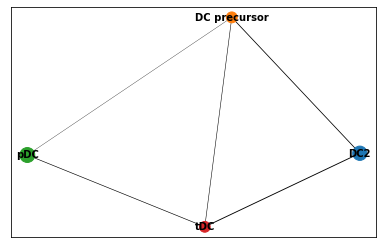

In [28]:
sc.pl.paga(bm, color=['cell.labels'], threshold = 0.1, edge_width_scale = 0.2, fontsize = 10)

In [29]:
sc.tl.diffmap(bm, neighbors_key='neighbours_harmony')

In [30]:
bm.uns['iroot'] = np.flatnonzero(bm.obs['cell.labels']  == 'DC precursor')[0]

In [31]:
sc.tl.dpt(bm, neighbors_key = 'neighbours_harmony')

In [32]:
paths = [('DC2', ['DC precursor','DC2']),
         ('tDC', ['DC precursor', 'tDC']),
         ('pDC', ['DC precursor', 'pDC'])]

In [33]:
bm.obs['distance'] = bm.obs['dpt_pseudotime']
bm.obs['clusters'] = bm.obs['cell.labels']


In [70]:
##Build separate anndata object to t-test regulons between clusters

test = anndata.AnnData(X=auc_mtx)
test.obs = bm.obs

sc.tl.rank_genes_groups(test, 'cell.labels', method='t-test')

result = test.uns['rank_genes_groups']
groups = result['names'].dtype.names
pd.DataFrame(
    {group + '_' + key[:1]: result[key][group]
    for group in groups for key in ['names', 'pvals']}).head(10)



,DC2_n,DC2_p,DC precursor_n,DC precursor_p,pDC_n,pDC_p,tDC_n,tDC_p
0,SPI1(+),1.448556e-279,MYC(+),1.705315e-56,TCF4(+),0.000000e+00,KLF4(+),1.828479e-47
1,NFE2(+),2.639323e-261,TP53(+),1.895845e-56,BCL11A(+),0.000000e+00,USF2(+),2.030507e-37
2,ZBTB7B(+),4.373567e-261,TFDP1(+),1.330960e-56,IRF7(+),0.000000e+00,KLF9(+),7.856121e-36
3,CEBPB(+),8.987289e-232,E2F4(+),3.937326e-51,IRF8(+),0.000000e+00,SPI1(+),9.169150e-28
4,CEBPD(+),1.762900e-233,E2F3(+),1.506853e-49,SPIB(+),0.000000e+00,HIVEP2(+),1.554927e-24
5,MAF(+),2.630289e-197,E2F1(+),1.880458e-48,ETS1(+),1.849887e-254,ETS2(+),2.527842e-20
6,CEBPG(+),2.111984e-181,MAZ(+),7.385104e-43,SOX18(+),1.956500e-320,ZBTB7B(+),1.868604e-17
7,RXRA(+),1.498750e-170,CEBPE(+),2.713284e-32,FOXS1(+),4.271723e-257,STAT5A(+),2.009555e-16
8,TWIST2(+),1.077137e-180,ERG(+),2.267893e-32,ZEB1(+),2.382344e-282,ZNF260(+),1.776272e-14
9,THRA(+),5.387287e-156,KLF1(+),1.639358e-29,CUX1(+),2.910800e-245,RELB(+),5.152516e-14


In [71]:
gene_names = ['MYC(+)', 'TP53(+)', 'TFDP1(+)', 'E2F4(+)', 'E2F3(+)',
              'SPI1(+)', 'NFE2(+)', 'ZBTB7B(+)', 'CEBPB(+)', 'CEBPD(+)',
              'TCF4(+)', 'BCL11A(+)', 'IRF7(+)', 'IRF8(+)', 'SPIB(+)',
              'KLF4(+)', 'USF2(+)', 'KLF9(+)', 'ETS2(+)']

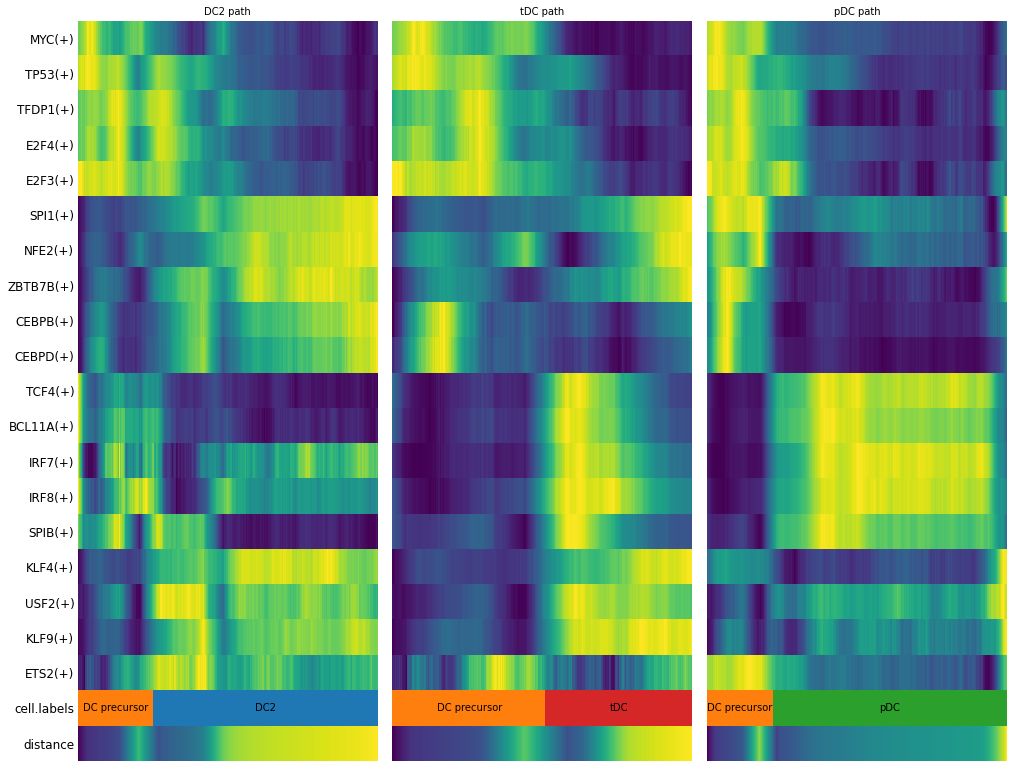

In [74]:
_, axs = plt.subplots(ncols=3, figsize=(15, 15), gridspec_kw={'wspace': 0.05, 'left': 0.12})
plt.subplots_adjust(left=0.05, right=0.98, top=0.82, bottom=0.2)
for ipath, (descr, path) in enumerate(paths):
    _, data = sc.pl.paga_path(
        bm, path, gene_names,
        use_raw=True,
        show_node_names=True,
        ax=axs[ipath],
        ytick_fontsize=12,
        left_margin=0.15,
        n_avg=50,
        annotations=['distance'],
        show_yticks=True if ipath==0 else False,
        show_colorbar=False,
        color_map='viridis',
        groups_key='cell.labels',
        color_maps_annotations={'distance': 'viridis'},
        title='{} path'.format(descr),
        return_data=True, 
        normalize_to_zero_one = True, 
        show=False)
    
os.chdir('/home/jovyan/data/bone_marrow/')
    
plt.savefig('./figures/DC_precursor_paths.pdf')